# IMPORTS

In [1]:
import sys
sys.path.append("..")
import warnings

In [2]:
from C2D_Models import *

In [3]:
from general import *
from general.results_handler import *

In [4]:
from universal_tester import *

In [5]:
from SVDD_fine_tuning import *

# General

In [6]:
MODELS_PATH = "../../ATTN_PPR_MODELS/"
METRICS = ['absolute', 'squared', 'ssim', 'psnr']
IGNORE_KEYS = ['loss', 'regularity', 'flat_loss', 'flat_regularity', 'agg_regularity', 'auc_roc', 'pr_roc']
SAVE_PATH = "../../ATTN_PPR_RESULTS/"
IAD_DATASETS = ["HAM10000", "IR_DISTRACTION", "MV-TEC", "MV_TEC"]

In [7]:
dataset_channels = {
    'AVENUE': 3,
    'HAM10000': 3,
    'IR_DISTRACTION': 3,
    'MV_TEC': 3,
    'SUBWAY_ENTRANCE': 1,
    'SUBWAY_EXIT': 1,
    'UCSD1': 1,
    'UCSD2': 1
}

# Helper Functions

In [8]:
def get_model_att_ppr(model_path, channels, att_channels = None):
    model_path = model_path.lower()
    if "softmax_attention" in model_path:
        return SoftMaxConvAttentionWrapper(C2D_AE_128_3x3(channels = channels), channels = att_channels)
    elif "conv_attention" in model_path:
        return ConvAttentionWrapper(C2D_AE_128_3x3(channels = channels), channels = att_channels)
    elif "aac" in model_path:
        return C2D_AE_128_3x3_AAC(channels = channels)
    elif "sqzex" in model_path:
        return C2D_AE_128_3x3_SQZEX(channels = channels)
    else:
        return C2D_AE_128_3x3(channels = channels)
    
def replace_model_name(model_name):
    model_name = model_name.lower()
    if "softmax_attention" in model_name:
        return "Softmax Attention CAE"
    elif "conv_attention" in model_name:
        return "Conv Attention CAE"
    elif "aac" in model_name:
        return "Attention Augmented CAE"
    elif "sqzex" in model_name:
        return "Squeeze Excitation CAE"
    else:
        return "Baseline CAE"
    
def get_results_att_ppr(model, model_path, all_results, metric, scoring_type):
    metric_results = all_results[metric]
    results_dict = {
        "Dataset": ModelParser.getDatasetType(model_path),
        "Model": model.__name__,
        "AUC_ROC": round(metric_results["auc_roc_score"][scoring_type], 4),
        "EER": round(metric_results["eer"][scoring_type], 4),
        "AUC_PR": round(metric_results["pr_roc_score"][scoring_type], 4),
        "Precision": round(metric_results["best"][scoring_type]["classification_report"]["weighted avg"]["precision"], 4),
        "Recall": round(metric_results["best"][scoring_type]["classification_report"]["weighted avg"]["recall"], 4),
        "F1_Score": round(metric_results["best"][scoring_type]["classification_report"]["weighted avg"]["f1-score"], 4),
    }
    return results_dict

def generate_csvs():
    for metric in METRICS:
        for scoring_type in ["agg", "overall"]:
            df = pd.DataFrame(MAIN_RESULTS_DICT[metric][scoring_type])
            df = df.sort_values(["Dataset", "Model"])
            df.to_csv(join_paths([SAVE_PATH, "%s_%s.csv"%(metric, scoring_type)]), index = False)
            
def get_att_channels(model_path):
    if "_C1_" in model_path: return 1
    if "_C3_" in model_path: return 3
    return False            

----------------------------------------------------------------

# Main Results Generation Process

In [7]:
# MAIN_RESULTS_DICT = dict()
# for metric in METRICS:
#     MAIN_RESULTS_DICT[metric] = {
#         "agg": list(),
#         "overall": list()
#     }
    
# MAIN_RESULTS_DICT = load_pickle(join_paths([SAVE_PATH, "ATT_PPR_RESULTS.pkl"]))

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for DATA_MODELS_PATH in read_directory_contents(MODELS_PATH):
        DATASET = ModelParser.getDatasetType(DATA_MODELS_PATH)
        INFO(DATASET)
        test_data, CHANNELS = select_dataset(
                DATASET.lower(),
                isTrain = False,
        )
        print("Data loaded\n")

        dataset_train_stats = dict()

        for MODEL_DIR in read_directory_contents(DATA_MODELS_PATH):
            print(MODEL_DIR)
            MODEL_PATH = join_paths([MODEL_DIR, MODEL_DIR.split("/")[-1] + ".pth.tar"])
            TRAIN_STATS_PKL = join_paths([MODEL_DIR, "train_stats.pkl"])

            MODEL = get_model_att_ppr(MODEL_PATH, channels = CHANNELS, att_channels = get_att_channels(MODEL_PATH))
            load_model(MODEL, MODEL_PATH)
            MODEL_NAME = MODEL.__name__
            dataset_train_stats[MODEL_NAME] = load_pickle(TRAIN_STATS_PKL)
            if "avenue" in DATASET.lower() and "sqzex" not in MODEL_DIR.lower(): continue
                
            tester = AutoEncoder_Tester(
                model = MODEL,
                dataset = test_data,
                model_file = MODEL_PATH,
                stackFrames = 64,
                regularity_type = "savgol",
                recordResults = True,
                printResults = False,
                forceNormalTest = True,
                useGPU = "AAC" not in MODEL_NAME
            )
            tester.test()
            RESULTS_FILE = join_paths([MODEL_DIR, MODEL_DIR.split("/")[-1] + ".pkl"])
            MODEL_RESULTS = load_pickle(RESULTS_FILE)
            for metric in METRICS:
                for scoring_type in ["agg", "overall"]:
                    r = get_results_att_ppr(MODEL, MODEL_PATH, MODEL_RESULTS, metric, scoring_type)
                    MAIN_RESULTS_DICT[metric][scoring_type].append(r)
            del MODEL, tester      
        print("-"*40)
        dump_pickle(dataset_train_stats, join_paths([SAVE_PATH, "%s_train_stats.pkl"%(DATASET)]))
        del test_data
        INFO("COMPLETED: " + DATASET)

0it [00:00, ?it/s]

----------------------------------------
[INFO]: AVENUE
----------------------------------------


0it [00:02, ?it/s]


KeyboardInterrupt: 

In [11]:
dump_pickle(MAIN_RESULTS_DICT, join_paths([SAVE_PATH, "ATT_PPR_RESULTS.pkl"]))
generate_csvs()
print("DONE")

True

# IAD Results

In [8]:
IAD_TAG = "IAD"

In [178]:
IAD_RESULTS_DICT = dict()
for metric in METRICS:
    IAD_RESULTS_DICT[metric] = {
        "agg": list(),
        "overall": list()
    }

In [179]:
def generate_iad_results(results_file):
    results = load_pickle(results_file)
    for metric in METRICS:
        ins_results = results[metric]
        for scoring_type in ["agg", "overall"]:
            model = get_model_att_ppr(results_file, channels = 3, att_channels = get_att_channels(results_file))
            extracted_results = {
                "Dataset": ModelParser.getDatasetType(results_file),
                "Model": model.__name__,
                "AUC_ROC": ins_results["auc_roc_score"][scoring_type],
                "MEAN_AUC_ROC": ins_results["auc_roc_score"]["mean"],
                "CLASS_AUC_ROC": ins_results["auc_roc"],
                "EER": ins_results["eer"][scoring_type],
                "AUC_PR": ins_results["pr_roc_score"][scoring_type],
                "CLASS_PR_ROC": ins_results["pr_roc"],
                "MEAN_AUC_PR": ins_results["pr_roc_score"]["mean"],
                "Pecision": ins_results["best"][scoring_type]['classification_report']['weighted avg']['precision'],
                "Recall": ins_results["best"][scoring_type]['classification_report']['weighted avg']['recall'],
                "F1-Score": ins_results["best"][scoring_type]['classification_report']['weighted avg']['f1-score'],
            }
            del model
            IAD_RESULTS_DICT[metric][scoring_type].append(extracted_results)

In [180]:
for DATA_MODELS_PATH in read_directory_contents(MODELS_PATH):
    DATASET = ModelParser.getDatasetType(DATA_MODELS_PATH)
    if DATASET not in IAD_DATASETS: continue
    INFO(DATASET)
    
    for MODEL_DIR in read_directory_contents(DATA_MODELS_PATH):
        print(MODEL_DIR)
        MODEL_RESULTS_FILE = join_paths([MODEL_DIR, MODEL_DIR.split("/")[-1] + ".pkl"])
        generate_iad_results(MODEL_RESULTS_FILE)

----------------------------------------
[INFO]: HAM10000
----------------------------------------
../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}
../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_CONV_ATTENTION_P64_L1E-06_C1_ADAM_MSE_HAM10000_NORMAL-{APE}
../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_CONV_ATTENTION_P64_L1E-06_C3_ADAM_MSE_HAM10000_NORMAL-{APE}
../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_HAM10000_NORMAL-{APE}
../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_HAM10000_NORMAL-{APE}
../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3_AAC-_ADAM_MSE_HAM10000_NORMAL-{APE}
../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3_SQZEX-_ADAM_MSE_HAM10000_NORMAL-{APE}
----------------------------------------
[INFO]: IR_DISTRACTION
----------------------------------------
../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}
../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_A

In [181]:
dump_pickle(IAD_RESULTS_DICT, join_paths([SAVE_PATH, "IAD_results.pkl"]))
print("DONE")

True

In [21]:
IAD_RESULTS_DICT = load_pickle(join_paths([SAVE_PATH, "IAD_results.pkl"]))

In [22]:
df = pd.DataFrame(IAD_RESULTS_DICT["absolute"]["agg"])

In [23]:
df

,Dataset,Model,AUC_ROC,MEAN_AUC_ROC,CLASS_AUC_ROC,EER,AUC_PR,CLASS_PR_ROC,MEAN_AUC_PR,Pecision,Recall,F1-Score
0,HAM10000,C2D_AE_128_3x3-,0.686001,0.702444,"[0.8339449541284405, 0.709387159533074, 0.7182...",0.355000,0.618653,"[0.8102958834493114, 0.5998591277288121, 0.744...",0.707782,0.720349,0.688528,0.700053
1,HAM10000,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C1,0.685132,0.703879,"[0.8313761467889909, 0.705535019455253, 0.7185...",0.352601,0.619000,"[0.806280955129862, 0.6023549322192593, 0.7447...",0.711263,0.721198,0.658070,0.676029
2,HAM10000,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C3,0.690999,0.708229,"[0.8358256880733945, 0.7111964980544747, 0.722...",0.350833,0.614332,"[0.8144394711049829, 0.596743202232283, 0.7425...",0.713325,0.725814,0.704980,0.713216
3,HAM10000,C2D_AE_128_3x3-_SOFTMAX_ATTENTION_P64_C1,0.571396,0.570904,"[0.5280275229357798, 0.580544747081712, 0.5866...",0.433333,0.686102,"[0.5938407994468471, 0.6726967844599026, 0.814...",0.686199,0.661182,0.565807,0.590806
4,HAM10000,C2D_AE_128_3x3-_SOFTMAX_ATTENTION_P64_C3,0.701490,0.753134,"[0.8393883792048931, 0.7203599221789884, 0.738...",0.344451,0.614819,"[0.8046372852878263, 0.6097213521690048, 0.748...",0.738636,0.733031,0.695643,0.708210
5,HAM10000,C2D_AE_128_3x3_AAC-,0.687797,0.702938,"[0.8296636085626912, 0.7031128404669261, 0.715...",0.351934,0.616170,"[0.8056861479528674, 0.6026840036599632, 0.746...",0.712374,0.725998,0.709426,0.716255
6,HAM10000,C2D_AE_128_3x3_SQZEX-,0.693629,0.709257,"[0.8348776758409786, 0.7146400778210117, 0.722...",0.347375,0.612619,"[0.8149978383565307, 0.5931164029606546, 0.741...",0.712240,0.725253,0.691863,0.703675
7,IR_DISTRACTION,C2D_AE_128_3x3-,0.796222,0.794867,"[0.6591, 0.7585, 0.9670000000000001]",0.300000,0.780611,"[0.668895471502317, 0.7596022413833969, 0.9674...",0.798643,0.768125,0.750000,0.745702
8,IR_DISTRACTION,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C1,0.795578,0.794800,"[0.6595, 0.7629, 0.962]",0.290000,0.778865,"[0.6558887309819585, 0.7727710844333873, 0.964...",0.797771,0.748263,0.728333,0.722769
9,IR_DISTRACTION,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C3,0.784956,0.787000,"[0.6212, 0.7704, 0.9693999999999999]",0.263333,0.778071,"[0.6473168416971862, 0.7877074023826396, 0.973...",0.802758,0.749333,0.748333,0.748081


In [46]:
latex_string = "\n"

dataset = ""
old_dataset = ""
for idx, row in df.iterrows():
    dataset = " ".join(row["Dataset"].split("_"))
#     if "_C1" in str(row): continue
    if "ir_distraction" in str(row).lower(): continue
    model = replace_model_name(row["Model"])
    if dataset == "" or dataset != old_dataset:
        latex_string += "\t\hline\n\t\multirow{5}{*}{%s}"%(dataset)
    row = list(row[:3]) + list(row[5:7]) + list(row[9:])
    latex_string += "\t" + ("" if "soft" in str(row).lower() else "") + "& " + " & ".join(list(map(lambda x: "%0.2f"%(x*100) if isinstance(x, float) else str(x), [model] + list(row)[2:]))) + "\\\\\n"
    old_dataset = dataset
latex_string += "\t\hline\n"    

In [47]:
print(latex_string)


	\hline
	\multirow{5}{*}{HAM10000}	& Baseline CAE & 68.60 & 35.50 & 61.87 & 72.03 & 68.85 & 70.01\\
	& Conv Attention CAE & 68.51 & 35.26 & 61.90 & 72.12 & 65.81 & 67.60\\
	& Conv Attention CAE & 69.10 & 35.08 & 61.43 & 72.58 & 70.50 & 71.32\\
	& Softmax Attention CAE & 57.14 & 43.33 & 68.61 & 66.12 & 56.58 & 59.08\\
	& Softmax Attention CAE & 70.15 & 34.45 & 61.48 & 73.30 & 69.56 & 70.82\\
	& Attention Augmented CAE & 68.78 & 35.19 & 61.62 & 72.60 & 70.94 & 71.63\\
	& Squeeze Excitation CAE & 69.36 & 34.74 & 61.26 & 72.53 & 69.19 & 70.37\\
	\hline
	\multirow{5}{*}{MV TEC}	& Baseline CAE & 61.34 & 42.83 & 64.63 & 69.13 & 69.80 & 69.44\\
	& Conv Attention CAE & 61.85 & 40.41 & 65.21 & 68.24 & 60.58 & 62.70\\
	& Conv Attention CAE & 63.86 & 39.61 & 64.13 & 68.81 & 65.45 & 66.71\\
	& Softmax Attention CAE & 62.00 & 41.51 & 66.58 & 69.34 & 50.09 & 51.57\\
	& Softmax Attention CAE & 56.16 & 46.90 & 68.26 & 64.97 & 64.06 & 64.48\\
	& Attention Augmented CAE & 60.95 & 42.05 & 66.82 & 68.85 &

# Results Table - VAD datasets - MSE Agg

In [10]:
read_directory_contents(join_paths(["../../ATTN_PPR_RESULTS/VAD_ResultsCSV/", "*.csv"]))

['../../ATTN_PPR_RESULTS/VAD_ResultsCSV/absolute_agg.csv',
 '../../ATTN_PPR_RESULTS/VAD_ResultsCSV/absolute_overall.csv',
 '../../ATTN_PPR_RESULTS/VAD_ResultsCSV/psnr_agg.csv',
 '../../ATTN_PPR_RESULTS/VAD_ResultsCSV/psnr_overall.csv',
 '../../ATTN_PPR_RESULTS/VAD_ResultsCSV/squared_agg.csv',
 '../../ATTN_PPR_RESULTS/VAD_ResultsCSV/squared_overall.csv',
 '../../ATTN_PPR_RESULTS/VAD_ResultsCSV/ssim_agg.csv',
 '../../ATTN_PPR_RESULTS/VAD_ResultsCSV/ssim_overall.csv']

In [16]:
df = pd.read_csv('../../ATTN_PPR_RESULTS/ResultsTables/VAD_results.csv')

In [13]:
adf = df.copy()
for ds in IAD_DATASETS:
    adf = adf[~adf.Dataset.str.contains(ds)]

In [98]:
adf.to_csv(join_paths([SAVE_PATH, "ResultsTables/VAD_results.csv"]))

In [14]:
latex_string = "\n"

dataset = ""
old_dataset = ""
for idx, row in adf.iterrows():
    dataset = " ".join(row["Dataset"].split("_"))
    if "avenue" in dataset.lower() and "_C1" in str(row): continue
    model = replace_model_name(row["Model"])
    if dataset == "" or dataset != old_dataset:
        latex_string += "\t\hline\n\t\multirow{5}{*}{%s}"%(dataset)
    latex_string += "\t" + ("\setrow{\\bfseries}" if "soft" in str(row).lower() else "") + "& " + " & ".join(list(map(lambda x: "%0.2f"%(x*100) if isinstance(x, float) else str(x), [model] + list(row)[2:]))) + "\\\\\n"
    old_dataset = dataset
latex_string += "\t\hline\n"    

In [15]:
print(latex_string)


	\hline
	\multirow{5}{*}{AVENUE}	& Baseline CAE & 81.60 & 25.97 & 80.15 & 75.28 & 74.38 & 74.47\\
	& Conv Attention CAE & 79.75 & 25.93 & 76.04 & 76.03 & 74.55 & 74.61\\
	\setrow{\bfseries}& Softmax Attention CAE & 89.67 & 15.76 & 89.66 & 85.44 & 85.46 & 85.43\\
	& Attention Augmented CAE & 78.08 & 27.84 & 72.62 & 73.31 & 72.44 & 72.54\\
	& Squeeze Excitation CAE & 80.52 & 24.86 & 75.94 & 76.50 & 75.80 & 75.89\\
	\hline
	\multirow{5}{*}{SUBWAY ENTRANCE}	& Baseline CAE & 74.28 & 33.38 & 99.03 & 96.38 & 61.15 & 73.47\\
	& Conv Attention CAE & 73.85 & 33.10 & 99.00 & 96.18 & 65.70 & 76.95\\
	\setrow{\bfseries}& Softmax Attention CAE & 74.88 & 31.41 & 99.12 & 96.53 & 64.46 & 75.99\\
	& Attention Augmented CAE & 74.61 & 33.28 & 99.05 & 96.28 & 62.65 & 74.65\\
	& Squeeze Excitation CAE & 72.08 & 32.13 & 98.86 & 96.21 & 66.63 & 77.62\\
	\hline
	\multirow{5}{*}{SUBWAY EXIT}	& Baseline CAE & 95.68 & 11.11 & 100.00 & 99.91 & 92.98 & 96.28\\
	& Conv Attention CAE & 95.60 & 11.11 & 100.00 & 99.91

# Results table - IAD squared agg

In [19]:
IAD_RESULTS_DICT = load_pickle("../../ATTN_PPR_RESULTS/IAD_results.pkl")

In [187]:
pd.DataFrame(IAD_RESULTS_DICT["absolute"]["overall"])

,Dataset,Model,AUC_ROC,MEAN_AUC_ROC,CLASS_AUC_ROC,EER,AUC_PR,CLASS_PR_ROC,MEAN_AUC_PR,Pecision,Recall,F1-Score
0,HAM10000,C2D_AE_128_3x3-,0.734262,0.702444,"[0.8339449541284405, 0.709387159533074, 0.7182...",0.318784,0.599439,"[0.8102958834493114, 0.5998591277288121, 0.744...",0.707782,0.758879,0.651178,0.671258
1,HAM10000,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C1,0.734189,0.703879,"[0.8313761467889909, 0.705535019455253, 0.7185...",0.313220,0.599181,"[0.806280955129862, 0.6023549322192593, 0.7447...",0.711263,0.759318,0.652290,0.672315
2,HAM10000,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C3,0.737902,0.708229,"[0.8358256880733945, 0.7111964980544747, 0.722...",0.317918,0.596536,"[0.8144394711049829, 0.596743202232283, 0.7425...",0.713325,0.760732,0.659849,0.679482
3,HAM10000,C2D_AE_128_3x3-_SOFTMAX_ATTENTION_P64_C1,0.600017,0.570904,"[0.5280275229357798, 0.580544747081712, 0.5866...",0.425000,0.678514,"[0.5938407994468471, 0.6726967844599026, 0.814...",0.686199,0.676392,0.620276,0.638924
4,HAM10000,C2D_AE_128_3x3-_SOFTMAX_ATTENTION_P64_C3,0.763978,0.753134,"[0.8393883792048931, 0.7203599221789884, 0.738...",0.280000,0.593964,"[0.8046372852878263, 0.6097213521690048, 0.748...",0.738636,0.777354,0.734993,0.747084
5,HAM10000,C2D_AE_128_3x3_AAC-,0.732071,0.702938,"[0.8296636085626912, 0.7031128404669261, 0.715...",0.316859,0.599769,"[0.8056861479528674, 0.6026840036599632, 0.746...",0.712374,0.753748,0.736994,0.743573
6,HAM10000,C2D_AE_128_3x3_SQZEX-,0.739506,0.709257,"[0.8348776758409786, 0.7146400778210117, 0.722...",0.320000,0.595072,"[0.8149978383565307, 0.5931164029606546, 0.741...",0.712240,0.753785,0.720320,0.731382
7,IR_DISTRACTION,C2D_AE_128_3x3-,0.794867,0.794867,"[0.6591, 0.7585, 0.9670000000000001]",0.283333,0.774288,"[0.668895471502317, 0.7596022413833969, 0.9674...",0.798643,0.771490,0.763333,0.761542
8,IR_DISTRACTION,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C1,0.794800,0.794800,"[0.6595, 0.7629, 0.962]",0.303333,0.772905,"[0.6558887309819585, 0.7727710844333873, 0.964...",0.797771,0.759775,0.751667,0.749714
9,IR_DISTRACTION,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C3,0.787000,0.787000,"[0.6212, 0.7704, 0.9693999999999999]",0.266667,0.770409,"[0.6473168416971862, 0.7877074023826396, 0.973...",0.802758,0.746266,0.741667,0.740455


In [20]:
pd.DataFrame(IAD_RESULTS_DICT["squared"]["agg"])

,Dataset,Model,AUC_ROC,MEAN_AUC_ROC,CLASS_AUC_ROC,EER,AUC_PR,CLASS_PR_ROC,MEAN_AUC_PR,Pecision,Recall,F1-Score
0,HAM10000,C2D_AE_128_3x3-,0.683160,0.707460,"[0.8279816513761469, 0.7134824902723735, 0.716...",0.361128,0.614789,"[0.8143959932420182, 0.5943540766530371, 0.741...",0.712580,0.719270,0.680747,0.693989
1,HAM10000,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C1,0.684214,0.710685,"[0.8267584097859326, 0.7147859922178988, 0.719...",0.358096,0.613910,"[0.8139032595798915, 0.5928372369020533, 0.740...",0.715528,0.721423,0.702090,0.709898
2,HAM10000,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C3,0.685492,0.711868,"[0.8275535168195719, 0.714464980544747, 0.7192...",0.360522,0.612907,"[0.8154961215855617, 0.5934405819525272, 0.740...",0.717128,0.721573,0.688751,0.700509
3,HAM10000,C2D_AE_128_3x3-_SOFTMAX_ATTENTION_P64_C1,0.531964,0.579315,"[0.5441743119266055, 0.5879280155642023, 0.582...",0.471801,0.710023,"[0.5807019185726467, 0.6655308292787591, 0.817...",0.684215,0.630992,0.529346,0.556513
4,HAM10000,C2D_AE_128_3x3-_SOFTMAX_ATTENTION_P64_C3,0.674065,0.767981,"[0.8328746177370032, 0.7274221789883268, 0.741...",0.372347,0.623080,"[0.8075052894689169, 0.6021840816047064, 0.742...",0.750173,0.719453,0.712317,0.715592
5,HAM10000,C2D_AE_128_3x3_AAC-,0.680058,0.708695,"[0.8247094801223241, 0.7114396887159533, 0.714...",0.362874,0.615432,"[0.8114688541029501, 0.5946624848085494, 0.742...",0.716094,0.719672,0.698088,0.706649
6,HAM10000,C2D_AE_128_3x3_SQZEX-,0.687322,0.713559,"[0.8276299694189603, 0.7180447470817121, 0.719...",0.355345,0.611723,"[0.8161857936123897, 0.5901438545634599, 0.739...",0.716885,0.723555,0.703424,0.711465
7,IR_DISTRACTION,C2D_AE_128_3x3-,0.852789,0.849067,"[0.7326, 0.8187, 0.9959]",0.246667,0.845811,"[0.7125535835716921, 0.8188571968589803, 0.995...",0.842453,0.779113,0.771667,0.770134
8,IR_DISTRACTION,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C1,0.844267,0.841967,"[0.7041000000000001, 0.8243, 0.9975]",0.203333,0.837509,"[0.6939648135025043, 0.8225274374317499, 0.998]",0.838164,0.801831,0.801667,0.801640
9,IR_DISTRACTION,C2D_AE_128_3x3-_CONV_ATTENTION_P64_L1e-06_C3,0.829911,0.836000,"[0.6787000000000001, 0.8305, 0.9988]",0.270000,0.840398,"[0.6968849152367683, 0.8311459797079168, 0.998...",0.842320,0.754525,0.750000,0.748884


# Tr Graph Generation

In [195]:
%matplotlib inline

In [188]:
GRAPHS_SAVE_PATH = join_paths([SAVE_PATH, "TrainStats"])

In [205]:
for stat_file in read_directory_contents(join_paths([SAVE_PATH, "*train_stats.pkl"])):
    stats = load_pickle(stat_file)
    dataset = os.path.split(stat_file)[-1].split("_train_stats.pkl")[0]
    
    for model in stats.keys():
        model_stats = stats[model]
        model_name = replace_model_name(model)
        for loss_type in model_stats.keys():
            plt.plot(np.array(range(len(model_stats[loss_type][:200]))), model_stats[loss_type][:200], label = "%s_%s"%(model_name, loss_type))
    plt.legend()
    plt.savefig(join_paths([GRAPHS_SAVE_PATH, "%s_stats.png"%(dataset)]))
    plt.close()
    plt.clf()

<Figure size 432x288 with 0 Axes>

# SVDD

# SVDD Best models production

In [10]:
svdd_auc_best = load_pickle("../ATTN_PPR_RESULTS/Baseline_SVDD/SVDD_best_AUC_ROC_Baseline.pkl")

In [11]:
svdd_auc_best

{'AVENUE': array(['1e-05', '1.0', '0.84560572377758'], dtype='<U18'),
 'HAM10000': array(['1e-07', '20.0', '0.685140236506974'], dtype='<U18'),
 'IR_DISTRACTION': array(['0.0001', '0.0', '0.8918555555555556'], dtype='<U18'),
 'MV_TEC': array(['0.0001', '1.0', '0.6605161654916032'], dtype='<U18'),
 'SUBWAY_ENTRANCE': array(['5e-05', '2.0', '0.7903505071775421'], dtype='<U18'),
 'SUBWAY_EXIT': array(['5e-05', '1.0', '0.9744849506754267'], dtype='<U18'),
 'UCSD1': array(['1e-05', '20.0', '0.7345594236001872'], dtype='<U18'),
 'UCSD2': array(['0.0001', '5.0', '0.8884852893847557'], dtype='<U18')}

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for DATA_MODELS_PATH in read_directory_contents(MODELS_PATH):
        DATASET = ModelParser.getDatasetType(DATA_MODELS_PATH)
        INFO(DATASET)
        lr, e, perf = svdd_auc_best[DATASET]
        lr = float(lr)
        e = int(float(e))
        for MODEL_DIR in read_directory_contents(DATA_MODELS_PATH):
            MODEL_PATH = join_paths([MODEL_DIR, MODEL_DIR.split("/")[-1] + ".pth.tar"])
            MODEL = get_model_att_ppr(MODEL_PATH, channels = dataset_channels[DATASET], att_channels = get_att_channels(MODEL_PATH))
            load_model(MODEL, MODEL_PATH)
            MODEL_NAME = MODEL.__name__

            if replace_model_name(MODEL_NAME) != replace_model_name("Baseline CAE"): continue

            svdd_ft = SVDD_FineTuner(
                model = MODEL,
                model_path = MODEL_PATH,
                dataset_type = DATASET.lower(),
                lr = lr,
                epochs = [e],
                filename_addon = "BestAUCROC",
                testOriginal = True,
                returnResults = True,
            )
            
            del MODEL, svdd_ft
        print("-"*40)
        INFO("COMPLETED: " + DATASET)

0it [00:00, ?it/s]

----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:22,  3.91s/it]
21it [01:19,  3.78s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [01:22,  5.14s/it]
  1%|          | 112/15328 [00:00<00:13, 1115.57it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:10<00:00, 1414.65it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.529015 | Val Loss: 0.231433 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:20,  3.84s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7102133285143218), ('auc_roc_score_agg_psnr', 0.808959943775281), ('auc_roc_score_agg_squared', 0.8413528965895087), ('auc_roc_score_agg_ssim', 0.6254997574742265), ('auc_roc_score_mean_absolute', 0.8453669684797053), ('auc_roc_score_mean_psnr', 0.8390817997665133), ('auc_roc_score_mean_squared', 0.8388931156388736), ('auc_roc_score_mean_ssim', 0.8473785357974993), ('auc_roc_score_overall_absolute', 0.9502369561383505), ('auc_roc_score_overall_psnr', 0.9670732105769746), ('auc_roc_score_overall_squared', 0.9672190646942103), ('auc_roc_score_overall_ssim', 0.9162606615489377), ('eer_agg_absolute', 0.33994963709045795), ('eer_agg_psnr', 0.26396827248437643), ('eer_agg_squared', 0.24227225008861583), ('eer_agg_ssim', 0.42715502157836066), ('eer_overall_absolute', 0.1013183232113746), ('eer_overall_psnr', 0.09020885794671368), ('eer_overall_squared', 0.09169011998222515), ('eer_overall_ssim', 0.15745815434769422), ('pr_roc_score_agg_absolute', 

6it [00:24,  4.04s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  2%|▏         | 115/6460 [00:00<00:05, 1147.40it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1405.33it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 20 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar


Epoch [0/20] | Train Loss: 76.026163 | Val Loss: 66.666294 | Time: (2) s
Epoch [1/20] | Train Loss: 49.094232 | Val Loss: 58.833197 | Time: (2) s
Epoch [2/20] | Train Loss: 49.772566 | Val Loss: 63.220711 | Time: (2) s
Epoch [3/20] | Train Loss: 48.561560 | Val Loss: 56.734906 | Time: (2) s
Epoch [4/20] | Train Loss: 49.985333 | Val Loss: 59.763126 | Time: (2) s
Epoch [5/20] | Train Loss: 49.204714 | Val Loss: 59.045609 | Time: (2) s
Epoch [6/20] | Train Loss: 48.753105 | Val Loss: 60.818300 | Time: (2) s
Epoch [7/20] | Train Loss: 49.674718 | Val Loss: 53.167380 | Time: (2) s
Epoch [8/20] | Train Loss: 48.891128 | Val Loss: 52.226075 | Time: (2) s
Epoch [9/20] | Train Loss: 47.396048 | Val Loss: 72.594564 | Time: (2) s
Epoch [10/20] | Train Loss: 48.184609 | Val Loss: 72.811808 | Time: (2) s
Epoch [11/20] | Train Loss: 47.721381 | Val Loss: 54.170351 | Time: (2) s
Epoch [12/20] | Train Loss: 48.729781 | Val Loss: 84.506998 | Time: (2) s
Epoch [13/20] | Train Loss: 48.377234 | Val Loss

0it [00:00, ?it/s]

Epoch [19/20] | Train Loss: 47.520349 | Val Loss: 78.589011 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6892019153022034), ('auc_roc_score_agg_psnr', 0.7149994946432181), ('auc_roc_score_agg_squared', 0.6860891702041642), ('auc_roc_score_agg_ssim', 0.677860824742268), ('auc_roc_score_mean_absolute', 0.7066387222485949), ('auc_roc_score_mean_psnr', 0.7103725523039374), ('auc_roc_score_mean_squared', 0.7103717416683991), ('auc_roc_score_mean_ssim', 0.6748437030668465), ('auc_roc_score_overall_absolute', 0.7362022437841116), ('auc_roc_score_overall_psnr', 0.7395019708914493), ('auc_roc_score_overall_squared', 0.7395012128562766), ('auc_roc_score_overall_ssim', 0.7037886597938143), ('eer_agg_absolute', 0.3525000000000001), ('eer_agg_psnr', 0.3391666666669457), ('eer_agg_squared', 0.35930867192254895), ('eer_agg_ssim', 0.355), ('eer_overall_absolute', 0.32565191024874285), ('eer_overall_psnr', 0.3150000000001083), ('eer_overall_squared', 0.3150000000001083), ('eer_overall_ssim', 0.3320394147506718), ('pr_roc_score_agg_absolute', 0.6144787484534788

3it [00:03,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7962222222222222), ('auc_roc_score_agg_psnr', 0.8561), ('auc_roc_score_agg_squared', 0.8527888888888888), ('auc_roc_score_agg_ssim', 0.7358555555555556), ('auc_roc_score_mean_absolute', 0.7948666666666666), ('auc_roc_score_mean_psnr', 0.8490666666666667), ('auc_roc_score_mean_squared', 0.8490666666666667), ('auc_roc_score_mean_ssim', 0.7411666666666666), ('auc_roc_score_overall_absolute', 0.7948666666666666), ('auc_roc_score_overall_psnr', 0.8490666666666666), ('auc_roc_score_overall_squared', 0.8490666666666666), ('auc_roc_score_overall_ssim', 0.7411666666666666), ('eer_agg_absolute', 0.3), ('eer_agg_psnr', 0.23666666666664898), ('eer_agg_squared', 0.24666666666646433), ('eer_agg_ssim', 0.36249999999999993), ('eer_overall_absolute', 0.2833333333336224), ('eer_overall_psnr', 0.2409090909090909), ('eer_overall_squared', 0.2409090909090909), ('eer_overall_ssim', 0.3733333333339954), ('pr_roc_score_agg_absolute', 0.7806105410162599), ('pr_roc_

  4%|▍         | 136/3200 [00:00<00:02, 1354.07it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1411.32it/s]
0it [00:00, ?it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 0 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.15s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7962222222222222), ('auc_roc_score_agg_psnr', 0.8561), ('auc_roc_score_agg_squared', 0.8527888888888888), ('auc_roc_score_agg_ssim', 0.7358555555555556), ('auc_roc_score_mean_absolute', 0.7948666666666666), ('auc_roc_score_mean_psnr', 0.8490666666666667), ('auc_roc_score_mean_squared', 0.8490666666666667), ('auc_roc_score_mean_ssim', 0.7411666666666666), ('auc_roc_score_overall_absolute', 0.7948666666666666), ('auc_roc_score_overall_psnr', 0.8490666666666666), ('auc_roc_score_overall_squared', 0.8490666666666666), ('auc_roc_score_overall_ssim', 0.7411666666666666), ('eer_agg_absolute', 0.3), ('eer_agg_psnr', 0.23666666666664898), ('eer_agg_squared', 0.24666666666646433), ('eer_agg_ssim', 0.36249999999999993), ('eer_overall_absolute', 0.2833333333336224), ('eer_overall_psnr', 0.2409090909090909), ('eer_overall_squared', 0.2409090909090909), ('eer_overall_ssim', 0.3733333333339954), ('pr_roc_score_agg_absolute', 0.7806105410162599), ('pr_roc_

100%|██████████| 17/17 [00:48<00:00,  2.86s/it]
15it [00:10,  1.39it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  3%|▎         | 114/3629 [00:00<00:03, 1139.43it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1396.64it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1157.236810 | Val Loss: 327.986990 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:10,  1.39it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.6696482980019949), ('auc_roc_score_agg_psnr', 0.6696687240206575), ('auc_roc_score_agg_squared', 0.6643085962899542), ('auc_roc_score_agg_ssim', 0.5806180913247294), ('auc_roc_score_mean_absolute', 0.6837774313585165), ('auc_roc_score_mean_psnr', 0.7019288922305407), ('auc_roc_score_mean_squared', 0.7019288922305407), ('auc_roc_score_mean_ssim', 0.6061098668419729), ('auc_roc_score_overall_absolute', 0.5401303179990673), ('auc_roc_score_overall_psnr', 0.550651419778514), ('auc_roc_score_overall_squared', 0.5506514197785138), ('auc_roc_score_overall_ssim', 0.5277674702035453), ('eer_agg_absolute', 0.3878948531035725), ('eer_agg_psnr', 0.367536231884058), ('eer_agg_squared', 0.383942766296578), ('eer_agg_ssim', 0.44753747323340476), ('eer_overall_absolute', 0.4874012786761926), ('eer_overall_psnr', 0.45151033386384715), ('eer_overall_squared', 0.45151033386384715), ('eer_overall_ssim', 0.47840755735492585), ('pr_roc_score_agg_absolute', 0.618

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:51, 111.41s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  2%|▏         | 117/7509 [00:00<00:06, 1164.50it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1452.05it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 2 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar


Epoch [0/2] | Train Loss: 0.511673 | Val Loss: 0.134887 | Time: (2) s


0it [00:00, ?it/s]

Epoch [1/2] | Train Loss: 0.089826 | Val Loss: 0.072085 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:51, 111.36s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7827190960482001), ('auc_roc_score_agg_psnr', 0.786101649738606), ('auc_roc_score_agg_squared', 0.7897309833332227), ('auc_roc_score_agg_ssim', 0.7699142747062224), ('auc_roc_score_mean_absolute', 0.7827190960482001), ('auc_roc_score_mean_psnr', 0.786101649738606), ('auc_roc_score_mean_squared', 0.7897309833332227), ('auc_roc_score_mean_ssim', 0.7699142747062224), ('auc_roc_score_overall_absolute', 0.7827190960482001), ('auc_roc_score_overall_psnr', 0.786101649738606), ('auc_roc_score_overall_squared', 0.7897309833332227), ('auc_roc_score_overall_ssim', 0.7699142747062224), ('eer_agg_absolute', 0.27889616644186965), ('eer_agg_psnr', 0.2637931034478647), ('eer_agg_squared', 0.2592949335388266), ('eer_agg_ssim', 0.30517241379317517), ('eer_overall_absolute', 0.27889616644186965), ('eer_overall_psnr', 0.2637931034478647), ('eer_overall_squared', 0.2592949335388266), ('eer_overall_ssim', 0.30517241379317517), ('pr_roc_score_agg_absolute', 0.992

0it [00:00, ?it/s]

11475


1it [00:58, 58.79s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  6%|▌         | 139/2509 [00:00<00:01, 1388.53it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1446.66it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 36.243558 | Val Loss: 38.577898 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [00:57, 57.61s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9715584239393763), ('auc_roc_score_agg_psnr', 0.9738647595790453), ('auc_roc_score_agg_squared', 0.9734093067426399), ('auc_roc_score_agg_ssim', 0.9764036668798574), ('auc_roc_score_mean_absolute', 0.9715584239393763), ('auc_roc_score_mean_psnr', 0.9738647595790453), ('auc_roc_score_mean_squared', 0.9734093067426399), ('auc_roc_score_mean_ssim', 0.9764036668798574), ('auc_roc_score_overall_absolute', 0.9715584239393763), ('auc_roc_score_overall_psnr', 0.9738647595790453), ('auc_roc_score_overall_squared', 0.9734093067426399), ('auc_roc_score_overall_ssim', 0.9764036668798574), ('eer_agg_absolute', 0.11111111111102046), ('eer_agg_psnr', 0.1111111111109059), ('eer_agg_squared', 0.11111111111038234), ('eer_agg_ssim', 0.09497645211897542), ('eer_overall_absolute', 0.11111111111102046), ('eer_overall_psnr', 0.1111111111109059), ('eer_overall_squared', 0.11111111111038234), ('eer_overall_ssim', 0.09497645211897542), ('pr_roc_score_agg_absolute', 

36it [00:08,  4.34it/s]
36it [00:40,  1.13s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:07,  4.46it/s]
  2%|▏         | 138/6800 [00:00<00:04, 1372.87it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1447.38it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 20 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar
Epoch [0/20] | Train Loss: 1.880154 | Val Loss: 0.771534 | Time: (2) s
Epoch [1/20] | Train Loss: 0.632854 | Val Loss: 0.539246 | Time: (2) s
Epoch [2/20] | Train Loss: 0.463611 | Val Loss: 0.409006 | Time: (2) s
Epoch [3/20] | Train Loss: 0.348175 | Val Loss: 0.306535 | Time: (2) s
Epoch [4/20] | Train Loss: 0.258225 | Val Loss: 0.237104 | Time: (2) s
Epoch [5/20] | Train Loss: 0.186303 | Val Loss: 0.163767 | Time: (2) s
Epo

0it [00:00, ?it/s]

Epoch [19/20] | Train Loss: 0.017550 | Val Loss: 0.017751 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7119283653196312), ('auc_roc_score_agg_psnr', 0.7240012615602208), ('auc_roc_score_agg_squared', 0.7339581060141553), ('auc_roc_score_agg_ssim', 0.6732727497115454), ('auc_roc_score_mean_absolute', 0.7083450084619735), ('auc_roc_score_mean_psnr', 0.7212377698285659), ('auc_roc_score_mean_squared', 0.7213312158057342), ('auc_roc_score_mean_ssim', 0.6838594270463143), ('auc_roc_score_overall_absolute', 0.640121532913205), ('auc_roc_score_overall_psnr', 0.6583033582184575), ('auc_roc_score_overall_squared', 0.6577796148323437), ('auc_roc_score_overall_ssim', 0.6400305595333011), ('eer_agg_absolute', 0.33058637083993686), ('eer_agg_psnr', 0.33448702101394945), ('eer_agg_squared', 0.32801173266289546), ('eer_agg_ssim', 0.37250252270432693), ('eer_overall_absolute', 0.386053882725832), ('eer_overall_psnr', 0.4004540867810292), ('eer_overall_squared', 0.40221870047543584), ('eer_overall_ssim', 0.3882725832012682), ('pr_roc_score_agg_absolute', 0.6

12it [00:02,  4.11it/s]
12it [00:12,  1.00s/it]
1it [00:00,  5.75it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:03,  4.31it/s]
  6%|▌         | 147/2550 [00:00<00:01, 1466.18it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1465.36it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 5 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar


Epoch [0/5] | Train Loss: 34.277548 | Val Loss: 171.529577 | Time: (1) s
Epoch [1/5] | Train Loss: 3.823765 | Val Loss: 4.085698 | Time: (1) s
Epoch [2/5] | Train Loss: 3.127064 | Val Loss: 2.872994 | Time: (1) s
Epoch [3/5] | Train Loss: 2.674391 | Val Loss: 2.471445 | Time: (1) s


0it [00:00, ?it/s]

Epoch [4/5] | Train Loss: 2.408207 | Val Loss: 2.206981 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:11,  1.02it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.9279756476961861), ('auc_roc_score_agg_psnr', 0.8792341629566056), ('auc_roc_score_agg_squared', 0.8781077348066298), ('auc_roc_score_agg_ssim', 0.8212164083033847), ('auc_roc_score_mean_absolute', 0.9489050013514028), ('auc_roc_score_mean_psnr', 0.8706765685428306), ('auc_roc_score_mean_squared', 0.87067747384112), ('auc_roc_score_mean_ssim', 0.8361394159953726), ('auc_roc_score_overall_absolute', 0.665080392104275), ('auc_roc_score_overall_psnr', 0.6702917985302794), ('auc_roc_score_overall_squared', 0.6679819503298825), ('auc_roc_score_overall_ssim', 0.6341254090006974), ('eer_agg_absolute', 0.140883977900551), ('eer_agg_psnr', 0.22026699029019875), ('eer_agg_squared', 0.22099447513819181), ('eer_agg_ssim', 0.2396844660181769), ('eer_overall_absolute', 0.47237569060737294), ('eer_overall_psnr', 0.45580110497237564), ('eer_overall_squared', 0.45710959885386826), ('eer_overall_ssim', 0.46132596685082694), ('pr_roc_score_agg_absolute', 0.67

# SVDD Basline Fine Tuning

In [11]:
warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for lr in [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4]:
        INFO("SVDD Fine Tuning Learning Rate: %s"%lr)
        SVDD_RESULTS = dict()
        for DATA_MODELS_PATH in read_directory_contents(MODELS_PATH):
            DATASET = ModelParser.getDatasetType(DATA_MODELS_PATH)
            INFO(DATASET)
            SVDD_RESULTS[DATASET] = dict()
            for MODEL_DIR in read_directory_contents(DATA_MODELS_PATH):
                MODEL_PATH = join_paths([MODEL_DIR, MODEL_DIR.split("/")[-1] + ".pth.tar"])
                MODEL = get_model_att_ppr(MODEL_PATH, channels = dataset_channels[DATASET], att_channels = get_att_channels(MODEL_PATH))
                load_model(MODEL, MODEL_PATH)
                MODEL_NAME = MODEL.__name__

                if replace_model_name(MODEL_NAME) != replace_model_name("Baseline CAE"): continue

                svdd_ft = SVDD_FineTuner(
                    model = MODEL,
                    model_path = MODEL_PATH,
                    dataset_type = DATASET.lower(),
                    lr = lr,
                    testOriginal = True,
                    returnResults = True,
                )
                SVDD_RESULTS[DATASET][MODEL_NAME] = svdd_ft.results
                del MODEL, svdd_ft
            print("-"*40)
            INFO("COMPLETED: " + DATASET)
        dump_pickle(SVDD_RESULTS, join_paths([SAVE_PATH, "SVDD_results_LR_%s.pkl"%(lr)]))
        del SVDD_RESULTS

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 1e-07
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:27,  4.18s/it]
21it [01:56,  5.53s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [01:33,  5.86s/it]
  0%|          | 36/15328 [00:00<00:42, 358.35it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:36<00:00, 425.65it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.746950 | Val Loss: 0.534251 | Time: (9) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:56,  5.55s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7105797823403536), ('auc_roc_score_agg_psnr', 0.7419514366868123), ('auc_roc_score_agg_squared', 0.8153136646224052), ('auc_roc_score_agg_ssim', 0.6588751845897329), ('auc_roc_score_mean_absolute', 0.8396951621584386), ('auc_roc_score_mean_psnr', 0.8355947028326177), ('auc_roc_score_mean_squared', 0.8356479223689046), ('auc_roc_score_mean_ssim', 0.8502927373895736), ('auc_roc_score_overall_absolute', 0.9442435207917407), ('auc_roc_score_overall_psnr', 0.9675682057410593), ('auc_roc_score_overall_squared', 0.967918020638595), ('auc_roc_score_overall_ssim', 0.9229914882464112), ('eer_agg_absolute', 0.34340370932035), ('eer_agg_psnr', 0.29892149613727337), ('eer_agg_squared', 0.26025773959397974), ('eer_agg_ssim', 0.40324273883149186), ('eer_overall_absolute', 0.10105898209357554), ('eer_overall_psnr', 0.08874375256537168), ('eer_overall_squared', 0.09005015747087083), ('eer_overall_ssim', 0.14412679603021766), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.539463 | Val Loss: 0.507918 | Time: (9) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:56,  5.56s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7095693000400181), ('auc_roc_score_agg_psnr', 0.7418316813250213), ('auc_roc_score_agg_squared', 0.8149648000271199), ('auc_roc_score_agg_ssim', 0.6584588312564363), ('auc_roc_score_mean_absolute', 0.8396690994186445), ('auc_roc_score_mean_psnr', 0.835532656029816), ('auc_roc_score_mean_squared', 0.8355597515931555), ('auc_roc_score_mean_ssim', 0.850384362165396), ('auc_roc_score_overall_absolute', 0.944688158575658), ('auc_roc_score_overall_psnr', 0.9676036260976704), ('auc_roc_score_overall_squared', 0.9679488104315127), ('auc_roc_score_overall_ssim', 0.9230160492400321), ('eer_agg_absolute', 0.3447642844394585), ('eer_agg_psnr', 0.29965930973189103), ('eer_agg_squared', 0.26120606256046436), ('eer_agg_ssim', 0.403592674676318), ('eer_overall_absolute', 0.10089816866944123), ('eer_overall_psnr', 0.08857946970819021), ('eer_overall_squared', 0.08961635313287754), ('eer_overall_ssim', 0.14368241741964158), ('pr_roc_score_agg_absolute', 0.58

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.502100 | Val Loss: 0.475336 | Time: (9) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [03:40, 10.49s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7080296894465808), ('auc_roc_score_agg_psnr', 0.7433201138227113), ('auc_roc_score_agg_squared', 0.8151472753374468), ('auc_roc_score_agg_ssim', 0.6566823016728274), ('auc_roc_score_mean_absolute', 0.840372237115727), ('auc_roc_score_mean_psnr', 0.8354420270719056), ('auc_roc_score_mean_squared', 0.8353794792930747), ('auc_roc_score_mean_ssim', 0.8502952073500519), ('auc_roc_score_overall_absolute', 0.9448374596983297), ('auc_roc_score_overall_psnr', 0.9675161464559522), ('auc_roc_score_overall_squared', 0.9678242690020237), ('auc_roc_score_overall_ssim', 0.9230929200529895), ('eer_agg_absolute', 0.345282180417716), ('eer_agg_psnr', 0.2999773499432616), ('eer_agg_squared', 0.26198530269326803), ('eer_agg_ssim', 0.405225708620882), ('eer_overall_absolute', 0.10205895422900332), ('eer_overall_psnr', 0.08830047824577197), ('eer_overall_squared', 0.08981686690858597), ('eer_overall_ssim', 0.14347369648868685), ('pr_roc_score_agg_absolute', 0.58

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.440666 | Val Loss: 0.452225 | Time: (9) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [02:10,  6.23s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7071088292875828), ('auc_roc_score_agg_psnr', 0.7479766294068129), ('auc_roc_score_agg_squared', 0.8162244170211022), ('auc_roc_score_agg_ssim', 0.6544152260674888), ('auc_roc_score_mean_absolute', 0.8413619736157663), ('auc_roc_score_mean_psnr', 0.8356508816464645), ('auc_roc_score_mean_squared', 0.8354987860702017), ('auc_roc_score_mean_ssim', 0.8501436795783143), ('auc_roc_score_overall_absolute', 0.9448083631712403), ('auc_roc_score_overall_psnr', 0.9673775059967096), ('auc_roc_score_overall_squared', 0.9676314267580542), ('auc_roc_score_overall_ssim', 0.9233696653465703), ('eer_agg_absolute', 0.34363699988255314), ('eer_agg_psnr', 0.29709553248517234), ('eer_agg_squared', 0.26210194797589237), ('eer_agg_ssim', 0.408491776507225), ('eer_overall_absolute', 0.10626385162866403), ('eer_overall_psnr', 0.08829287392325261), ('eer_overall_squared', 0.0897002216249227), ('eer_overall_ssim', 0.14234928158791407), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.351535 | Val Loss: 0.380703 | Time: (9) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:56,  5.56s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7077331605879662), ('auc_roc_score_agg_psnr', 0.76798368825193), ('auc_roc_score_agg_squared', 0.8264089963006116), ('auc_roc_score_agg_ssim', 0.6486491030192088), ('auc_roc_score_mean_absolute', 0.8426211921222283), ('auc_roc_score_mean_psnr', 0.8366880558763348), ('auc_roc_score_mean_squared', 0.8363795063289609), ('auc_roc_score_mean_ssim', 0.8501625374613573), ('auc_roc_score_overall_absolute', 0.9457977142051681), ('auc_roc_score_overall_psnr', 0.9672759446034607), ('auc_roc_score_overall_squared', 0.9674188527837195), ('auc_roc_score_overall_ssim', 0.9246052483327248), ('eer_agg_absolute', 0.34364665911664766), ('eer_agg_psnr', 0.28718068354104853), ('eer_agg_squared', 0.25848022515213287), ('eer_agg_ssim', 0.41134646719004603), ('eer_overall_absolute', 0.11407908550119197), ('eer_overall_psnr', 0.08830047824689255), ('eer_overall_squared', 0.08911699521646176), ('eer_overall_ssim', 0.13760924307509997), ('pr_roc_score_agg_absolute', 

6it [00:34,  5.73s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  1%|          | 37/6460 [00:00<00:17, 362.65it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:15<00:00, 417.46it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 78.059270 | Val Loss: 63.202767 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.83s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6852181877905802), ('auc_roc_score_agg_psnr', 0.7126404891853649), ('auc_roc_score_agg_squared', 0.6836508237315545), ('auc_roc_score_agg_ssim', 0.6780622094198504), ('auc_roc_score_mean_absolute', 0.7008341209867576), ('auc_roc_score_mean_psnr', 0.707165301003641), ('auc_roc_score_mean_squared', 0.7071656760411447), ('auc_roc_score_mean_ssim', 0.6747110231526938), ('auc_roc_score_overall_absolute', 0.7328259551243177), ('auc_roc_score_overall_psnr', 0.7368549120679199), ('auc_roc_score_overall_squared', 0.7368556701030927), ('auc_roc_score_overall_ssim', 0.7035961188599151), ('eer_agg_absolute', 0.35440849592491974), ('eer_agg_psnr', 0.33626440266795254), ('eer_agg_squared', 0.35833333333333334), ('eer_agg_ssim', 0.3541666666666719), ('eer_overall_absolute', 0.321710127350199), ('eer_overall_psnr', 0.3183943881527669), ('eer_overall_squared', 0.3183943881527669), ('eer_overall_ssim', 0.3308065494243008), ('pr_roc_score_agg_absolute', 0.618

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 50.429056 | Val Loss: 51.857075 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.81s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.684923185769153), ('auc_roc_score_agg_psnr', 0.7131495098039216), ('auc_roc_score_agg_squared', 0.6835481099656358), ('auc_roc_score_agg_ssim', 0.6778840711542349), ('auc_roc_score_mean_absolute', 0.7009239188253833), ('auc_roc_score_mean_psnr', 0.7066985638052437), ('auc_roc_score_mean_squared', 0.7066993744407819), ('auc_roc_score_mean_ssim', 0.6745119035398495), ('auc_roc_score_overall_absolute', 0.7320148574893877), ('auc_roc_score_overall_psnr', 0.736240903577926), ('auc_roc_score_overall_squared', 0.7362416616130989), ('auc_roc_score_overall_ssim', 0.7033869011522135), ('eer_agg_absolute', 0.3550636749536242), ('eer_agg_psnr', 0.3380836870828772), ('eer_agg_squared', 0.3608247422677902), ('eer_agg_ssim', 0.3542697354270107), ('eer_overall_absolute', 0.31964765601672135), ('eer_overall_psnr', 0.3213718640838361), ('eer_overall_squared', 0.3226197695561341), ('eer_overall_ssim', 0.3323134855260061), ('pr_roc_score_agg_absolute', 0.61861

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 48.527517 | Val Loss: 54.792500 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.80s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6840597837072974), ('auc_roc_score_agg_psnr', 0.7145194057004245), ('auc_roc_score_agg_squared', 0.6838551142106326), ('auc_roc_score_agg_ssim', 0.6779437032544977), ('auc_roc_score_mean_absolute', 0.7012046639327404), ('auc_roc_score_mean_psnr', 0.7071176278867247), ('auc_roc_score_mean_squared', 0.7071176278867247), ('auc_roc_score_mean_ssim', 0.6745580704642503), ('auc_roc_score_overall_absolute', 0.7310203153426319), ('auc_roc_score_overall_psnr', 0.7364069132807763), ('auc_roc_score_overall_squared', 0.7364069132807761), ('auc_roc_score_overall_ssim', 0.7035309278350516), ('eer_agg_absolute', 0.3580958156449234), ('eer_agg_psnr', 0.3374999999999999), ('eer_agg_squared', 0.36082703423743884), ('eer_agg_ssim', 0.35506367495451985), ('eer_overall_absolute', 0.32499999999999996), ('eer_overall_psnr', 0.3244390539713417), ('eer_overall_squared', 0.3244390539716172), ('eer_overall_ssim', 0.33000000000001084), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 50.288225 | Val Loss: 52.925501 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.76s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6841343238326258), ('auc_roc_score_agg_psnr', 0.7139837275116232), ('auc_roc_score_agg_squared', 0.6828944309682636), ('auc_roc_score_agg_ssim', 0.6778509702850213), ('auc_roc_score_mean_absolute', 0.7052880761381438), ('auc_roc_score_mean_psnr', 0.7089849059747477), ('auc_roc_score_mean_squared', 0.7089844703767132), ('auc_roc_score_mean_ssim', 0.6745979670738375), ('auc_roc_score_overall_absolute', 0.7325530624620981), ('auc_roc_score_overall_psnr', 0.7361961795027289), ('auc_roc_score_overall_squared', 0.7361961795027289), ('auc_roc_score_overall_ssim', 0.7035430563978169), ('eer_agg_absolute', 0.35999999999984195), ('eer_agg_psnr', 0.34038851841113366), ('eer_agg_squared', 0.36245512053342455), ('eer_agg_ssim', 0.35445724681627666), ('eer_overall_absolute', 0.33201940570082955), ('eer_overall_psnr', 0.32499999999999984), ('eer_overall_squared', 0.3249999999998729), ('eer_overall_ssim', 0.332888770338757), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 46.070626 | Val Loss: 54.731853 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:35,  5.92s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6910361077420658), ('auc_roc_score_agg_psnr', 0.715787977562159), ('auc_roc_score_agg_squared', 0.685140236506974), ('auc_roc_score_agg_ssim', 0.677531837477259), ('auc_roc_score_mean_absolute', 0.7068329251945208), ('auc_roc_score_mean_psnr', 0.7086327912290966), ('auc_roc_score_mean_squared', 0.7086331662666004), ('auc_roc_score_mean_ssim', 0.6746018057615141), ('auc_roc_score_overall_absolute', 0.7343920557913888), ('auc_roc_score_overall_psnr', 0.7363788659793814), ('auc_roc_score_overall_squared', 0.7363796240145543), ('auc_roc_score_overall_ssim', 0.703623408126137), ('eer_agg_absolute', 0.3524999999999304), ('eer_agg_psnr', 0.3405049221975233), ('eer_agg_squared', 0.3623817646146689), ('eer_agg_ssim', 0.35506367495324503), ('eer_overall_absolute', 0.32474226804080564), ('eer_overall_psnr', 0.3250000000000033), ('eer_overall_squared', 0.32499999999999996), ('eer_overall_ssim', 0.3314129775625328), ('pr_roc_score_agg_absolute', 0.61165

3it [00:04,  1.57s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7962222222222222), ('auc_roc_score_agg_psnr', 0.8561), ('auc_roc_score_agg_squared', 0.8527888888888888), ('auc_roc_score_agg_ssim', 0.7358555555555556), ('auc_roc_score_mean_absolute', 0.7948666666666666), ('auc_roc_score_mean_psnr', 0.8490666666666667), ('auc_roc_score_mean_squared', 0.8490666666666667), ('auc_roc_score_mean_ssim', 0.7411666666666666), ('auc_roc_score_overall_absolute', 0.7948666666666666), ('auc_roc_score_overall_psnr', 0.8490666666666666), ('auc_roc_score_overall_squared', 0.8490666666666666), ('auc_roc_score_overall_ssim', 0.7411666666666666), ('eer_agg_absolute', 0.3), ('eer_agg_psnr', 0.23666666666664898), ('eer_agg_squared', 0.24666666666646433), ('eer_agg_ssim', 0.36249999999999993), ('eer_overall_absolute', 0.2833333333336224), ('eer_overall_psnr', 0.2409090909090909), ('eer_overall_squared', 0.2409090909090909), ('eer_overall_ssim', 0.3733333333339954), ('pr_roc_score_agg_absolute', 0.7806105410162599), ('pr_roc_

  1%|          | 36/3200 [00:00<00:08, 352.41it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:07<00:00, 414.74it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 97.274277 | Val Loss: 28.935870 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.70s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7944777777777778), ('auc_roc_score_agg_psnr', 0.8554), ('auc_roc_score_agg_squared', 0.8520666666666667), ('auc_roc_score_agg_ssim', 0.7349111111111111), ('auc_roc_score_mean_absolute', 0.7916666666666666), ('auc_roc_score_mean_psnr', 0.8477333333333333), ('auc_roc_score_mean_squared', 0.8477333333333333), ('auc_roc_score_mean_ssim', 0.7400666666666668), ('auc_roc_score_overall_absolute', 0.7916666666666666), ('auc_roc_score_overall_psnr', 0.8477333333333333), ('auc_roc_score_overall_squared', 0.8477333333333333), ('auc_roc_score_overall_ssim', 0.7400666666666668), ('eer_agg_absolute', 0.31333333333185803), ('eer_agg_psnr', 0.23666666666666622), ('eer_agg_squared', 0.24833333333333338), ('eer_agg_ssim', 0.36666666666596054), ('eer_overall_absolute', 0.283333333334125), ('eer_overall_psnr', 0.24), ('eer_overall_squared', 0.24), ('eer_overall_ssim', 0.37333333333366875), ('pr_roc_score_agg_absolute', 0.7797384488169379), ('pr_roc_score_agg_ps


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 27.670608 | Val Loss: 27.923307 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.72s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7945555555555557), ('auc_roc_score_agg_psnr', 0.8550444444444445), ('auc_roc_score_agg_squared', 0.8516), ('auc_roc_score_agg_ssim', 0.7352777777777779), ('auc_roc_score_mean_absolute', 0.7923999999999999), ('auc_roc_score_mean_psnr', 0.8475333333333334), ('auc_roc_score_mean_squared', 0.8475333333333334), ('auc_roc_score_mean_ssim', 0.7406333333333333), ('auc_roc_score_overall_absolute', 0.7924), ('auc_roc_score_overall_psnr', 0.8475333333333332), ('auc_roc_score_overall_squared', 0.8475333333333332), ('auc_roc_score_overall_ssim', 0.7406333333333333), ('eer_agg_absolute', 0.3100000000000632), ('eer_agg_psnr', 0.23666666666652125), ('eer_agg_squared', 0.2499999999999721), ('eer_agg_ssim', 0.3645833333333333), ('eer_overall_absolute', 0.2866666666666667), ('eer_overall_psnr', 0.24249999999999988), ('eer_overall_squared', 0.24249999999999988), ('eer_overall_ssim', 0.37333333333385227), ('pr_roc_score_agg_absolute', 0.7794377509975952), ('pr_

Epoch [0/4] | Train Loss: 27.166130 | Val Loss: 26.428611 | Time: (2) s
Epoch [1/4] | Train Loss: 26.877413 | Val Loss: 26.777472 | Time: (2) s
Epoch [2/4] | Train Loss: 27.222503 | Val Loss: 26.144620 | Time: (3) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 26.779281 | Val Loss: 26.707666 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.70s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7948777777777778), ('auc_roc_score_agg_psnr', 0.8555777777777778), ('auc_roc_score_agg_squared', 0.8521555555555556), ('auc_roc_score_agg_ssim', 0.7368111111111111), ('auc_roc_score_mean_absolute', 0.7937666666666666), ('auc_roc_score_mean_psnr', 0.8489666666666666), ('auc_roc_score_mean_squared', 0.8489666666666666), ('auc_roc_score_mean_ssim', 0.7416), ('auc_roc_score_overall_absolute', 0.7937666666666667), ('auc_roc_score_overall_psnr', 0.8489666666666666), ('auc_roc_score_overall_squared', 0.8489666666666666), ('auc_roc_score_overall_ssim', 0.7416), ('eer_agg_absolute', 0.3066666666669365), ('eer_agg_psnr', 0.23666666666681335), ('eer_agg_squared', 0.24999999999999284), ('eer_agg_ssim', 0.36000000000000404), ('eer_overall_absolute', 0.2866666666660433), ('eer_overall_psnr', 0.23666666666732022), ('eer_overall_squared', 0.23666666666732022), ('eer_overall_ssim', 0.3733333333335737), ('pr_roc_score_agg_absolute', 0.7786672808997609), ('pr

Epoch [0/6] | Train Loss: 26.736402 | Val Loss: 25.881787 | Time: (2) s
Epoch [1/6] | Train Loss: 26.869254 | Val Loss: 28.269733 | Time: (3) s
Epoch [2/6] | Train Loss: 26.908495 | Val Loss: 25.821841 | Time: (3) s
Epoch [3/6] | Train Loss: 26.510391 | Val Loss: 25.620033 | Time: (3) s
Epoch [4/6] | Train Loss: 26.287006 | Val Loss: 25.700320 | Time: (3) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 26.425505 | Val Loss: 25.991164 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.68s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7940666666666667), ('auc_roc_score_agg_psnr', 0.8542555555555555), ('auc_roc_score_agg_squared', 0.8508), ('auc_roc_score_agg_ssim', 0.7380222222222222), ('auc_roc_score_mean_absolute', 0.7932333333333333), ('auc_roc_score_mean_psnr', 0.8479333333333333), ('auc_roc_score_mean_squared', 0.8479333333333333), ('auc_roc_score_mean_ssim', 0.7425666666666667), ('auc_roc_score_overall_absolute', 0.7932333333333333), ('auc_roc_score_overall_psnr', 0.8479333333333333), ('auc_roc_score_overall_squared', 0.8479333333333333), ('auc_roc_score_overall_ssim', 0.7425666666666667), ('eer_agg_absolute', 0.29166666666711527), ('eer_agg_psnr', 0.23666666666607047), ('eer_agg_squared', 0.24999999999999956), ('eer_agg_ssim', 0.356666666665408), ('eer_overall_absolute', 0.2899999999999822), ('eer_overall_psnr', 0.23666666666696962), ('eer_overall_squared', 0.23666666666696962), ('eer_overall_ssim', 0.375), ('pr_roc_score_agg_absolute', 0.7773634523702919), ('pr_r

Epoch [0/14] | Train Loss: 25.965413 | Val Loss: 30.273625 | Time: (2) s
Epoch [1/14] | Train Loss: 26.206794 | Val Loss: 25.452879 | Time: (2) s
Epoch [2/14] | Train Loss: 26.535262 | Val Loss: 25.243848 | Time: (3) s
Epoch [3/14] | Train Loss: 25.667967 | Val Loss: 26.039029 | Time: (3) s
Epoch [4/14] | Train Loss: 25.897093 | Val Loss: 24.938151 | Time: (3) s
Epoch [5/14] | Train Loss: 25.511345 | Val Loss: 29.560046 | Time: (3) s
Epoch [6/14] | Train Loss: 25.960442 | Val Loss: 25.445524 | Time: (3) s
Epoch [7/14] | Train Loss: 25.459523 | Val Loss: 25.153619 | Time: (3) s
Epoch [8/14] | Train Loss: 25.427799 | Val Loss: 24.490122 | Time: (3) s
Epoch [9/14] | Train Loss: 25.810233 | Val Loss: 24.705968 | Time: (3) s
Epoch [10/14] | Train Loss: 25.677367 | Val Loss: 24.410836 | Time: (3) s
Epoch [11/14] | Train Loss: 24.873041 | Val Loss: 24.384017 | Time: (3) s
Epoch [12/14] | Train Loss: 25.295126 | Val Loss: 25.655999 | Time: (3) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 25.127830 | Val Loss: 24.008158 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:04,  1.59s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.790511111111111), ('auc_roc_score_agg_psnr', 0.8511444444444445), ('auc_roc_score_agg_squared', 0.8475222222222222), ('auc_roc_score_agg_ssim', 0.7375777777777777), ('auc_roc_score_mean_absolute', 0.7902333333333335), ('auc_roc_score_mean_psnr', 0.8456), ('auc_roc_score_mean_squared', 0.8456), ('auc_roc_score_mean_ssim', 0.7424666666666666), ('auc_roc_score_overall_absolute', 0.7902333333333333), ('auc_roc_score_overall_psnr', 0.8456000000000001), ('auc_roc_score_overall_squared', 0.8456000000000001), ('auc_roc_score_overall_ssim', 0.7424666666666666), ('eer_agg_absolute', 0.31666666666666393), ('eer_agg_psnr', 0.2366666666666725), ('eer_agg_squared', 0.25111111111093143), ('eer_agg_ssim', 0.36166666666666664), ('eer_overall_absolute', 0.29666666666667996), ('eer_overall_psnr', 0.23999999999998858), ('eer_overall_squared', 0.23999999999998858), ('eer_overall_ssim', 0.3733333333334125), ('pr_roc_score_agg_absolute', 0.77357011848156), ('pr_r

100%|██████████| 17/17 [00:48<00:00,  2.88s/it]
15it [00:14,  1.00it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  1%|          | 37/3629 [00:00<00:09, 362.94it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:07<00:00, 486.00it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1195.846922 | Val Loss: 403.614714 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:15,  1.03s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5755439278553021), ('auc_roc_score_agg_psnr', 0.6472171251740466), ('auc_roc_score_agg_squared', 0.6316252642616165), ('auc_roc_score_agg_ssim', 0.5473977252223883), ('auc_roc_score_mean_absolute', 0.6362292966441958), ('auc_roc_score_mean_psnr', 0.6988638268822707), ('auc_roc_score_mean_squared', 0.6988638268822707), ('auc_roc_score_mean_ssim', 0.5784806335448038), ('auc_roc_score_overall_absolute', 0.4760283649312494), ('auc_roc_score_overall_psnr', 0.5112989926568463), ('auc_roc_score_overall_squared', 0.5112989926568463), ('auc_roc_score_overall_ssim', 0.4989931674967574), ('eer_agg_absolute', 0.43468950749464663), ('eer_agg_psnr', 0.40690231004731425), ('eer_agg_squared', 0.4154175588866394), ('eer_agg_ssim', 0.4658187599359709), ('eer_overall_absolute', 0.5224839400428499), ('eer_overall_psnr', 0.48608137044967886), ('eer_overall_squared', 0.48608137044967886), ('eer_overall_ssim', 0.48394004282655323), ('pr_roc_score_agg_absolute', 0


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 423.855301 | Val Loss: 433.602629 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:15,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5745141160810641), ('auc_roc_score_agg_psnr', 0.6467558375859169), ('auc_roc_score_agg_squared', 0.6315929230654007), ('auc_roc_score_agg_ssim', 0.5489713797435172), ('auc_roc_score_mean_absolute', 0.6363409916422234), ('auc_roc_score_mean_psnr', 0.6975262263614435), ('auc_roc_score_mean_squared', 0.6975262263614435), ('auc_roc_score_mean_ssim', 0.5799746665602099), ('auc_roc_score_overall_absolute', 0.47462237397997564), ('auc_roc_score_overall_psnr', 0.5114658051425907), ('auc_roc_score_overall_squared', 0.5114658051425907), ('auc_roc_score_overall_ssim', 0.4996374381687393), ('eer_agg_absolute', 0.4325481798715204), ('eer_agg_psnr', 0.4068522483940039), ('eer_agg_squared', 0.4129788897576232), ('eer_agg_ssim', 0.4646680942180765), ('eer_overall_absolute', 0.5246252676659479), ('eer_overall_psnr', 0.48719211822660097), ('eer_overall_squared', 0.48719211822636227), ('eer_overall_ssim', 0.48330683624751514), ('pr_roc_score_agg_absolute', 0.

Epoch [0/4] | Train Loss: 408.573407 | Val Loss: 425.799300 | Time: (3) s
Epoch [1/4] | Train Loss: 421.960422 | Val Loss: 395.844279 | Time: (3) s
Epoch [2/4] | Train Loss: 426.800104 | Val Loss: 425.448031 | Time: (3) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 431.506901 | Val Loss: 493.960862 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:15,  1.04s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5756664839672775), ('auc_roc_score_agg_psnr', 0.6460851833064958), ('auc_roc_score_agg_squared', 0.6296660686382314), ('auc_roc_score_agg_ssim', 0.5484615803610638), ('auc_roc_score_mean_absolute', 0.6317895453185943), ('auc_roc_score_mean_psnr', 0.6955333141758236), ('auc_roc_score_mean_squared', 0.6955333141758236), ('auc_roc_score_mean_ssim', 0.5809487055111126), ('auc_roc_score_overall_absolute', 0.47448620052222523), ('auc_roc_score_overall_psnr', 0.5101959876490674), ('auc_roc_score_overall_squared', 0.5101959876490674), ('auc_roc_score_overall_ssim', 0.4992638122440365), ('eer_agg_absolute', 0.43084260731429547), ('eer_agg_psnr', 0.40685224839400425), ('eer_agg_squared', 0.4154175588861641), ('eer_agg_ssim', 0.4651311580294306), ('eer_overall_absolute', 0.5239691585652029), ('eer_overall_psnr', 0.4856915739266711), ('eer_overall_squared', 0.4856915739266711), ('eer_overall_ssim', 0.48445703808650736), ('pr_roc_score_agg_absolute', 0.

Epoch [0/6] | Train Loss: 423.099813 | Val Loss: 410.463436 | Time: (3) s
Epoch [1/6] | Train Loss: 441.908818 | Val Loss: 419.463702 | Time: (3) s
Epoch [2/6] | Train Loss: 407.077632 | Val Loss: 402.361658 | Time: (3) s
Epoch [3/6] | Train Loss: 450.477032 | Val Loss: 516.494511 | Time: (3) s
Epoch [4/6] | Train Loss: 435.214477 | Val Loss: 473.987867 | Time: (3) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 426.540554 | Val Loss: 479.712894 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:15,  1.04s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5774060998900399), ('auc_roc_score_agg_psnr', 0.6487950351157304), ('auc_roc_score_agg_squared', 0.6330414682222214), ('auc_roc_score_agg_ssim', 0.547873481240404), ('auc_roc_score_mean_absolute', 0.6372389702713404), ('auc_roc_score_mean_psnr', 0.6998397189456743), ('auc_roc_score_mean_squared', 0.6998397189456743), ('auc_roc_score_mean_ssim', 0.5790386089141393), ('auc_roc_score_overall_absolute', 0.4762036882581031), ('auc_roc_score_overall_psnr', 0.5112513319466336), ('auc_roc_score_overall_squared', 0.5112513319466336), ('auc_roc_score_overall_ssim', 0.49925019489826145), ('eer_agg_absolute', 0.4325481798715207), ('eer_agg_psnr', 0.40899357601713054), ('eer_agg_squared', 0.4144024740446212), ('eer_agg_ssim', 0.46502384737702696), ('eer_overall_absolute', 0.5246252676657731), ('eer_overall_psnr', 0.48608137044967886), ('eer_overall_squared', 0.48608137044967886), ('eer_overall_ssim', 0.4825402116843083), ('pr_roc_score_agg_absolute', 0.

Epoch [0/14] | Train Loss: 411.921461 | Val Loss: 403.815307 | Time: (3) s
Epoch [1/14] | Train Loss: 398.281297 | Val Loss: 433.162317 | Time: (3) s
Epoch [2/14] | Train Loss: 417.323964 | Val Loss: 403.169664 | Time: (3) s
Epoch [3/14] | Train Loss: 424.154485 | Val Loss: 390.966923 | Time: (3) s
Epoch [4/14] | Train Loss: 424.472174 | Val Loss: 399.747903 | Time: (3) s
Epoch [5/14] | Train Loss: 423.317500 | Val Loss: 403.842245 | Time: (3) s
Epoch [6/14] | Train Loss: 401.807808 | Val Loss: 377.843321 | Time: (3) s
Epoch [7/14] | Train Loss: 423.482593 | Val Loss: 386.845541 | Time: (3) s
Epoch [8/14] | Train Loss: 422.823280 | Val Loss: 392.285586 | Time: (3) s
Epoch [9/14] | Train Loss: 415.528668 | Val Loss: 429.034446 | Time: (3) s
Epoch [10/14] | Train Loss: 430.809156 | Val Loss: 387.013188 | Time: (3) s
Epoch [11/14] | Train Loss: 409.471169 | Val Loss: 417.032480 | Time: (3) s
Epoch [12/14] | Train Loss: 408.516456 | Val Loss: 428.964979 | Time: (3) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 435.874262 | Val Loss: 500.918305 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:15,  1.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5846335061601468), ('auc_roc_score_agg_psnr', 0.6515185042707401), ('auc_roc_score_agg_squared', 0.6355232294897241), ('auc_roc_score_agg_ssim', 0.5447534068896961), ('auc_roc_score_mean_absolute', 0.6481784233821722), ('auc_roc_score_mean_psnr', 0.7039021486001409), ('auc_roc_score_mean_squared', 0.7039021486001409), ('auc_roc_score_mean_ssim', 0.5758522133526589), ('auc_roc_score_overall_absolute', 0.4821885117262369), ('auc_roc_score_overall_psnr', 0.5124462540383941), ('auc_roc_score_overall_squared', 0.5124462540383941), ('auc_roc_score_overall_ssim', 0.4986569892729358), ('eer_agg_absolute', 0.4304068522482749), ('eer_agg_psnr', 0.40471092077094084), ('eer_agg_squared', 0.41549166819264893), ('eer_agg_ssim', 0.46502384737680413), ('eer_overall_absolute', 0.5216246709288905), ('eer_overall_psnr', 0.4860813704496787), ('eer_overall_squared', 0.4860813704496787), ('eer_overall_ssim', 0.4839400428265539), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [04:16, 256.69s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  0%|          | 35/7509 [00:00<00:21, 348.51it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:26<00:00, 287.21it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.791166 | Val Loss: 0.488072 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [03:47, 227.81s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966070254219837), ('auc_roc_score_agg_psnr', 0.7389002185480175), ('auc_roc_score_agg_squared', 0.7429106410963272), ('auc_roc_score_agg_ssim', 0.7629892419904476), ('auc_roc_score_mean_absolute', 0.7966070254219837), ('auc_roc_score_mean_psnr', 0.7389002185480175), ('auc_roc_score_mean_squared', 0.7429106410963272), ('auc_roc_score_mean_ssim', 0.7629892419904476), ('auc_roc_score_overall_absolute', 0.7966070254219837), ('auc_roc_score_overall_psnr', 0.7389002185480175), ('auc_roc_score_overall_squared', 0.7429106410963272), ('auc_roc_score_overall_ssim', 0.7629892419904476), ('eer_agg_absolute', 0.2955564900476591), ('eer_agg_psnr', 0.3357019189150195), ('eer_agg_squared', 0.3338470429586381), ('eer_agg_ssim', 0.3373192436039992), ('eer_overall_absolute', 0.2955564900476591), ('eer_overall_psnr', 0.3357019189150195), ('eer_overall_squared', 0.3338470429586381), ('eer_overall_ssim', 0.3373192436039992), ('pr_roc_score_agg_absolute', 0.9929

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.472115 | Val Loss: 0.485908 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [03:34, 214.07s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7965506446834376), ('auc_roc_score_agg_psnr', 0.7390637143863052), ('auc_roc_score_agg_squared', 0.7430598549213161), ('auc_roc_score_agg_ssim', 0.763019217611383), ('auc_roc_score_mean_absolute', 0.7965506446834376), ('auc_roc_score_mean_psnr', 0.7390637143863052), ('auc_roc_score_mean_squared', 0.7430598549213161), ('auc_roc_score_mean_ssim', 0.763019217611383), ('auc_roc_score_overall_absolute', 0.7965506446834376), ('auc_roc_score_overall_psnr', 0.7390637143863052), ('auc_roc_score_overall_squared', 0.7430598549213161), ('auc_roc_score_overall_ssim', 0.763019217611383), ('eer_agg_absolute', 0.29571393880521213), ('eer_agg_psnr', 0.335388171835869), ('eer_agg_squared', 0.33355808129429637), ('eer_agg_ssim', 0.3362068965522237), ('eer_overall_absolute', 0.29571393880521213), ('eer_overall_psnr', 0.335388171835869), ('eer_overall_squared', 0.33355808129429637), ('eer_overall_ssim', 0.3362068965522237), ('pr_roc_score_agg_absolute', 0.99294

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.457231 | Val Loss: 0.478066 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [03:20, 200.59s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7968175190482201), ('auc_roc_score_agg_psnr', 0.7391637715143584), ('auc_roc_score_agg_squared', 0.7431243730860442), ('auc_roc_score_agg_ssim', 0.7633643109094654), ('auc_roc_score_mean_absolute', 0.7968175190482201), ('auc_roc_score_mean_psnr', 0.7391637715143584), ('auc_roc_score_mean_squared', 0.7431243730860442), ('auc_roc_score_mean_ssim', 0.7633643109094654), ('auc_roc_score_overall_absolute', 0.7968175190482201), ('auc_roc_score_overall_psnr', 0.7391637715143584), ('auc_roc_score_overall_squared', 0.7431243730860442), ('auc_roc_score_overall_ssim', 0.7633643109094654), ('eer_agg_absolute', 0.2962506841817186), ('eer_agg_psnr', 0.3350028896166442), ('eer_agg_squared', 0.3328356771335196), ('eer_agg_ssim', 0.33620689655270763), ('eer_overall_absolute', 0.2962506841817186), ('eer_overall_psnr', 0.3350028896166442), ('eer_overall_squared', 0.3328356771335196), ('eer_overall_ssim', 0.33620689655270763), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.432040 | Val Loss: 0.444623 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [03:20, 200.63s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7967804854555962), ('auc_roc_score_agg_psnr', 0.7396615661057931), ('auc_roc_score_agg_squared', 0.7437273729731166), ('auc_roc_score_agg_ssim', 0.7637113140116514), ('auc_roc_score_mean_absolute', 0.7967804854555962), ('auc_roc_score_mean_psnr', 0.7396615661057931), ('auc_roc_score_mean_squared', 0.7437273729731166), ('auc_roc_score_mean_ssim', 0.7637113140116514), ('auc_roc_score_overall_absolute', 0.7967804854555962), ('auc_roc_score_overall_psnr', 0.7396615661057931), ('auc_roc_score_overall_squared', 0.7437273729731166), ('auc_roc_score_overall_ssim', 0.7637113140116514), ('eer_agg_absolute', 0.29655172413699604), ('eer_agg_psnr', 0.3361593996389655), ('eer_agg_squared', 0.33322095935272583), ('eer_agg_ssim', 0.33704064938333445), ('eer_overall_absolute', 0.29655172413699604), ('eer_overall_psnr', 0.3361593996389655), ('eer_overall_squared', 0.33322095935272583), ('eer_overall_ssim', 0.33704064938333445), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.383710 | Val Loss: 0.411323 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [03:21, 201.65s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7958059041178698), ('auc_roc_score_agg_psnr', 0.7420250732368356), ('auc_roc_score_agg_squared', 0.7463031174645773), ('auc_roc_score_agg_ssim', 0.7640603099529026), ('auc_roc_score_mean_absolute', 0.7958059041178698), ('auc_roc_score_mean_psnr', 0.7420250732368356), ('auc_roc_score_mean_squared', 0.7463031174645773), ('auc_roc_score_mean_ssim', 0.7640603099529026), ('auc_roc_score_overall_absolute', 0.7958059041178698), ('auc_roc_score_overall_psnr', 0.7420250732368356), ('auc_roc_score_overall_squared', 0.7463031174645773), ('auc_roc_score_overall_ssim', 0.7640603099529026), ('eer_agg_absolute', 0.29310344827686025), ('eer_agg_psnr', 0.3388067870826492), ('eer_agg_squared', 0.3363513773839338), ('eer_agg_ssim', 0.3347620882299358), ('eer_overall_absolute', 0.29310344827686025), ('eer_overall_psnr', 0.3388067870826492), ('eer_overall_squared', 0.3363513773839338), ('eer_overall_ssim', 0.3347620882299358), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

11475


1it [01:48, 108.24s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  2%|▏         | 54/2509 [00:00<00:04, 537.80it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:06<00:00, 375.58it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 46.475742 | Val Loss: 24.473573 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:48, 108.15s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9565672422815281), ('auc_roc_score_agg_squared', 0.9567610519991472), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9565672422815281), ('auc_roc_score_mean_squared', 0.9567610519991472), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9565672422815281), ('auc_roc_score_overall_squared', 0.9567610519991472), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111069133), ('eer_agg_psnr', 0.1111111111112933), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10980289551718125), ('eer_overall_absolute', 0.11111111111069133), ('eer_overall_psnr', 0.1111111111112933), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10980289551718125), ('pr_roc_score_agg_absolute', 0.9

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 27.697779 | Val Loss: 27.231245 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:47, 107.96s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971878209973448), ('auc_roc_score_agg_psnr', 0.956576932767409), ('auc_roc_score_agg_squared', 0.9567901234567899), ('auc_roc_score_agg_ssim', 0.9717716146287574), ('auc_roc_score_mean_absolute', 0.971878209973448), ('auc_roc_score_mean_psnr', 0.956576932767409), ('auc_roc_score_mean_squared', 0.9567901234567899), ('auc_roc_score_mean_ssim', 0.9717716146287574), ('auc_roc_score_overall_absolute', 0.971878209973448), ('auc_roc_score_overall_psnr', 0.956576932767409), ('auc_roc_score_overall_squared', 0.9567901234567899), ('auc_roc_score_overall_ssim', 0.9717716146287574), ('eer_agg_absolute', 0.11111111111001776), ('eer_agg_psnr', 0.15462342850428856), ('eer_agg_squared', 0.11111111111137026), ('eer_agg_ssim', 0.11093694059850494), ('eer_overall_absolute', 0.11111111111001776), ('eer_overall_psnr', 0.15462342850428856), ('eer_overall_squared', 0.11111111111137026), ('eer_overall_ssim', 0.11093694059850494), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 25.430097 | Val Loss: 23.823106 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:47, 107.76s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9718394480299242), ('auc_roc_score_agg_psnr', 0.956576932767409), ('auc_roc_score_agg_squared', 0.9567804329709091), ('auc_roc_score_agg_ssim', 0.9717522336569955), ('auc_roc_score_mean_absolute', 0.9718394480299242), ('auc_roc_score_mean_psnr', 0.956576932767409), ('auc_roc_score_mean_squared', 0.9567804329709091), ('auc_roc_score_mean_ssim', 0.9717522336569955), ('auc_roc_score_overall_absolute', 0.9718394480299242), ('auc_roc_score_overall_psnr', 0.956576932767409), ('auc_roc_score_overall_squared', 0.9567804329709091), ('auc_roc_score_overall_ssim', 0.9717522336569955), ('eer_agg_absolute', 0.1111111111103672), ('eer_agg_psnr', 0.11111111111191593), ('eer_agg_squared', 0.1111111111121487), ('eer_agg_ssim', 0.11084879611221146), ('eer_overall_absolute', 0.1111111111103672), ('eer_overall_psnr', 0.11111111111191593), ('eer_overall_squared', 0.1111111111121487), ('eer_overall_ssim', 0.11084879611221146), ('pr_roc_score_agg_absolute', 0.999

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 25.895798 | Val Loss: 23.746021 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:47, 107.33s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9718685194875671), ('auc_roc_score_agg_psnr', 0.9567125995697425), ('auc_roc_score_agg_squared', 0.9569064092873616), ('auc_roc_score_agg_ssim', 0.9717813051146384), ('auc_roc_score_mean_absolute', 0.9718685194875671), ('auc_roc_score_mean_psnr', 0.9567125995697425), ('auc_roc_score_mean_squared', 0.9569064092873616), ('auc_roc_score_mean_ssim', 0.9717813051146384), ('auc_roc_score_overall_absolute', 0.9718685194875671), ('auc_roc_score_overall_psnr', 0.9567125995697425), ('auc_roc_score_overall_squared', 0.9569064092873616), ('auc_roc_score_overall_ssim', 0.9717813051146384), ('eer_agg_absolute', 0.11111111111083057), ('eer_agg_psnr', 0.11111111111118632), ('eer_agg_squared', 0.11111111111231757), ('eer_agg_ssim', 0.07650373637143207), ('eer_overall_absolute', 0.11111111111083057), ('eer_overall_psnr', 0.11111111111118632), ('eer_overall_squared', 0.11111111111231757), ('eer_overall_ssim', 0.07650373637143207), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 21.665917 | Val Loss: 21.582648 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:47, 107.99s/it]
1it [00:00,  9.04it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9720332577475435), ('auc_roc_score_agg_psnr', 0.9576622671860766), ('auc_roc_score_agg_squared', 0.958088648564839), ('auc_roc_score_agg_ssim', 0.9719460433746148), ('auc_roc_score_mean_absolute', 0.9720332577475435), ('auc_roc_score_mean_psnr', 0.9576622671860766), ('auc_roc_score_mean_squared', 0.958088648564839), ('auc_roc_score_mean_ssim', 0.9719460433746148), ('auc_roc_score_overall_absolute', 0.9720332577475435), ('auc_roc_score_overall_psnr', 0.9576622671860766), ('auc_roc_score_overall_squared', 0.958088648564839), ('auc_roc_score_overall_ssim', 0.9719460433746148), ('eer_agg_absolute', 0.11111111111067945), ('eer_agg_psnr', 0.11111111111141522), ('eer_agg_squared', 0.11111111111192887), ('eer_agg_ssim', 0.11062193554258362), ('eer_overall_absolute', 0.11111111111067945), ('eer_overall_psnr', 0.11111111111141522), ('eer_overall_squared', 0.11111111111192887), ('eer_overall_ssim', 0.11062193554258362), ('pr_roc_score_agg_absolute', 0

36it [00:04,  8.92it/s]
36it [01:12,  2.02s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:07,  4.41it/s]
  0%|          | 23/6800 [00:00<00:30, 222.71it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:22<00:00, 300.36it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2.281637 | Val Loss: 1.439425 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [01:12,  2.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6826028886594747), ('auc_roc_score_agg_psnr', 0.6863657075021696), ('auc_roc_score_agg_squared', 0.6828436037525538), ('auc_roc_score_agg_ssim', 0.6330746612495323), ('auc_roc_score_mean_absolute', 0.7139873497289266), ('auc_roc_score_mean_psnr', 0.7115205772390074), ('auc_roc_score_mean_squared', 0.7111573009766805), ('auc_roc_score_mean_ssim', 0.694927949572153), ('auc_roc_score_overall_absolute', 0.655924494445413), ('auc_roc_score_overall_psnr', 0.6592123084397203), ('auc_roc_score_overall_squared', 0.6576510297191461), ('auc_roc_score_overall_ssim', 0.6574692004960047), ('eer_agg_absolute', 0.38415213946117277), ('eer_agg_psnr', 0.36711990111250986), ('eer_agg_squared', 0.3762669962917703), ('eer_agg_ssim', 0.3969830295411664), ('eer_overall_absolute', 0.39999999999999997), ('eer_overall_psnr', 0.40285261489711255), ('eer_overall_squared', 0.40444735120993947), ('eer_overall_ssim', 0.39524564183835187), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1.472121 | Val Loss: 1.393140 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [01:12,  2.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6824333224285427), ('auc_roc_score_agg_psnr', 0.6857648600628038), ('auc_roc_score_agg_squared', 0.6822833456420343), ('auc_roc_score_agg_ssim', 0.6331081200206081), ('auc_roc_score_mean_absolute', 0.7136801431194849), ('auc_roc_score_mean_psnr', 0.7116835397637088), ('auc_roc_score_mean_squared', 0.7113573472976532), ('auc_roc_score_mean_ssim', 0.6951162428452103), ('auc_roc_score_overall_absolute', 0.6558797521543492), ('auc_roc_score_overall_psnr', 0.6592482746596824), ('auc_roc_score_overall_squared', 0.6576796303080048), ('auc_roc_score_overall_ssim', 0.6574903962748713), ('eer_agg_absolute', 0.38491965389277916), ('eer_agg_psnr', 0.36736711990260834), ('eer_agg_squared', 0.3767614338683008), ('eer_agg_ssim', 0.3968304278922253), ('eer_overall_absolute', 0.3999999999993053), ('eer_overall_psnr', 0.40253565768621236), ('eer_overall_squared', 0.40443740095087166), ('eer_overall_ssim', 0.39507484307098023), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1.399796 | Val Loss: 1.369600 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [01:12,  2.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6849509578258851), ('auc_roc_score_agg_psnr', 0.6837783336826784), ('auc_roc_score_agg_squared', 0.6804300274839905), ('auc_roc_score_agg_ssim', 0.6336453409444854), ('auc_roc_score_mean_absolute', 0.7133744787068488), ('auc_roc_score_mean_psnr', 0.7111937593336447), ('auc_roc_score_mean_squared', 0.7110107207836596), ('auc_roc_score_mean_ssim', 0.695371142210505), ('auc_roc_score_overall_absolute', 0.6554230830259422), ('auc_roc_score_overall_psnr', 0.6593858709173149), ('auc_roc_score_overall_squared', 0.6578365809367281), ('auc_roc_score_overall_ssim', 0.6569240262576914), ('eer_agg_absolute', 0.3849348140994354), ('eer_agg_psnr', 0.36671949286846267), ('eer_agg_squared', 0.3752388379801131), ('eer_agg_ssim', 0.3977812995245652), ('eer_overall_absolute', 0.3996830427892207), ('eer_overall_psnr', 0.4023085914669784), ('eer_overall_squared', 0.4051073279052552), ('eer_overall_ssim', 0.39439884113977564), ('pr_roc_score_agg_absolute', 0.626

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1.313060 | Val Loss: 1.231278 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [01:12,  2.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6862661931244969), ('auc_roc_score_agg_psnr', 0.6822318645820886), ('auc_roc_score_agg_squared', 0.6780503017753913), ('auc_roc_score_agg_ssim', 0.6343583967215105), ('auc_roc_score_mean_absolute', 0.7135722127449354), ('auc_roc_score_mean_psnr', 0.7117524847778625), ('auc_roc_score_mean_squared', 0.7113312766817689), ('auc_roc_score_mean_ssim', 0.6958514940119821), ('auc_roc_score_overall_absolute', 0.6547296950511187), ('auc_roc_score_overall_psnr', 0.6595422730415943), ('auc_roc_score_overall_squared', 0.658105113040889), ('auc_roc_score_overall_ssim', 0.6559444756787254), ('eer_agg_absolute', 0.3868974042025143), ('eer_agg_psnr', 0.3665861902462578), ('eer_agg_squared', 0.37450507001449584), ('eer_agg_ssim', 0.39851668726754164), ('eer_overall_absolute', 0.3995055624235464), ('eer_overall_psnr', 0.4031695721077672), ('eer_overall_squared', 0.40624999999999994), ('eer_overall_ssim', 0.39397781299489615), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1.076974 | Val Loss: 1.040272 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [01:13,  2.03s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6832628178632226), ('auc_roc_score_agg_psnr', 0.6848124212749203), ('auc_roc_score_agg_squared', 0.6801919765553528), ('auc_roc_score_agg_ssim', 0.6384902023393715), ('auc_roc_score_mean_absolute', 0.7107879767083158), ('auc_roc_score_mean_psnr', 0.7138312586180304), ('auc_roc_score_mean_squared', 0.7136619871030299), ('auc_roc_score_mean_ssim', 0.6949343028874767), ('auc_roc_score_overall_absolute', 0.6519436059073929), ('auc_roc_score_overall_psnr', 0.6598295718335132), ('auc_roc_score_overall_squared', 0.6587923891090525), ('auc_roc_score_overall_ssim', 0.6534537169991322), ('eer_agg_absolute', 0.38225039619651346), ('eer_agg_psnr', 0.3612272120942641), ('eer_agg_squared', 0.3698890649762282), ('eer_agg_ssim', 0.39667003027245074), ('eer_overall_absolute', 0.4), ('eer_overall_psnr', 0.401236093941655), ('eer_overall_squared', 0.4037299630086313), ('eer_overall_ssim', 0.3925834363399757), ('pr_roc_score_agg_absolute', 0.6219920581708325),

12it [00:01,  7.16it/s]
12it [00:20,  1.74s/it]
1it [00:00,  5.55it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:03,  4.20it/s]
  1%|          | 21/2550 [00:00<00:12, 206.46it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:08<00:00, 310.00it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 39.250889 | Val Loss: 10.688037 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:20,  1.72s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8751206887303546), ('auc_roc_score_agg_psnr', 0.8466867591052941), ('auc_roc_score_agg_squared', 0.8400941372096765), ('auc_roc_score_agg_ssim', 0.8276481118918629), ('auc_roc_score_mean_absolute', 0.9257768494634753), ('auc_roc_score_mean_psnr', 0.8261695058543796), ('auc_roc_score_mean_squared', 0.8257752076552805), ('auc_roc_score_mean_ssim', 0.8715336334709958), ('auc_roc_score_overall_absolute', 0.6944178109746284), ('auc_roc_score_overall_psnr', 0.7257734136136889), ('auc_roc_score_overall_squared', 0.7240603041356005), ('auc_roc_score_overall_ssim', 0.7102146247921473), ('eer_agg_absolute', 0.196132596685083), ('eer_agg_psnr', 0.24878640776784985), ('eer_agg_squared', 0.2621359223295608), ('eer_agg_ssim', 0.26334951456357547), ('eer_overall_absolute', 0.45769754768392373), ('eer_overall_psnr', 0.38121546961329555), ('eer_overall_squared', 0.3822815533983026), ('eer_overall_ssim', 0.41988950276240766), ('pr_roc_score_agg_absolute', 0.


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 11.050764 | Val Loss: 10.886330 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:20,  1.70s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8759655098428364), ('auc_roc_score_agg_psnr', 0.8469516038191278), ('auc_roc_score_agg_squared', 0.8404494984712761), ('auc_roc_score_agg_ssim', 0.8281375717427453), ('auc_roc_score_mean_absolute', 0.9269060223487785), ('auc_roc_score_mean_psnr', 0.8263479430328603), ('auc_roc_score_mean_squared', 0.8261604071851909), ('auc_roc_score_mean_ssim', 0.8713861661896585), ('auc_roc_score_overall_absolute', 0.6944781553398058), ('auc_roc_score_overall_psnr', 0.7259410368502923), ('auc_roc_score_overall_squared', 0.7242078125838116), ('auc_roc_score_overall_ssim', 0.7101341656385775), ('eer_agg_absolute', 0.1941747572821893), ('eer_agg_psnr', 0.24861878453038674), ('eer_agg_squared', 0.2603155339820813), ('eer_agg_ssim', 0.26274271844761404), ('eer_overall_absolute', 0.4558011049723782), ('eer_overall_psnr', 0.38228155339836156), ('eer_overall_squared', 0.38288834951417494), ('eer_overall_ssim', 0.4199029126217676), ('pr_roc_score_agg_absolute', 0.

Epoch [0/4] | Train Loss: 10.942058 | Val Loss: 10.601914 | Time: (2) s
Epoch [1/4] | Train Loss: 11.137960 | Val Loss: 10.862098 | Time: (2) s
Epoch [2/4] | Train Loss: 10.856791 | Val Loss: 10.579388 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 11.014488 | Val Loss: 12.468219 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:20,  1.71s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8764935230381375), ('auc_roc_score_agg_psnr', 0.8468962881510487), ('auc_roc_score_agg_squared', 0.8405752158987287), ('auc_roc_score_agg_ssim', 0.8280872847717641), ('auc_roc_score_mean_absolute', 0.9267303116367998), ('auc_roc_score_mean_psnr', 0.8261278296352581), ('auc_roc_score_mean_squared', 0.8260424466460508), ('auc_roc_score_mean_ssim', 0.871440225895642), ('auc_roc_score_overall_absolute', 0.6943893150244059), ('auc_roc_score_overall_psnr', 0.7261723569168053), ('auc_roc_score_overall_squared', 0.7244223703266642), ('auc_roc_score_overall_ssim', 0.7105481950329884), ('eer_agg_absolute', 0.19356796116543967), ('eer_agg_psnr', 0.248618784530379), ('eer_agg_squared', 0.25888463641334064), ('eer_agg_ssim', 0.2639563106789458), ('eer_overall_absolute', 0.4557134220072564), ('eer_overall_psnr', 0.38134991118956535), ('eer_overall_squared', 0.3812154696132597), ('eer_overall_ssim', 0.4194029850746325), ('pr_roc_score_agg_absolute', 0.657

Epoch [0/6] | Train Loss: 10.878118 | Val Loss: 10.690809 | Time: (2) s
Epoch [1/6] | Train Loss: 10.791854 | Val Loss: 10.438722 | Time: (2) s
Epoch [2/6] | Train Loss: 10.822092 | Val Loss: 10.727955 | Time: (2) s
Epoch [3/6] | Train Loss: 10.651007 | Val Loss: 11.658219 | Time: (2) s
Epoch [4/6] | Train Loss: 10.675858 | Val Loss: 10.556991 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 10.940003 | Val Loss: 10.485598 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:20,  1.70s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8772360939762914), ('auc_roc_score_agg_psnr', 0.8460129136941479), ('auc_roc_score_agg_squared', 0.8399231615083409), ('auc_roc_score_agg_ssim', 0.8278006490371721), ('auc_roc_score_mean_absolute', 0.9271792826416817), ('auc_roc_score_mean_psnr', 0.8248868266517322), ('auc_roc_score_mean_squared', 0.8248326256809473), ('auc_roc_score_mean_ssim', 0.8716847641843504), ('auc_roc_score_overall_absolute', 0.694151290028429), ('auc_roc_score_overall_psnr', 0.7262880169500616), ('auc_roc_score_overall_squared', 0.7245045057125999), ('auc_roc_score_overall_ssim', 0.711144933755297), ('eer_agg_absolute', 0.1935679611655961), ('eer_agg_psnr', 0.24757281553552582), ('eer_agg_squared', 0.2584951456315152), ('eer_agg_ssim', 0.2629846378932436), ('eer_overall_absolute', 0.4558011049723782), ('eer_overall_psnr', 0.3808091853471843), ('eer_overall_squared', 0.37924757281389676), ('eer_overall_ssim', 0.41929611650398185), ('pr_roc_score_agg_absolute', 0.656

Epoch [0/14] | Train Loss: 10.740223 | Val Loss: 10.516846 | Time: (2) s
Epoch [1/14] | Train Loss: 10.517710 | Val Loss: 10.458784 | Time: (2) s
Epoch [2/14] | Train Loss: 10.590327 | Val Loss: 10.565165 | Time: (2) s
Epoch [3/14] | Train Loss: 10.785552 | Val Loss: 10.543375 | Time: (2) s
Epoch [4/14] | Train Loss: 10.603645 | Val Loss: 10.603078 | Time: (2) s
Epoch [5/14] | Train Loss: 10.560605 | Val Loss: 11.419854 | Time: (2) s
Epoch [6/14] | Train Loss: 10.750561 | Val Loss: 10.212666 | Time: (2) s
Epoch [7/14] | Train Loss: 10.472287 | Val Loss: 10.115094 | Time: (2) s
Epoch [8/14] | Train Loss: 10.422547 | Val Loss: 10.206807 | Time: (2) s
Epoch [9/14] | Train Loss: 10.339601 | Val Loss: 10.084851 | Time: (2) s
Epoch [10/14] | Train Loss: 10.300722 | Val Loss: 11.145912 | Time: (2) s
Epoch [11/14] | Train Loss: 10.255909 | Val Loss: 10.590446 | Time: (2) s
Epoch [12/14] | Train Loss: 10.187248 | Val Loss: 9.955308 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 10.346164 | Val Loss: 9.933613 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:21,  1.78s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8799297993885105), ('auc_roc_score_agg_psnr', 0.8470153006490371), ('auc_roc_score_agg_squared', 0.8414451804967013), ('auc_roc_score_agg_ssim', 0.8265434747626454), ('auc_roc_score_mean_absolute', 0.9295824255290928), ('auc_roc_score_mean_psnr', 0.8241651229289196), ('auc_roc_score_mean_squared', 0.8243609067408849), ('auc_roc_score_mean_ssim', 0.8725824925669362), ('auc_roc_score_overall_absolute', 0.6941429088665987), ('auc_roc_score_overall_psnr', 0.7268059727511667), ('auc_roc_score_overall_squared', 0.725121359223301), ('auc_roc_score_overall_ssim', 0.7126468379552646), ('eer_agg_absolute', 0.19337016574623278), ('eer_agg_psnr', 0.24635922330122798), ('eer_agg_squared', 0.25242718446646256), ('eer_agg_ssim', 0.2663834951452354), ('eer_overall_absolute', 0.45856353591160226), ('eer_overall_psnr', 0.3768203883500892), ('eer_overall_squared', 0.37378640776701916), ('eer_overall_ssim', 0.41929611650376464), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 5e-07
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:25,  4.05s/it]
21it [01:58,  5.63s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [02:57, 11.09s/it]
  0%|          | 54/15328 [00:00<00:29, 526.54it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:35<00:00, 427.91it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.711396 | Val Loss: 0.492271 | Time: (10) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [02:19,  6.66s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.708783849312611), ('auc_roc_score_agg_psnr', 0.7420147440949211), ('auc_roc_score_agg_squared', 0.8147762082259442), ('auc_roc_score_agg_ssim', 0.6575225762009795), ('auc_roc_score_mean_absolute', 0.8398218803241307), ('auc_roc_score_mean_psnr', 0.8354635175046079), ('auc_roc_score_mean_squared', 0.8354766324024635), ('auc_roc_score_mean_ssim', 0.8502207271774743), ('auc_roc_score_overall_absolute', 0.944591659701671), ('auc_roc_score_overall_psnr', 0.9675225393983651), ('auc_roc_score_overall_squared', 0.9678483202880733), ('auc_roc_score_overall_ssim', 0.9229276884089543), ('eer_agg_absolute', 0.3457366149538294), ('eer_agg_psnr', 0.2996602491506223), ('eer_agg_squared', 0.261294623018812), ('eer_agg_ssim', 0.4045326618278774), ('eer_overall_absolute', 0.10235520663593267), ('eer_overall_psnr', 0.08861915948838425), ('eer_overall_squared', 0.0897644793363946), ('eer_overall_ssim', 0.14347369648956296), ('pr_roc_score_agg_absolute', 0.5862

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.485338 | Val Loss: 0.448119 | Time: (9) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [02:08,  6.13s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7074889329095768), ('auc_roc_score_agg_psnr', 0.7449865120145936), ('auc_roc_score_agg_squared', 0.815014025683698), ('auc_roc_score_agg_ssim', 0.6555581977797725), ('auc_roc_score_mean_absolute', 0.8403956825938774), ('auc_roc_score_mean_psnr', 0.8355234024061958), ('auc_roc_score_mean_squared', 0.835458186607482), ('auc_roc_score_mean_ssim', 0.8501875494114945), ('auc_roc_score_overall_absolute', 0.9454694625296082), ('auc_roc_score_overall_psnr', 0.9675179606693398), ('auc_roc_score_overall_squared', 0.9678018418689107), ('auc_roc_score_overall_ssim', 0.9231186818830907), ('eer_agg_absolute', 0.3449200979815218), ('eer_agg_psnr', 0.29931179283780707), ('eer_agg_squared', 0.2633683898681675), ('eer_agg_ssim', 0.40660642867732943), ('eer_overall_absolute', 0.10324396385743083), ('eer_overall_psnr', 0.0884171235274411), ('eer_overall_squared', 0.08972853040981464), ('eer_overall_ssim', 0.14277382479973882), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.367550 | Val Loss: 0.332897 | Time: (10) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [02:03,  5.89s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7073463875719955), ('auc_roc_score_agg_psnr', 0.7670004882652963), ('auc_roc_score_agg_squared', 0.8261278277820103), ('auc_roc_score_agg_ssim', 0.6490134834585121), ('auc_roc_score_mean_absolute', 0.8427349721614901), ('auc_roc_score_mean_psnr', 0.8373800259727435), ('auc_roc_score_mean_squared', 0.8370952498425579), ('auc_roc_score_mean_ssim', 0.8502271245278927), ('auc_roc_score_overall_absolute', 0.9462977805276261), ('auc_roc_score_overall_psnr', 0.9673887541197114), ('auc_roc_score_overall_squared', 0.9675374073090303), ('auc_roc_score_overall_ssim', 0.9246089026768337), ('eer_agg_absolute', 0.3439490445859873), ('eer_agg_psnr', 0.2870685824322322), ('eer_agg_squared', 0.259813360983575), ('eer_agg_ssim', 0.41134646719015666), ('eer_overall_absolute', 0.11405717671453178), ('eer_overall_psnr', 0.08857946970819146), ('eer_overall_squared', 0.08914121639258685), ('eer_overall_ssim', 0.13834987409290322), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.259716 | Val Loss: 0.229653 | Time: (10) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:57,  5.57s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7069828364873837), ('auc_roc_score_agg_psnr', 0.7975050868383605), ('auc_roc_score_agg_squared', 0.837255728910076), ('auc_roc_score_agg_ssim', 0.625567557220247), ('auc_roc_score_mean_absolute', 0.8443111836196767), ('auc_roc_score_mean_psnr', 0.837765219585544), ('auc_roc_score_mean_squared', 0.8374392571718444), ('auc_roc_score_mean_ssim', 0.8484095941821521), ('auc_roc_score_overall_absolute', 0.9480851953915594), ('auc_roc_score_overall_psnr', 0.9670564938964765), ('auc_roc_score_overall_squared', 0.9671622366196277), ('auc_roc_score_overall_ssim', 0.9185528424119135), ('eer_agg_absolute', 0.340126375695694), ('eer_agg_psnr', 0.27003382713075563), ('eer_agg_squared', 0.2507776625684804), ('eer_agg_ssim', 0.4245296993037665), ('eer_overall_absolute', 0.10730233428704163), ('eer_overall_psnr', 0.08961635313292944), ('eer_overall_squared', 0.0900607317435612), ('eer_overall_ssim', 0.15168123241021536), ('pr_roc_score_agg_absolute', 0.6063

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.125917 | Val Loss: 0.113646 | Time: (9) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:58,  5.63s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6943448014138702), ('auc_roc_score_agg_psnr', 0.8167949093794366), ('auc_roc_score_agg_squared', 0.8295054957102234), ('auc_roc_score_agg_ssim', 0.5976219325474426), ('auc_roc_score_mean_absolute', 0.8380223977446707), ('auc_roc_score_mean_psnr', 0.8335107829585384), ('auc_roc_score_mean_squared', 0.8331247013848101), ('auc_roc_score_mean_ssim', 0.8341249211058329), ('auc_roc_score_overall_absolute', 0.9448200432498105), ('auc_roc_score_overall_psnr', 0.9626456228050286), ('auc_roc_score_overall_squared', 0.962785593687422), ('auc_roc_score_overall_ssim', 0.8912771289910728), ('eer_agg_absolute', 0.34957784031995254), ('eer_agg_psnr', 0.2658345969900442), ('eer_agg_squared', 0.2496084573218481), ('eer_agg_ssim', 0.4439519421437678), ('eer_overall_absolute', 0.11326580170679255), ('eer_overall_psnr', 0.09583765368093454), ('eer_overall_squared', 0.09634900268395447), ('eer_overall_ssim', 0.18782402607023604), ('pr_roc_score_agg_absolute', 0.

6it [00:34,  5.74s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  1%|          | 39/6460 [00:00<00:16, 389.25it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:15<00:00, 414.10it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 78.642562 | Val Loss: 42.165123 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:35,  5.88s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6833976399838286), ('auc_roc_score_agg_psnr', 0.7117544724075198), ('auc_roc_score_agg_squared', 0.6826152213462704), ('auc_roc_score_agg_ssim', 0.6775084647260967), ('auc_roc_score_mean_absolute', 0.7017325276132033), ('auc_roc_score_mean_psnr', 0.7070183107699067), ('auc_roc_score_mean_squared', 0.7070186933839256), ('auc_roc_score_mean_ssim', 0.6741399080707761), ('auc_roc_score_overall_absolute', 0.7320967252880535), ('auc_roc_score_overall_psnr', 0.7362105821710128), ('auc_roc_score_overall_squared', 0.7362113402061855), ('auc_roc_score_overall_ssim', 0.7031526682838084), ('eer_agg_absolute', 0.3563842924178831), ('eer_agg_psnr', 0.33884909854285655), ('eer_agg_squared', 0.36083333333332723), ('eer_agg_ssim', 0.3541666666666666), ('eer_overall_absolute', 0.3249999999999999), ('eer_overall_psnr', 0.3201940570047537), ('eer_overall_squared', 0.32019405700483305), ('eer_overall_ssim', 0.33000000000001084), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 48.883712 | Val Loss: 40.699592 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.70s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6834507024459268), ('auc_roc_score_agg_psnr', 0.7129650545785324), ('auc_roc_score_agg_squared', 0.6831707347887609), ('auc_roc_score_agg_ssim', 0.6775025267839094), ('auc_roc_score_mean_absolute', 0.7018923864732294), ('auc_roc_score_mean_psnr', 0.7069264086403121), ('auc_roc_score_mean_squared', 0.7069264086403121), ('auc_roc_score_mean_ssim', 0.6742545793303115), ('auc_roc_score_overall_absolute', 0.7318746209824135), ('auc_roc_score_overall_psnr', 0.7362196785930867), ('auc_roc_score_overall_squared', 0.7362196785930867), ('auc_roc_score_overall_ssim', 0.703308065494239), ('eer_agg_absolute', 0.3570600173963468), ('eer_agg_psnr', 0.3395997574280147), ('eer_agg_squared', 0.3608333333333334), ('eer_agg_ssim', 0.355), ('eer_overall_absolute', 0.33276708191770477), ('eer_overall_psnr', 0.3200000000000225), ('eer_overall_squared', 0.32301168186909907), ('eer_overall_ssim', 0.33000000000001084), ('pr_roc_score_agg_absolute', 0.618589125161164

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 45.287576 | Val Loss: 38.460505 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.79s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6869014048918537), ('auc_roc_score_agg_psnr', 0.7134170962199313), ('auc_roc_score_agg_squared', 0.6830902567212452), ('auc_roc_score_agg_ssim', 0.6771866787952294), ('auc_roc_score_mean_absolute', 0.7071153398015334), ('auc_roc_score_mean_psnr', 0.7085152115933541), ('auc_roc_score_mean_squared', 0.708515594207373), ('auc_roc_score_mean_ssim', 0.6742730937791325), ('auc_roc_score_overall_absolute', 0.7329214675560944), ('auc_roc_score_overall_psnr', 0.7355435112189206), ('auc_roc_score_overall_squared', 0.7355442692540934), ('auc_roc_score_overall_ssim', 0.7034035779260157), ('eer_agg_absolute', 0.3523338352333836), ('eer_agg_psnr', 0.34263189812108097), ('eer_agg_squared', 0.3644633110975639), ('eer_agg_ssim', 0.35567010309131714), ('eer_overall_absolute', 0.31999999999998235), ('eer_overall_psnr', 0.3300000000000006), ('eer_overall_squared', 0.3291476407914764), ('eer_overall_ssim', 0.33020012128733855), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 40.471056 | Val Loss: 38.248170 | Time: (4) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.77s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6878543814432989), ('auc_roc_score_agg_psnr', 0.7116844804932283), ('auc_roc_score_agg_squared', 0.6821068324236912), ('auc_roc_score_agg_ssim', 0.6761112795633717), ('auc_roc_score_mean_absolute', 0.7083061563100806), ('auc_roc_score_mean_psnr', 0.7091777138871773), ('auc_roc_score_mean_squared', 0.709181337075583), ('auc_roc_score_mean_ssim', 0.6738786058738296), ('auc_roc_score_overall_absolute', 0.7291055184960582), ('auc_roc_score_overall_psnr', 0.7332148271679807), ('auc_roc_score_overall_squared', 0.7332155852031536), ('auc_roc_score_overall_ssim', 0.7031018799272286), ('eer_agg_absolute', 0.35), ('eer_agg_psnr', 0.3444511825349117), ('eer_agg_squared', 0.3641971462396406), ('eer_agg_ssim', 0.3571861734381625), ('eer_overall_absolute', 0.3150351541372001), ('eer_overall_psnr', 0.3235294117640146), ('eer_overall_squared', 0.32352941176369054), ('eer_overall_ssim', 0.33212822366835376), ('pr_roc_score_agg_absolute', 0.6110635329171238)

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 32.219060 | Val Loss: 28.506742 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:35,  5.88s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6565097533858906), ('auc_roc_score_agg_psnr', 0.6688019254093391), ('auc_roc_score_agg_squared', 0.6269645744895896), ('auc_roc_score_agg_ssim', 0.6682973266626238), ('auc_roc_score_mean_absolute', 0.6779129227341212), ('auc_roc_score_mean_psnr', 0.6734285006349298), ('auc_roc_score_mean_squared', 0.6734288756724335), ('auc_roc_score_mean_ssim', 0.6674038620489205), ('auc_roc_score_overall_absolute', 0.6957822922983627), ('auc_roc_score_overall_psnr', 0.6958922073984233), ('auc_roc_score_overall_squared', 0.6958929654335961), ('auc_roc_score_overall_ssim', 0.6973802304426926), ('eer_agg_absolute', 0.3690115221339839), ('eer_agg_psnr', 0.3674999999999999), ('eer_agg_squared', 0.40166666666666584), ('eer_agg_ssim', 0.3653729533058625), ('eer_overall_absolute', 0.3289872650088025), ('eer_overall_psnr', 0.33999999999999997), ('eer_overall_squared', 0.3392050587172538), ('eer_overall_ssim', 0.3349999999999999), ('pr_roc_score_agg_absolute', 0.63

3it [00:04,  1.61s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8041111111111111), ('auc_roc_score_agg_psnr', 0.8652944444444446), ('auc_roc_score_agg_squared', 0.8650666666666667), ('auc_roc_score_agg_ssim', 0.7706444444444445), ('auc_roc_score_mean_absolute', 0.8036), ('auc_roc_score_mean_psnr', 0.8586833333333334), ('auc_roc_score_mean_squared', 0.8586666666666667), ('auc_roc_score_mean_ssim', 0.7765000000000001), ('auc_roc_score_overall_absolute', 0.8036000000000001), ('auc_roc_score_overall_psnr', 0.8586833333333334), ('auc_roc_score_overall_squared', 0.8586666666666667), ('auc_roc_score_overall_ssim', 0.7765000000000001), ('eer_agg_absolute', 0.2666666666669018), ('eer_agg_psnr', 0.21999999999988049), ('eer_agg_squared', 0.23000000000000087), ('eer_agg_ssim', 0.3299999999997143), ('eer_overall_absolute', 0.27000000000155205), ('eer_overall_psnr', 0.23000000000045984), ('eer_overall_squared', 0.2300000000009548), ('eer_overall_ssim', 0.3233333333338791), ('pr_roc_score_agg_absolute', 0.795690518225

  1%|          | 36/3200 [00:00<00:08, 353.11it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:07<00:00, 415.23it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 96.023294 | Val Loss: 26.511422 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.72s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8025111111111112), ('auc_roc_score_agg_psnr', 0.8650222222222221), ('auc_roc_score_agg_squared', 0.8652666666666665), ('auc_roc_score_agg_ssim', 0.7722555555555556), ('auc_roc_score_mean_absolute', 0.8015333333333333), ('auc_roc_score_mean_psnr', 0.8591666666666667), ('auc_roc_score_mean_squared', 0.8591666666666667), ('auc_roc_score_mean_ssim', 0.7778333333333333), ('auc_roc_score_overall_absolute', 0.8015333333333333), ('auc_roc_score_overall_psnr', 0.8591666666666666), ('auc_roc_score_overall_squared', 0.8591666666666666), ('auc_roc_score_overall_ssim', 0.7778333333333334), ('eer_agg_absolute', 0.2800000000000004), ('eer_agg_psnr', 0.22), ('eer_agg_squared', 0.22999999999919424), ('eer_agg_ssim', 0.3233333333333361), ('eer_overall_absolute', 0.2799999999997992), ('eer_overall_psnr', 0.2300000000007396), ('eer_overall_squared', 0.2300000000007396), ('eer_overall_ssim', 0.3233333333333333), ('pr_roc_score_agg_absolute', 0.7937622282230974)


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 26.678849 | Val Loss: 25.824756 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.69s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8024777777777777), ('auc_roc_score_agg_psnr', 0.8646), ('auc_roc_score_agg_squared', 0.8642222222222223), ('auc_roc_score_agg_ssim', 0.7714555555555556), ('auc_roc_score_mean_absolute', 0.8029999999999999), ('auc_roc_score_mean_psnr', 0.8581666666666666), ('auc_roc_score_mean_squared', 0.8581666666666666), ('auc_roc_score_mean_ssim', 0.7767333333333332), ('auc_roc_score_overall_absolute', 0.8029999999999999), ('auc_roc_score_overall_psnr', 0.8581666666666666), ('auc_roc_score_overall_squared', 0.8581666666666666), ('auc_roc_score_overall_ssim', 0.7767333333333334), ('eer_agg_absolute', 0.27333333333371135), ('eer_agg_psnr', 0.2233333333334371), ('eer_agg_squared', 0.23000000000000004), ('eer_agg_ssim', 0.32166666666661814), ('eer_overall_absolute', 0.2794736842105263), ('eer_overall_psnr', 0.23000000000066917), ('eer_overall_squared', 0.23000000000066917), ('eer_overall_ssim', 0.32333333333382297), ('pr_roc_score_agg_absolute', 0.7940385929

Epoch [0/4] | Train Loss: 26.154225 | Val Loss: 26.398750 | Time: (3) s
Epoch [1/4] | Train Loss: 25.942889 | Val Loss: 25.193506 | Time: (3) s
Epoch [2/4] | Train Loss: 25.380041 | Val Loss: 24.822382 | Time: (3) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 25.046512 | Val Loss: 24.904347 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:04,  1.62s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7968333333333333), ('auc_roc_score_agg_psnr', 0.8637666666666667), ('auc_roc_score_agg_squared', 0.8635222222222223), ('auc_roc_score_agg_ssim', 0.7727666666666666), ('auc_roc_score_mean_absolute', 0.7955), ('auc_roc_score_mean_psnr', 0.8582333333333333), ('auc_roc_score_mean_squared', 0.8582333333333333), ('auc_roc_score_mean_ssim', 0.7778999999999999), ('auc_roc_score_overall_absolute', 0.7955), ('auc_roc_score_overall_psnr', 0.8582333333333333), ('auc_roc_score_overall_squared', 0.8582333333333333), ('auc_roc_score_overall_ssim', 0.7779), ('eer_agg_absolute', 0.29750000000000004), ('eer_agg_psnr', 0.22333333333333336), ('eer_agg_squared', 0.23000000000038054), ('eer_agg_ssim', 0.3233333333332832), ('eer_overall_absolute', 0.2933333333343821), ('eer_overall_psnr', 0.23000000000025897), ('eer_overall_squared', 0.23000000000025897), ('eer_overall_ssim', 0.3188888888888889), ('pr_roc_score_agg_absolute', 0.7878301432475461), ('pr_roc_score_a

Epoch [0/6] | Train Loss: 24.661811 | Val Loss: 25.263403 | Time: (3) s
Epoch [1/6] | Train Loss: 24.268221 | Val Loss: 25.032453 | Time: (3) s
Epoch [2/6] | Train Loss: 24.567507 | Val Loss: 23.915474 | Time: (3) s
Epoch [3/6] | Train Loss: 23.578712 | Val Loss: 23.807132 | Time: (3) s
Epoch [4/6] | Train Loss: 23.557921 | Val Loss: 23.137020 | Time: (3) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 23.471804 | Val Loss: 23.390339 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.67s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7909999999999999), ('auc_roc_score_agg_psnr', 0.8622222222222221), ('auc_roc_score_agg_squared', 0.8610777777777777), ('auc_roc_score_agg_ssim', 0.7739777777777778), ('auc_roc_score_mean_absolute', 0.7906333333333334), ('auc_roc_score_mean_psnr', 0.8574), ('auc_roc_score_mean_squared', 0.8574), ('auc_roc_score_mean_ssim', 0.7778), ('auc_roc_score_overall_absolute', 0.7906333333333333), ('auc_roc_score_overall_psnr', 0.8573999999999999), ('auc_roc_score_overall_squared', 0.8573999999999999), ('auc_roc_score_overall_ssim', 0.7778), ('eer_agg_absolute', 0.3066666666670592), ('eer_agg_psnr', 0.22999999999977785), ('eer_agg_squared', 0.23333333333381343), ('eer_agg_ssim', 0.3255555555555556), ('eer_overall_absolute', 0.32285714285714284), ('eer_overall_psnr', 0.23333333333426282), ('eer_overall_squared', 0.23333333333426282), ('eer_overall_ssim', 0.31999999999999756), ('pr_roc_score_agg_absolute', 0.7820007631810142), ('pr_roc_score_agg_psnr', 0

Epoch [0/14] | Train Loss: 22.986165 | Val Loss: 22.693680 | Time: (3) s
Epoch [1/14] | Train Loss: 22.826352 | Val Loss: 22.458487 | Time: (3) s
Epoch [2/14] | Train Loss: 22.299837 | Val Loss: 23.677014 | Time: (3) s
Epoch [3/14] | Train Loss: 22.749144 | Val Loss: 21.715258 | Time: (2) s
Epoch [4/14] | Train Loss: 21.864185 | Val Loss: 22.689727 | Time: (3) s
Epoch [5/14] | Train Loss: 21.774230 | Val Loss: 21.224191 | Time: (3) s
Epoch [6/14] | Train Loss: 21.762370 | Val Loss: 21.260090 | Time: (3) s
Epoch [7/14] | Train Loss: 21.619610 | Val Loss: 20.830630 | Time: (3) s
Epoch [8/14] | Train Loss: 21.402773 | Val Loss: 20.726387 | Time: (3) s
Epoch [9/14] | Train Loss: 21.334536 | Val Loss: 20.640466 | Time: (3) s
Epoch [10/14] | Train Loss: 21.812557 | Val Loss: 20.488865 | Time: (3) s
Epoch [11/14] | Train Loss: 20.818865 | Val Loss: 20.347289 | Time: (3) s
Epoch [12/14] | Train Loss: 20.716667 | Val Loss: 20.090316 | Time: (3) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 20.413908 | Val Loss: 20.919733 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:05,  1.77s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.776488888888889), ('auc_roc_score_agg_psnr', 0.8596666666666667), ('auc_roc_score_agg_squared', 0.8573444444444445), ('auc_roc_score_agg_ssim', 0.7759888888888888), ('auc_roc_score_mean_absolute', 0.7833666666666668), ('auc_roc_score_mean_psnr', 0.8575), ('auc_roc_score_mean_squared', 0.8575), ('auc_roc_score_mean_ssim', 0.7789), ('auc_roc_score_overall_absolute', 0.7833666666666668), ('auc_roc_score_overall_psnr', 0.8575), ('auc_roc_score_overall_squared', 0.8575), ('auc_roc_score_overall_ssim', 0.7788999999999999), ('eer_agg_absolute', 0.3233333333320464), ('eer_agg_psnr', 0.23000000000006154), ('eer_agg_squared', 0.24666666666666667), ('eer_agg_ssim', 0.3233333333332836), ('eer_overall_absolute', 0.33000000000028684), ('eer_overall_psnr', 0.2300000000000046), ('eer_overall_squared', 0.2300000000000046), ('eer_overall_ssim', 0.32333333333366343), ('pr_roc_score_agg_absolute', 0.7810498920362379), ('pr_roc_score_agg_psnr', 0.84113758309375

100%|██████████| 17/17 [00:49<00:00,  2.90s/it]
15it [00:16,  1.09s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  1%|          | 41/3629 [00:00<00:08, 400.14it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:07<00:00, 489.40it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1197.500392 | Val Loss: 405.458545 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:16,  1.09s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5754230739115486), ('auc_roc_score_agg_psnr', 0.6471745709684996), ('auc_roc_score_agg_squared', 0.6320252737937584), ('auc_roc_score_agg_ssim', 0.5477407121190974), ('auc_roc_score_mean_absolute', 0.6366716185594277), ('auc_roc_score_mean_psnr', 0.6974479720740767), ('auc_roc_score_mean_squared', 0.6974479720740767), ('auc_roc_score_mean_ssim', 0.5787232970682862), ('auc_roc_score_overall_absolute', 0.47522494153052164), ('auc_roc_score_overall_psnr', 0.5113721858903871), ('auc_roc_score_overall_squared', 0.5113721858903871), ('auc_roc_score_overall_ssim', 0.49913359637506255), ('eer_agg_absolute', 0.4346895074946469), ('eer_agg_psnr', 0.4062003179635595), ('eer_agg_squared', 0.4133545310030034), ('eer_agg_ssim', 0.4660869565217391), ('eer_overall_absolute', 0.5238473767874787), ('eer_overall_psnr', 0.48608137044965766), ('eer_overall_squared', 0.48608137044965766), ('eer_overall_ssim', 0.483940042826554), ('pr_roc_score_agg_absolute', 0.6


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 433.881714 | Val Loss: 374.958882 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:16,  1.11s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5749141256132061), ('auc_roc_score_agg_psnr', 0.646854563342786), ('auc_roc_score_agg_squared', 0.6311775940192618), ('auc_roc_score_agg_ssim', 0.5492709613505684), ('auc_roc_score_mean_absolute', 0.6353495940000761), ('auc_roc_score_mean_psnr', 0.6976013551397351), ('auc_roc_score_mean_squared', 0.6976013551397351), ('auc_roc_score_mean_ssim', 0.5805966884523044), ('auc_roc_score_overall_absolute', 0.4743857725971342), ('auc_roc_score_overall_psnr', 0.5110011132180171), ('auc_roc_score_overall_squared', 0.5110011132180171), ('auc_roc_score_overall_ssim', 0.49952339289787334), ('eer_agg_absolute', 0.431637519871628), ('eer_agg_psnr', 0.40784671532846717), ('eer_agg_squared', 0.41732909379858274), ('eer_agg_ssim', 0.46466809421809246), ('eer_overall_absolute', 0.5238473767880437), ('eer_overall_psnr', 0.4855208725084618), ('eer_overall_squared', 0.4855208725084618), ('eer_overall_ssim', 0.48233167645732283), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/4] | Train Loss: 406.848170 | Val Loss: 362.897855 | Time: (3) s
Epoch [1/4] | Train Loss: 420.003017 | Val Loss: 360.577139 | Time: (3) s
Epoch [2/4] | Train Loss: 432.741732 | Val Loss: 367.049803 | Time: (3) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 409.797667 | Val Loss: 382.727335 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:16,  1.10s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5853228842900087), ('auc_roc_score_agg_psnr', 0.6517465948124721), ('auc_roc_score_agg_squared', 0.6354347167421863), ('auc_roc_score_agg_ssim', 0.5453593787766857), ('auc_roc_score_mean_absolute', 0.6480201495060989), ('auc_roc_score_mean_psnr', 0.7032107885603583), ('auc_roc_score_mean_squared', 0.7032107885603583), ('auc_roc_score_mean_ssim', 0.5768477912721031), ('auc_roc_score_overall_absolute', 0.4817697783436541), ('auc_roc_score_overall_psnr', 0.5121568854406743), ('auc_roc_score_overall_squared', 0.5121568854406743), ('auc_roc_score_overall_ssim', 0.4988050779082395), ('eer_agg_absolute', 0.430406852248394), ('eer_agg_psnr', 0.40194103644020823), ('eer_agg_squared', 0.4144564266977604), ('eer_agg_ssim', 0.4646680942184153), ('eer_overall_absolute', 0.5215712383488681), ('eer_overall_psnr', 0.48608137044967886), ('eer_overall_squared', 0.48608137044967886), ('eer_overall_ssim', 0.48394004282655345), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/6] | Train Loss: 437.259615 | Val Loss: 366.556420 | Time: (3) s
Epoch [1/6] | Train Loss: 405.594189 | Val Loss: 359.669771 | Time: (3) s
Epoch [2/6] | Train Loss: 432.542063 | Val Loss: 501.858912 | Time: (3) s
Epoch [3/6] | Train Loss: 422.828438 | Val Loss: 376.190133 | Time: (3) s
Epoch [4/6] | Train Loss: 406.532518 | Val Loss: 358.170311 | Time: (3) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 393.105487 | Val Loss: 356.875377 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:15,  1.04s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5866846188675134), ('auc_roc_score_agg_psnr', 0.6497227167966556), ('auc_roc_score_agg_squared', 0.6355521663494961), ('auc_roc_score_agg_ssim', 0.5453015050571418), ('auc_roc_score_mean_absolute', 0.6527872289858235), ('auc_roc_score_mean_psnr', 0.7055104174391306), ('auc_roc_score_mean_squared', 0.7055104174391306), ('auc_roc_score_mean_ssim', 0.5751899980952487), ('auc_roc_score_overall_absolute', 0.48274852507123567), ('auc_roc_score_overall_psnr', 0.5132769121306721), ('auc_roc_score_overall_squared', 0.5132769121306721), ('auc_roc_score_overall_ssim', 0.4991718951600549), ('eer_agg_absolute', 0.43304347826075), ('eer_agg_psnr', 0.406852248394172), ('eer_agg_squared', 0.4154175588867762), ('eer_agg_ssim', 0.46740858505535626), ('eer_overall_absolute', 0.524630541871921), ('eer_overall_psnr', 0.4882226980728088), ('eer_overall_squared', 0.4882226980728088), ('eer_overall_ssim', 0.4817987152034319), ('pr_roc_score_agg_absolute', 0.663065

Epoch [0/14] | Train Loss: 400.760823 | Val Loss: 373.702005 | Time: (3) s
Epoch [1/14] | Train Loss: 393.612570 | Val Loss: 375.916906 | Time: (3) s
Epoch [2/14] | Train Loss: 386.941739 | Val Loss: 367.380224 | Time: (3) s
Epoch [3/14] | Train Loss: 412.306126 | Val Loss: 358.520365 | Time: (3) s
Epoch [4/14] | Train Loss: 405.885268 | Val Loss: 360.424526 | Time: (3) s
Epoch [5/14] | Train Loss: 421.527453 | Val Loss: 353.379103 | Time: (3) s
Epoch [6/14] | Train Loss: 399.157193 | Val Loss: 352.622865 | Time: (3) s
Epoch [7/14] | Train Loss: 395.234978 | Val Loss: 363.528309 | Time: (3) s
Epoch [8/14] | Train Loss: 404.218499 | Val Loss: 349.837849 | Time: (3) s
Epoch [9/14] | Train Loss: 396.181101 | Val Loss: 356.998353 | Time: (3) s
Epoch [10/14] | Train Loss: 381.277708 | Val Loss: 350.949064 | Time: (3) s
Epoch [11/14] | Train Loss: 405.147999 | Val Loss: 352.963708 | Time: (3) s
Epoch [12/14] | Train Loss: 385.494151 | Val Loss: 350.241531 | Time: (3) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 375.884674 | Val Loss: 349.761929 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:15,  1.04s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6140691012211356), ('auc_roc_score_agg_psnr', 0.6527713000820445), ('auc_roc_score_agg_squared', 0.6398688649601862), ('auc_roc_score_agg_ssim', 0.542952512910946), ('auc_roc_score_mean_absolute', 0.6751217995348661), ('auc_roc_score_mean_psnr', 0.710001404130365), ('auc_roc_score_mean_squared', 0.710001404130365), ('auc_roc_score_mean_ssim', 0.5727892642244742), ('auc_roc_score_overall_absolute', 0.49399304834498187), ('auc_roc_score_overall_psnr', 0.5147952461845899), ('auc_roc_score_overall_squared', 0.5147952461845899), ('auc_roc_score_overall_ssim', 0.49937019775790403), ('eer_agg_absolute', 0.4284578696349629), ('eer_agg_psnr', 0.40471092077075904), ('eer_agg_squared', 0.4089935760171339), ('eer_agg_ssim', 0.4689507494646681), ('eer_overall_absolute', 0.5222575516698882), ('eer_overall_psnr', 0.4882226980728058), ('eer_overall_squared', 0.4882226980728058), ('eer_overall_ssim', 0.4817170111286183), ('pr_roc_score_agg_absolute', 0.6526

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [02:47, 167.52s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  2%|▏         | 116/7509 [00:00<00:06, 1154.82it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1443.59it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.722657 | Val Loss: 0.438424 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:55, 115.38s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7964994121124758), ('auc_roc_score_agg_psnr', 0.7393760919097376), ('auc_roc_score_agg_squared', 0.7433525531589821), ('auc_roc_score_agg_ssim', 0.7631739947787617), ('auc_roc_score_mean_absolute', 0.7964994121124758), ('auc_roc_score_mean_psnr', 0.7393760919097376), ('auc_roc_score_mean_squared', 0.7433525531589821), ('auc_roc_score_mean_ssim', 0.7631739947787617), ('auc_roc_score_overall_absolute', 0.7964994121124758), ('auc_roc_score_overall_psnr', 0.7393760919097376), ('auc_roc_score_overall_squared', 0.7433525531589821), ('auc_roc_score_overall_ssim', 0.7631739947787617), ('eer_agg_absolute', 0.2965517241378512), ('eer_agg_psnr', 0.3348181532334137), ('eer_agg_squared', 0.3327586206897486), ('eer_agg_ssim', 0.3372347715425467), ('eer_overall_absolute', 0.2965517241378512), ('eer_overall_psnr', 0.3348181532334137), ('eer_overall_squared', 0.3327586206897486), ('eer_overall_ssim', 0.3372347715425467), ('pr_roc_score_agg_absolute', 0.9929

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.457902 | Val Loss: 0.437412 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:56, 116.79s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966608320767375), ('auc_roc_score_agg_psnr', 0.7396921644889364), ('auc_roc_score_agg_squared', 0.7437682261739482), ('auc_roc_score_agg_ssim', 0.7634788576382199), ('auc_roc_score_mean_absolute', 0.7966608320767375), ('auc_roc_score_mean_psnr', 0.7396921644889364), ('auc_roc_score_mean_squared', 0.7437682261739482), ('auc_roc_score_mean_ssim', 0.7634788576382199), ('auc_roc_score_overall_absolute', 0.7966608320767375), ('auc_roc_score_overall_psnr', 0.7396921644889364), ('auc_roc_score_overall_squared', 0.7437682261739482), ('auc_roc_score_overall_ssim', 0.7634788576382199), ('eer_agg_absolute', 0.2965517241368217), ('eer_agg_psnr', 0.33562897322288576), ('eer_agg_squared', 0.33292114188807237), ('eer_agg_ssim', 0.33562426463933387), ('eer_overall_absolute', 0.2965517241368217), ('eer_overall_psnr', 0.33562897322288576), ('eer_overall_squared', 0.33292114188807237), ('eer_overall_ssim', 0.33562426463933387), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.390302 | Val Loss: 0.359515 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:54, 114.82s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7959871694378201), ('auc_roc_score_agg_psnr', 0.7426603737237526), ('auc_roc_score_agg_squared', 0.7469537794192868), ('auc_roc_score_agg_ssim', 0.7642003484146965), ('auc_roc_score_mean_absolute', 0.7959871694378201), ('auc_roc_score_mean_psnr', 0.7426603737237526), ('auc_roc_score_mean_squared', 0.7469537794192868), ('auc_roc_score_mean_ssim', 0.7642003484146965), ('auc_roc_score_overall_absolute', 0.7959871694378201), ('auc_roc_score_overall_psnr', 0.7426603737237526), ('auc_roc_score_overall_squared', 0.7469537794192868), ('auc_roc_score_overall_ssim', 0.7642003484146965), ('eer_agg_absolute', 0.2931034482764201), ('eer_agg_psnr', 0.3382777884800616), ('eer_agg_squared', 0.3359179348877048), ('eer_agg_ssim', 0.3344827586210689), ('eer_overall_absolute', 0.2931034482764201), ('eer_overall_psnr', 0.3382777884800616), ('eer_overall_squared', 0.3359179348877048), ('eer_overall_ssim', 0.3344827586210689), ('pr_roc_score_agg_absolute', 0.9929

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.322223 | Val Loss: 0.304077 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.98s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7921685576495128), ('auc_roc_score_agg_psnr', 0.7488415377410504), ('auc_roc_score_agg_squared', 0.7535755684573433), ('auc_roc_score_agg_ssim', 0.7641165661390071), ('auc_roc_score_mean_absolute', 0.7921685576495128), ('auc_roc_score_mean_psnr', 0.7488415377410504), ('auc_roc_score_mean_squared', 0.7535755684573433), ('auc_roc_score_mean_ssim', 0.7641165661390071), ('auc_roc_score_overall_absolute', 0.7921685576495128), ('auc_roc_score_overall_psnr', 0.7488415377410504), ('auc_roc_score_overall_squared', 0.7535755684573433), ('auc_roc_score_overall_ssim', 0.7641165661390071), ('eer_agg_absolute', 0.29431438127090304), ('eer_agg_psnr', 0.3362068965513081), ('eer_agg_squared', 0.3278329529331935), ('eer_agg_ssim', 0.33206511269501987), ('eer_overall_absolute', 0.29431438127090304), ('eer_overall_psnr', 0.3362068965513081), ('eer_overall_squared', 0.3278329529331935), ('eer_overall_ssim', 0.33206511269501987), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.223388 | Val Loss: 0.221132 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:00, 120.06s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7848808282239154), ('auc_roc_score_agg_psnr', 0.7610992832422163), ('auc_roc_score_agg_squared', 0.7664924869967251), ('auc_roc_score_agg_ssim', 0.7639408226439661), ('auc_roc_score_mean_absolute', 0.7848808282239154), ('auc_roc_score_mean_psnr', 0.7610992832422163), ('auc_roc_score_mean_squared', 0.7664924869967251), ('auc_roc_score_mean_ssim', 0.7639408226439661), ('auc_roc_score_overall_absolute', 0.7848808282239154), ('auc_roc_score_overall_psnr', 0.7610992832422163), ('auc_roc_score_overall_squared', 0.7664924869967251), ('auc_roc_score_overall_ssim', 0.7639408226439661), ('eer_agg_absolute', 0.2903882704317132), ('eer_agg_psnr', 0.3172413793098139), ('eer_agg_squared', 0.305109431585577), ('eer_agg_ssim', 0.3250818724715855), ('eer_overall_absolute', 0.2903882704317132), ('eer_overall_psnr', 0.3172413793098139), ('eer_overall_squared', 0.305109431585577), ('eer_overall_ssim', 0.3250818724715855), ('pr_roc_score_agg_absolute', 0.992561

0it [00:00, ?it/s]

11475


1it [00:59, 59.95s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  6%|▌         | 138/2509 [00:00<00:01, 1371.23it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1442.85it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 49.052833 | Val Loss: 21.374792 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.53s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9718103765722812), ('auc_roc_score_agg_psnr', 0.95658662325329), ('auc_roc_score_agg_squared', 0.956799813942671), ('auc_roc_score_agg_ssim', 0.9717231621993527), ('auc_roc_score_mean_absolute', 0.9718103765722812), ('auc_roc_score_mean_psnr', 0.95658662325329), ('auc_roc_score_mean_squared', 0.956799813942671), ('auc_roc_score_mean_ssim', 0.9717231621993527), ('auc_roc_score_overall_absolute', 0.9718103765722812), ('auc_roc_score_overall_psnr', 0.95658662325329), ('auc_roc_score_overall_squared', 0.956799813942671), ('auc_roc_score_overall_ssim', 0.9717231621993527), ('eer_agg_absolute', 0.11111111111011526), ('eer_agg_psnr', 0.11111111111185148), ('eer_agg_squared', 0.11111111111182179), ('eer_agg_ssim', 0.110821507867398), ('eer_overall_absolute', 0.11111111111011526), ('eer_overall_psnr', 0.11111111111185148), ('eer_overall_squared', 0.11111111111182179), ('eer_overall_ssim', 0.110821507867398), ('pr_roc_score_agg_absolute', 0.999977028

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 23.848455 | Val Loss: 21.401948 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.38s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9718200670581623), ('auc_roc_score_agg_psnr', 0.9565090993662422), ('auc_roc_score_agg_squared', 0.9568095044285521), ('auc_roc_score_agg_ssim', 0.9717522336569956), ('auc_roc_score_mean_absolute', 0.9718200670581623), ('auc_roc_score_mean_psnr', 0.9565090993662422), ('auc_roc_score_mean_squared', 0.9568095044285521), ('auc_roc_score_mean_ssim', 0.9717522336569956), ('auc_roc_score_overall_absolute', 0.9718200670581623), ('auc_roc_score_overall_psnr', 0.9565090993662422), ('auc_roc_score_overall_squared', 0.9568095044285521), ('auc_roc_score_overall_ssim', 0.9717522336569956), ('eer_agg_absolute', 0.11111111111100898), ('eer_agg_psnr', 0.11111111111115138), ('eer_agg_squared', 0.11111111111167513), ('eer_agg_ssim', 0.11088181341719061), ('eer_overall_absolute', 0.11111111111100898), ('eer_overall_psnr', 0.11111111111115138), ('eer_overall_squared', 0.11111111111167513), ('eer_overall_ssim', 0.11088181341719061), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 22.238469 | Val Loss: 18.861291 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.31s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9720623292051864), ('auc_roc_score_agg_psnr', 0.9578948388472197), ('auc_roc_score_agg_squared', 0.9583793631412678), ('auc_roc_score_agg_ssim', 0.9719751148322577), ('auc_roc_score_mean_absolute', 0.9720623292051864), ('auc_roc_score_mean_psnr', 0.9578948388472197), ('auc_roc_score_mean_squared', 0.9583793631412678), ('auc_roc_score_mean_ssim', 0.9719751148322577), ('auc_roc_score_overall_absolute', 0.9720623292051864), ('auc_roc_score_overall_psnr', 0.9578948388472197), ('auc_roc_score_overall_squared', 0.9583793631412678), ('auc_roc_score_overall_ssim', 0.9719751148322577), ('eer_agg_absolute', 0.11111111111036502), ('eer_agg_psnr', 0.11111111111150136), ('eer_agg_squared', 0.11111111111113146), ('eer_agg_ssim', 0.1070120355834642), ('eer_overall_absolute', 0.11111111111036502), ('eer_overall_psnr', 0.11111111111150136), ('eer_overall_squared', 0.11111111111113146), ('eer_overall_ssim', 0.1070120355834642), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 18.327274 | Val Loss: 15.333213 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:00, 60.74s/it]
1it [00:00,  8.98it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9737290927767118), ('auc_roc_score_agg_psnr', 0.964755702850941), ('auc_roc_score_agg_squared', 0.96474601236506), ('auc_roc_score_agg_ssim', 0.9733608543132352), ('auc_roc_score_mean_absolute', 0.9737290927767118), ('auc_roc_score_mean_psnr', 0.964755702850941), ('auc_roc_score_mean_squared', 0.96474601236506), ('auc_roc_score_mean_ssim', 0.9733608543132352), ('auc_roc_score_overall_absolute', 0.9737290927767118), ('auc_roc_score_overall_psnr', 0.964755702850941), ('auc_roc_score_overall_squared', 0.96474601236506), ('auc_roc_score_overall_ssim', 0.9733608543132352), ('eer_agg_absolute', 0.11015175300889594), ('eer_agg_psnr', 0.11111111111144445), ('eer_agg_squared', 0.11111111111165341), ('eer_agg_ssim', 0.1005581719870994), ('eer_overall_absolute', 0.11015175300889594), ('eer_overall_psnr', 0.11111111111144445), ('eer_overall_squared', 0.11111111111165341), ('eer_overall_ssim', 0.1005581719870994), ('pr_roc_score_agg_absolute', 0.9999786

36it [00:04,  8.91it/s]
36it [00:42,  1.18s/it]
1it [00:00,  5.82it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:05,  5.71it/s]
  2%|▏         | 137/6800 [00:00<00:04, 1366.57it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1450.50it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2.292141 | Val Loss: 1.417381 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.18s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6842755137821537), ('auc_roc_score_agg_psnr', 0.6841006192223382), ('auc_roc_score_agg_squared', 0.6806728582370675), ('auc_roc_score_agg_ssim', 0.6333228986892703), ('auc_roc_score_mean_absolute', 0.7133010567109443), ('auc_roc_score_mean_psnr', 0.7112208992120259), ('auc_roc_score_mean_squared', 0.7109637592029043), ('auc_roc_score_mean_ssim', 0.6952076498006354), ('auc_roc_score_overall_absolute', 0.6554683738214501), ('auc_roc_score_overall_psnr', 0.659350139770686), ('auc_roc_score_overall_squared', 0.6578006147167661), ('auc_roc_score_overall_ssim', 0.6571167472119323), ('eer_agg_absolute', 0.38481114926277515), ('eer_agg_psnr', 0.3671199011106379), ('eer_agg_squared', 0.3749603803486542), ('eer_agg_ssim', 0.3970333745359764), ('eer_overall_absolute', 0.3997721446881228), ('eer_overall_psnr', 0.4025449404160776), ('eer_overall_squared', 0.4050713153724248), ('eer_overall_ssim', 0.3943139678615647), ('pr_roc_score_agg_absolute', 0.6269

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1.394685 | Val Loss: 1.324349 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.18s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6851901841211883), ('auc_roc_score_agg_psnr', 0.6829627859324282), ('auc_roc_score_agg_squared', 0.6794905960872044), ('auc_roc_score_agg_ssim', 0.6337030906266468), ('auc_roc_score_mean_absolute', 0.7126249048451526), ('auc_roc_score_mean_psnr', 0.7111851902456655), ('auc_roc_score_mean_squared', 0.7109390653070163), ('auc_roc_score_mean_ssim', 0.6956112840461235), ('auc_roc_score_overall_absolute', 0.6550157009397057), ('auc_roc_score_overall_psnr', 0.6594934561460902), ('auc_roc_score_overall_squared', 0.6579541176032706), ('auc_roc_score_overall_ssim', 0.6565472037047557), ('eer_agg_absolute', 0.38763906056883946), ('eer_agg_psnr', 0.36798732171157467), ('eer_agg_squared', 0.3768621236133115), ('eer_agg_ssim', 0.39691797845898924), ('eer_overall_absolute', 0.39925834363563006), ('eer_overall_psnr', 0.40197775031095806), ('eer_overall_squared', 0.4049443757715506), ('eer_overall_ssim', 0.3939778129952444), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1.116483 | Val Loss: 1.054168 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.18s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6822349205354188), ('auc_roc_score_agg_psnr', 0.6837169011849655), ('auc_roc_score_agg_squared', 0.6787450218324358), ('auc_roc_score_agg_ssim', 0.6380903425997935), ('auc_roc_score_mean_absolute', 0.7097609440466881), ('auc_roc_score_mean_psnr', 0.7132076607092639), ('auc_roc_score_mean_squared', 0.7128095451286188), ('auc_roc_score_mean_ssim', 0.6953339908695093), ('auc_roc_score_overall_absolute', 0.6517795247208995), ('auc_roc_score_overall_psnr', 0.6595877205526575), ('auc_roc_score_overall_squared', 0.6585218197026714), ('auc_roc_score_overall_ssim', 0.6535806565989981), ('eer_agg_absolute', 0.38174794785131877), ('eer_agg_psnr', 0.3619651347068476), ('eer_agg_squared', 0.3713226205188886), ('eer_agg_ssim', 0.3960444993806545), ('eer_overall_absolute', 0.3999999999999999), ('eer_overall_psnr', 0.4014833127318317), ('eer_overall_squared', 0.40415258329309506), ('eer_overall_ssim', 0.3915839808726838), ('pr_roc_score_agg_absolute', 0.61

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.838198 | Val Loss: 0.788296 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.18s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.674797435349936), ('auc_roc_score_agg_psnr', 0.6888839697617337), ('auc_roc_score_agg_squared', 0.6852839000233115), ('auc_roc_score_agg_ssim', 0.6474929624920908), ('auc_roc_score_mean_absolute', 0.707595340997666), ('auc_roc_score_mean_psnr', 0.7216649142801043), ('auc_roc_score_mean_squared', 0.7214867851518201), ('auc_roc_score_mean_ssim', 0.6916857763282775), ('auc_roc_score_overall_absolute', 0.6471877589479685), ('auc_roc_score_overall_psnr', 0.6595675826037898), ('auc_roc_score_overall_squared', 0.6588686312267498), ('auc_roc_score_overall_ssim', 0.649503662246635), ('eer_agg_absolute', 0.3880251086431675), ('eer_agg_psnr', 0.3604449938205694), ('eer_agg_squared', 0.3674553355866731), ('eer_agg_ssim', 0.39897265948634064), ('eer_overall_absolute', 0.4017738983528087), ('eer_overall_psnr', 0.4002472187871938), ('eer_overall_squared', 0.40148331273064075), ('eer_overall_ssim', 0.3900400177856802), ('pr_roc_score_agg_absolute', 0.60447

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.486481 | Val Loss: 0.492701 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6816205955582894), ('auc_roc_score_agg_psnr', 0.7009033476401576), ('auc_roc_score_agg_squared', 0.7043791419431553), ('auc_roc_score_agg_ssim', 0.6611565999776681), ('auc_roc_score_mean_absolute', 0.7183269896356284), ('auc_roc_score_mean_psnr', 0.7275471474373575), ('auc_roc_score_mean_squared', 0.7277338148746297), ('auc_roc_score_mean_ssim', 0.6924544994371219), ('auc_roc_score_overall_absolute', 0.6427762160637361), ('auc_roc_score_overall_psnr', 0.6545622444801843), ('auc_roc_score_overall_squared', 0.6541373102517438), ('auc_roc_score_overall_ssim', 0.6435891780073226), ('eer_agg_absolute', 0.3740420271940306), ('eer_agg_psnr', 0.3574783683557152), ('eer_agg_squared', 0.3589616810872861), ('eer_agg_ssim', 0.3980982567353407), ('eer_overall_absolute', 0.3894806924101199), ('eer_overall_psnr', 0.3983333333333333), ('eer_overall_squared', 0.3984722222222265), ('eer_overall_ssim', 0.39334389857369534), ('pr_roc_score_agg_absolute', 0.610

12it [00:01,  7.13it/s]
12it [00:12,  1.01s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:04,  3.69it/s]
  5%|▌         | 138/2550 [00:00<00:01, 1371.42it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1440.66it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 38.494793 | Val Loss: 10.861186 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8756302633696295), ('auc_roc_score_agg_psnr', 0.8463649224910154), ('auc_roc_score_agg_squared', 0.8399600386203938), ('auc_roc_score_agg_ssim', 0.8286002118757709), ('auc_roc_score_mean_absolute', 0.9258898431555579), ('auc_roc_score_mean_psnr', 0.8250973121168708), ('auc_roc_score_mean_squared', 0.8251374992819168), ('auc_roc_score_mean_ssim', 0.8716121705990229), ('auc_roc_score_overall_absolute', 0.6941496137960629), ('auc_roc_score_overall_psnr', 0.725684573298289), ('auc_roc_score_overall_squared', 0.7239999597704233), ('auc_roc_score_overall_ssim', 0.7105850721450411), ('eer_agg_absolute', 0.1957099468489008), ('eer_agg_psnr', 0.24878640776809918), ('eer_agg_squared', 0.2615291262126179), ('eer_agg_ssim', 0.26213592233079314), ('eer_overall_absolute', 0.4558011049723782), ('eer_overall_psnr', 0.3814136125654413), ('eer_overall_squared', 0.38076079005120705), ('eer_overall_ssim', 0.4198895027624311), ('pr_roc_score_agg_absolute', 0.65


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 10.835567 | Val Loss: 10.696893 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8762923751542134), ('auc_roc_score_agg_psnr', 0.8462727297108834), ('auc_roc_score_agg_squared', 0.8400790511183822), ('auc_roc_score_agg_ssim', 0.8285264576516654), ('auc_roc_score_mean_absolute', 0.9261466022817781), ('auc_roc_score_mean_psnr', 0.8243093870114173), ('auc_roc_score_mean_squared', 0.8245602442958069), ('auc_roc_score_mean_ssim', 0.8715657826722539), ('auc_roc_score_overall_absolute', 0.6939518183768706), ('auc_roc_score_overall_psnr', 0.7258220243523038), ('auc_roc_score_overall_squared', 0.7241055624094834), ('auc_roc_score_overall_ssim', 0.7108448881617766), ('eer_agg_absolute', 0.19613259668508293), ('eer_agg_psnr', 0.24933372816108973), ('eer_agg_squared', 0.2596685082872929), ('eer_agg_ssim', 0.2633495145633037), ('eer_overall_absolute', 0.45812775902363023), ('eer_overall_psnr', 0.3812154696135256), ('eer_overall_squared', 0.3804611650470503), ('eer_overall_ssim', 0.419889502762431), ('pr_roc_score_agg_absolute', 0.65

Epoch [0/4] | Train Loss: 10.648281 | Val Loss: 10.550504 | Time: (1) s
Epoch [1/4] | Train Loss: 10.693892 | Val Loss: 11.068255 | Time: (1) s
Epoch [2/4] | Train Loss: 10.695244 | Val Loss: 12.006781 | Time: (1) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 10.332152 | Val Loss: 10.399422 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8801862629405139), ('auc_roc_score_agg_psnr', 0.8469851284664486), ('auc_roc_score_agg_squared', 0.8414720002145578), ('auc_roc_score_agg_ssim', 0.826612200289653), ('auc_roc_score_mean_absolute', 0.929781172874663), ('auc_roc_score_mean_psnr', 0.8238047230870666), ('auc_roc_score_mean_squared', 0.8240198684407065), ('auc_roc_score_mean_ssim', 0.8724151346927238), ('auc_roc_score_overall_absolute', 0.6939350560532103), ('auc_roc_score_overall_psnr', 0.7267690956391138), ('auc_roc_score_overall_squared', 0.7250878345759804), ('auc_roc_score_overall_ssim', 0.7122998578554953), ('eer_agg_absolute', 0.19538834951531486), ('eer_agg_psnr', 0.24635922329996962), ('eer_agg_squared', 0.2525839793281654), ('eer_agg_ssim', 0.26334951456336164), ('eer_overall_absolute', 0.45856353591160226), ('eer_overall_psnr', 0.3762135922341945), ('eer_overall_squared', 0.3731796116507442), ('eer_overall_ssim', 0.41929611650373005), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/6] | Train Loss: 10.193118 | Val Loss: 9.943869 | Time: (2) s
Epoch [1/6] | Train Loss: 9.976439 | Val Loss: 9.742467 | Time: (1) s
Epoch [2/6] | Train Loss: 9.700570 | Val Loss: 9.635429 | Time: (1) s
Epoch [3/6] | Train Loss: 9.650633 | Val Loss: 9.512313 | Time: (1) s
Epoch [4/6] | Train Loss: 9.652467 | Val Loss: 9.395004 | Time: (1) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 9.460849 | Val Loss: 9.246112 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8842896797725688), ('auc_roc_score_agg_psnr', 0.8488206029072575), ('auc_roc_score_agg_squared', 0.8440483693611543), ('auc_roc_score_agg_ssim', 0.8237709864292228), ('auc_roc_score_mean_absolute', 0.933618854170102), ('auc_roc_score_mean_psnr', 0.8230907381475909), ('auc_roc_score_mean_squared', 0.8224953808250133), ('auc_roc_score_mean_ssim', 0.8732872907119469), ('auc_roc_score_overall_absolute', 0.6940892694308857), ('auc_roc_score_overall_psnr', 0.7273608056643244), ('auc_roc_score_overall_squared', 0.7255839993563268), ('auc_roc_score_overall_ssim', 0.714269430885587), ('eer_agg_absolute', 0.19337016574585628), ('eer_agg_psnr', 0.2430939226517894), ('eer_agg_squared', 0.25), ('eer_agg_ssim', 0.26243093922628213), ('eer_overall_absolute', 0.45856353591160226), ('eer_overall_psnr', 0.37317961165164204), ('eer_overall_squared', 0.37257281553292027), ('eer_overall_ssim', 0.4162621359214338), ('pr_roc_score_agg_absolute', 0.654560855218777

Epoch [0/14] | Train Loss: 9.177164 | Val Loss: 9.249946 | Time: (1) s
Epoch [1/14] | Train Loss: 9.434267 | Val Loss: 9.019270 | Time: (1) s
Epoch [2/14] | Train Loss: 9.363003 | Val Loss: 8.888403 | Time: (1) s
Epoch [3/14] | Train Loss: 8.910301 | Val Loss: 8.843739 | Time: (1) s
Epoch [4/14] | Train Loss: 8.800735 | Val Loss: 8.949806 | Time: (1) s
Epoch [5/14] | Train Loss: 8.709358 | Val Loss: 8.746489 | Time: (1) s
Epoch [6/14] | Train Loss: 8.592898 | Val Loss: 8.420808 | Time: (1) s
Epoch [7/14] | Train Loss: 8.498310 | Val Loss: 8.256968 | Time: (2) s
Epoch [8/14] | Train Loss: 8.336273 | Val Loss: 8.555439 | Time: (1) s
Epoch [9/14] | Train Loss: 8.234202 | Val Loss: 8.304038 | Time: (2) s
Epoch [10/14] | Train Loss: 8.058863 | Val Loss: 8.310764 | Time: (1) s
Epoch [11/14] | Train Loss: 8.066175 | Val Loss: 8.183447 | Time: (1) s
Epoch [12/14] | Train Loss: 7.870903 | Val Loss: 7.855875 | Time: (1) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 7.726798 | Val Loss: 7.963913 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8924110255860108), ('auc_roc_score_agg_psnr', 0.8513299227592126), ('auc_roc_score_agg_squared', 0.8461168401008421), ('auc_roc_score_agg_ssim', 0.8187305557045541), ('auc_roc_score_mean_absolute', 0.9398231842075369), ('auc_roc_score_mean_psnr', 0.8228985540744367), ('auc_roc_score_mean_squared', 0.8221097909059358), ('auc_roc_score_mean_ssim', 0.8721178877401026), ('auc_roc_score_overall_absolute', 0.6935159979617014), ('auc_roc_score_overall_psnr', 0.7263533900123371), ('auc_roc_score_overall_squared', 0.7245883173309017), ('auc_roc_score_overall_ssim', 0.7182169581076008), ('eer_agg_absolute', 0.18784530386744935), ('eer_agg_psnr', 0.2403314917127072), ('eer_agg_squared', 0.25303398058178866), ('eer_agg_ssim', 0.2748786407748946), ('eer_overall_absolute', 0.4613259668508283), ('eer_overall_psnr', 0.37439320388209874), ('eer_overall_squared', 0.3749999999997688), ('eer_overall_ssim', 0.4116022099447197), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 1e-06
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:23,  3.96s/it]
21it [01:25,  4.08s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [01:24,  5.31s/it]
  1%|          | 112/15328 [00:00<00:13, 1110.94it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:10<00:00, 1401.12it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.690899 | Val Loss: 0.457352 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.93s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7081533669649333), ('auc_roc_score_agg_psnr', 0.7453736824296872), ('auc_roc_score_agg_squared', 0.8150492214234134), ('auc_roc_score_agg_ssim', 0.6558086110619017), ('auc_roc_score_mean_absolute', 0.8400299353636399), ('auc_roc_score_mean_psnr', 0.8355261706881668), ('auc_roc_score_mean_squared', 0.8354255161031098), ('auc_roc_score_mean_ssim', 0.8500364557713297), ('auc_roc_score_overall_absolute', 0.9449871063854558), ('auc_roc_score_overall_psnr', 0.9674740912618102), ('auc_roc_score_overall_squared', 0.9677486422211031), ('auc_roc_score_overall_ssim', 0.9229210190149779), ('eer_agg_absolute', 0.3447083554352284), ('eer_agg_psnr', 0.298961856993107), ('eer_agg_squared', 0.2626851743833811), ('eer_agg_ssim', 0.4067420972815961), ('eer_overall_absolute', 0.10609678178699936), ('eer_overall_psnr', 0.08857946970813345), ('eer_overall_squared', 0.08991260553991715), ('eer_overall_ssim', 0.14294681340754217), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.437985 | Val Loss: 0.415496 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.91s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7047655221635278), ('auc_roc_score_agg_psnr', 0.7522919000918563), ('auc_roc_score_agg_squared', 0.8177249269964852), ('auc_roc_score_agg_ssim', 0.6528853085570071), ('auc_roc_score_mean_absolute', 0.8416877400222417), ('auc_roc_score_mean_psnr', 0.8361605876674765), ('auc_roc_score_mean_squared', 0.8359152215763771), ('auc_roc_score_mean_ssim', 0.8502011483218025), ('auc_roc_score_overall_absolute', 0.9464699061825333), ('auc_roc_score_overall_psnr', 0.9675380379641603), ('auc_roc_score_overall_squared', 0.9677346295824633), ('auc_roc_score_overall_ssim', 0.923862716710597), ('eer_agg_absolute', 0.34490953452264017), ('eer_agg_psnr', 0.29802992149333657), ('eer_agg_squared', 0.2637378081344376), ('eer_agg_ssim', 0.4093082934804519), ('eer_overall_absolute', 0.10945488142901139), ('eer_overall_psnr', 0.08847563641252724), ('eer_overall_squared', 0.0894669310630077), ('eer_overall_ssim', 0.14160865057072533), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.277719 | Val Loss: 0.281593 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.95s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7086064537997689), ('auc_roc_score_agg_psnr', 0.7968647559037225), ('auc_roc_score_agg_squared', 0.8379205258081098), ('auc_roc_score_agg_ssim', 0.6337580740918872), ('auc_roc_score_mean_absolute', 0.8439048985852816), ('auc_roc_score_mean_psnr', 0.8376361734596539), ('auc_roc_score_mean_squared', 0.8373939257019494), ('auc_roc_score_mean_ssim', 0.8491463964742256), ('auc_roc_score_overall_absolute', 0.949051428163465), ('auc_roc_score_overall_psnr', 0.9673132828427955), ('auc_roc_score_overall_squared', 0.9674042526855067), ('auc_roc_score_overall_ssim', 0.9218841960640796), ('eer_agg_absolute', 0.3382106455266139), ('eer_agg_psnr', 0.2706265738412325), ('eer_agg_squared', 0.2490376764253153), ('eer_agg_ssim', 0.4192231424233134), ('eer_overall_absolute', 0.11097620203982364), ('eer_overall_psnr', 0.09063338388088492), ('eer_overall_squared', 0.09063338387821018), ('eer_overall_ssim', 0.14437289273102133), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.157430 | Val Loss: 0.157855 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.97s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7012985258237638), ('auc_roc_score_agg_psnr', 0.8208614773264017), ('auc_roc_score_agg_squared', 0.8400621960728224), ('auc_roc_score_agg_ssim', 0.5990378137878593), ('auc_roc_score_mean_absolute', 0.8413294122812941), ('auc_roc_score_mean_psnr', 0.8354125616066854), ('auc_roc_score_mean_squared', 0.8352036636130187), ('auc_roc_score_mean_ssim', 0.8396361611221095), ('auc_roc_score_overall_absolute', 0.9514171278641872), ('auc_roc_score_overall_psnr', 0.9646617495033332), ('auc_roc_score_overall_squared', 0.9647654188397559), ('auc_roc_score_overall_ssim', 0.9017122770567163), ('eer_agg_absolute', 0.3461709376388683), ('eer_agg_psnr', 0.2644348536094414), ('eer_agg_squared', 0.24390528403094788), ('eer_agg_ssim', 0.4429021346084426), ('eer_overall_absolute', 0.10113145923274915), ('eer_overall_psnr', 0.09420826544215681), ('eer_overall_squared', 0.09506590458319444), ('eer_overall_ssim', 0.17741747346422088), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.059797 | Val Loss: 0.060094 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.97s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.689727887516282), ('auc_roc_score_agg_psnr', 0.7462676403958834), ('auc_roc_score_agg_squared', 0.764301422535084), ('auc_roc_score_agg_ssim', 0.5973991816999156), ('auc_roc_score_mean_absolute', 0.8277606087755546), ('auc_roc_score_mean_psnr', 0.8263829195795039), ('auc_roc_score_mean_squared', 0.8256843856432239), ('auc_roc_score_mean_ssim', 0.8164623434106787), ('auc_roc_score_overall_absolute', 0.9278717308976245), ('auc_roc_score_overall_psnr', 0.955528290904037), ('auc_roc_score_overall_squared', 0.9556880799079097), ('auc_roc_score_overall_ssim', 0.8620606823968413), ('eer_agg_absolute', 0.35268849059398627), ('eer_agg_psnr', 0.30782689840227967), ('eer_agg_squared', 0.29522920797786045), ('eer_agg_ssim', 0.4469847194667662), ('eer_overall_absolute', 0.1442749222337432), ('eer_overall_psnr', 0.09942670628112313), ('eer_overall_squared', 0.0989151988799045), ('eer_overall_ssim', 0.21748584371460994), ('pr_roc_score_agg_absolute', 0.59

6it [00:24,  4.06s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  2%|▏         | 116/6460 [00:00<00:05, 1154.60it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1408.05it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 76.225022 | Val Loss: 49.778186 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.06s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6836591621184556), ('auc_roc_score_agg_psnr', 0.712662219526986), ('auc_roc_score_agg_squared', 0.6827327167980594), ('auc_roc_score_agg_ssim', 0.6775358803315141), ('auc_roc_score_mean_absolute', 0.7027625228819415), ('auc_roc_score_mean_psnr', 0.7071436260125851), ('auc_roc_score_mean_squared', 0.7071436260125848), ('auc_roc_score_mean_ssim', 0.6742798370376657), ('auc_roc_score_overall_absolute', 0.7322733474833233), ('auc_roc_score_overall_psnr', 0.7360218314129775), ('auc_roc_score_overall_squared', 0.7360218314129775), ('auc_roc_score_overall_ssim', 0.7032989690721649), ('eer_agg_absolute', 0.35930867192271043), ('eer_agg_psnr', 0.3401193401193401), ('eer_agg_squared', 0.36166666666666525), ('eer_agg_ssim', 0.3552105162888169), ('eer_overall_absolute', 0.33268381397729524), ('eer_overall_psnr', 0.3200000000000416), ('eer_overall_squared', 0.3231091636502191), ('eer_overall_ssim', 0.33243116027300534), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 48.156014 | Val Loss: 48.586838 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6872450475035374), ('auc_roc_score_agg_psnr', 0.7124476955730746), ('auc_roc_score_agg_squared', 0.6822902769355165), ('auc_roc_score_agg_ssim', 0.677387305437639), ('auc_roc_score_mean_absolute', 0.7023970452249683), ('auc_roc_score_mean_psnr', 0.7056750659109987), ('auc_roc_score_mean_squared', 0.7056750659109987), ('auc_roc_score_mean_ssim', 0.6744057717186096), ('auc_roc_score_overall_absolute', 0.7321588841722256), ('auc_roc_score_overall_psnr', 0.7343617343844755), ('auc_roc_score_overall_squared', 0.7343617343844755), ('auc_roc_score_overall_ssim', 0.7034263189812008), ('eer_agg_absolute', 0.35536688902421243), ('eer_agg_psnr', 0.33990297149720783), ('eer_agg_squared', 0.3623408126121269), ('eer_agg_ssim', 0.3549999999999999), ('eer_overall_absolute', 0.32929047907708425), ('eer_overall_psnr', 0.32500000000037826), ('eer_overall_squared', 0.32500000000037826), ('eer_overall_ssim', 0.335), ('pr_roc_score_agg_absolute', 0.6145694103855

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 41.390574 | Val Loss: 41.776959 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6819278097837073), ('auc_roc_score_agg_psnr', 0.7071909743278755), ('auc_roc_score_agg_squared', 0.6746424600768142), ('auc_roc_score_agg_ssim', 0.6756832423691125), ('auc_roc_score_mean_absolute', 0.7011249630621942), ('auc_roc_score_mean_psnr', 0.702555815222798), ('auc_roc_score_mean_squared', 0.702555815222798), ('auc_roc_score_mean_ssim', 0.6734799484952991), ('auc_roc_score_overall_absolute', 0.7212932080048514), ('auc_roc_score_overall_psnr', 0.7261537295330504), ('auc_roc_score_overall_squared', 0.7261537295330504), ('auc_roc_score_overall_ssim', 0.7027016373559734), ('eer_agg_absolute', 0.3541666666666699), ('eer_agg_psnr', 0.34566403881049274), ('eer_agg_squared', 0.3702243784120965), ('eer_agg_ssim', 0.3575), ('eer_overall_absolute', 0.325348696180668), ('eer_overall_psnr', 0.3289097590853409), ('eer_overall_squared', 0.3300000000000001), ('eer_overall_ssim', 0.33000000000003105), ('pr_roc_score_agg_absolute', 0.6140513716840212)

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 33.221288 | Val Loss: 33.503532 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6626935516474631), ('auc_roc_score_agg_psnr', 0.6803867242773398), ('auc_roc_score_agg_squared', 0.6406732615726702), ('auc_roc_score_agg_ssim', 0.6722125783303012), ('auc_roc_score_mean_absolute', 0.6871543201836828), ('auc_roc_score_mean_psnr', 0.6894560439575992), ('auc_roc_score_mean_squared', 0.6894560439575992), ('auc_roc_score_mean_ssim', 0.6709816034234376), ('auc_roc_score_overall_absolute', 0.707838083687083), ('auc_roc_score_overall_psnr', 0.7137689508793208), ('auc_roc_score_overall_squared', 0.7137689508793207), ('auc_roc_score_overall_ssim', 0.7007640994542147), ('eer_agg_absolute', 0.36583333333333334), ('eer_agg_psnr', 0.35112189205720146), ('eer_agg_squared', 0.3908429351123268), ('eer_agg_ssim', 0.3635836474340386), ('eer_overall_absolute', 0.3233743409490733), ('eer_overall_psnr', 0.3199999999998633), ('eer_overall_squared', 0.3198995659205296), ('eer_overall_ssim', 0.32999999999999996), ('pr_roc_score_agg_absolute', 0.62

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 25.771481 | Val Loss: 25.243472 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.03s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6177571002627854), ('auc_roc_score_agg_psnr', 0.6521736658580958), ('auc_roc_score_agg_squared', 0.5871955225389125), ('auc_roc_score_agg_ssim', 0.667247321609056), ('auc_roc_score_mean_absolute', 0.6568954971652473), ('auc_roc_score_mean_psnr', 0.6567758324962474), ('auc_roc_score_mean_squared', 0.6567745582862576), ('auc_roc_score_mean_ssim', 0.6648946208887098), ('auc_roc_score_overall_absolute', 0.6770103092783506), ('auc_roc_score_overall_psnr', 0.6826296240145542), ('auc_roc_score_overall_squared', 0.6826288659793814), ('auc_roc_score_overall_ssim', 0.6995573074590661), ('eer_agg_absolute', 0.396454896454583), ('eer_agg_psnr', 0.37204366282706136), ('eer_agg_squared', 0.4217707701649814), ('eer_agg_ssim', 0.3650000000000022), ('eer_overall_absolute', 0.3449999999999999), ('eer_overall_psnr', 0.34081261370604354), ('eer_overall_squared', 0.34081261370656657), ('eer_overall_ssim', 0.33505154639252394), ('pr_roc_score_agg_absolute', 0.67

3it [00:03,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8225333333333333), ('auc_roc_score_agg_psnr', 0.8718777777777778), ('auc_roc_score_agg_squared', 0.8731), ('auc_roc_score_agg_ssim', 0.7879055555555554), ('auc_roc_score_mean_absolute', 0.8197666666666666), ('auc_roc_score_mean_psnr', 0.8645999999999999), ('auc_roc_score_mean_squared', 0.8645999999999999), ('auc_roc_score_mean_ssim', 0.7924833333333333), ('auc_roc_score_overall_absolute', 0.8197666666666666), ('auc_roc_score_overall_psnr', 0.8646), ('auc_roc_score_overall_squared', 0.8646), ('auc_roc_score_overall_ssim', 0.7924833333333333), ('eer_agg_absolute', 0.253333333333033), ('eer_agg_psnr', 0.18916666666666684), ('eer_agg_squared', 0.19666666666793178), ('eer_agg_ssim', 0.31666666666681187), ('eer_overall_absolute', 0.2533333333343818), ('eer_overall_psnr', 0.21666666666590834), ('eer_overall_squared', 0.21666666666590834), ('eer_overall_ssim', 0.3000000000000001), ('pr_roc_score_agg_absolute', 0.8156759826192447), ('pr_roc_score_ag

  4%|▍         | 137/3200 [00:00<00:02, 1368.21it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1404.24it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 96.169426 | Val Loss: 27.334553 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8212666666666668), ('auc_roc_score_agg_psnr', 0.8716555555555556), ('auc_roc_score_agg_squared', 0.872588888888889), ('auc_roc_score_agg_ssim', 0.7897111111111113), ('auc_roc_score_mean_absolute', 0.8176), ('auc_roc_score_mean_psnr', 0.8643000000000001), ('auc_roc_score_mean_squared', 0.8643000000000001), ('auc_roc_score_mean_ssim', 0.7930333333333333), ('auc_roc_score_overall_absolute', 0.8175999999999999), ('auc_roc_score_overall_psnr', 0.8643), ('auc_roc_score_overall_squared', 0.8643), ('auc_roc_score_overall_ssim', 0.7930333333333334), ('eer_agg_absolute', 0.2533333333342185), ('eer_agg_psnr', 0.1933333333333336), ('eer_agg_squared', 0.19666666666739185), ('eer_agg_ssim', 0.31133333333332086), ('eer_overall_absolute', 0.27000000000000246), ('eer_overall_psnr', 0.21666666666559653), ('eer_overall_squared', 0.21666666666559653), ('eer_overall_ssim', 0.296), ('pr_roc_score_agg_absolute', 0.8144498239031635), ('pr_roc_score_agg_psnr', 0.86


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 25.775589 | Val Loss: 26.572914 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8202), ('auc_roc_score_agg_psnr', 0.8715555555555555), ('auc_roc_score_agg_squared', 0.871988888888889), ('auc_roc_score_agg_ssim', 0.7899888888888889), ('auc_roc_score_mean_absolute', 0.8167333333333334), ('auc_roc_score_mean_psnr', 0.8644333333333333), ('auc_roc_score_mean_squared', 0.8644333333333333), ('auc_roc_score_mean_ssim', 0.7926666666666667), ('auc_roc_score_overall_absolute', 0.8167333333333333), ('auc_roc_score_overall_psnr', 0.8644333333333334), ('auc_roc_score_overall_squared', 0.8644333333333334), ('auc_roc_score_overall_ssim', 0.7926666666666667), ('eer_agg_absolute', 0.2622222222221562), ('eer_agg_psnr', 0.19799999999999998), ('eer_agg_squared', 0.2033333333326628), ('eer_agg_ssim', 0.30518518518518517), ('eer_overall_absolute', 0.2819999999998337), ('eer_overall_psnr', 0.2190000000000271), ('eer_overall_squared', 0.2190000000000271), ('eer_overall_ssim', 0.2999999999999868), ('pr_roc_score_agg_absolute', 0.813687432725102

Epoch [0/4] | Train Loss: 25.510641 | Val Loss: 26.162793 | Time: (2) s
Epoch [1/4] | Train Loss: 24.488920 | Val Loss: 25.423447 | Time: (2) s
Epoch [2/4] | Train Loss: 23.846280 | Val Loss: 25.610889 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 24.188255 | Val Loss: 25.653791 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8139555555555555), ('auc_roc_score_agg_psnr', 0.8713888888888889), ('auc_roc_score_agg_squared', 0.8711), ('auc_roc_score_agg_ssim', 0.7912666666666667), ('auc_roc_score_mean_absolute', 0.8120333333333334), ('auc_roc_score_mean_psnr', 0.8663), ('auc_roc_score_mean_squared', 0.8663), ('auc_roc_score_mean_ssim', 0.7925), ('auc_roc_score_overall_absolute', 0.8120333333333334), ('auc_roc_score_overall_psnr', 0.8663000000000001), ('auc_roc_score_overall_squared', 0.8663000000000001), ('auc_roc_score_overall_ssim', 0.7925), ('eer_agg_absolute', 0.30000000000001287), ('eer_agg_psnr', 0.20333333333407644), ('eer_agg_squared', 0.2133333333327835), ('eer_agg_ssim', 0.3033333333333333), ('eer_overall_absolute', 0.31333333333297975), ('eer_overall_psnr', 0.21799999999999997), ('eer_overall_squared', 0.21666666666625306), ('eer_overall_ssim', 0.2999999999999868), ('pr_roc_score_agg_absolute', 0.8092910685233909), ('pr_roc_score_agg_psnr', 0.868624364396

Epoch [0/6] | Train Loss: 22.843632 | Val Loss: 24.362269 | Time: (2) s
Epoch [1/6] | Train Loss: 22.564157 | Val Loss: 23.480692 | Time: (2) s
Epoch [2/6] | Train Loss: 22.815038 | Val Loss: 22.711877 | Time: (2) s
Epoch [3/6] | Train Loss: 21.320350 | Val Loss: 22.427814 | Time: (2) s
Epoch [4/6] | Train Loss: 21.187149 | Val Loss: 22.011997 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 21.429850 | Val Loss: 21.615852 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.23s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8046666666666666), ('auc_roc_score_agg_psnr', 0.8734444444444445), ('auc_roc_score_agg_squared', 0.8723444444444443), ('auc_roc_score_agg_ssim', 0.7917222222222222), ('auc_roc_score_mean_absolute', 0.8050333333333333), ('auc_roc_score_mean_psnr', 0.8706666666666666), ('auc_roc_score_mean_squared', 0.8706666666666666), ('auc_roc_score_mean_ssim', 0.7920666666666666), ('auc_roc_score_overall_absolute', 0.8050333333333333), ('auc_roc_score_overall_psnr', 0.8706666666666666), ('auc_roc_score_overall_squared', 0.8706666666666666), ('auc_roc_score_overall_ssim', 0.7920666666666666), ('eer_agg_absolute', 0.33333333333276033), ('eer_agg_psnr', 0.20999999999911428), ('eer_agg_squared', 0.21555555555555556), ('eer_agg_ssim', 0.30000000000000004), ('eer_overall_absolute', 0.33999999999999986), ('eer_overall_psnr', 0.21000000000002128), ('eer_overall_squared', 0.21000000000002128), ('eer_overall_ssim', 0.3), ('pr_roc_score_agg_absolute', 0.816589919175

Epoch [0/14] | Train Loss: 21.301738 | Val Loss: 21.320757 | Time: (2) s
Epoch [1/14] | Train Loss: 20.153261 | Val Loss: 21.032455 | Time: (2) s
Epoch [2/14] | Train Loss: 20.272198 | Val Loss: 20.799283 | Time: (2) s
Epoch [3/14] | Train Loss: 19.778748 | Val Loss: 20.494250 | Time: (2) s
Epoch [4/14] | Train Loss: 19.698421 | Val Loss: 20.262491 | Time: (2) s
Epoch [5/14] | Train Loss: 19.845523 | Val Loss: 19.972078 | Time: (2) s
Epoch [6/14] | Train Loss: 18.927018 | Val Loss: 19.680236 | Time: (2) s
Epoch [7/14] | Train Loss: 18.956628 | Val Loss: 19.429654 | Time: (2) s
Epoch [8/14] | Train Loss: 18.500071 | Val Loss: 19.154481 | Time: (2) s
Epoch [9/14] | Train Loss: 18.759177 | Val Loss: 19.254996 | Time: (2) s
Epoch [10/14] | Train Loss: 18.000956 | Val Loss: 18.659256 | Time: (2) s
Epoch [11/14] | Train Loss: 17.924500 | Val Loss: 18.636347 | Time: (2) s
Epoch [12/14] | Train Loss: 17.798838 | Val Loss: 18.325716 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 18.073910 | Val Loss: 18.348391 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7449777777777777), ('auc_roc_score_agg_psnr', 0.8692000000000001), ('auc_roc_score_agg_squared', 0.8674222222222221), ('auc_roc_score_agg_ssim', 0.7859333333333334), ('auc_roc_score_mean_absolute', 0.7533333333333334), ('auc_roc_score_mean_psnr', 0.8698), ('auc_roc_score_mean_squared', 0.8698), ('auc_roc_score_mean_ssim', 0.7853333333333333), ('auc_roc_score_overall_absolute', 0.7533333333333333), ('auc_roc_score_overall_psnr', 0.8698), ('auc_roc_score_overall_squared', 0.8698), ('auc_roc_score_overall_ssim', 0.7853333333333333), ('eer_agg_absolute', 0.36333333333332524), ('eer_agg_psnr', 0.2033333333333655), ('eer_agg_squared', 0.21000000000001173), ('eer_agg_ssim', 0.30666666666666553), ('eer_overall_absolute', 0.34000000000000186), ('eer_overall_psnr', 0.21333333333395915), ('eer_overall_squared', 0.21333333333395915), ('eer_overall_ssim', 0.30999999999999156), ('pr_roc_score_agg_absolute', 0.7908333224462306), ('pr_roc_score_agg_psnr', 

100%|██████████| 17/17 [00:48<00:00,  2.84s/it]
15it [00:11,  1.34it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  3%|▎         | 112/3629 [00:00<00:03, 1116.04it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1383.93it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1198.828108 | Val Loss: 442.177603 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.30it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5784291029913904), ('auc_roc_score_agg_psnr', 0.6472103165011591), ('auc_roc_score_agg_squared', 0.6308712037393231), ('auc_roc_score_agg_ssim', 0.548790949911998), ('auc_roc_score_mean_absolute', 0.6344327489624573), ('auc_roc_score_mean_psnr', 0.6980053383840878), ('auc_roc_score_mean_squared', 0.6980053383840878), ('auc_roc_score_mean_ssim', 0.5804952609678212), ('auc_roc_score_overall_absolute', 0.47625134896831584), ('auc_roc_score_overall_psnr', 0.5108496202462698), ('auc_roc_score_overall_squared', 0.5108496202462698), ('auc_roc_score_overall_ssim', 0.4994314758138917), ('eer_agg_absolute', 0.4324324324328517), ('eer_agg_psnr', 0.40858505564359066), ('eer_agg_squared', 0.41335453100187103), ('eer_agg_ssim', 0.4633320797292216), ('eer_overall_absolute', 0.5218978102189781), ('eer_overall_psnr', 0.48608137044967886), ('eer_overall_squared', 0.48608137044967886), ('eer_overall_ssim', 0.48394004282655323), ('pr_roc_score_agg_absolute', 0


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 448.808824 | Val Loss: 558.951823 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.30it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.590597903609618), ('auc_roc_score_agg_psnr', 0.6536513210527569), ('auc_roc_score_agg_squared', 0.6373002931133678), ('auc_roc_score_agg_ssim', 0.5433882679757476), ('auc_roc_score_mean_absolute', 0.6523939158319682), ('auc_roc_score_mean_psnr', 0.704632138849705), ('auc_roc_score_mean_squared', 0.704632138849705), ('auc_roc_score_mean_ssim', 0.5750591249127583), ('auc_roc_score_overall_absolute', 0.4841017488076311), ('auc_roc_score_overall_psnr', 0.5128837112714175), ('auc_roc_score_overall_squared', 0.5128837112714175), ('auc_roc_score_overall_ssim', 0.49829102310523143), ('eer_agg_absolute', 0.43040685224839403), ('eer_agg_psnr', 0.4034782608695652), ('eer_agg_squared', 0.4141494435615507), ('eer_agg_ssim', 0.47047950418654566), ('eer_overall_absolute', 0.5224839400428265), ('eer_overall_psnr', 0.48608137044967886), ('eer_overall_squared', 0.48608137044967886), ('eer_overall_ssim', 0.48445703808650725), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/4] | Train Loss: 433.713319 | Val Loss: 430.282173 | Time: (2) s
Epoch [1/4] | Train Loss: 426.690988 | Val Loss: 393.072127 | Time: (2) s
Epoch [2/4] | Train Loss: 394.977248 | Val Loss: 387.781607 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 393.084668 | Val Loss: 358.062243 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.29it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6000806827737172), ('auc_roc_score_agg_psnr', 0.6525483160449782), ('auc_roc_score_agg_squared', 0.637942010533017), ('auc_roc_score_agg_ssim', 0.5432418815086657), ('auc_roc_score_mean_absolute', 0.6626873311037749), ('auc_roc_score_mean_psnr', 0.7091398851430146), ('auc_roc_score_mean_squared', 0.7091398851430146), ('auc_roc_score_mean_ssim', 0.5742608209507413), ('auc_roc_score_overall_absolute', 0.4877341757931253), ('auc_roc_score_overall_psnr', 0.5140122488025246), ('auc_roc_score_overall_squared', 0.5140122488025246), ('auc_roc_score_overall_ssim', 0.4985650721889543), ('eer_agg_absolute', 0.43087346639809554), ('eer_agg_psnr', 0.40222575516615233), ('eer_agg_squared', 0.41335453100205694), ('eer_agg_ssim', 0.47073116854428987), ('eer_overall_absolute', 0.5214626391102009), ('eer_overall_psnr', 0.48728139904725776), ('eer_overall_squared', 0.48728139904725776), ('eer_overall_ssim', 0.48394004282684433), ('pr_roc_score_agg_absolute', 

Epoch [0/6] | Train Loss: 408.274980 | Val Loss: 381.472894 | Time: (2) s
Epoch [1/6] | Train Loss: 431.539415 | Val Loss: 420.033434 | Time: (2) s
Epoch [2/6] | Train Loss: 399.095469 | Val Loss: 407.337324 | Time: (2) s
Epoch [3/6] | Train Loss: 412.304581 | Val Loss: 358.815465 | Time: (2) s
Epoch [4/6] | Train Loss: 378.093516 | Val Loss: 351.777537 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 384.459559 | Val Loss: 357.222958 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.30it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5920617682804357), ('auc_roc_score_agg_psnr', 0.6473362769495784), ('auc_roc_score_agg_squared', 0.6328610383907021), ('auc_roc_score_agg_ssim', 0.5466581331299809), ('auc_roc_score_mean_absolute', 0.6577767008908434), ('auc_roc_score_mean_psnr', 0.7035674525722453), ('auc_roc_score_mean_squared', 0.7035674525722453), ('auc_roc_score_mean_ssim', 0.5769931431458415), ('auc_roc_score_overall_absolute', 0.48231447217465606), ('auc_roc_score_overall_psnr', 0.5088963822116612), ('auc_roc_score_overall_squared', 0.5088972332957722), ('auc_roc_score_overall_ssim', 0.4992944512720303), ('eer_agg_absolute', 0.4353623188405797), ('eer_agg_psnr', 0.4038155802850011), ('eer_agg_squared', 0.4131532269068147), ('eer_agg_ssim', 0.46492753623188404), ('eer_overall_absolute', 0.5246422893487742), ('eer_overall_psnr', 0.4992050874404935), ('eer_overall_squared', 0.4992050874404935), ('eer_overall_ssim', 0.4825551564905079), ('pr_roc_score_agg_absolute', 0.66

Epoch [0/14] | Train Loss: 381.249443 | Val Loss: 351.151865 | Time: (2) s
Epoch [1/14] | Train Loss: 401.112967 | Val Loss: 541.556082 | Time: (2) s
Epoch [2/14] | Train Loss: 386.863639 | Val Loss: 357.577919 | Time: (2) s
Epoch [3/14] | Train Loss: 385.018507 | Val Loss: 380.268459 | Time: (2) s
Epoch [4/14] | Train Loss: 380.516093 | Val Loss: 345.258118 | Time: (2) s
Epoch [5/14] | Train Loss: 396.288306 | Val Loss: 354.321640 | Time: (2) s
Epoch [6/14] | Train Loss: 383.186957 | Val Loss: 360.736535 | Time: (2) s
Epoch [7/14] | Train Loss: 375.272498 | Val Loss: 338.934810 | Time: (2) s
Epoch [8/14] | Train Loss: 374.547994 | Val Loss: 339.923186 | Time: (2) s
Epoch [9/14] | Train Loss: 377.784497 | Val Loss: 338.739109 | Time: (2) s
Epoch [10/14] | Train Loss: 367.439342 | Val Loss: 332.660050 | Time: (2) s
Epoch [11/14] | Train Loss: 356.186351 | Val Loss: 335.337641 | Time: (2) s
Epoch [12/14] | Train Loss: 378.153311 | Val Loss: 350.473307 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 376.897940 | Val Loss: 336.836736 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.35it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.6180334510098964), ('auc_roc_score_agg_psnr', 0.6397531175210984), ('auc_roc_score_agg_squared', 0.6297239423577752), ('auc_roc_score_agg_ssim', 0.5474377261756025), ('auc_roc_score_mean_absolute', 0.675288872021456), ('auc_roc_score_mean_psnr', 0.6929314157957805), ('auc_roc_score_mean_squared', 0.6929314157957805), ('auc_roc_score_mean_ssim', 0.5754074744063266), ('auc_roc_score_overall_absolute', 0.49042019724725355), ('auc_roc_score_overall_psnr', 0.505309062684047), ('auc_roc_score_overall_squared', 0.505309062684047), ('auc_roc_score_overall_ssim', 0.5003608596630388), ('eer_agg_absolute', 0.421640125018144), ('eer_agg_psnr', 0.4069952305240233), ('eer_agg_squared', 0.416514598540146), ('eer_agg_ssim', 0.46608695652173915), ('eer_overall_absolute', 0.5160599571734475), ('eer_overall_psnr', 0.4920508744024187), ('eer_overall_squared', 0.4920508744024187), ('eer_overall_ssim', 0.4817987152034261), ('pr_roc_score_agg_absolute', 0.6574624

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:54, 114.04s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  2%|▏         | 118/7509 [00:00<00:06, 1176.25it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1450.46it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.759733 | Val Loss: 0.466776 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:55, 115.04s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7962530473830702), ('auc_roc_score_agg_psnr', 0.7397216003826251), ('auc_roc_score_agg_squared', 0.7437749520057926), ('auc_roc_score_agg_ssim', 0.7633011213041139), ('auc_roc_score_mean_absolute', 0.7962530473830702), ('auc_roc_score_mean_psnr', 0.7397216003826251), ('auc_roc_score_mean_squared', 0.7437749520057926), ('auc_roc_score_mean_ssim', 0.7633011213041139), ('auc_roc_score_overall_absolute', 0.7962530473830702), ('auc_roc_score_overall_psnr', 0.7397216003826251), ('auc_roc_score_overall_squared', 0.7437749520057926), ('auc_roc_score_overall_ssim', 0.7633011213041139), ('eer_agg_absolute', 0.29655172413725395), ('eer_agg_psnr', 0.3349065690618378), ('eer_agg_squared', 0.3327586206894656), ('eer_agg_ssim', 0.3356635522394748), ('eer_overall_absolute', 0.29655172413725395), ('eer_overall_psnr', 0.3349065690618378), ('eer_overall_squared', 0.3327586206894656), ('eer_overall_ssim', 0.3356635522394748), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.433067 | Val Loss: 0.462450 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.13s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7963461295743961), ('auc_roc_score_agg_psnr', 0.7405216422322455), ('auc_roc_score_agg_squared', 0.744702037345804), ('auc_roc_score_agg_ssim', 0.7637821843508992), ('auc_roc_score_mean_absolute', 0.7963461295743961), ('auc_roc_score_mean_psnr', 0.7405216422322455), ('auc_roc_score_mean_squared', 0.744702037345804), ('auc_roc_score_mean_ssim', 0.7637821843508992), ('auc_roc_score_overall_absolute', 0.7963461295743961), ('auc_roc_score_overall_psnr', 0.7405216422322455), ('auc_roc_score_overall_squared', 0.744702037345804), ('auc_roc_score_overall_ssim', 0.7637821843508992), ('eer_agg_absolute', 0.29596604369570934), ('eer_agg_psnr', 0.3358919855140923), ('eer_agg_squared', 0.33442496628780577), ('eer_agg_ssim', 0.3357467429754681), ('eer_overall_absolute', 0.29596604369570934), ('eer_overall_psnr', 0.3358919855140923), ('eer_overall_squared', 0.33442496628780577), ('eer_overall_ssim', 0.3357467429754681), ('pr_roc_score_agg_absolute', 0.992

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.338986 | Val Loss: 0.354214 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.80s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7933659217877095), ('auc_roc_score_agg_psnr', 0.747007212416716), ('auc_roc_score_agg_squared', 0.7515967623007991), ('auc_roc_score_agg_ssim', 0.7639528627133167), ('auc_roc_score_mean_absolute', 0.7933659217877095), ('auc_roc_score_mean_psnr', 0.747007212416716), ('auc_roc_score_mean_squared', 0.7515967623007991), ('auc_roc_score_mean_ssim', 0.7639528627133167), ('auc_roc_score_overall_absolute', 0.7933659217877095), ('auc_roc_score_overall_psnr', 0.747007212416716), ('auc_roc_score_overall_squared', 0.7515967623007991), ('auc_roc_score_overall_ssim', 0.7639528627133167), ('eer_agg_absolute', 0.2931034482762635), ('eer_agg_psnr', 0.3388719283319153), ('eer_agg_squared', 0.3293103448289669), ('eer_agg_ssim', 0.3327586206910198), ('eer_overall_absolute', 0.2931034482762635), ('eer_overall_psnr', 0.3388719283319153), ('eer_overall_squared', 0.3293103448289669), ('eer_overall_ssim', 0.3327586206910198), ('pr_roc_score_agg_absolute', 0.9928643

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.248322 | Val Loss: 0.279447 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.57s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7870918831664884), ('auc_roc_score_agg_psnr', 0.7581940560253488), ('auc_roc_score_agg_squared', 0.7633299344355948), ('auc_roc_score_agg_ssim', 0.7632449066354898), ('auc_roc_score_mean_absolute', 0.7870918831664884), ('auc_roc_score_mean_psnr', 0.7581940560253488), ('auc_roc_score_mean_squared', 0.7633299344355948), ('auc_roc_score_mean_ssim', 0.7632449066354898), ('auc_roc_score_overall_absolute', 0.7870918831664884), ('auc_roc_score_overall_psnr', 0.7581940560253488), ('auc_roc_score_overall_squared', 0.7633299344355948), ('auc_roc_score_overall_ssim', 0.7632449066354898), ('eer_agg_absolute', 0.29161047967636455), ('eer_agg_psnr', 0.3206992872278947), ('eer_agg_squared', 0.31206896551829166), ('eer_agg_ssim', 0.32720092467734785), ('eer_overall_absolute', 0.29161047967636455), ('eer_overall_psnr', 0.3206992872278947), ('eer_overall_squared', 0.31206896551829166), ('eer_overall_ssim', 0.32720092467734785), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.142211 | Val Loss: 0.165443 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.47s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7801701718491554), ('auc_roc_score_agg_psnr', 0.7663468436750609), ('auc_roc_score_agg_squared', 0.7719757836839622), ('auc_roc_score_agg_ssim', 0.7656042205009999), ('auc_roc_score_mean_absolute', 0.7801701718491554), ('auc_roc_score_mean_psnr', 0.7663468436750609), ('auc_roc_score_mean_squared', 0.7719757836839622), ('auc_roc_score_mean_ssim', 0.7656042205009999), ('auc_roc_score_overall_absolute', 0.7801701718491554), ('auc_roc_score_overall_psnr', 0.7663468436750609), ('auc_roc_score_overall_squared', 0.7719757836839622), ('auc_roc_score_overall_ssim', 0.7656042205009999), ('eer_agg_absolute', 0.2867462916588821), ('eer_agg_psnr', 0.28534964361394805), ('eer_agg_squared', 0.2774031978424196), ('eer_agg_ssim', 0.3086206896546698), ('eer_overall_absolute', 0.2867462916588821), ('eer_overall_psnr', 0.28534964361394805), ('eer_overall_squared', 0.2774031978424196), ('eer_overall_ssim', 0.3086206896546698), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

11475


1it [01:00, 60.74s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  6%|▌         | 138/2509 [00:00<00:01, 1370.87it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1438.43it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 47.331339 | Val Loss: 24.922459 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.11s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9716650192840668), ('auc_roc_score_agg_psnr', 0.9565672422815281), ('auc_roc_score_agg_squared', 0.9568967188014808), ('auc_roc_score_agg_ssim', 0.9717522336569956), ('auc_roc_score_mean_absolute', 0.9716650192840668), ('auc_roc_score_mean_psnr', 0.9565672422815281), ('auc_roc_score_mean_squared', 0.9568967188014808), ('auc_roc_score_mean_ssim', 0.9717522336569956), ('auc_roc_score_overall_absolute', 0.9716650192840668), ('auc_roc_score_overall_psnr', 0.9565672422815281), ('auc_roc_score_overall_squared', 0.9568967188014808), ('auc_roc_score_overall_ssim', 0.9717522336569956), ('eer_agg_absolute', 0.1111111111104825), ('eer_agg_psnr', 0.11111111111138189), ('eer_agg_squared', 0.11111111111254288), ('eer_agg_ssim', 0.11071794871794871), ('eer_overall_absolute', 0.1111111111104825), ('eer_overall_psnr', 0.11111111111138189), ('eer_overall_squared', 0.11111111111254288), ('eer_overall_ssim', 0.11071794871794871), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 23.992987 | Val Loss: 23.407778 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.20s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9716940907417098), ('auc_roc_score_agg_psnr', 0.9568870283155997), ('auc_roc_score_agg_squared', 0.9572940287226002), ('auc_roc_score_agg_ssim', 0.9718685194875671), ('auc_roc_score_mean_absolute', 0.9716940907417098), ('auc_roc_score_mean_psnr', 0.9568870283155997), ('auc_roc_score_mean_squared', 0.9572940287226002), ('auc_roc_score_mean_ssim', 0.9718685194875671), ('auc_roc_score_overall_absolute', 0.9716940907417098), ('auc_roc_score_overall_psnr', 0.9568870283155997), ('auc_roc_score_overall_squared', 0.9572940287226002), ('auc_roc_score_overall_ssim', 0.9718685194875671), ('eer_agg_absolute', 0.11111111111067495), ('eer_agg_psnr', 0.11111111111198523), ('eer_agg_squared', 0.11111111111199742), ('eer_agg_ssim', 0.10814582243153673), ('eer_overall_absolute', 0.11111111111067495), ('eer_overall_psnr', 0.11111111111198523), ('eer_overall_squared', 0.11111111111199742), ('eer_overall_ssim', 0.10814582243153673), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 18.622835 | Val Loss: 19.314983 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.43s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9723045913522104), ('auc_roc_score_agg_psnr', 0.9593096497858402), ('auc_roc_score_agg_squared', 0.9596197453340309), ('auc_roc_score_agg_ssim', 0.9722464484369246), ('auc_roc_score_mean_absolute', 0.9723045913522104), ('auc_roc_score_mean_psnr', 0.9593096497858402), ('auc_roc_score_mean_squared', 0.9596197453340309), ('auc_roc_score_mean_ssim', 0.9722464484369246), ('auc_roc_score_overall_absolute', 0.9723045913522104), ('auc_roc_score_overall_psnr', 0.9593096497858402), ('auc_roc_score_overall_squared', 0.9596197453340309), ('auc_roc_score_overall_ssim', 0.9722464484369246), ('eer_agg_absolute', 0.11111111111040031), ('eer_agg_psnr', 0.11111111111215502), ('eer_agg_squared', 0.11111111111164794), ('eer_agg_ssim', 0.11034334812361885), ('eer_overall_absolute', 0.11111111111040031), ('eer_overall_psnr', 0.11111111111215502), ('eer_overall_squared', 0.11111111111164794), ('eer_overall_ssim', 0.11034334812361885), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 13.867037 | Val Loss: 14.682538 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.12s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9733996162567591), ('auc_roc_score_agg_psnr', 0.9625268910983197), ('auc_roc_score_agg_squared', 0.9628660581041533), ('auc_roc_score_agg_ssim', 0.973157354109735), ('auc_roc_score_mean_absolute', 0.9733996162567591), ('auc_roc_score_mean_psnr', 0.9625268910983197), ('auc_roc_score_mean_squared', 0.9628660581041533), ('auc_roc_score_mean_ssim', 0.973157354109735), ('auc_roc_score_overall_absolute', 0.9733996162567591), ('auc_roc_score_overall_psnr', 0.9625268910983197), ('auc_roc_score_overall_squared', 0.9628660581041533), ('auc_roc_score_overall_ssim', 0.973157354109735), ('eer_agg_absolute', 0.1111111111109657), ('eer_agg_psnr', 0.11111111111132865), ('eer_agg_squared', 0.11111111111214007), ('eer_agg_ssim', 0.0725152762189799), ('eer_overall_absolute', 0.1111111111109657), ('eer_overall_psnr', 0.11111111111132865), ('eer_overall_squared', 0.11111111111214007), ('eer_overall_ssim', 0.0725152762189799), ('pr_roc_score_agg_absolute', 0.999

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 8.779189 | Val Loss: 8.881886 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.11s/it]
1it [00:00,  8.68it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9749888559412369), ('auc_roc_score_agg_psnr', 0.9700660891137083), ('auc_roc_score_agg_squared', 0.9701242320289939), ('auc_roc_score_agg_ssim', 0.9740391883249025), ('auc_roc_score_mean_absolute', 0.9749888559412369), ('auc_roc_score_mean_psnr', 0.9700660891137083), ('auc_roc_score_mean_squared', 0.9701242320289939), ('auc_roc_score_mean_ssim', 0.9740391883249025), ('auc_roc_score_overall_absolute', 0.9749888559412369), ('auc_roc_score_overall_psnr', 0.9700660891137083), ('auc_roc_score_overall_squared', 0.9701242320289939), ('auc_roc_score_overall_ssim', 0.9740391883249025), ('eer_agg_absolute', 0.10884353741496601), ('eer_agg_psnr', 0.11111111111053282), ('eer_agg_squared', 0.11111111111075711), ('eer_agg_ssim', 0.10151753008924044), ('eer_overall_absolute', 0.10884353741496601), ('eer_overall_psnr', 0.11111111111053282), ('eer_overall_squared', 0.11111111111075711), ('eer_overall_ssim', 0.10151753008924044), ('pr_roc_score_agg_absolute'

36it [00:04,  8.76it/s]
36it [00:43,  1.20s/it]
1it [00:00,  5.82it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:05,  5.73it/s]
  2%|▏         | 137/6800 [00:00<00:04, 1360.69it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1443.96it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2.207631 | Val Loss: 1.281675 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.19s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6851658932101027), ('auc_roc_score_agg_psnr', 0.6828533984747659), ('auc_roc_score_agg_squared', 0.679231153485256), ('auc_roc_score_agg_ssim', 0.6339893315885667), ('auc_roc_score_mean_absolute', 0.712298955073705), ('auc_roc_score_mean_psnr', 0.7112124762820754), ('auc_roc_score_mean_squared', 0.710998665670204), ('auc_roc_score_mean_ssim', 0.6955229830917767), ('auc_roc_score_overall_absolute', 0.6547927730621631), ('auc_roc_score_overall_psnr', 0.6596219629015101), ('auc_roc_score_overall_squared', 0.6580916355031255), ('auc_roc_score_overall_ssim', 0.6565568808903011), ('eer_agg_absolute', 0.38875), ('eer_agg_psnr', 0.3676703645007945), ('eer_agg_squared', 0.3768621236132616), ('eer_agg_ssim', 0.39619651347068136), ('eer_overall_absolute', 0.3987639060573028), ('eer_overall_psnr', 0.40173053152067123), ('eer_overall_squared', 0.40489404641812615), ('eer_overall_ssim', 0.39366085578446913), ('pr_roc_score_agg_absolute', 0.62663650076757

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1.284336 | Val Loss: 1.227825 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6841569584645009), ('auc_roc_score_agg_psnr', 0.6818847396268994), ('auc_roc_score_agg_squared', 0.6765122169570149), ('auc_roc_score_agg_ssim', 0.6351838175517505), ('auc_roc_score_mean_absolute', 0.7109568369050184), ('auc_roc_score_mean_psnr', 0.7121721228824246), ('auc_roc_score_mean_squared', 0.7117774142506748), ('auc_roc_score_mean_ssim', 0.6959312969162987), ('auc_roc_score_overall_absolute', 0.6532617404437793), ('auc_roc_score_overall_psnr', 0.6594516130928011), ('auc_roc_score_overall_squared', 0.6581772805541461), ('auc_roc_score_overall_ssim', 0.6552141811906073), ('eer_agg_absolute', 0.3848111492627752), ('eer_agg_psnr', 0.3653893695910795), ('eer_agg_squared', 0.3748166771427266), ('eer_agg_ssim', 0.3949286846276602), ('eer_overall_absolute', 0.4000000000000001), ('eer_overall_psnr', 0.40395550061882857), ('eer_overall_squared', 0.4051282051282051), ('eer_overall_ssim', 0.39334389857369256), ('pr_roc_score_agg_absolute', 0.62

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.893528 | Val Loss: 0.827653 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6730564038873292), ('auc_roc_score_agg_psnr', 0.6866378440641046), ('auc_roc_score_agg_squared', 0.6824210202574444), ('auc_roc_score_agg_ssim', 0.6454232201520533), ('auc_roc_score_mean_absolute', 0.7056513289729902), ('auc_roc_score_mean_psnr', 0.7188278835331737), ('auc_roc_score_mean_squared', 0.718406349959094), ('auc_roc_score_mean_ssim', 0.6911654190699408), ('auc_roc_score_overall_absolute', 0.6470242262659189), ('auc_roc_score_overall_psnr', 0.6593314122618168), ('auc_roc_score_overall_squared', 0.6585694612315101), ('auc_roc_score_overall_ssim', 0.6497358755208343), ('eer_agg_absolute', 0.3874456784161884), ('eer_agg_psnr', 0.36146233084225404), ('eer_agg_squared', 0.3710754017302065), ('eer_agg_ssim', 0.39777503090198824), ('eer_overall_absolute', 0.402224969097855), ('eer_overall_psnr', 0.39925834363341184), ('eer_overall_squared', 0.4004944375779306), ('eer_overall_ssim', 0.38986402966690786), ('pr_roc_score_agg_absolute', 0.60

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.560084 | Val Loss: 0.548312 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6769606585187637), ('auc_roc_score_agg_psnr', 0.7000483859277267), ('auc_roc_score_agg_squared', 0.7021560534321686), ('auc_roc_score_agg_ssim', 0.6578075885589809), ('auc_roc_score_mean_absolute', 0.7166257679371136), ('auc_roc_score_mean_psnr', 0.7265916881084187), ('auc_roc_score_mean_squared', 0.7267776089718662), ('auc_roc_score_mean_ssim', 0.6898746946311753), ('auc_roc_score_overall_absolute', 0.6426387765216591), ('auc_roc_score_overall_psnr', 0.6554556406825746), ('auc_roc_score_overall_squared', 0.655004025630829), ('auc_roc_score_overall_ssim', 0.6443479163687439), ('eer_agg_absolute', 0.38091135045567515), ('eer_agg_psnr', 0.3594561186659965), ('eer_agg_squared', 0.3557478368338419), ('eer_agg_ssim', 0.4019017432646595), ('eer_overall_absolute', 0.39653893696102915), ('eer_overall_psnr', 0.4010801080107962), ('eer_overall_squared', 0.40197152245345213), ('eer_overall_ssim', 0.3939499455930359), ('pr_roc_score_agg_absolute', 0.60

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.251220 | Val Loss: 0.259552 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6983062574562323), ('auc_roc_score_agg_psnr', 0.7085002909032497), ('auc_roc_score_agg_squared', 0.7169596398676538), ('auc_roc_score_agg_ssim', 0.6646456367450961), ('auc_roc_score_mean_absolute', 0.7245221081831722), ('auc_roc_score_mean_psnr', 0.7264493534754304), ('auc_roc_score_mean_squared', 0.7267963414212026), ('auc_roc_score_mean_ssim', 0.6897962084328063), ('auc_roc_score_overall_absolute', 0.6430908225411819), ('auc_roc_score_overall_psnr', 0.6516790700498943), ('auc_roc_score_overall_squared', 0.6512899453258606), ('auc_roc_score_overall_ssim', 0.6385708324926197), ('eer_agg_absolute', 0.355253399257342), ('eer_agg_psnr', 0.33708375378417565), ('eer_agg_squared', 0.33629160063380553), ('eer_agg_ssim', 0.37843634236693313), ('eer_overall_absolute', 0.38430877901109994), ('eer_overall_psnr', 0.38926789532634515), ('eer_overall_squared', 0.39077257889021255), ('eer_overall_ssim', 0.39169428738545525), ('pr_roc_score_agg_absolute', 

12it [00:01,  7.05it/s]
12it [00:12,  1.03s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:04,  3.86it/s]
  5%|▌         | 137/2550 [00:00<00:01, 1367.70it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1435.00it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 38.186342 | Val Loss: 10.795240 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.875709046290833), ('auc_roc_score_agg_psnr', 0.8460598482003969), ('auc_roc_score_agg_squared', 0.8397052513007562), ('auc_roc_score_agg_ssim', 0.8291416349300005), ('auc_roc_score_mean_absolute', 0.9255723127619739), ('auc_roc_score_mean_psnr', 0.823821370589692), ('auc_roc_score_mean_squared', 0.8242468709737374), ('auc_roc_score_mean_ssim', 0.8718313673474302), ('auc_roc_score_overall_absolute', 0.6937238507750898), ('auc_roc_score_overall_psnr', 0.7256845732982888), ('auc_roc_score_overall_squared', 0.7240133696293516), ('auc_roc_score_overall_ssim', 0.7106873223193693), ('eer_agg_absolute', 0.196132596685085), ('eer_agg_psnr', 0.2487864077673118), ('eer_agg_squared', 0.2596685082872928), ('eer_agg_ssim', 0.2612962117754536), ('eer_overall_absolute', 0.45794748192312573), ('eer_overall_psnr', 0.3812154696132607), ('eer_overall_squared', 0.38046116504755484), ('eer_overall_ssim', 0.41856111259695106), ('pr_roc_score_agg_absolute', 0.6578


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 10.798214 | Val Loss: 10.527226 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8775344633374457), ('auc_roc_score_agg_psnr', 0.846009561229416), ('auc_roc_score_agg_squared', 0.8401025183715068), ('auc_roc_score_agg_ssim', 0.8286035643405031), ('auc_roc_score_mean_absolute', 0.9266753271543566), ('auc_roc_score_mean_psnr', 0.8232560621557135), ('auc_roc_score_mean_squared', 0.8233636417538915), ('auc_roc_score_mean_ssim', 0.8717168950960239), ('auc_roc_score_overall_absolute', 0.6933718419782224), ('auc_roc_score_overall_psnr', 0.726060049348281), ('auc_roc_score_overall_squared', 0.7243167676876039), ('auc_roc_score_overall_ssim', 0.711149962452395), ('eer_agg_absolute', 0.19613259668510022), ('eer_agg_psnr', 0.2483136593591929), ('eer_agg_squared', 0.256906077348442), ('eer_agg_ssim', 0.26216511755078475), ('eer_overall_absolute', 0.457945945945946), ('eer_overall_psnr', 0.380461165047522), ('eer_overall_squared', 0.376820388348674), ('eer_overall_ssim', 0.4186893203875236), ('pr_roc_score_agg_absolute', 0.656957053

Epoch [0/4] | Train Loss: 10.394492 | Val Loss: 10.250253 | Time: (2) s
Epoch [1/4] | Train Loss: 10.221314 | Val Loss: 10.161158 | Time: (1) s
Epoch [2/4] | Train Loss: 10.110493 | Val Loss: 9.678724 | Time: (1) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 9.718129 | Val Loss: 9.987803 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8834146864774983), ('auc_roc_score_agg_psnr', 0.8485272622432012), ('auc_roc_score_agg_squared', 0.8437667623236604), ('auc_roc_score_agg_ssim', 0.8246795043716141), ('auc_roc_score_mean_absolute', 0.9322810768339643), ('auc_roc_score_mean_psnr', 0.8222942467418253), ('auc_roc_score_mean_squared', 0.8219682377409689), ('auc_roc_score_mean_ssim', 0.8730851529605569), ('auc_roc_score_overall_absolute', 0.6936165719036635), ('auc_roc_score_overall_psnr', 0.727152952850936), ('auc_roc_score_overall_squared', 0.7253845277047686), ('auc_roc_score_overall_ssim', 0.7133542080137317), ('eer_agg_absolute', 0.1945422535211307), ('eer_agg_psnr', 0.24185739436619721), ('eer_agg_squared', 0.251406573882143), ('eer_agg_ssim', 0.26092233009764393), ('eer_overall_absolute', 0.45856353591160226), ('eer_overall_psnr', 0.37439320388252595), ('eer_overall_squared', 0.37257281553357324), ('eer_overall_ssim', 0.4168689320380159), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/6] | Train Loss: 9.498908 | Val Loss: 11.950960 | Time: (2) s
Epoch [1/6] | Train Loss: 9.305464 | Val Loss: 8.909644 | Time: (1) s
Epoch [2/6] | Train Loss: 8.861177 | Val Loss: 8.797459 | Time: (1) s
Epoch [3/6] | Train Loss: 8.743923 | Val Loss: 8.553474 | Time: (2) s
Epoch [4/6] | Train Loss: 8.456910 | Val Loss: 8.445896 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 8.238945 | Val Loss: 8.078381 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8915930241913854), ('auc_roc_score_agg_psnr', 0.8503426218956177), ('auc_roc_score_agg_squared', 0.8454983103577751), ('auc_roc_score_agg_ssim', 0.8196239875556508), ('auc_roc_score_mean_absolute', 0.9383861545208525), ('auc_roc_score_mean_psnr', 0.8217131251972729), ('auc_roc_score_mean_squared', 0.8213038449530901), ('auc_roc_score_mean_ssim', 0.8724050193739217), ('auc_roc_score_overall_absolute', 0.6933651370487582), ('auc_roc_score_overall_psnr', 0.7266802553237139), ('auc_roc_score_overall_squared', 0.7249503835219653), ('auc_roc_score_overall_ssim', 0.7165859840154482), ('eer_agg_absolute', 0.18446601941614615), ('eer_agg_psnr', 0.2402912621348486), ('eer_agg_squared', 0.2549342105262537), ('eer_agg_ssim', 0.2679558011049724), ('eer_overall_absolute', 0.4593217924057848), ('eer_overall_psnr', 0.374999999999803), ('eer_overall_squared', 0.3729281767955801), ('eer_overall_ssim', 0.41626213592199324), ('pr_roc_score_agg_absolute', 0.652

Epoch [0/14] | Train Loss: 8.032140 | Val Loss: 7.923514 | Time: (1) s
Epoch [1/14] | Train Loss: 7.811495 | Val Loss: 9.389878 | Time: (1) s
Epoch [2/14] | Train Loss: 7.823685 | Val Loss: 7.568059 | Time: (1) s
Epoch [3/14] | Train Loss: 7.572984 | Val Loss: 7.507818 | Time: (1) s
Epoch [4/14] | Train Loss: 7.329843 | Val Loss: 7.294228 | Time: (2) s
Epoch [5/14] | Train Loss: 7.241381 | Val Loss: 7.654478 | Time: (2) s
Epoch [6/14] | Train Loss: 6.998893 | Val Loss: 7.230562 | Time: (1) s
Epoch [7/14] | Train Loss: 6.864205 | Val Loss: 6.851276 | Time: (1) s
Epoch [8/14] | Train Loss: 6.760977 | Val Loss: 6.866123 | Time: (2) s
Epoch [9/14] | Train Loss: 6.566706 | Val Loss: 7.498596 | Time: (1) s
Epoch [10/14] | Train Loss: 6.501833 | Val Loss: 6.414353 | Time: (1) s
Epoch [11/14] | Train Loss: 6.346865 | Val Loss: 6.277346 | Time: (1) s
Epoch [12/14] | Train Loss: 6.256193 | Val Loss: 6.186700 | Time: (1) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 6.112114 | Val Loss: 6.095375 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8993942096229147), ('auc_roc_score_agg_psnr', 0.8493921981440756), ('auc_roc_score_agg_squared', 0.8441154186557959), ('auc_roc_score_agg_ssim', 0.8343966233975219), ('auc_roc_score_mean_absolute', 0.9482898510643051), ('auc_roc_score_mean_psnr', 0.8161285890787363), ('auc_roc_score_mean_squared', 0.8162347849285457), ('auc_roc_score_mean_ssim', 0.8735686330010386), ('auc_roc_score_overall_absolute', 0.6929762511398381), ('auc_roc_score_overall_psnr', 0.7228651504586172), ('auc_roc_score_overall_squared', 0.7212325001340986), ('auc_roc_score_overall_ssim', 0.7250191090489727), ('eer_agg_absolute', 0.1779887670500132), ('eer_agg_psnr', 0.249402199904352), ('eer_agg_squared', 0.2541436464087406), ('eer_agg_ssim', 0.2554611650494669), ('eer_overall_absolute', 0.46371789645332956), ('eer_overall_psnr', 0.3867403314917127), ('eer_overall_squared', 0.38486226263706874), ('eer_overall_ssim', 0.40055248618784534), ('pr_roc_score_agg_absolute', 0.65

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 5e-06
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:24,  4.00s/it]
21it [01:24,  4.04s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [01:25,  5.32s/it]
  1%|          | 114/15328 [00:00<00:13, 1138.71it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:10<00:00, 1415.86it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.597108 | Val Loss: 0.323247 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.91s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7106591757738306), ('auc_roc_score_agg_psnr', 0.7804381594870842), ('auc_roc_score_agg_squared', 0.8320361160469714), ('auc_roc_score_agg_ssim', 0.6456721343544924), ('auc_roc_score_mean_absolute', 0.8441210699532186), ('auc_roc_score_mean_psnr', 0.8390311527670229), ('auc_roc_score_mean_squared', 0.8388178716248867), ('auc_roc_score_mean_ssim', 0.8500600557074961), ('auc_roc_score_overall_absolute', 0.9475078781352435), ('auc_roc_score_overall_psnr', 0.9677781966210951), ('auc_roc_score_overall_squared', 0.9679190054972913), ('auc_roc_score_overall_ssim', 0.9240880938479801), ('eer_agg_absolute', 0.3391844641844608), ('eer_agg_psnr', 0.2781520692974013), ('eer_agg_squared', 0.246985033527957), ('eer_agg_ssim', 0.4110502147825469), ('eer_overall_absolute', 0.1157121194456391), ('eer_overall_psnr', 0.08901200640733618), ('eer_overall_squared', 0.08958357634353104), ('eer_overall_ssim', 0.1424974077915833), ('pr_roc_score_agg_absolute', 0.597

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.270112 | Val Loss: 0.221797 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.92s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7096340415406142), ('auc_roc_score_agg_psnr', 0.8021181995269464), ('auc_roc_score_agg_squared', 0.8373187771448439), ('auc_roc_score_agg_ssim', 0.6199045160488167), ('auc_roc_score_mean_absolute', 0.8448405617369786), ('auc_roc_score_mean_psnr', 0.8391498668613243), ('auc_roc_score_mean_squared', 0.8390065460590751), ('auc_roc_score_mean_ssim', 0.8472935077181744), ('auc_roc_score_overall_absolute', 0.9479043787906151), ('auc_roc_score_overall_psnr', 0.9667378834692039), ('auc_roc_score_overall_squared', 0.9668750034448457), ('auc_roc_score_overall_ssim', 0.9160999913557052), ('eer_agg_absolute', 0.3381721226484965), ('eer_agg_psnr', 0.26805085734199535), ('eer_agg_squared', 0.24343870290312963), ('eer_agg_ssim', 0.4304210894664422), ('eer_overall_absolute', 0.11224223440355), ('eer_overall_psnr', 0.090060731743186), ('eer_overall_squared', 0.09139386757520246), ('eer_overall_ssim', 0.15760628055106718), ('pr_roc_score_agg_absolute', 0.615

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.075018 | Val Loss: 0.077264 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.98s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.692205722882568), ('auc_roc_score_agg_psnr', 0.7508814442133789), ('auc_roc_score_agg_squared', 0.7703363428944856), ('auc_roc_score_agg_ssim', 0.5964087421379551), ('auc_roc_score_mean_absolute', 0.8290160554560108), ('auc_roc_score_mean_psnr', 0.8273617364716674), ('auc_roc_score_mean_squared', 0.8266637688243469), ('auc_roc_score_mean_ssim', 0.8210258517105751), ('auc_roc_score_overall_absolute', 0.9276762278073538), ('auc_roc_score_overall_psnr', 0.9560229664210008), ('auc_roc_score_overall_squared', 0.9561900122784234), ('auc_roc_score_overall_ssim', 0.8673365358749553), ('eer_agg_absolute', 0.3547183016445618), ('eer_agg_psnr', 0.30677709086680566), ('eer_agg_squared', 0.2930129476248161), ('eer_agg_ssim', 0.44896768925698205), ('eer_overall_absolute', 0.14429021346101545), ('eer_overall_psnr', 0.09798414496036241), ('eer_overall_squared', 0.09761516812318852), ('eer_overall_ssim', 0.2111982870201709), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.033977 | Val Loss: 0.034966 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:21,  3.90s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6725048168661302), ('auc_roc_score_agg_psnr', 0.7104223431747729), ('auc_roc_score_agg_squared', 0.7390924955616134), ('auc_roc_score_agg_ssim', 0.596566043077754), ('auc_roc_score_mean_absolute', 0.8186885839858591), ('auc_roc_score_mean_psnr', 0.8178075894222148), ('auc_roc_score_mean_squared', 0.817119855367822), ('auc_roc_score_mean_ssim', 0.7999472029461518), ('auc_roc_score_overall_absolute', 0.9115398364198084), ('auc_roc_score_overall_psnr', 0.9468051900947474), ('auc_roc_score_overall_squared', 0.9469837605267356), ('auc_roc_score_overall_ssim', 0.8438397339098407), ('eer_agg_absolute', 0.3720984486166322), ('eer_agg_psnr', 0.3341887320662066), ('eer_agg_squared', 0.3094599323459529), ('eer_agg_ssim', 0.44867427047844766), ('eer_overall_absolute', 0.15968739064547116), ('eer_overall_psnr', 0.10436456458969746), ('eer_overall_squared', 0.10387753231276929), ('eer_overall_ssim', 0.2402892802991664), ('pr_roc_score_agg_absolute', 0.58

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.013773 | Val Loss: 0.014498 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:21,  3.89s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.667077070531934), ('auc_roc_score_agg_psnr', 0.6919701343155473), ('auc_roc_score_agg_squared', 0.7181162320902797), ('auc_roc_score_agg_ssim', 0.5986383931128452), ('auc_roc_score_mean_absolute', 0.8132900463481226), ('auc_roc_score_mean_psnr', 0.8074518566481067), ('auc_roc_score_mean_squared', 0.8068940159637142), ('auc_roc_score_mean_ssim', 0.7912035468838075), ('auc_roc_score_overall_absolute', 0.8955057321108668), ('auc_roc_score_overall_psnr', 0.9363658520600904), ('auc_roc_score_overall_squared', 0.9365024623281615), ('auc_roc_score_overall_ssim', 0.8253586531404216), ('eer_agg_absolute', 0.37535179973337285), ('eer_agg_psnr', 0.3584654125314768), ('eer_agg_squared', 0.33430537734670956), ('eer_agg_ssim', 0.4472180100318088), ('eer_overall_absolute', 0.17479849543254944), ('eer_overall_psnr', 0.1139624402209826), ('eer_overall_squared', 0.11436785810004142), ('eer_overall_ssim', 0.2679603021774183), ('pr_roc_score_agg_absolute', 0.5

6it [00:24,  4.07s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  2%|▏         | 111/6460 [00:00<00:05, 1108.50it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1406.43it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 73.848850 | Val Loss: 47.265457 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6792094956539316), ('auc_roc_score_agg_psnr', 0.7046890792399434), ('auc_roc_score_agg_squared', 0.673077622801698), ('auc_roc_score_agg_ssim', 0.6748077117444916), ('auc_roc_score_mean_absolute', 0.6957784791869392), ('auc_roc_score_mean_psnr', 0.6982215512501978), ('auc_roc_score_mean_squared', 0.6982219262877015), ('auc_roc_score_mean_ssim', 0.6721019241546808), ('auc_roc_score_overall_absolute', 0.7219731655548818), ('auc_roc_score_overall_psnr', 0.725455579138872), ('auc_roc_score_overall_squared', 0.7254563371740449), ('auc_roc_score_overall_ssim', 0.7016616130988479), ('eer_agg_absolute', 0.3583333333333332), ('eer_agg_psnr', 0.3451725137721078), ('eer_agg_squared', 0.36901152213367266), ('eer_agg_ssim', 0.3574999999999953), ('eer_overall_absolute', 0.32625833838699114), ('eer_overall_psnr', 0.3341419041838382), ('eer_overall_squared', 0.33138007678305637), ('eer_overall_ssim', 0.3345967572120446), ('pr_roc_score_agg_absolute', 0.617

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 39.429943 | Val Loss: 33.432504 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.03s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6480118000808571), ('auc_roc_score_agg_psnr', 0.6743880129371337), ('auc_roc_score_agg_squared', 0.6362304174247018), ('auc_roc_score_agg_ssim', 0.6650349959571458), ('auc_roc_score_mean_absolute', 0.6635032852754214), ('auc_roc_score_mean_psnr', 0.6637323970099308), ('auc_roc_score_mean_squared', 0.6637336712199207), ('auc_roc_score_mean_ssim', 0.6636338367568052), ('auc_roc_score_overall_absolute', 0.6845952092177077), ('auc_roc_score_overall_psnr', 0.6881481200727714), ('auc_roc_score_overall_squared', 0.6881488781079441), ('auc_roc_score_overall_ssim', 0.6933914493632504), ('eer_agg_absolute', 0.37749999999992484), ('eer_agg_psnr', 0.36500000000004607), ('eer_agg_squared', 0.3944797643045434), ('eer_agg_ssim', 0.366585809582224), ('eer_overall_absolute', 0.3438447543957894), ('eer_overall_psnr', 0.35000000000003667), ('eer_overall_squared', 0.34987616688893186), ('eer_overall_ssim', 0.33499999999999996), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 25.495995 | Val Loss: 24.234518 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6039688194865576), ('auc_roc_score_agg_psnr', 0.6381837477258945), ('auc_roc_score_agg_squared', 0.5730488174651304), ('auc_roc_score_agg_ssim', 0.6678576662623812), ('auc_roc_score_mean_absolute', 0.6544892427294621), ('auc_roc_score_mean_psnr', 0.6539135777400323), ('auc_roc_score_mean_squared', 0.6539135777400323), ('auc_roc_score_mean_ssim', 0.6654110474922517), ('auc_roc_score_overall_absolute', 0.6718238326258339), ('auc_roc_score_overall_psnr', 0.6774878714372347), ('auc_roc_score_overall_squared', 0.6774878714372347), ('auc_roc_score_overall_ssim', 0.7007542449969679), ('eer_agg_absolute', 0.4124542912454291), ('eer_agg_psnr', 0.385), ('eer_agg_squared', 0.44140580856593964), ('eer_agg_ssim', 0.36416666666662867), ('eer_overall_absolute', 0.34778653729356646), ('eer_overall_psnr', 0.34985389975230813), ('eer_overall_squared', 0.34960582170915866), ('eer_overall_ssim', 0.3366350846971001), ('pr_roc_score_agg_absolute', 0.681802143675

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 20.737490 | Val Loss: 23.841919 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5416461997170002), ('auc_roc_score_agg_psnr', 0.6125107388316151), ('auc_roc_score_agg_squared', 0.5372375934910046), ('auc_roc_score_agg_ssim', 0.663005609460279), ('auc_roc_score_mean_absolute', 0.6206371803314625), ('auc_roc_score_mean_psnr', 0.6333674981913735), ('auc_roc_score_mean_squared', 0.6333674981913735), ('auc_roc_score_mean_ssim', 0.6589616714700157), ('auc_roc_score_overall_absolute', 0.630563978168587), ('auc_roc_score_overall_psnr', 0.6514372346876894), ('auc_roc_score_overall_squared', 0.6514372346876895), ('auc_roc_score_overall_ssim', 0.6977986658580958), ('eer_agg_absolute', 0.46755609460241293), ('eer_agg_psnr', 0.40166666666666656), ('eer_agg_squared', 0.4668741662961316), ('eer_agg_ssim', 0.3732565191016687), ('eer_overall_absolute', 0.37265009096239665), ('eer_overall_psnr', 0.35853468433358915), ('eer_overall_squared', 0.36139256949856), ('eer_overall_ssim', 0.34000000000000025), ('pr_roc_score_agg_absolute', 0.724

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 16.461199 | Val Loss: 15.836286 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  4.00s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5417678643622398), ('auc_roc_score_agg_psnr', 0.6103738376794017), ('auc_roc_score_agg_squared', 0.5224488326258339), ('auc_roc_score_agg_ssim', 0.6688491762684455), ('auc_roc_score_mean_absolute', 0.6347848233050227), ('auc_roc_score_mean_psnr', 0.6598780198812587), ('auc_roc_score_mean_squared', 0.6598789190537447), ('auc_roc_score_mean_ssim', 0.6622919509493758), ('auc_roc_score_overall_absolute', 0.6468208004851426), ('auc_roc_score_overall_psnr', 0.680175864160097), ('auc_roc_score_overall_squared', 0.6801758641600971), ('auc_roc_score_overall_ssim', 0.7038280776228016), ('eer_agg_absolute', 0.4613447665713899), ('eer_agg_psnr', 0.4202546998188064), ('eer_agg_squared', 0.48833333333293555), ('eer_agg_ssim', 0.36597938144223174), ('eer_overall_absolute', 0.3759854457253313), ('eer_overall_psnr', 0.3599999999997364), ('eer_overall_squared', 0.36000000000000076), ('eer_overall_ssim', 0.3400000000000003), ('pr_roc_score_agg_absolute', 0.70

3it [00:03,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8254444444444444), ('auc_roc_score_agg_psnr', 0.8850333333333332), ('auc_roc_score_agg_squared', 0.8852333333333333), ('auc_roc_score_agg_ssim', 0.7885444444444445), ('auc_roc_score_mean_absolute', 0.8218), ('auc_roc_score_mean_psnr', 0.8784333333333333), ('auc_roc_score_mean_squared', 0.8784333333333333), ('auc_roc_score_mean_ssim', 0.7977666666666666), ('auc_roc_score_overall_absolute', 0.8218), ('auc_roc_score_overall_psnr', 0.8784333333333333), ('auc_roc_score_overall_squared', 0.8784333333333333), ('auc_roc_score_overall_ssim', 0.7977666666666666), ('eer_agg_absolute', 0.26866666666666666), ('eer_agg_psnr', 0.206666666666664), ('eer_agg_squared', 0.19666666666715737), ('eer_agg_ssim', 0.34333333333248983), ('eer_overall_absolute', 0.2700000000000891), ('eer_overall_psnr', 0.22333333333346003), ('eer_overall_squared', 0.22333333333346003), ('eer_overall_ssim', 0.32217391304347825), ('pr_roc_score_agg_absolute', 0.8210748740548491), ('pr

  4%|▍         | 136/3200 [00:00<00:02, 1359.19it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1398.69it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 95.977935 | Val Loss: 23.323126 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.27s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8140333333333333), ('auc_roc_score_agg_psnr', 0.8820999999999999), ('auc_roc_score_agg_squared', 0.881588888888889), ('auc_roc_score_agg_ssim', 0.7940222222222222), ('auc_roc_score_mean_absolute', 0.8096), ('auc_roc_score_mean_psnr', 0.8767666666666667), ('auc_roc_score_mean_squared', 0.8767666666666667), ('auc_roc_score_mean_ssim', 0.8008000000000001), ('auc_roc_score_overall_absolute', 0.8096000000000001), ('auc_roc_score_overall_psnr', 0.8767666666666667), ('auc_roc_score_overall_squared', 0.8767666666666667), ('auc_roc_score_overall_ssim', 0.8008000000000002), ('eer_agg_absolute', 0.30249999999998545), ('eer_agg_psnr', 0.2000000000000481), ('eer_agg_squared', 0.20333333333337877), ('eer_agg_ssim', 0.32666666666666666), ('eer_overall_absolute', 0.30999999999992883), ('eer_overall_psnr', 0.22666666666537796), ('eer_overall_squared', 0.22666666666537796), ('eer_overall_ssim', 0.3209523809523355), ('pr_roc_score_agg_absolute', 0.80958215264


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 23.432725 | Val Loss: 21.529985 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7962111111111112), ('auc_roc_score_agg_psnr', 0.8841999999999999), ('auc_roc_score_agg_squared', 0.8824222222222223), ('auc_roc_score_agg_ssim', 0.7978222222222222), ('auc_roc_score_mean_absolute', 0.7929333333333334), ('auc_roc_score_mean_psnr', 0.8794000000000001), ('auc_roc_score_mean_squared', 0.8794000000000001), ('auc_roc_score_mean_ssim', 0.8023333333333333), ('auc_roc_score_overall_absolute', 0.7929333333333334), ('auc_roc_score_overall_psnr', 0.8794000000000001), ('auc_roc_score_overall_squared', 0.8794), ('auc_roc_score_overall_ssim', 0.8023333333333333), ('eer_agg_absolute', 0.33999999999871183), ('eer_agg_psnr', 0.203333333333332), ('eer_agg_squared', 0.20666666666507988), ('eer_agg_ssim', 0.31666666666670473), ('eer_overall_absolute', 0.33999999999999997), ('eer_overall_psnr', 0.21666666666662876), ('eer_overall_squared', 0.21666666666662876), ('eer_overall_ssim', 0.31999999999999995), ('pr_roc_score_agg_absolute', 0.7894143476

Epoch [0/4] | Train Loss: 21.783630 | Val Loss: 19.885846 | Time: (2) s
Epoch [1/4] | Train Loss: 19.860157 | Val Loss: 19.026626 | Time: (2) s
Epoch [2/4] | Train Loss: 19.209220 | Val Loss: 18.048418 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 18.030663 | Val Loss: 17.359531 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7425999999999999), ('auc_roc_score_agg_psnr', 0.8804333333333333), ('auc_roc_score_agg_squared', 0.8782666666666666), ('auc_roc_score_agg_ssim', 0.7978000000000001), ('auc_roc_score_mean_absolute', 0.7435333333333333), ('auc_roc_score_mean_psnr', 0.8812333333333333), ('auc_roc_score_mean_squared', 0.8812333333333333), ('auc_roc_score_mean_ssim', 0.7983333333333333), ('auc_roc_score_overall_absolute', 0.7435333333333334), ('auc_roc_score_overall_psnr', 0.8812333333333334), ('auc_roc_score_overall_squared', 0.8812333333333334), ('auc_roc_score_overall_ssim', 0.7983333333333333), ('eer_agg_absolute', 0.350000000001186), ('eer_agg_psnr', 0.20166666666666666), ('eer_agg_squared', 0.20333333333501735), ('eer_agg_ssim', 0.32000000000193285), ('eer_overall_absolute', 0.34999999999985754), ('eer_overall_psnr', 0.19666666666646154), ('eer_overall_squared', 0.19666666666646154), ('eer_overall_ssim', 0.32000000000001594), ('pr_roc_score_agg_absolute', 

Epoch [0/6] | Train Loss: 17.704322 | Val Loss: 17.211497 | Time: (2) s
Epoch [1/6] | Train Loss: 16.839559 | Val Loss: 17.013409 | Time: (2) s
Epoch [2/6] | Train Loss: 16.651252 | Val Loss: 16.307435 | Time: (2) s
Epoch [3/6] | Train Loss: 16.359806 | Val Loss: 15.983094 | Time: (2) s
Epoch [4/6] | Train Loss: 15.742109 | Val Loss: 15.637319 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 15.778111 | Val Loss: 15.171191 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6752666666666667), ('auc_roc_score_agg_psnr', 0.8302777777777778), ('auc_roc_score_agg_squared', 0.8288), ('auc_roc_score_agg_ssim', 0.7852444444444445), ('auc_roc_score_mean_absolute', 0.6782), ('auc_roc_score_mean_psnr', 0.8328333333333333), ('auc_roc_score_mean_squared', 0.8328333333333333), ('auc_roc_score_mean_ssim', 0.7901333333333334), ('auc_roc_score_overall_absolute', 0.6781999999999999), ('auc_roc_score_overall_psnr', 0.8328333333333333), ('auc_roc_score_overall_squared', 0.8328333333333333), ('auc_roc_score_overall_ssim', 0.7901333333333334), ('eer_agg_absolute', 0.3599999999991909), ('eer_agg_psnr', 0.2766666666665341), ('eer_agg_squared', 0.28333333333254823), ('eer_agg_ssim', 0.3100000000007479), ('eer_overall_absolute', 0.3533333333337091), ('eer_overall_psnr', 0.28333333333271227), ('eer_overall_squared', 0.28333333333271227), ('eer_overall_ssim', 0.30333333333400553), ('pr_roc_score_agg_absolute', 0.7295834036593691), ('pr_

Epoch [0/14] | Train Loss: 15.371104 | Val Loss: 15.029444 | Time: (2) s
Epoch [1/14] | Train Loss: 14.734003 | Val Loss: 14.682528 | Time: (2) s
Epoch [2/14] | Train Loss: 14.959931 | Val Loss: 14.395771 | Time: (2) s
Epoch [3/14] | Train Loss: 14.372212 | Val Loss: 14.229595 | Time: (2) s
Epoch [4/14] | Train Loss: 14.114726 | Val Loss: 13.772080 | Time: (2) s
Epoch [5/14] | Train Loss: 13.899852 | Val Loss: 13.709124 | Time: (2) s
Epoch [6/14] | Train Loss: 13.628255 | Val Loss: 13.390449 | Time: (2) s
Epoch [7/14] | Train Loss: 13.858829 | Val Loss: 13.169032 | Time: (2) s
Epoch [8/14] | Train Loss: 13.428647 | Val Loss: 13.003390 | Time: (2) s
Epoch [9/14] | Train Loss: 13.324433 | Val Loss: 12.832400 | Time: (2) s
Epoch [10/14] | Train Loss: 13.297609 | Val Loss: 12.765630 | Time: (2) s
Epoch [11/14] | Train Loss: 12.837701 | Val Loss: 12.422267 | Time: (2) s
Epoch [12/14] | Train Loss: 12.482535 | Val Loss: 12.188897 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 12.519199 | Val Loss: 12.131333 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6338388888888888), ('auc_roc_score_agg_psnr', 0.7317888888888888), ('auc_roc_score_agg_squared', 0.7329333333333332), ('auc_roc_score_agg_ssim', 0.7613555555555556), ('auc_roc_score_mean_absolute', 0.63775), ('auc_roc_score_mean_psnr', 0.7338333333333332), ('auc_roc_score_mean_squared', 0.7338333333333332), ('auc_roc_score_mean_ssim', 0.7647333333333334), ('auc_roc_score_overall_absolute', 0.63775), ('auc_roc_score_overall_psnr', 0.7338333333333333), ('auc_roc_score_overall_squared', 0.7338333333333333), ('auc_roc_score_overall_ssim', 0.7647333333333334), ('eer_agg_absolute', 0.4233333333333865), ('eer_agg_psnr', 0.3300000000010294), ('eer_agg_squared', 0.33), ('eer_agg_ssim', 0.29333333333299444), ('eer_overall_absolute', 0.41333333333367406), ('eer_overall_psnr', 0.34333333333360555), ('eer_overall_squared', 0.34333333333360555), ('eer_overall_ssim', 0.2800000000000001), ('pr_roc_score_agg_absolute', 0.7172171702923116), ('pr_roc_score_ag

100%|██████████| 17/17 [00:48<00:00,  2.87s/it]
15it [00:11,  1.32it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  3%|▎         | 109/3629 [00:00<00:03, 1086.30it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1382.11it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1179.588217 | Val Loss: 380.728083 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.28it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5851526674678206), ('auc_roc_score_agg_psnr', 0.6503491147023078), ('auc_roc_score_agg_squared', 0.6348678947242997), ('auc_roc_score_agg_ssim', 0.5443465886846666), ('auc_roc_score_mean_absolute', 0.6487442727521672), ('auc_roc_score_mean_psnr', 0.7037056456012307), ('auc_roc_score_mean_squared', 0.7037056456012307), ('auc_roc_score_mean_ssim', 0.5759422539542214), ('auc_roc_score_overall_absolute', 0.4833340709395628), ('auc_roc_score_overall_psnr', 0.5125696612344804), ('auc_roc_score_overall_squared', 0.5125705123185914), ('auc_roc_score_overall_ssim', 0.498626350244942), ('eer_agg_absolute', 0.4287724784988283), ('eer_agg_psnr', 0.4068522483940015), ('eer_agg_squared', 0.41541755888650966), ('eer_agg_ssim', 0.4666136724951162), ('eer_overall_absolute', 0.5224839400428349), ('eer_overall_psnr', 0.4860813704496788), ('eer_overall_squared', 0.4860813704496788), ('eer_overall_ssim', 0.48394004282655323), ('pr_roc_score_agg_absolute', 0.662


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 416.712274 | Val Loss: 364.802010 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.29it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6146461362483532), ('auc_roc_score_agg_psnr', 0.6538896246038203), ('auc_roc_score_agg_squared', 0.6405956907909295), ('auc_roc_score_agg_ssim', 0.5404894754938842), ('auc_roc_score_mean_absolute', 0.6717636536329672), ('auc_roc_score_mean_psnr', 0.7102128909405502), ('auc_roc_score_mean_squared', 0.7102128909405502), ('auc_roc_score_mean_ssim', 0.5704584113604346), ('auc_roc_score_overall_absolute', 0.49457178554042147), ('auc_roc_score_overall_psnr', 0.5168906152657254), ('auc_roc_score_overall_squared', 0.5168906152657254), ('auc_roc_score_overall_ssim', 0.4987659280391362), ('eer_agg_absolute', 0.4268680445143093), ('eer_agg_psnr', 0.40381558028595144), ('eer_agg_squared', 0.4132762312633833), ('eer_agg_ssim', 0.4729729729717831), ('eer_overall_absolute', 0.5214626391099801), ('eer_overall_psnr', 0.4852173913043478), ('eer_overall_squared', 0.4852173913043478), ('eer_overall_ssim', 0.4836110602453766), ('pr_roc_score_agg_absolute', 0.64

Epoch [0/4] | Train Loss: 383.392723 | Val Loss: 355.439537 | Time: (2) s
Epoch [1/4] | Train Loss: 369.857296 | Val Loss: 359.449380 | Time: (2) s
Epoch [2/4] | Train Loss: 384.778676 | Val Loss: 351.274784 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 362.874733 | Val Loss: 334.861976 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.29it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6434468225625802), ('auc_roc_score_agg_psnr', 0.6513380744392206), ('auc_roc_score_agg_squared', 0.6439540686927008), ('auc_roc_score_agg_ssim', 0.5400094640553136), ('auc_roc_score_mean_absolute', 0.6861963843505391), ('auc_roc_score_mean_psnr', 0.7054405387805319), ('auc_roc_score_mean_squared', 0.7054405387805319), ('auc_roc_score_mean_ssim', 0.5681456777228967), ('auc_roc_score_overall_absolute', 0.5137654344103519), ('auc_roc_score_overall_psnr', 0.5200464351490929), ('auc_roc_score_overall_squared', 0.5200464351490929), ('auc_roc_score_overall_ssim', 0.5018485546889628), ('eer_agg_absolute', 0.398286937901499), ('eer_agg_psnr', 0.40073891625613567), ('eer_agg_squared', 0.40914907229686487), ('eer_agg_ssim', 0.47323340471134717), ('eer_overall_absolute', 0.46895074946465914), ('eer_overall_psnr', 0.4717153284671533), ('eer_overall_squared', 0.4717153284671533), ('eer_overall_ssim', 0.4809220985680338), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/6] | Train Loss: 372.236505 | Val Loss: 325.755768 | Time: (2) s
Epoch [1/6] | Train Loss: 376.395860 | Val Loss: 328.552274 | Time: (2) s
Epoch [2/6] | Train Loss: 353.373854 | Val Loss: 324.164761 | Time: (2) s
Epoch [3/6] | Train Loss: 338.265211 | Val Loss: 327.541255 | Time: (2) s
Epoch [4/6] | Train Loss: 353.726616 | Val Loss: 322.638381 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 328.342746 | Val Loss: 330.492056 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.33it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6442672676455268), ('auc_roc_score_agg_psnr', 0.647441811379335), ('auc_roc_score_agg_squared', 0.6455132547839438), ('auc_roc_score_agg_ssim', 0.5463959992238113), ('auc_roc_score_mean_absolute', 0.6685624021419125), ('auc_roc_score_mean_psnr', 0.687293382949035), ('auc_roc_score_mean_squared', 0.687293382949035), ('auc_roc_score_mean_ssim', 0.5742215549877001), ('auc_roc_score_overall_absolute', 0.5221826562675536), ('auc_roc_score_overall_psnr', 0.5283530160718724), ('auc_roc_score_overall_squared', 0.5283530160718724), ('auc_roc_score_overall_ssim', 0.5089074463051035), ('eer_agg_absolute', 0.40466340729597594), ('eer_agg_psnr', 0.3918840579710078), ('eer_agg_squared', 0.3966613672499374), ('eer_agg_ssim', 0.4642289348160557), ('eer_overall_absolute', 0.4801271860100952), ('eer_overall_psnr', 0.4538950715408691), ('eer_overall_squared', 0.4538950715418914), ('eer_overall_ssim', 0.4766474728087012), ('pr_roc_score_agg_absolute', 0.646240

Epoch [0/14] | Train Loss: 320.829609 | Val Loss: 314.000908 | Time: (2) s
Epoch [1/14] | Train Loss: 324.550295 | Val Loss: 305.654203 | Time: (2) s
Epoch [2/14] | Train Loss: 327.606204 | Val Loss: 308.230953 | Time: (2) s
Epoch [3/14] | Train Loss: 326.650777 | Val Loss: 300.779007 | Time: (2) s
Epoch [4/14] | Train Loss: 307.251708 | Val Loss: 306.304319 | Time: (2) s
Epoch [5/14] | Train Loss: 306.333592 | Val Loss: 304.594414 | Time: (2) s
Epoch [6/14] | Train Loss: 315.815112 | Val Loss: 294.443526 | Time: (2) s
Epoch [7/14] | Train Loss: 315.039770 | Val Loss: 293.927682 | Time: (2) s
Epoch [8/14] | Train Loss: 309.273610 | Val Loss: 326.661016 | Time: (2) s
Epoch [9/14] | Train Loss: 296.033556 | Val Loss: 284.573754 | Time: (2) s
Epoch [10/14] | Train Loss: 299.689694 | Val Loss: 281.160086 | Time: (2) s
Epoch [11/14] | Train Loss: 301.846804 | Val Loss: 277.737759 | Time: (2) s
Epoch [12/14] | Train Loss: 304.740745 | Val Loss: 278.689261 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 298.049822 | Val Loss: 274.903268 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.34it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.6524989531665436), ('auc_roc_score_agg_psnr', 0.6549262450509459), ('auc_roc_score_agg_squared', 0.6582250470649513), ('auc_roc_score_agg_ssim', 0.5803065945401252), ('auc_roc_score_mean_absolute', 0.6628050411958825), ('auc_roc_score_mean_psnr', 0.6738387656885688), ('auc_roc_score_mean_squared', 0.6738387656885688), ('auc_roc_score_mean_ssim', 0.6110944823675337), ('auc_roc_score_overall_absolute', 0.5476692210537784), ('auc_roc_score_overall_psnr', 0.554713644240033), ('auc_roc_score_overall_squared', 0.554714495324144), ('auc_roc_score_overall_ssim', 0.5253657108424712), ('eer_agg_absolute', 0.39427662957158355), ('eer_agg_psnr', 0.3935176707563048), ('eer_agg_squared', 0.3872463768117051), ('eer_agg_ssim', 0.4427662957060353), ('eer_overall_absolute', 0.4539614561027837), ('eer_overall_psnr', 0.436830835117773), ('eer_overall_squared', 0.43683083511777304), ('eer_overall_ssim', 0.47909768211921194), ('pr_roc_score_agg_absolute', 0.6472

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:56, 116.33s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  2%|▏         | 117/7509 [00:00<00:06, 1166.26it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1449.31it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.676207 | Val Loss: 0.363191 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:55, 115.46s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7930104491194974), ('auc_roc_score_agg_psnr', 0.748162934521951), ('auc_roc_score_agg_squared', 0.7525813078338504), ('auc_roc_score_agg_ssim', 0.7646163950869874), ('auc_roc_score_mean_absolute', 0.7930104491194974), ('auc_roc_score_mean_psnr', 0.748162934521951), ('auc_roc_score_mean_squared', 0.7525813078338504), ('auc_roc_score_mean_ssim', 0.7646163950869874), ('auc_roc_score_overall_absolute', 0.7930104491194974), ('auc_roc_score_overall_psnr', 0.748162934521951), ('auc_roc_score_overall_squared', 0.7525813078338504), ('auc_roc_score_overall_ssim', 0.7646163950869874), ('eer_agg_absolute', 0.2955208903484765), ('eer_agg_psnr', 0.33793103448192285), ('eer_agg_squared', 0.3327586206901449), ('eer_agg_ssim', 0.3327586206894708), ('eer_overall_absolute', 0.2955208903484765), ('eer_overall_psnr', 0.33793103448192285), ('eer_overall_squared', 0.3327586206901449), ('eer_overall_ssim', 0.3327586206894708), ('pr_roc_score_agg_absolute', 0.99283

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.323370 | Val Loss: 0.285580 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7891073077408512), ('auc_roc_score_agg_psnr', 0.75379087811132), ('auc_roc_score_agg_squared', 0.7590398501385023), ('auc_roc_score_agg_ssim', 0.7633049409123218), ('auc_roc_score_mean_absolute', 0.7891073077408512), ('auc_roc_score_mean_psnr', 0.75379087811132), ('auc_roc_score_mean_squared', 0.7590398501385023), ('auc_roc_score_mean_ssim', 0.7633049409123218), ('auc_roc_score_overall_absolute', 0.7891073077408512), ('auc_roc_score_overall_psnr', 0.75379087811132), ('auc_roc_score_overall_squared', 0.7590398501385023), ('auc_roc_score_overall_ssim', 0.7633049409123218), ('eer_agg_absolute', 0.2937192118226601), ('eer_agg_psnr', 0.32551531496778646), ('eer_agg_squared', 0.3206896551719657), ('eer_agg_ssim', 0.33104301809494036), ('eer_overall_absolute', 0.2937192118226601), ('eer_overall_psnr', 0.32551531496778646), ('eer_overall_squared', 0.3206896551719657), ('eer_overall_ssim', 0.33104301809494036), ('pr_roc_score_agg_absolute', 0.992693

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.161963 | Val Loss: 0.154248 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------
Epoch [0/6] | Train Loss: 0.139666 | Val Loss: 0.135949 | Time: (3) s
Epoch [1/6] | Train Loss: 0.122395 | Val Loss: 0.119893 | Time: (3) s
Epoch [2/6] | Train Loss: 0.106348 | Val Loss: 0.120992 | Time: (3) s
Epoch [3/6] | Train Loss: 0.092305 | Val Loss: 0.091130 | Time: (3) s
Epoch [4/6] | Train Loss: 0.080303 | Val Loss: 0.089469 | Time: (3) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.071062 | Val Loss: 0.071558 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.39s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7798825387441128), ('auc_roc_score_agg_psnr', 0.7787277715409295), ('auc_roc_score_agg_squared', 0.7829239432970858), ('auc_roc_score_agg_ssim', 0.7662174752057607), ('auc_roc_score_mean_absolute', 0.7798825387441128), ('auc_roc_score_mean_psnr', 0.7787277715409295), ('auc_roc_score_mean_squared', 0.7829239432970858), ('auc_roc_score_mean_ssim', 0.7662174752057607), ('auc_roc_score_overall_absolute', 0.7798825387441128), ('auc_roc_score_overall_psnr', 0.7787277715409295), ('auc_roc_score_overall_squared', 0.7829239432970858), ('auc_roc_score_overall_ssim', 0.7662174752057607), ('eer_agg_absolute', 0.2833157656979471), ('eer_agg_psnr', 0.26896551724298523), ('eer_agg_squared', 0.2649296859949914), ('eer_agg_ssim', 0.3103448275859403), ('eer_overall_absolute', 0.2833157656979471), ('eer_overall_psnr', 0.26896551724298523), ('eer_overall_squared', 0.2649296859949914), ('eer_overall_ssim', 0.3103448275859403), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.017542 | Val Loss: 0.019923 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:54, 114.50s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7785152850756283), ('auc_roc_score_agg_psnr', 0.7819309281980085), ('auc_roc_score_agg_squared', 0.7851572516092176), ('auc_roc_score_agg_ssim', 0.7682273364377337), ('auc_roc_score_mean_absolute', 0.7785152850756283), ('auc_roc_score_mean_psnr', 0.7819309281980085), ('auc_roc_score_mean_squared', 0.7851572516092176), ('auc_roc_score_mean_ssim', 0.7682273364377337), ('auc_roc_score_overall_absolute', 0.7785152850756283), ('auc_roc_score_overall_psnr', 0.7819309281980085), ('auc_roc_score_overall_squared', 0.7851572516092176), ('auc_roc_score_overall_ssim', 0.7682273364377337), ('eer_agg_absolute', 0.2835340702854314), ('eer_agg_psnr', 0.2775862068960653), ('eer_agg_squared', 0.27108257095941823), ('eer_agg_ssim', 0.3037468695819689), ('eer_overall_absolute', 0.2835340702854314), ('eer_overall_psnr', 0.2775862068960653), ('eer_overall_squared', 0.27108257095941823), ('eer_overall_ssim', 0.3037468695819689), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

11475


1it [01:00, 60.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  5%|▌         | 137/2509 [00:00<00:01, 1366.16it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1439.32it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 47.381501 | Val Loss: 20.977052 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.42s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9710642091594472), ('auc_roc_score_agg_psnr', 0.9592805783281974), ('auc_roc_score_agg_squared', 0.9594453165881738), ('auc_roc_score_agg_ssim', 0.9722658294086866), ('auc_roc_score_mean_absolute', 0.9710642091594472), ('auc_roc_score_mean_psnr', 0.9592805783281974), ('auc_roc_score_mean_squared', 0.9594453165881738), ('auc_roc_score_mean_ssim', 0.9722658294086866), ('auc_roc_score_overall_absolute', 0.9710642091594472), ('auc_roc_score_overall_psnr', 0.9592805783281974), ('auc_roc_score_overall_squared', 0.9594453165881738), ('auc_roc_score_overall_ssim', 0.9722658294086866), ('eer_agg_absolute', 0.1111111111100073), ('eer_agg_psnr', 0.11111111111251157), ('eer_agg_squared', 0.11111111111158672), ('eer_agg_ssim', 0.10526774812489102), ('eer_overall_absolute', 0.1111111111100073), ('eer_overall_psnr', 0.11111111111251157), ('eer_overall_squared', 0.11111111111158672), ('eer_overall_ssim', 0.10526774812489102), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 17.748577 | Val Loss: 36.221726 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.24s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9723239723239724), ('auc_roc_score_agg_psnr', 0.961703199798438), ('auc_roc_score_agg_squared', 0.961703199798438), ('auc_roc_score_agg_ssim', 0.9730507587650444), ('auc_roc_score_mean_absolute', 0.9723239723239724), ('auc_roc_score_mean_psnr', 0.961703199798438), ('auc_roc_score_mean_squared', 0.961703199798438), ('auc_roc_score_mean_ssim', 0.9730507587650444), ('auc_roc_score_overall_absolute', 0.9723239723239724), ('auc_roc_score_overall_psnr', 0.961703199798438), ('auc_roc_score_overall_squared', 0.961703199798438), ('auc_roc_score_overall_ssim', 0.9730507587650444), ('eer_agg_absolute', 0.11111111111012942), ('eer_agg_psnr', 0.11111111111180413), ('eer_agg_squared', 0.11111111111169941), ('eer_agg_ssim', 0.07300871091057218), ('eer_overall_absolute', 0.11111111111012942), ('eer_overall_psnr', 0.11111111111180413), ('eer_overall_squared', 0.11111111111169941), ('eer_overall_ssim', 0.07300871091057218), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 9.440617 | Val Loss: 14.195926 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.66s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9750373083706416), ('auc_roc_score_agg_psnr', 0.9704730895207085), ('auc_roc_score_agg_squared', 0.9705699943795182), ('auc_roc_score_agg_ssim', 0.9741167122119503), ('auc_roc_score_mean_absolute', 0.9750373083706416), ('auc_roc_score_mean_psnr', 0.9704730895207085), ('auc_roc_score_mean_squared', 0.9705699943795182), ('auc_roc_score_mean_ssim', 0.9741167122119503), ('auc_roc_score_overall_absolute', 0.9750373083706416), ('auc_roc_score_overall_psnr', 0.9704730895207085), ('auc_roc_score_overall_squared', 0.9705699943795182), ('auc_roc_score_overall_ssim', 0.9741167122119503), ('eer_agg_absolute', 0.10989010989010999), ('eer_agg_psnr', 0.11111111111050476), ('eer_agg_squared', 0.11111111111021786), ('eer_agg_ssim', 0.10108145822463167), ('eer_overall_absolute', 0.10989010989010999), ('eer_overall_psnr', 0.11111111111050476), ('eer_overall_squared', 0.11111111111021786), ('eer_overall_ssim', 0.10108145822463167), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 4.901806 | Val Loss: 7.005662 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.54s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9748144271953797), ('auc_roc_score_agg_psnr', 0.9707928755547802), ('auc_roc_score_agg_squared', 0.9711804949900187), ('auc_roc_score_agg_ssim', 0.9747369033083318), ('auc_roc_score_mean_absolute', 0.9748144271953797), ('auc_roc_score_mean_psnr', 0.9707928755547802), ('auc_roc_score_mean_squared', 0.9711804949900187), ('auc_roc_score_mean_ssim', 0.9747369033083318), ('auc_roc_score_overall_absolute', 0.9748144271953797), ('auc_roc_score_overall_psnr', 0.9707928755547802), ('auc_roc_score_overall_squared', 0.9711804949900187), ('auc_roc_score_overall_ssim', 0.9747369033083318), ('eer_agg_absolute', 0.10980289551718125), ('eer_agg_psnr', 0.1111111111105907), ('eer_agg_squared', 0.11111111111018301), ('eer_agg_ssim', 0.10622710622710617), ('eer_overall_absolute', 0.10980289551718125), ('eer_overall_psnr', 0.1111111111105907), ('eer_overall_squared', 0.11111111111018301), ('eer_overall_ssim', 0.10622710622710617), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 2.218744 | Val Loss: 2.457672 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.33s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9721301626063532), ('auc_roc_score_agg_psnr', 0.9683702540845398), ('auc_roc_score_agg_squared', 0.9675174913270151), ('auc_roc_score_agg_ssim', 0.9756865709246662), ('auc_roc_score_mean_absolute', 0.9721301626063532), ('auc_roc_score_mean_psnr', 0.9683702540845398), ('auc_roc_score_mean_squared', 0.9675174913270151), ('auc_roc_score_mean_ssim', 0.9756865709246662), ('auc_roc_score_overall_absolute', 0.9721301626063532), ('auc_roc_score_overall_psnr', 0.9683702540845398), ('auc_roc_score_overall_squared', 0.9675174913270151), ('auc_roc_score_overall_ssim', 0.9756865709246662), ('eer_agg_absolute', 0.10954125239839534), ('eer_agg_psnr', 0.11111111111036244), ('eer_agg_squared', 0.11111111111005005), ('eer_agg_ssim', 0.09933717076618256), ('eer_overall_absolute', 0.10954125239839534), ('eer_overall_psnr', 0.11111111111036244), ('eer_overall_squared', 0.11111111111005005), ('eer_overall_ssim', 0.09933717076618256), ('pr_roc_score_agg_absolute'

36it [00:08,  4.47it/s]
36it [00:42,  1.19s/it]
1it [00:00,  6.02it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:05,  6.03it/s]
  2%|▏         | 136/6800 [00:00<00:04, 1358.89it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1445.59it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2.088575 | Val Loss: 0.960572 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6739380072441766), ('auc_roc_score_agg_psnr', 0.6822976067575748), ('auc_roc_score_agg_squared', 0.677416700784949), ('auc_roc_score_agg_ssim', 0.6433591979297876), ('auc_roc_score_mean_absolute', 0.7005062915442095), ('auc_roc_score_mean_psnr', 0.7122325063550582), ('auc_roc_score_mean_squared', 0.7120385844994157), ('auc_roc_score_mean_ssim', 0.6933004959596053), ('auc_roc_score_overall_absolute', 0.6474374068277049), ('auc_roc_score_overall_psnr', 0.6596206308192893), ('auc_roc_score_overall_squared', 0.6586739121491776), ('auc_roc_score_overall_ssim', 0.6517549987364809), ('eer_agg_absolute', 0.37902777777779717), ('eer_agg_psnr', 0.36168108776336905), ('eer_agg_squared', 0.3715698393082952), ('eer_agg_ssim', 0.38858954041204513), ('eer_overall_absolute', 0.40098887515368553), ('eer_overall_psnr', 0.39901112484704354), ('eer_overall_squared', 0.4009888751530666), ('eer_overall_ssim', 0.3893695920892224), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.829153 | Val Loss: 0.712410 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6702632625436109), ('auc_roc_score_agg_psnr', 0.6886383964864372), ('auc_roc_score_agg_squared', 0.6858512103338237), ('auc_roc_score_agg_ssim', 0.6475895776319888), ('auc_roc_score_mean_absolute', 0.7081802338009209), ('auc_roc_score_mean_psnr', 0.7227492013644652), ('auc_roc_score_mean_squared', 0.7228442701990566), ('auc_roc_score_mean_ssim', 0.6882896140328645), ('auc_roc_score_overall_absolute', 0.6430283713923589), ('auc_roc_score_overall_psnr', 0.6578789333155722), ('auc_roc_score_overall_squared', 0.6573227106306039), ('auc_roc_score_overall_ssim', 0.6474539794976873), ('eer_agg_absolute', 0.38885745375408054), ('eer_agg_psnr', 0.35915016900048286), ('eer_agg_squared', 0.3637563756372848), ('eer_agg_ssim', 0.4019777503096087), ('eer_overall_absolute', 0.40057847465367635), ('eer_overall_psnr', 0.4006339144215536), ('eer_overall_squared', 0.4012678288431212), ('eer_overall_ssim', 0.3906325446644153), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.343709 | Val Loss: 0.327089 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6926984263799295), ('auc_roc_score_agg_psnr', 0.708276657805708), ('auc_roc_score_agg_squared', 0.7155967630402034), ('auc_roc_score_agg_ssim', 0.6655897696085441), ('auc_roc_score_mean_absolute', 0.7230268780501237), ('auc_roc_score_mean_psnr', 0.7304074717998008), ('auc_roc_score_mean_squared', 0.7304399478368869), ('auc_roc_score_mean_ssim', 0.6915742771362942), ('auc_roc_score_overall_absolute', 0.6412081202165025), ('auc_roc_score_overall_psnr', 0.6512416377559116), ('auc_roc_score_overall_squared', 0.650828574730792), ('auc_roc_score_overall_ssim', 0.6390187647288135), ('eer_agg_absolute', 0.3589193190231773), ('eer_agg_psnr', 0.33470681457981877), ('eer_agg_squared', 0.3388272583201264), ('eer_agg_ssim', 0.38288431061802763), ('eer_overall_absolute', 0.3866877971473849), ('eer_overall_psnr', 0.3908529048211033), ('eer_overall_squared', 0.3908082408874803), ('eer_overall_ssim', 0.39307787391701304), ('pr_roc_score_agg_absolute', 0.621

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.122548 | Val Loss: 0.122063 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7066591182007487), ('auc_roc_score_agg_psnr', 0.7197117217358598), ('auc_roc_score_agg_squared', 0.7291186513059302), ('auc_roc_score_agg_ssim', 0.6713553348913471), ('auc_roc_score_mean_absolute', 0.7195263909110692), ('auc_roc_score_mean_psnr', 0.7182754806573757), ('auc_roc_score_mean_squared', 0.7186974281461087), ('auc_roc_score_mean_ssim', 0.6884527336697854), ('auc_roc_score_overall_absolute', 0.6431557027811133), ('auc_roc_score_overall_psnr', 0.6519063467840989), ('auc_roc_score_overall_squared', 0.6514258177123837), ('auc_roc_score_overall_ssim', 0.6372774590139849), ('eer_agg_absolute', 0.33851030110934927), ('eer_agg_psnr', 0.33201483312611973), ('eer_agg_squared', 0.3324332433239535), ('eer_agg_ssim', 0.37280593325119427), ('eer_overall_absolute', 0.3837897853441894), ('eer_overall_psnr', 0.39069444444444446), ('eer_overall_squared', 0.39080824088760097), ('eer_overall_ssim', 0.3879556259904914), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.028074 | Val Loss: 0.033354 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7099275778239653), ('auc_roc_score_agg_psnr', 0.7231068858856093), ('auc_roc_score_agg_squared', 0.7334311499591559), ('auc_roc_score_agg_ssim', 0.6737199375488512), ('auc_roc_score_mean_absolute', 0.7088462526314138), ('auc_roc_score_mean_psnr', 0.7204315789318629), ('auc_roc_score_mean_squared', 0.7206300696052031), ('auc_roc_score_mean_ssim', 0.684820346975629), ('auc_roc_score_overall_absolute', 0.6400095596488788), ('auc_roc_score_overall_psnr', 0.6570449323086747), ('auc_roc_score_overall_squared', 0.6565389761380978), ('auc_roc_score_overall_ssim', 0.6396121290004093), ('eer_agg_absolute', 0.3359746434231378), ('eer_agg_psnr', 0.3367119901121684), ('eer_agg_squared', 0.33053152039469313), ('eer_agg_ssim', 0.37280593325086514), ('eer_overall_absolute', 0.38637083993660853), ('eer_overall_psnr', 0.40134301767849795), ('eer_overall_squared', 0.4022205773498297), ('eer_overall_ssim', 0.38795562599049116), ('pr_roc_score_agg_absolute', 0.

12it [00:02,  4.11it/s]
12it [00:12,  1.05s/it]
1it [00:00,  7.39it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:02,  6.14it/s]
  6%|▌         | 145/2550 [00:00<00:01, 1445.10it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1448.38it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 38.723335 | Val Loss: 10.893837 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8801292710400688), ('auc_roc_score_agg_psnr', 0.8469063455452448), ('auc_roc_score_agg_squared', 0.8413714262725956), ('auc_roc_score_agg_ssim', 0.8360929705519498), ('auc_roc_score_mean_absolute', 0.9279222014119572), ('auc_roc_score_mean_psnr', 0.8178861908564528), ('auc_roc_score_mean_squared', 0.8182437040888684), ('auc_roc_score_mean_ssim', 0.8725489192056286), ('auc_roc_score_overall_absolute', 0.6911072520517083), ('auc_roc_score_overall_psnr', 0.7247157109907203), ('auc_roc_score_overall_squared', 0.7230545647159792), ('auc_roc_score_overall_ssim', 0.7110560934398971), ('eer_agg_absolute', 0.2026699029133459), ('eer_agg_psnr', 0.2433252427191146), ('eer_agg_squared', 0.25060679611690784), ('eer_agg_ssim', 0.2536407766982456), ('eer_overall_absolute', 0.4565048039470283), ('eer_overall_psnr', 0.37506834335704736), ('eer_overall_squared', 0.37378640776794825), ('eer_overall_ssim', 0.4162621359218772), ('pr_roc_score_agg_absolute', 0.6


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 9.217830 | Val Loss: 10.550475 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8862894249852491), ('auc_roc_score_agg_psnr', 0.8475835434211232), ('auc_roc_score_agg_squared', 0.8423922517835112), ('auc_roc_score_agg_ssim', 0.8323516199109586), ('auc_roc_score_mean_absolute', 0.930328061055825), ('auc_roc_score_mean_psnr', 0.8183368233571215), ('auc_roc_score_mean_squared', 0.8179965453459537), ('auc_roc_score_mean_ssim', 0.8723103225329203), ('auc_roc_score_overall_absolute', 0.690468607520249), ('auc_roc_score_overall_psnr', 0.7258555489996246), ('auc_roc_score_overall_squared', 0.7240804189239929), ('auc_roc_score_overall_ssim', 0.7122395134903181), ('eer_agg_absolute', 0.195506820005349), ('eer_agg_psnr', 0.24150485436895128), ('eer_agg_squared', 0.25), ('eer_agg_ssim', 0.25414364640872794), ('eer_overall_absolute', 0.45864007495634873), ('eer_overall_psnr', 0.37378640776791083), ('eer_overall_squared', 0.37367957746492486), ('eer_overall_ssim', 0.41686893203876285), ('pr_roc_score_agg_absolute', 0.653651626866753

Epoch [0/4] | Train Loss: 8.459470 | Val Loss: 8.719312 | Time: (1) s
Epoch [1/4] | Train Loss: 7.851199 | Val Loss: 9.071589 | Time: (2) s
Epoch [2/4] | Train Loss: 7.313327 | Val Loss: 8.496437 | Time: (1) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 6.684953 | Val Loss: 6.823715 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9043307139408893), ('auc_roc_score_agg_psnr', 0.8491977551896154), ('auc_roc_score_agg_squared', 0.8442562221745428), ('auc_roc_score_agg_ssim', 0.8392610497237569), ('auc_roc_score_mean_absolute', 0.9472435511229425), ('auc_roc_score_mean_psnr', 0.8162511289965388), ('auc_roc_score_mean_squared', 0.8182129865505647), ('auc_roc_score_mean_ssim', 0.8722389976228508), ('auc_roc_score_overall_absolute', 0.6928220377621627), ('auc_roc_score_overall_psnr', 0.7235406721021296), ('auc_roc_score_overall_squared', 0.7218007429061847), ('auc_roc_score_overall_ssim', 0.7210229710883442), ('eer_agg_absolute', 0.17354368931918263), ('eer_agg_psnr', 0.2486187845307086), ('eer_agg_squared', 0.25966850828728755), ('eer_agg_ssim', 0.25419896640826867), ('eer_overall_absolute', 0.4640883977900553), ('eer_overall_psnr', 0.38674033149171255), ('eer_overall_squared', 0.3841019417478302), ('eer_overall_ssim', 0.4078535669586984), ('pr_roc_score_agg_absolute', 0.

Epoch [0/6] | Train Loss: 6.229015 | Val Loss: 7.504885 | Time: (1) s
Epoch [1/6] | Train Loss: 5.864024 | Val Loss: 6.339627 | Time: (2) s
Epoch [2/6] | Train Loss: 5.446661 | Val Loss: 7.316392 | Time: (1) s
Epoch [3/6] | Train Loss: 5.201355 | Val Loss: 5.490675 | Time: (2) s
Epoch [4/6] | Train Loss: 4.990549 | Val Loss: 5.389887 | Time: (1) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 4.780799 | Val Loss: 4.819018 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9081525237354502), ('auc_roc_score_agg_psnr', 0.8512243201201523), ('auc_roc_score_agg_squared', 0.8429588183232313), ('auc_roc_score_agg_ssim', 0.8380675722791396), ('auc_roc_score_mean_absolute', 0.9534494017975597), ('auc_roc_score_mean_psnr', 0.8303009510748081), ('auc_roc_score_mean_squared', 0.8296809341320694), ('auc_roc_score_mean_ssim', 0.8733932389289508), ('auc_roc_score_overall_absolute', 0.6903328326986), ('auc_roc_score_overall_psnr', 0.7210028562999518), ('auc_roc_score_overall_squared', 0.7194875422410557), ('auc_roc_score_overall_ssim', 0.7314357265461569), ('eer_agg_absolute', 0.16262135922209797), ('eer_agg_psnr', 0.238208845659754), ('eer_agg_squared', 0.25182038834963094), ('eer_agg_ssim', 0.24154097024027718), ('eer_overall_absolute', 0.4671662125339158), ('eer_overall_psnr', 0.3865291262126751), ('eer_overall_squared', 0.38397790055248615), ('eer_overall_ssim', 0.39054726368159204), ('pr_roc_score_agg_absolute', 0.647

Epoch [0/14] | Train Loss: 4.636514 | Val Loss: 4.658790 | Time: (1) s
Epoch [1/14] | Train Loss: 4.477130 | Val Loss: 4.409405 | Time: (1) s
Epoch [2/14] | Train Loss: 4.348172 | Val Loss: 4.369443 | Time: (1) s
Epoch [3/14] | Train Loss: 4.265096 | Val Loss: 4.306659 | Time: (1) s
Epoch [4/14] | Train Loss: 4.158033 | Val Loss: 4.877333 | Time: (1) s
Epoch [5/14] | Train Loss: 4.046107 | Val Loss: 4.062685 | Time: (2) s
Epoch [6/14] | Train Loss: 3.952458 | Val Loss: 4.056800 | Time: (2) s
Epoch [7/14] | Train Loss: 3.829103 | Val Loss: 3.784991 | Time: (2) s
Epoch [8/14] | Train Loss: 3.717394 | Val Loss: 3.733281 | Time: (2) s
Epoch [9/14] | Train Loss: 3.630552 | Val Loss: 3.564880 | Time: (1) s
Epoch [10/14] | Train Loss: 3.556400 | Val Loss: 3.486324 | Time: (2) s
Epoch [11/14] | Train Loss: 3.440728 | Val Loss: 3.496599 | Time: (1) s
Epoch [12/14] | Train Loss: 3.381151 | Val Loss: 3.340372 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 3.250587 | Val Loss: 3.815401 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9195844284718124), ('auc_roc_score_agg_psnr', 0.8570006168535108), ('auc_roc_score_agg_squared', 0.8485037949900766), ('auc_roc_score_agg_ssim', 0.8516886364855443), ('auc_roc_score_mean_absolute', 0.9640148687664524), ('auc_roc_score_mean_psnr', 0.8520406794137301), ('auc_roc_score_mean_squared', 0.8512587876016465), ('auc_roc_score_mean_ssim', 0.8866106607601019), ('auc_roc_score_overall_absolute', 0.688914740116934), ('auc_roc_score_overall_psnr', 0.7131128305530227), ('auc_roc_score_overall_squared', 0.7114717990666738), ('auc_roc_score_overall_ssim', 0.7006634527704768), ('eer_agg_absolute', 0.14199029126321044), ('eer_agg_psnr', 0.24419078679168366), ('eer_agg_squared', 0.25), ('eer_agg_ssim', 0.20206310679698983), ('eer_overall_absolute', 0.4690257976917538), ('eer_overall_psnr', 0.4164179104477612), ('eer_overall_squared', 0.41504854369047844), ('eer_overall_ssim', 0.4326456310670568), ('pr_roc_score_agg_absolute', 0.646617338331352

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 1e-05
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:23,  3.95s/it]
21it [01:27,  4.14s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [01:25,  5.33s/it]
  1%|          | 114/15328 [00:00<00:13, 1139.99it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:10<00:00, 1406.57it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.520989 | Val Loss: 0.236653 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.93s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7136368182892339), ('auc_roc_score_agg_psnr', 0.8148884130043991), ('auc_roc_score_agg_squared', 0.84560572377758), ('auc_roc_score_agg_ssim', 0.6261833876350438), ('auc_roc_score_mean_absolute', 0.8454014774180852), ('auc_roc_score_mean_psnr', 0.8394692838146051), ('auc_roc_score_mean_squared', 0.8392348881688149), ('auc_roc_score_mean_ssim', 0.8480645877854208), ('auc_roc_score_overall_absolute', 0.9503454633771395), ('auc_roc_score_overall_psnr', 0.9669183026710249), ('auc_roc_score_overall_squared', 0.96703707317412), ('auc_roc_score_overall_ssim', 0.9186464644618145), ('eer_agg_absolute', 0.3369882188275378), ('eer_agg_psnr', 0.26129462301896217), ('eer_agg_squared', 0.23544716575313954), ('eer_agg_ssim', 0.4280881838335304), ('eer_overall_absolute', 0.1077974892438263), ('eer_overall_psnr', 0.08970022162541688), ('eer_overall_squared', 0.08976447933639468), ('eer_overall_ssim', 0.15234428086070212), ('pr_roc_score_agg_absolute', 0.617

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.176662 | Val Loss: 0.184497 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.93s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.689567770226177), ('auc_roc_score_agg_psnr', 0.7942000220020888), ('auc_roc_score_agg_squared', 0.8147796811487144), ('auc_roc_score_agg_ssim', 0.5956690959790241), ('auc_roc_score_mean_absolute', 0.8406344702071485), ('auc_roc_score_mean_psnr', 0.8343250852005343), ('auc_roc_score_mean_squared', 0.8333187845880993), ('auc_roc_score_mean_ssim', 0.8356935038887269), ('auc_roc_score_overall_absolute', 0.9481524422344524), ('auc_roc_score_overall_psnr', 0.9632960096652996), ('auc_roc_score_overall_squared', 0.9634668394535014), ('auc_roc_score_overall_ssim', 0.8943855158179278), ('eer_agg_absolute', 0.3583343053777977), ('eer_agg_psnr', 0.2861308760059654), ('eer_agg_squared', 0.2660346615316243), ('eer_agg_ssim', 0.4471013647507261), ('eer_overall_absolute', 0.11079840023700172), ('eer_overall_psnr', 0.0956895274776295), ('eer_overall_squared', 0.09657828469856301), ('eer_overall_ssim', 0.18572689109334478), ('pr_roc_score_agg_absolute', 0.60

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.040480 | Val Loss: 0.045611 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.98s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.67267657967836), ('auc_roc_score_agg_psnr', 0.712164610042694), ('auc_roc_score_agg_squared', 0.7420072280680304), ('auc_roc_score_agg_ssim', 0.5983792024935655), ('auc_roc_score_mean_absolute', 0.8221706739836186), ('auc_roc_score_mean_psnr', 0.820372886900889), ('auc_roc_score_mean_squared', 0.8196284789007432), ('auc_roc_score_mean_ssim', 0.8046754344985346), ('auc_roc_score_overall_absolute', 0.9173426584131822), ('auc_roc_score_overall_psnr', 0.949399230148052), ('auc_roc_score_overall_squared', 0.9495661291405815), ('auc_roc_score_overall_ssim', 0.8493397550497463), ('eer_agg_absolute', 0.3729149655894564), ('eer_agg_psnr', 0.33351715487505545), ('eer_agg_squared', 0.31412574361272694), ('eer_agg_ssim', 0.4503233754234678), ('eer_overall_absolute', 0.15434750407345404), ('eer_overall_psnr', 0.10133635334088334), ('eer_overall_squared', 0.1011701970078517), ('eer_overall_ssim', 0.2318175085172567), ('pr_roc_score_agg_absolute', 0.58093

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.018821 | Val Loss: 0.029289 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.94s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6677634479301666), ('auc_roc_score_agg_psnr', 0.6997195554389314), ('auc_roc_score_agg_squared', 0.7270497125396167), ('auc_roc_score_agg_ssim', 0.5984988714642429), ('auc_roc_score_mean_absolute', 0.8144047249116357), ('auc_roc_score_mean_psnr', 0.8080575616378948), ('auc_roc_score_mean_squared', 0.8074221812342696), ('auc_roc_score_mean_ssim', 0.7917136921401692), ('auc_roc_score_overall_absolute', 0.9003430124612443), ('auc_roc_score_overall_psnr', 0.9384367248071376), ('auc_roc_score_overall_squared', 0.9385493269847154), ('auc_roc_score_overall_ssim', 0.8301892381794883), ('eer_agg_absolute', 0.376778564829073), ('eer_agg_psnr', 0.3518021696028061), ('eer_agg_squared', 0.3267664049768178), ('eer_agg_ssim', 0.4500130514227964), ('eer_overall_absolute', 0.1676788623907568), ('eer_overall_psnr', 0.11256269683833023), ('eer_overall_squared', 0.11256269683800454), ('eer_overall_ssim', 0.2602577395942193), ('pr_roc_score_agg_absolute', 0.588

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.008028 | Val Loss: 0.014970 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.93s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6675608262121282), ('auc_roc_score_agg_psnr', 0.6813206671750727), ('auc_roc_score_agg_squared', 0.7067416843326415), ('auc_roc_score_agg_ssim', 0.600081677614523), ('auc_roc_score_mean_absolute', 0.8127961735448901), ('auc_roc_score_mean_psnr', 0.8060270392600514), ('auc_roc_score_mean_squared', 0.8058481847137781), ('auc_roc_score_mean_ssim', 0.7880634973670597), ('auc_roc_score_overall_absolute', 0.8868418351317859), ('auc_roc_score_overall_psnr', 0.9336830019419166), ('auc_roc_score_overall_squared', 0.9338102042177074), ('auc_roc_score_overall_ssim', 0.8183109006423923), ('eer_agg_absolute', 0.3733815467164055), ('eer_agg_psnr', 0.3664994750953066), ('eer_agg_squared', 0.3444167610420988), ('eer_agg_ssim', 0.44348985335465624), ('eer_overall_absolute', 0.1841828998022635), ('eer_overall_psnr', 0.11684841767767729), ('eer_overall_squared', 0.11652863641601116), ('eer_overall_ssim', 0.2723667327657359), ('pr_roc_score_agg_absolute', 0.58

6it [00:24,  4.03s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  2%|▏         | 112/6460 [00:00<00:05, 1118.19it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1397.63it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 69.944238 | Val Loss: 35.484663 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6665685011117849), ('auc_roc_score_agg_psnr', 0.6763543561754599), ('auc_roc_score_agg_squared', 0.6438773499090358), ('auc_roc_score_agg_ssim', 0.6647531332120478), ('auc_roc_score_mean_absolute', 0.6733733123565074), ('auc_roc_score_mean_psnr', 0.6723868992986749), ('auc_roc_score_mean_squared', 0.6723868992986749), ('auc_roc_score_mean_ssim', 0.6630515967567511), ('auc_roc_score_overall_absolute', 0.6968480897513645), ('auc_roc_score_overall_psnr', 0.6980063674954519), ('auc_roc_score_overall_squared', 0.6980063674954519), ('auc_roc_score_overall_ssim', 0.6932034566403882), ('eer_agg_absolute', 0.3583333333333329), ('eer_agg_psnr', 0.3571861734380933), ('eer_agg_squared', 0.38749999999999996), ('eer_agg_ssim', 0.36658580958203224), ('eer_overall_absolute', 0.34), ('eer_overall_psnr', 0.3449999999999999), ('eer_overall_squared', 0.3449999999999999), ('eer_overall_ssim', 0.3350000000001266), ('pr_roc_score_agg_absolute', 0.6279568537601194

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 31.028469 | Val Loss: 30.264934 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6272119466343238), ('auc_roc_score_agg_psnr', 0.6331366232059834), ('auc_roc_score_agg_squared', 0.5919422124519911), ('auc_roc_score_agg_ssim', 0.6568494794825147), ('auc_roc_score_mean_absolute', 0.6416106592784802), ('auc_roc_score_mean_psnr', 0.6410677878396206), ('auc_roc_score_mean_squared', 0.6410677878396207), ('auc_roc_score_mean_ssim', 0.6564459364966778), ('auc_roc_score_overall_absolute', 0.6625000000000001), ('auc_roc_score_overall_psnr', 0.6652577319587628), ('auc_roc_score_overall_squared', 0.6652577319587629), ('auc_roc_score_overall_ssim', 0.6884202546998182), ('eer_agg_absolute', 0.39083333333333337), ('eer_agg_psnr', 0.38999999999959883), ('eer_agg_squared', 0.4230090231463319), ('eer_agg_ssim', 0.37250000000000005), ('eer_overall_absolute', 0.36506973923722374), ('eer_overall_psnr', 0.36015325670498083), ('eer_overall_squared', 0.36126598884878847), ('eer_overall_ssim', 0.3420254699818182), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 21.401629 | Val Loss: 21.403238 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5473296947645038), ('auc_roc_score_agg_psnr', 0.6171224984839297), ('auc_roc_score_agg_squared', 0.5391262381241156), ('auc_roc_score_agg_ssim', 0.661205023246412), ('auc_roc_score_mean_absolute', 0.6146933783311381), ('auc_roc_score_mean_psnr', 0.6343632252394141), ('auc_roc_score_mean_squared', 0.6343632252394141), ('auc_roc_score_mean_ssim', 0.6570195875368111), ('auc_roc_score_overall_absolute', 0.62883565797453), ('auc_roc_score_overall_psnr', 0.6561143117040631), ('auc_roc_score_overall_squared', 0.6561143117040631), ('auc_roc_score_overall_ssim', 0.6966237113402063), ('eer_agg_absolute', 0.46573681018650853), ('eer_agg_psnr', 0.39783634293151127), ('eer_agg_squared', 0.47058823529336224), ('eer_agg_ssim', 0.3725000000000011), ('eer_overall_absolute', 0.37719830200236487), ('eer_overall_psnr', 0.3501045088085825), ('eer_overall_squared', 0.3501045088085825), ('eer_overall_ssim', 0.3400000000000632), ('pr_roc_score_agg_absolute', 0.718

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 17.223644 | Val Loss: 16.482760 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.534233121083485), ('auc_roc_score_agg_psnr', 0.5963509450171821), ('auc_roc_score_agg_squared', 0.5162999039822114), ('auc_roc_score_agg_ssim', 0.661026758641601), ('auc_roc_score_mean_absolute', 0.6177534969432772), ('auc_roc_score_mean_psnr', 0.6432176675735314), ('auc_roc_score_mean_squared', 0.6432176675735314), ('auc_roc_score_mean_ssim', 0.6548078757191319), ('auc_roc_score_overall_absolute', 0.6271012734990904), ('auc_roc_score_overall_psnr', 0.66172377198302), ('auc_roc_score_overall_squared', 0.66172377198302), ('auc_roc_score_overall_ssim', 0.6958687083080654), ('eer_agg_absolute', 0.46469203609258547), ('eer_agg_psnr', 0.4278350515471862), ('eer_agg_squared', 0.49000000000000005), ('eer_agg_ssim', 0.37365361600273544), ('eer_overall_absolute', 0.3896297347141554), ('eer_overall_psnr', 0.364999999999993), ('eer_overall_squared', 0.3653431825176571), ('eer_overall_ssim', 0.33999999999999997), ('pr_roc_score_agg_absolute', 0.7183877

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 14.727699 | Val Loss: 13.875618 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5839745047503537), ('auc_roc_score_agg_psnr', 0.6245053820497272), ('auc_roc_score_agg_squared', 0.540369668485951), ('auc_roc_score_agg_ssim', 0.6620118253486961), ('auc_roc_score_mean_absolute', 0.6433723768139311), ('auc_roc_score_mean_psnr', 0.6572444723108509), ('auc_roc_score_mean_squared', 0.65724485492487), ('auc_roc_score_mean_ssim', 0.6540507120691125), ('auc_roc_score_overall_absolute', 0.6648847786537296), ('auc_roc_score_overall_psnr', 0.6845732261976956), ('auc_roc_score_overall_squared', 0.6845739842328684), ('auc_roc_score_overall_ssim', 0.6977979078229231), ('eer_agg_absolute', 0.4400000000000051), ('eer_agg_psnr', 0.4161109161109161), ('eer_agg_squared', 0.4808975136437881), ('eer_agg_ssim', 0.37105380168963986), ('eer_overall_absolute', 0.3705307922509908), ('eer_overall_psnr', 0.35597331716155484), ('eer_overall_squared', 0.3559733171617531), ('eer_overall_ssim', 0.3350000000000001), ('pr_roc_score_agg_absolute', 0.67396

3it [00:03,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7996555555555556), ('auc_roc_score_agg_psnr', 0.859111111111111), ('auc_roc_score_agg_squared', 0.8581555555555556), ('auc_roc_score_agg_ssim', 0.7583888888888889), ('auc_roc_score_mean_absolute', 0.8072666666666667), ('auc_roc_score_mean_psnr', 0.8573333333333334), ('auc_roc_score_mean_squared', 0.8573333333333334), ('auc_roc_score_mean_ssim', 0.7688666666666667), ('auc_roc_score_overall_absolute', 0.8072666666666666), ('auc_roc_score_overall_psnr', 0.8573333333333333), ('auc_roc_score_overall_squared', 0.8573333333333333), ('auc_roc_score_overall_ssim', 0.7688666666666667), ('eer_agg_absolute', 0.25666666666629573), ('eer_agg_psnr', 0.2033333333333371), ('eer_agg_squared', 0.20999999999889216), ('eer_agg_ssim', 0.3299999999995298), ('eer_overall_absolute', 0.249375), ('eer_overall_psnr', 0.21333333333334611), ('eer_overall_squared', 0.21333333333334611), ('eer_overall_ssim', 0.3516666666666666), ('pr_roc_score_agg_absolute', 0.79127606417

  4%|▍         | 138/3200 [00:00<00:02, 1374.00it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1409.19it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 94.616092 | Val Loss: 21.689144 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7785222222222221), ('auc_roc_score_agg_psnr', 0.8587444444444444), ('auc_roc_score_agg_squared', 0.8572888888888889), ('auc_roc_score_agg_ssim', 0.7599333333333333), ('auc_roc_score_mean_absolute', 0.7778), ('auc_roc_score_mean_psnr', 0.8551666666666667), ('auc_roc_score_mean_squared', 0.8551666666666667), ('auc_roc_score_mean_ssim', 0.7653666666666666), ('auc_roc_score_overall_absolute', 0.7777999999999999), ('auc_roc_score_overall_psnr', 0.8551666666666666), ('auc_roc_score_overall_squared', 0.8551666666666666), ('auc_roc_score_overall_ssim', 0.7653666666666666), ('eer_agg_absolute', 0.3300000000000447), ('eer_agg_psnr', 0.21666666666666637), ('eer_agg_squared', 0.2116666666666193), ('eer_agg_ssim', 0.3055555555555887), ('eer_overall_absolute', 0.34333333333240523), ('eer_overall_psnr', 0.21333333333287136), ('eer_overall_squared', 0.21333333333287136), ('eer_overall_ssim', 0.3511538461538461), ('pr_roc_score_agg_absolute', 0.777298461152


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 21.220153 | Val Loss: 18.719747 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.23s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7663111111111112), ('auc_roc_score_agg_psnr', 0.858111111111111), ('auc_roc_score_agg_squared', 0.8569777777777777), ('auc_roc_score_agg_ssim', 0.756922222222222), ('auc_roc_score_mean_absolute', 0.7633), ('auc_roc_score_mean_psnr', 0.8553000000000001), ('auc_roc_score_mean_squared', 0.8553000000000001), ('auc_roc_score_mean_ssim', 0.7628), ('auc_roc_score_overall_absolute', 0.7633), ('auc_roc_score_overall_psnr', 0.8553), ('auc_roc_score_overall_squared', 0.8553), ('auc_roc_score_overall_ssim', 0.7627999999999999), ('eer_agg_absolute', 0.345), ('eer_agg_psnr', 0.21266666666666667), ('eer_agg_squared', 0.21666666666666667), ('eer_agg_ssim', 0.3116666666666667), ('eer_overall_absolute', 0.3400000000000067), ('eer_overall_psnr', 0.20333333333351153), ('eer_overall_squared', 0.20333333333351153), ('eer_overall_ssim', 0.35), ('pr_roc_score_agg_absolute', 0.7755930596554699), ('pr_roc_score_agg_psnr', 0.8489862914105709), ('pr_roc_score_agg_squa

Epoch [0/4] | Train Loss: 18.622680 | Val Loss: 17.161351 | Time: (2) s
Epoch [1/4] | Train Loss: 17.302259 | Val Loss: 17.699923 | Time: (2) s
Epoch [2/4] | Train Loss: 16.644581 | Val Loss: 15.576808 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 15.915150 | Val Loss: 15.046370 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6731), ('auc_roc_score_agg_psnr', 0.8267944444444444), ('auc_roc_score_agg_squared', 0.8266), ('auc_roc_score_agg_ssim', 0.7529444444444444), ('auc_roc_score_mean_absolute', 0.6794000000000001), ('auc_roc_score_mean_psnr', 0.8231833333333333), ('auc_roc_score_mean_squared', 0.8231666666666667), ('auc_roc_score_mean_ssim', 0.7661666666666666), ('auc_roc_score_overall_absolute', 0.6794), ('auc_roc_score_overall_psnr', 0.8231833333333333), ('auc_roc_score_overall_squared', 0.8231666666666666), ('auc_roc_score_overall_ssim', 0.7661666666666667), ('eer_agg_absolute', 0.36333333333333145), ('eer_agg_psnr', 0.2566666666658817), ('eer_agg_squared', 0.2599999999999987), ('eer_agg_ssim', 0.2933333333333348), ('eer_overall_absolute', 0.3539999999997033), ('eer_overall_psnr', 0.2528), ('eer_overall_squared', 0.2528), ('eer_overall_ssim', 0.27000000000000024), ('pr_roc_score_agg_absolute', 0.7238508362575871), ('pr_roc_score_agg_psnr', 0.830067781005181

Epoch [0/6] | Train Loss: 15.342213 | Val Loss: 14.650921 | Time: (2) s
Epoch [1/6] | Train Loss: 15.002234 | Val Loss: 14.010880 | Time: (2) s
Epoch [2/6] | Train Loss: 14.326570 | Val Loss: 13.848605 | Time: (2) s
Epoch [3/6] | Train Loss: 14.264742 | Val Loss: 13.396730 | Time: (2) s
Epoch [4/6] | Train Loss: 13.688364 | Val Loss: 13.014325 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 13.120111 | Val Loss: 12.615498 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.651688888888889), ('auc_roc_score_agg_psnr', 0.7451444444444445), ('auc_roc_score_agg_squared', 0.7462111111111112), ('auc_roc_score_agg_ssim', 0.7601666666666667), ('auc_roc_score_mean_absolute', 0.6588999999999999), ('auc_roc_score_mean_psnr', 0.7501666666666668), ('auc_roc_score_mean_squared', 0.7501666666666668), ('auc_roc_score_mean_ssim', 0.7673), ('auc_roc_score_overall_absolute', 0.6589), ('auc_roc_score_overall_psnr', 0.7501666666666666), ('auc_roc_score_overall_squared', 0.7501666666666666), ('auc_roc_score_overall_ssim', 0.7673), ('eer_agg_absolute', 0.44), ('eer_agg_psnr', 0.3400000000001493), ('eer_agg_squared', 0.3466666666666666), ('eer_agg_ssim', 0.2833333333333337), ('eer_overall_absolute', 0.42000000000000004), ('eer_overall_psnr', 0.3264285714285714), ('eer_overall_squared', 0.3264285714285714), ('eer_overall_ssim', 0.2699999999992422), ('pr_roc_score_agg_absolute', 0.7358721617658854), ('pr_roc_score_agg_psnr', 0.7858095

Epoch [0/14] | Train Loss: 13.344702 | Val Loss: 12.792889 | Time: (2) s
Epoch [1/14] | Train Loss: 12.406605 | Val Loss: 12.173809 | Time: (2) s
Epoch [2/14] | Train Loss: 12.565564 | Val Loss: 12.088347 | Time: (2) s
Epoch [3/14] | Train Loss: 12.144266 | Val Loss: 14.149295 | Time: (2) s
Epoch [4/14] | Train Loss: 12.050222 | Val Loss: 11.305576 | Time: (2) s
Epoch [5/14] | Train Loss: 11.697291 | Val Loss: 11.067318 | Time: (2) s
Epoch [6/14] | Train Loss: 11.276044 | Val Loss: 10.838261 | Time: (2) s
Epoch [7/14] | Train Loss: 11.451565 | Val Loss: 10.599545 | Time: (2) s
Epoch [8/14] | Train Loss: 10.954816 | Val Loss: 10.423357 | Time: (2) s
Epoch [9/14] | Train Loss: 10.780352 | Val Loss: 10.635949 | Time: (2) s
Epoch [10/14] | Train Loss: 10.452967 | Val Loss: 9.984652 | Time: (2) s
Epoch [11/14] | Train Loss: 10.515747 | Val Loss: 9.778552 | Time: (2) s
Epoch [12/14] | Train Loss: 10.184306 | Val Loss: 9.739312 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 9.888681 | Val Loss: 9.487354 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6487222222222222), ('auc_roc_score_agg_psnr', 0.7177), ('auc_roc_score_agg_squared', 0.7170777777777778), ('auc_roc_score_agg_ssim', 0.729811111111111), ('auc_roc_score_mean_absolute', 0.6504666666666666), ('auc_roc_score_mean_psnr', 0.7200333333333333), ('auc_roc_score_mean_squared', 0.7200333333333333), ('auc_roc_score_mean_ssim', 0.7425333333333333), ('auc_roc_score_overall_absolute', 0.6504666666666666), ('auc_roc_score_overall_psnr', 0.7200333333333333), ('auc_roc_score_overall_squared', 0.7200333333333333), ('auc_roc_score_overall_ssim', 0.7425333333333334), ('eer_agg_absolute', 0.4206060606060607), ('eer_agg_psnr', 0.3566666666676668), ('eer_agg_squared', 0.35916666666666663), ('eer_agg_ssim', 0.31533333333333335), ('eer_overall_absolute', 0.42000000000000004), ('eer_overall_psnr', 0.35000000000046), ('eer_overall_squared', 0.35000000000046), ('eer_overall_ssim', 0.3355555555555556), ('pr_roc_score_agg_absolute', 0.6980275385929428),

100%|██████████| 17/17 [00:48<00:00,  2.84s/it]
15it [00:11,  1.33it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  3%|▎         | 115/3629 [00:00<00:03, 1148.03it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1392.54it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1180.909293 | Val Loss: 370.923690 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.27it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5968006046101524), ('auc_roc_score_agg_psnr', 0.6514419067007554), ('auc_roc_score_agg_squared', 0.6376458332624096), ('auc_roc_score_agg_ssim', 0.5423652648743971), ('auc_roc_score_mean_absolute', 0.6606926923482216), ('auc_roc_score_mean_psnr', 0.7077450613198153), ('auc_roc_score_mean_squared', 0.7077450613198153), ('auc_roc_score_mean_ssim', 0.5743156538498744), ('auc_roc_score_overall_absolute', 0.4892678293610401), ('auc_roc_score_overall_psnr', 0.5153041944829324), ('auc_roc_score_overall_squared', 0.5153041944829324), ('auc_roc_score_overall_ssim', 0.49915742673016894), ('eer_agg_absolute', 0.42857142857168706), ('eer_agg_psnr', 0.4006359300477079), ('eer_agg_squared', 0.41414944356215044), ('eer_agg_ssim', 0.47138314785429103), ('eer_overall_absolute', 0.5240579710144928), ('eer_overall_psnr', 0.4856915739261721), ('eer_overall_squared', 0.4856915739264856), ('eer_overall_ssim', 0.48394004282655323), ('pr_roc_score_agg_absolute', 0


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 397.049286 | Val Loss: 343.064447 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.27it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6266889764181615), ('auc_roc_score_agg_psnr', 0.6497482493199838), ('auc_roc_score_agg_squared', 0.6395250269793663), ('auc_roc_score_agg_ssim', 0.5410086368015579), ('auc_roc_score_mean_absolute', 0.6703446374201925), ('auc_roc_score_mean_psnr', 0.7076869990790688), ('auc_roc_score_mean_squared', 0.7076869990790688), ('auc_roc_score_mean_ssim', 0.5711063305636169), ('auc_roc_score_overall_absolute', 0.5038315806674543), ('auc_roc_score_overall_psnr', 0.5180940481985954), ('auc_roc_score_overall_squared', 0.5180940481985954), ('auc_roc_score_overall_ssim', 0.5022519685575486), ('eer_agg_absolute', 0.4239828693790149), ('eer_agg_psnr', 0.4101277372262774), ('eer_agg_squared', 0.4178721845815785), ('eer_agg_ssim', 0.4729729729718633), ('eer_overall_absolute', 0.5174880763112761), ('eer_overall_psnr', 0.48648648648710424), ('eer_overall_squared', 0.48648648648710424), ('eer_overall_ssim', 0.4833068362475741), ('pr_roc_score_agg_absolute', 0.64

Epoch [0/4] | Train Loss: 367.438767 | Val Loss: 336.440677 | Time: (2) s
Epoch [1/4] | Train Loss: 389.205224 | Val Loss: 326.062501 | Time: (2) s
Epoch [2/4] | Train Loss: 340.120604 | Val Loss: 329.452483 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 369.474172 | Val Loss: 318.218211 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.27it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6429174482455753), ('auc_roc_score_agg_psnr', 0.6529278995584575), ('auc_roc_score_agg_squared', 0.6506997613560153), ('auc_roc_score_agg_ssim', 0.5464555751115772), ('auc_roc_score_mean_absolute', 0.6725234182642691), ('auc_roc_score_mean_psnr', 0.6927176377482056), ('auc_roc_score_mean_squared', 0.6927176377482056), ('auc_roc_score_mean_ssim', 0.5759926264017916), ('auc_roc_score_overall_absolute', 0.5219324375389371), ('auc_roc_score_overall_psnr', 0.5320143799171384), ('auc_roc_score_overall_squared', 0.5320143799171384), ('auc_roc_score_overall_ssim', 0.5094640553136585), ('eer_agg_absolute', 0.40540540540670433), ('eer_agg_psnr', 0.3904046877861197), ('eer_agg_squared', 0.39268680445151605), ('eer_agg_ssim', 0.46581875993453814), ('eer_overall_absolute', 0.48822269807280516), ('eer_overall_psnr', 0.44579710144927537), ('eer_overall_squared', 0.44579710144927537), ('eer_overall_ssim', 0.47751605995717356), ('pr_roc_score_agg_absolute',

Epoch [0/6] | Train Loss: 324.087764 | Val Loss: 352.787762 | Time: (2) s
Epoch [1/6] | Train Loss: 324.779664 | Val Loss: 309.727394 | Time: (2) s
Epoch [2/6] | Train Loss: 314.351111 | Val Loss: 312.870956 | Time: (2) s
Epoch [3/6] | Train Loss: 321.085560 | Val Loss: 310.860694 | Time: (2) s
Epoch [4/6] | Train Loss: 307.928620 | Val Loss: 304.645739 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 299.912899 | Val Loss: 290.386660 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.28it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6471984013236061), ('auc_roc_score_agg_psnr', 0.6540070742111301), ('auc_roc_score_agg_squared', 0.6558624375729805), ('auc_roc_score_agg_ssim', 0.5809942705017651), ('auc_roc_score_mean_absolute', 0.6606144220695358), ('auc_roc_score_mean_psnr', 0.6777638219825606), ('auc_roc_score_mean_squared', 0.6777638219825606), ('auc_roc_score_mean_ssim', 0.6094710654941662), ('auc_roc_score_overall_absolute', 0.5341029403253865), ('auc_roc_score_overall_psnr', 0.5436929560874642), ('auc_roc_score_overall_squared', 0.5436929560874642), ('auc_roc_score_overall_ssim', 0.524511222395087), ('eer_agg_absolute', 0.3961456102783749), ('eer_agg_psnr', 0.38636363636363635), ('eer_agg_squared', 0.3854389721627409), ('eer_agg_ssim', 0.4403815580274314), ('eer_overall_absolute', 0.4459459459465728), ('eer_overall_psnr', 0.44753747323340476), ('eer_overall_squared', 0.44753747323340476), ('eer_overall_ssim', 0.47774244833027574), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/14] | Train Loss: 297.137049 | Val Loss: 290.586595 | Time: (2) s
Epoch [1/14] | Train Loss: 294.300176 | Val Loss: 279.586586 | Time: (2) s
Epoch [2/14] | Train Loss: 293.423612 | Val Loss: 282.478361 | Time: (2) s
Epoch [3/14] | Train Loss: 297.127758 | Val Loss: 346.599219 | Time: (2) s
Epoch [4/14] | Train Loss: 302.342663 | Val Loss: 275.928714 | Time: (2) s
Epoch [5/14] | Train Loss: 273.612646 | Val Loss: 270.599808 | Time: (2) s
Epoch [6/14] | Train Loss: 277.313429 | Val Loss: 274.442130 | Time: (2) s
Epoch [7/14] | Train Loss: 280.383548 | Val Loss: 270.063185 | Time: (2) s
Epoch [8/14] | Train Loss: 263.725495 | Val Loss: 260.289046 | Time: (2) s
Epoch [9/14] | Train Loss: 270.121630 | Val Loss: 254.904996 | Time: (2) s
Epoch [10/14] | Train Loss: 278.930121 | Val Loss: 268.343139 | Time: (2) s
Epoch [11/14] | Train Loss: 263.830642 | Val Loss: 255.053022 | Time: (2) s
Epoch [12/14] | Train Loss: 262.486666 | Val Loss: 262.129643 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 255.389332 | Val Loss: 246.736888 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.33it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.6635766639545453), ('auc_roc_score_agg_psnr', 0.6526112962691878), ('auc_roc_score_agg_squared', 0.6482792781445004), ('auc_roc_score_agg_ssim', 0.6016228471827414), ('auc_roc_score_mean_absolute', 0.6458608459619133), ('auc_roc_score_mean_psnr', 0.6439029421904954), ('auc_roc_score_mean_squared', 0.6439029421904954), ('auc_roc_score_mean_ssim', 0.6164530077961917), ('auc_roc_score_overall_absolute', 0.588422532622054), ('auc_roc_score_overall_psnr', 0.5975129620110096), ('auc_roc_score_overall_squared', 0.5975138130951205), ('auc_roc_score_overall_ssim', 0.557674565861995), ('eer_agg_absolute', 0.38867562380038384), ('eer_agg_psnr', 0.40042826552469885), ('eer_agg_squared', 0.3992851672198107), ('eer_agg_ssim', 0.41113490364025695), ('eer_overall_absolute', 0.4539130434782827), ('eer_overall_psnr', 0.43322734499349846), ('eer_overall_squared', 0.43322734499349846), ('eer_overall_ssim', 0.4689507494646682), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:51, 111.40s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  2%|▏         | 115/7509 [00:00<00:06, 1146.41it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1457.26it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.662951 | Val Loss: 0.300154 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:56, 116.43s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7904410983200367), ('auc_roc_score_agg_psnr', 0.7571856379409987), ('auc_roc_score_agg_squared', 0.7621661164216582), ('auc_roc_score_agg_ssim', 0.7647104736978458), ('auc_roc_score_mean_absolute', 0.7904410983200367), ('auc_roc_score_mean_psnr', 0.7571856379409987), ('auc_roc_score_mean_squared', 0.7621661164216582), ('auc_roc_score_mean_ssim', 0.7647104736978458), ('auc_roc_score_overall_absolute', 0.7904410983200367), ('auc_roc_score_overall_psnr', 0.7571856379409987), ('auc_roc_score_overall_squared', 0.7621661164216582), ('auc_roc_score_overall_ssim', 0.7647104736978458), ('eer_agg_absolute', 0.29482758620593225), ('eer_agg_psnr', 0.3189655172414279), ('eer_agg_squared', 0.31477557310730114), ('eer_agg_ssim', 0.3310344827585219), ('eer_overall_absolute', 0.29482758620593225), ('eer_overall_psnr', 0.3189655172414279), ('eer_overall_squared', 0.31477557310730114), ('eer_overall_ssim', 0.3310344827585219), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.257144 | Val Loss: 0.225486 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.13s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7841412358259321), ('auc_roc_score_agg_psnr', 0.7628091391599519), ('auc_roc_score_agg_squared', 0.7681815011392397), ('auc_roc_score_agg_ssim', 0.7641900935970081), ('auc_roc_score_mean_absolute', 0.7841412358259321), ('auc_roc_score_mean_psnr', 0.7628091391599519), ('auc_roc_score_mean_squared', 0.7681815011392397), ('auc_roc_score_mean_ssim', 0.7641900935970081), ('auc_roc_score_overall_absolute', 0.7841412358259321), ('auc_roc_score_overall_psnr', 0.7628091391599519), ('auc_roc_score_overall_squared', 0.7681815011392397), ('auc_roc_score_overall_ssim', 0.7641900935970081), ('eer_agg_absolute', 0.2911532665543835), ('eer_agg_psnr', 0.313793103449922), ('eer_agg_squared', 0.3086206896548353), ('eer_agg_ssim', 0.32413793103435545), ('eer_overall_absolute', 0.2911532665543835), ('eer_overall_psnr', 0.313793103449922), ('eer_overall_squared', 0.3086206896548353), ('eer_overall_ssim', 0.32413793103435545), ('pr_roc_score_agg_absolute', 0.9924

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.099942 | Val Loss: 0.103564 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7807140508439674), ('auc_roc_score_agg_psnr', 0.7763682085705366), ('auc_roc_score_agg_squared', 0.7808998830867748), ('auc_roc_score_agg_ssim', 0.7675112429337249), ('auc_roc_score_mean_absolute', 0.7807140508439674), ('auc_roc_score_mean_psnr', 0.7763682085705366), ('auc_roc_score_mean_squared', 0.7808998830867748), ('auc_roc_score_mean_ssim', 0.7675112429337249), ('auc_roc_score_overall_absolute', 0.7807140508439674), ('auc_roc_score_overall_psnr', 0.7763682085705366), ('auc_roc_score_overall_squared', 0.7808998830867748), ('auc_roc_score_overall_ssim', 0.7675112429337249), ('eer_agg_absolute', 0.28120785975727225), ('eer_agg_psnr', 0.2683490656906183), ('eer_agg_squared', 0.2629069543440608), ('eer_agg_ssim', 0.3063613043263776), ('eer_overall_absolute', 0.28120785975727225), ('eer_overall_psnr', 0.2683490656906183), ('eer_overall_squared', 0.2629069543440608), ('eer_overall_ssim', 0.3063613043263776), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.029720 | Val Loss: 0.032662 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.40s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7789645872498157), ('auc_roc_score_agg_psnr', 0.7831938899554268), ('auc_roc_score_agg_squared', 0.7865122991384292), ('auc_roc_score_agg_ssim', 0.7669542444150685), ('auc_roc_score_mean_absolute', 0.7789645872498157), ('auc_roc_score_mean_psnr', 0.7831938899554268), ('auc_roc_score_mean_squared', 0.7865122991384292), ('auc_roc_score_mean_ssim', 0.7669542444150685), ('auc_roc_score_overall_absolute', 0.7789645872498157), ('auc_roc_score_overall_psnr', 0.7831938899554268), ('auc_roc_score_overall_squared', 0.7865122991384292), ('auc_roc_score_overall_ssim', 0.7669542444150685), ('eer_agg_absolute', 0.28173762280900516), ('eer_agg_psnr', 0.2724137931033819), ('eer_agg_squared', 0.26724137931016717), ('eer_agg_ssim', 0.30691509084167595), ('eer_overall_absolute', 0.28173762280900516), ('eer_overall_psnr', 0.2724137931033819), ('eer_overall_squared', 0.26724137931016717), ('eer_overall_ssim', 0.30691509084167595), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.006760 | Val Loss: 0.007559 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.09s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.779853891682554), ('auc_roc_score_agg_psnr', 0.7809121722610088), ('auc_roc_score_agg_squared', 0.7840731471578795), ('auc_roc_score_agg_ssim', 0.7711930961411992), ('auc_roc_score_mean_absolute', 0.779853891682554), ('auc_roc_score_mean_psnr', 0.7809121722610088), ('auc_roc_score_mean_squared', 0.7840731471578795), ('auc_roc_score_mean_ssim', 0.7711930961411992), ('auc_roc_score_overall_absolute', 0.779853891682554), ('auc_roc_score_overall_psnr', 0.7809121722610088), ('auc_roc_score_overall_squared', 0.7840731471578795), ('auc_roc_score_overall_ssim', 0.7711930961411992), ('eer_agg_absolute', 0.28557801017524026), ('eer_agg_psnr', 0.2773550375650113), ('eer_agg_squared', 0.27327438339148824), ('eer_agg_ssim', 0.2988345212868426), ('eer_overall_absolute', 0.28557801017524026), ('eer_overall_psnr', 0.2773550375650113), ('eer_overall_squared', 0.27327438339148824), ('eer_overall_ssim', 0.2988345212868426), ('pr_roc_score_agg_absolute', 0.992

0it [00:00, ?it/s]

11475


1it [00:59, 59.98s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  6%|▌         | 138/2509 [00:00<00:01, 1374.37it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1441.35it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 42.368381 | Val Loss: 38.402356 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.60s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9706281372948039), ('auc_roc_score_agg_psnr', 0.9622458670077718), ('auc_roc_score_agg_squared', 0.9622458670077717), ('auc_roc_score_agg_ssim', 0.9733124018838306), ('auc_roc_score_mean_absolute', 0.9706281372948039), ('auc_roc_score_mean_psnr', 0.9622458670077718), ('auc_roc_score_mean_squared', 0.9622458670077717), ('auc_roc_score_mean_ssim', 0.9733124018838306), ('auc_roc_score_overall_absolute', 0.9706281372948039), ('auc_roc_score_overall_psnr', 0.9622458670077718), ('auc_roc_score_overall_squared', 0.9622458670077717), ('auc_roc_score_overall_ssim', 0.9733124018838306), ('eer_agg_absolute', 0.1111111111107948), ('eer_agg_psnr', 0.11111111111170852), ('eer_agg_squared', 0.11111111111230612), ('eer_agg_ssim', 0.10134310134339712), ('eer_overall_absolute', 0.1111111111107948), ('eer_overall_psnr', 0.11111111111170852), ('eer_overall_squared', 0.11111111111230612), ('eer_overall_ssim', 0.10134310134339712), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 13.935346 | Val Loss: 17.138660 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.67s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9733608543132353), ('auc_roc_score_agg_psnr', 0.96756594375642), ('auc_roc_score_agg_squared', 0.9679148012481344), ('auc_roc_score_agg_ssim', 0.9740004263813788), ('auc_roc_score_mean_absolute', 0.9733608543132353), ('auc_roc_score_mean_psnr', 0.96756594375642), ('auc_roc_score_mean_squared', 0.9679148012481344), ('auc_roc_score_mean_ssim', 0.9740004263813788), ('auc_roc_score_overall_absolute', 0.9733608543132353), ('auc_roc_score_overall_psnr', 0.96756594375642), ('auc_roc_score_overall_squared', 0.9679148012481344), ('auc_roc_score_overall_ssim', 0.9740004263813788), ('eer_agg_absolute', 0.11111111111079691), ('eer_agg_psnr', 0.11111111111078509), ('eer_agg_squared', 0.11111111110949956), ('eer_agg_ssim', 0.10029652886833243), ('eer_overall_absolute', 0.11111111111079691), ('eer_overall_psnr', 0.11111111111078509), ('eer_overall_squared', 0.11111111110949956), ('eer_overall_ssim', 0.10029652886833243), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 5.505771 | Val Loss: 6.798026 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.64s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9753086419753086), ('auc_roc_score_agg_psnr', 0.9706475182665659), ('auc_roc_score_agg_squared', 0.970870399441828), ('auc_roc_score_agg_ssim', 0.9749404035118321), ('auc_roc_score_mean_absolute', 0.9753086419753086), ('auc_roc_score_mean_psnr', 0.9706475182665659), ('auc_roc_score_mean_squared', 0.970870399441828), ('auc_roc_score_mean_ssim', 0.9749404035118321), ('auc_roc_score_overall_absolute', 0.9753086419753086), ('auc_roc_score_overall_psnr', 0.9706475182665659), ('auc_roc_score_overall_squared', 0.970870399441828), ('auc_roc_score_overall_ssim', 0.9749404035118321), ('eer_agg_absolute', 0.10727367870225016), ('eer_agg_psnr', 0.11111111111096947), ('eer_agg_squared', 0.11111111111059811), ('eer_agg_ssim', 0.10247688819137375), ('eer_overall_absolute', 0.10727367870225016), ('eer_overall_psnr', 0.11111111111096947), ('eer_overall_squared', 0.11111111111059811), ('eer_overall_ssim', 0.10247688819137375), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 2.940551 | Val Loss: 3.632917 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.64s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9733317828555925), ('auc_roc_score_agg_psnr', 0.9699013508537317), ('auc_roc_score_agg_squared', 0.9692617787855883), ('auc_roc_score_agg_ssim', 0.9756187375234995), ('auc_roc_score_mean_absolute', 0.9733317828555925), ('auc_roc_score_mean_psnr', 0.9699013508537317), ('auc_roc_score_mean_squared', 0.9692617787855883), ('auc_roc_score_mean_ssim', 0.9756187375234995), ('auc_roc_score_overall_absolute', 0.9733317828555925), ('auc_roc_score_overall_psnr', 0.9699013508537317), ('auc_roc_score_overall_squared', 0.9692617787855883), ('auc_roc_score_overall_ssim', 0.9756187375234995), ('eer_agg_absolute', 0.10840746555032266), ('eer_agg_psnr', 0.11111111110997765), ('eer_agg_squared', 0.11111111111088354), ('eer_agg_ssim', 0.10238967381845278), ('eer_overall_absolute', 0.10840746555032266), ('eer_overall_psnr', 0.11111111110997765), ('eer_overall_squared', 0.11111111111088354), ('eer_overall_ssim', 0.10238967381845278), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1.191722 | Val Loss: 1.571972 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.99s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9697463030796363), ('auc_roc_score_agg_psnr', 0.9650464174273697), ('auc_roc_score_agg_squared', 0.9644456073027501), ('auc_roc_score_agg_ssim', 0.9763939763939764), ('auc_roc_score_mean_absolute', 0.9697463030796363), ('auc_roc_score_mean_psnr', 0.9650464174273697), ('auc_roc_score_mean_squared', 0.9644456073027501), ('auc_roc_score_mean_ssim', 0.9763939763939764), ('auc_roc_score_overall_absolute', 0.9697463030796363), ('auc_roc_score_overall_psnr', 0.9650464174273697), ('auc_roc_score_overall_squared', 0.9644456073027501), ('auc_roc_score_overall_ssim', 0.9763939763939764), ('eer_agg_absolute', 0.10544217687074829), ('eer_agg_psnr', 0.11111111110965305), ('eer_agg_squared', 0.11111111111013536), ('eer_agg_ssim', 0.08642944357218833), ('eer_overall_absolute', 0.10544217687074829), ('eer_overall_psnr', 0.11111111110965305), ('eer_overall_squared', 0.11111111111013536), ('eer_overall_ssim', 0.08642944357218833), ('pr_roc_score_agg_absolute'

36it [00:06,  5.78it/s]
36it [00:43,  1.20s/it]
1it [00:00,  9.03it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:03,  8.79it/s]
  2%|▏         | 137/6800 [00:00<00:04, 1361.95it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1446.90it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1.870425 | Val Loss: 0.752794 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:43,  1.20s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6651847382556383), ('auc_roc_score_agg_psnr', 0.6861966897756814), ('auc_roc_score_agg_squared', 0.6833231533520477), ('auc_roc_score_agg_ssim', 0.6480154521537614), ('auc_roc_score_mean_absolute', 0.7047418094726218), ('auc_roc_score_mean_psnr', 0.719569318978441), ('auc_roc_score_mean_squared', 0.7193982169671167), ('auc_roc_score_mean_ssim', 0.6875887516956202), ('auc_roc_score_overall_absolute', 0.642223793730986), ('auc_roc_score_overall_psnr', 0.6580746318653656), ('auc_roc_score_overall_squared', 0.6574497285882475), ('auc_roc_score_overall_ssim', 0.6471784343724227), ('eer_agg_absolute', 0.3934863064396743), ('eer_agg_psnr', 0.3597464342312527), ('eer_agg_squared', 0.3663782447455988), ('eer_agg_ssim', 0.3995055624241779), ('eer_overall_absolute', 0.40074165636626513), ('eer_overall_psnr', 0.3994988664837132), ('eer_overall_squared', 0.4011492785084689), ('eer_overall_ssim', 0.3889064976228889), ('pr_roc_score_agg_absolute', 0.58770

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.633055 | Val Loss: 0.526212 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6748078569343695), ('auc_roc_score_agg_psnr', 0.69625469412062), ('auc_roc_score_agg_squared', 0.6991515811620066), ('auc_roc_score_agg_ssim', 0.6545340356802141), ('auc_roc_score_mean_absolute', 0.7155141849072185), ('auc_roc_score_mean_psnr', 0.7261095922452966), ('auc_roc_score_mean_squared', 0.7259681847827673), ('auc_roc_score_mean_ssim', 0.6886401761250395), ('auc_roc_score_overall_absolute', 0.6408264394813499), ('auc_roc_score_overall_psnr', 0.6548275639154598), ('auc_roc_score_overall_squared', 0.6544186930314468), ('auc_roc_score_overall_ssim', 0.6439622393869288), ('eer_agg_absolute', 0.378446909666897), ('eer_agg_psnr', 0.3569839307792354), ('eer_agg_squared', 0.3550061804700553), ('eer_agg_ssim', 0.403582240161453), ('eer_overall_absolute', 0.39431396786054335), ('eer_overall_psnr', 0.4025356576860325), ('eer_overall_squared', 0.4031868662481892), ('eer_overall_ssim', 0.3930778739184295), ('pr_roc_score_agg_absolute', 0.6036313

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.168523 | Val Loss: 0.156590 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7029802988957431), ('auc_roc_score_agg_psnr', 0.7152675820161064), ('auc_roc_score_agg_squared', 0.7244032369597966), ('auc_roc_score_agg_ssim', 0.6702716468258243), ('auc_roc_score_mean_absolute', 0.7186671060563979), ('auc_roc_score_mean_psnr', 0.7195023636434547), ('auc_roc_score_mean_squared', 0.7196847480594328), ('auc_roc_score_mean_ssim', 0.6900870476044432), ('auc_roc_score_overall_absolute', 0.6424433522240875), ('auc_roc_score_overall_psnr', 0.6511883936459679), ('auc_roc_score_overall_squared', 0.6507220865109045), ('auc_roc_score_overall_ssim', 0.6368569911788732), ('eer_agg_absolute', 0.347068145800317), ('eer_agg_psnr', 0.33312202852616807), ('eer_agg_squared', 0.33349814585968607), ('eer_agg_ssim', 0.375030902349179), ('eer_overall_absolute', 0.38368355994976705), ('eer_overall_psnr', 0.390491283676699), ('eer_overall_squared', 0.3896168108767831), ('eer_overall_ssim', 0.39085290482081714), ('pr_roc_score_agg_absolute', 0.634

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.045872 | Val Loss: 0.044965 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7102217329214326), ('auc_roc_score_agg_psnr', 0.7220217090223103), ('auc_roc_score_agg_squared', 0.7319316955251833), ('auc_roc_score_agg_ssim', 0.6740049247863282), ('auc_roc_score_mean_absolute', 0.7107004508343876), ('auc_roc_score_mean_psnr', 0.7196922411678378), ('auc_roc_score_mean_squared', 0.719868083797168), ('auc_roc_score_mean_ssim', 0.6857316640285158), ('auc_roc_score_overall_absolute', 0.6403185243663305), ('auc_roc_score_overall_psnr', 0.6559754270009148), ('auc_roc_score_overall_squared', 0.6554926647325355), ('auc_roc_score_overall_ssim', 0.6390264046121388), ('eer_agg_absolute', 0.33460816117466285), ('eer_agg_psnr', 0.33964268469345116), ('eer_agg_squared', 0.3305863708402228), ('eer_agg_ssim', 0.37305863708399367), ('eer_overall_absolute', 0.38521909744931326), ('eer_overall_psnr', 0.39851668726866496), ('eer_overall_squared', 0.40040976609204143), ('eer_overall_ssim', 0.38763906056926695), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.011472 | Val Loss: 0.013923 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7099225629261928), ('auc_roc_score_agg_psnr', 0.7246068104662484), ('auc_roc_score_agg_squared', 0.7345594236001872), ('auc_roc_score_agg_ssim', 0.673552957124583), ('auc_roc_score_mean_absolute', 0.7063506426522758), ('auc_roc_score_mean_psnr', 0.7217771738715674), ('auc_roc_score_mean_squared', 0.7218540647887185), ('auc_roc_score_mean_ssim', 0.6833358398319822), ('auc_roc_score_overall_absolute', 0.6405713849149525), ('auc_roc_score_overall_psnr', 0.6589750410888597), ('auc_roc_score_overall_squared', 0.6584428350627548), ('auc_roc_score_overall_ssim', 0.6400278953688594), ('eer_agg_absolute', 0.32666666666666666), ('eer_agg_psnr', 0.333250927070602), ('eer_agg_squared', 0.3274167987321711), ('eer_agg_ssim', 0.3733003708277634), ('eer_overall_absolute', 0.38986402966766565), ('eer_overall_psnr', 0.39913085465958476), ('eer_overall_squared', 0.4003169572107765), ('eer_overall_ssim', 0.38858954041204397), ('pr_roc_score_agg_absolute', 0.64

12it [00:02,  4.99it/s]
12it [00:12,  1.00s/it]
1it [00:00,  9.84it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:02,  7.51it/s]
  6%|▌         | 145/2550 [00:00<00:01, 1441.57it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1442.47it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 38.710007 | Val Loss: 9.237526 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8841203803035992), ('auc_roc_score_agg_psnr', 0.8473488708898782), ('auc_roc_score_agg_squared', 0.8412993482808561), ('auc_roc_score_agg_ssim', 0.8412239178243845), ('auc_roc_score_mean_absolute', 0.9284976993286918), ('auc_roc_score_mean_psnr', 0.8135127679386018), ('auc_roc_score_mean_squared', 0.8138403044150002), ('auc_roc_score_mean_ssim', 0.8709840409053515), ('auc_roc_score_overall_absolute', 0.6887940513865795), ('auc_roc_score_overall_psnr', 0.7226924985249156), ('auc_roc_score_overall_squared', 0.7210062087646838), ('auc_roc_score_overall_ssim', 0.7106923510164673), ('eer_agg_absolute', 0.19678127286002664), ('eer_agg_psnr', 0.24332524271784417), ('eer_agg_squared', 0.2541436464088398), ('eer_agg_ssim', 0.2513812154696129), ('eer_overall_absolute', 0.4613259668508287), ('eer_overall_psnr', 0.377427184465349), ('eer_overall_squared', 0.3775839793282635), ('eer_overall_ssim', 0.41404535479152454), ('pr_roc_score_agg_absolute', 0.65


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 8.238053 | Val Loss: 9.481983 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8994780212412165), ('auc_roc_score_agg_psnr', 0.8455167489138014), ('auc_roc_score_agg_squared', 0.8395258944375905), ('auc_roc_score_agg_ssim', 0.8464487341093173), ('auc_roc_score_mean_absolute', 0.9348386598084366), ('auc_roc_score_mean_psnr', 0.8168211218069741), ('auc_roc_score_mean_squared', 0.8167921504991783), ('auc_roc_score_mean_ssim', 0.8707473636438939), ('auc_roc_score_overall_absolute', 0.6888057850131417), ('auc_roc_score_overall_psnr', 0.7234887088987825), ('auc_roc_score_overall_squared', 0.7218711446655581), ('auc_roc_score_overall_ssim', 0.7129820844284718), ('eer_agg_absolute', 0.1759708737857375), ('eer_agg_psnr', 0.2458563535912193), ('eer_agg_squared', 0.2566747572814482), ('eer_agg_ssim', 0.2439320388360175), ('eer_overall_absolute', 0.4613259668508283), ('eer_overall_psnr', 0.3831511496419148), ('eer_overall_squared', 0.3812154696132597), ('eer_overall_ssim', 0.41436464088397784), ('pr_roc_score_agg_absolute', 0.649

Epoch [0/4] | Train Loss: 7.051003 | Val Loss: 10.012675 | Time: (1) s
Epoch [1/4] | Train Loss: 6.231695 | Val Loss: 9.679082 | Time: (1) s
Epoch [2/4] | Train Loss: 5.600027 | Val Loss: 7.895097 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 5.239523 | Val Loss: 6.385910 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9054655232526952), ('auc_roc_score_agg_psnr', 0.8540118945448694), ('auc_roc_score_agg_squared', 0.8484585367161938), ('auc_roc_score_agg_ssim', 0.8422229523145417), ('auc_roc_score_mean_absolute', 0.9520133015374432), ('auc_roc_score_mean_psnr', 0.8228841445883461), ('auc_roc_score_mean_squared', 0.8228271413268768), ('auc_roc_score_mean_ssim', 0.8778825471308034), ('auc_roc_score_overall_absolute', 0.6903227753044038), ('auc_roc_score_overall_psnr', 0.7183326181408571), ('auc_roc_score_overall_squared', 0.7169245829533873), ('auc_roc_score_overall_ssim', 0.7309211232097839), ('eer_agg_absolute', 0.1668689320395591), ('eer_agg_psnr', 0.2486187845308004), ('eer_agg_squared', 0.25138121546961234), ('eer_agg_ssim', 0.23861720067453626), ('eer_overall_absolute', 0.46685082872905354), ('eer_overall_psnr', 0.3863874345549738), ('eer_overall_squared', 0.387135922330812), ('eer_overall_ssim', 0.38956310679761147), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/6] | Train Loss: 4.880684 | Val Loss: 5.463033 | Time: (1) s
Epoch [1/6] | Train Loss: 4.616128 | Val Loss: 4.883046 | Time: (1) s
Epoch [2/6] | Train Loss: 4.441302 | Val Loss: 4.387456 | Time: (1) s
Epoch [3/6] | Train Loss: 4.240204 | Val Loss: 4.322052 | Time: (1) s
Epoch [4/6] | Train Loss: 4.078401 | Val Loss: 4.096250 | Time: (1) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 3.919549 | Val Loss: 3.831984 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9125643673228558), ('auc_roc_score_agg_psnr', 0.8600295687389368), ('auc_roc_score_agg_squared', 0.8519735959877703), ('auc_roc_score_agg_ssim', 0.8447741779756476), ('auc_roc_score_mean_absolute', 0.9601252515984358), ('auc_roc_score_mean_psnr', 0.8467560721355575), ('auc_roc_score_mean_squared', 0.8457505095773781), ('auc_roc_score_mean_ssim', 0.8881504807164728), ('auc_roc_score_overall_absolute', 0.6911122807488066), ('auc_roc_score_overall_psnr', 0.7204714906399186), ('auc_roc_score_overall_squared', 0.7187768197178566), ('auc_roc_score_overall_ssim', 0.7206541999678163), ('eer_agg_absolute', 0.1686893203896664), ('eer_agg_psnr', 0.24757281553364785), ('eer_agg_squared', 0.25138121546961323), ('eer_agg_ssim', 0.21546961325966862), ('eer_overall_absolute', 0.4668508287292579), ('eer_overall_psnr', 0.4004854368924661), ('eer_overall_squared', 0.39779005524861877), ('eer_overall_ssim', 0.41160220994480773), ('pr_roc_score_agg_absolute', 0

Epoch [0/14] | Train Loss: 3.744124 | Val Loss: 3.872807 | Time: (1) s
Epoch [1/14] | Train Loss: 3.588191 | Val Loss: 3.506048 | Time: (2) s
Epoch [2/14] | Train Loss: 3.425583 | Val Loss: 3.521182 | Time: (2) s
Epoch [3/14] | Train Loss: 3.237928 | Val Loss: 3.339262 | Time: (2) s
Epoch [4/14] | Train Loss: 3.125510 | Val Loss: 3.065389 | Time: (2) s
Epoch [5/14] | Train Loss: 3.003469 | Val Loss: 3.239875 | Time: (1) s
Epoch [6/14] | Train Loss: 2.931858 | Val Loss: 3.727357 | Time: (2) s
Epoch [7/14] | Train Loss: 2.809405 | Val Loss: 2.847305 | Time: (1) s
Epoch [8/14] | Train Loss: 2.683092 | Val Loss: 2.651508 | Time: (1) s
Epoch [9/14] | Train Loss: 2.575818 | Val Loss: 2.598478 | Time: (1) s
Epoch [10/14] | Train Loss: 2.489250 | Val Loss: 2.595931 | Time: (1) s
Epoch [11/14] | Train Loss: 2.412348 | Val Loss: 2.866689 | Time: (1) s
Epoch [12/14] | Train Loss: 2.326159 | Val Loss: 2.234147 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 2.199158 | Val Loss: 2.155687 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.923907431743818), ('auc_roc_score_agg_psnr', 0.8713340798154803), ('auc_roc_score_agg_squared', 0.8679933487099716), ('auc_roc_score_agg_ssim', 0.8404830231185968), ('auc_roc_score_mean_absolute', 0.9517007649806559), ('auc_roc_score_mean_psnr', 0.8508277834733686), ('auc_roc_score_mean_squared', 0.851264619888213), ('auc_roc_score_mean_ssim', 0.8396188320099758), ('auc_roc_score_overall_absolute', 0.6681780695167087), ('auc_roc_score_overall_psnr', 0.6726016467306764), ('auc_roc_score_overall_squared', 0.670360524057287), ('auc_roc_score_overall_ssim', 0.643597798101164), ('eer_agg_absolute', 0.14927184466031818), ('eer_agg_psnr', 0.23300970873666754), ('eer_agg_squared', 0.23786407767077003), ('eer_agg_ssim', 0.226519337016577), ('eer_overall_absolute', 0.47237569060737294), ('eer_overall_psnr', 0.4530386740331493), ('eer_overall_squared', 0.45752427184428957), ('eer_overall_ssim', 0.45856353591166177), ('pr_roc_score_agg_absolute', 0.657

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 5e-05
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:24,  4.01s/it]
21it [01:25,  4.07s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [01:23,  5.20s/it]
  1%|          | 114/15328 [00:00<00:13, 1134.78it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:10<00:00, 1406.67it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.325927 | Val Loss: 0.083233 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.91s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6849109263558433), ('auc_roc_score_agg_psnr', 0.7386093618974378), ('auc_roc_score_agg_squared', 0.7640008851287944), ('auc_roc_score_agg_ssim', 0.5921218941293144), ('auc_roc_score_mean_absolute', 0.8286703194013647), ('auc_roc_score_mean_psnr', 0.8240429762305541), ('auc_roc_score_mean_squared', 0.8234057990191522), ('auc_roc_score_mean_ssim', 0.8198701244989527), ('auc_roc_score_overall_absolute', 0.924610829198669), ('auc_roc_score_overall_psnr', 0.9530909988874033), ('auc_roc_score_overall_squared', 0.953261491750262), ('auc_roc_score_overall_ssim', 0.8682281871984161), ('eer_agg_absolute', 0.36113379213936236), ('eer_agg_psnr', 0.3158754228405478), ('eer_agg_squared', 0.2976787588954377), ('eer_agg_ssim', 0.4477855132573007), ('eer_overall_absolute', 0.14708970022082088), ('eer_overall_psnr', 0.10131832321148643), ('eer_overall_squared', 0.1006917253980684), ('eer_overall_ssim', 0.20900607317434491), ('pr_roc_score_agg_absolute', 0.59

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.042435 | Val Loss: 0.051219 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.94s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.673933052035804), ('auc_roc_score_agg_psnr', 0.7091491627759421), ('auc_roc_score_agg_squared', 0.7374614313352285), ('auc_roc_score_agg_ssim', 0.5988661719231886), ('auc_roc_score_mean_absolute', 0.8185705896971015), ('auc_roc_score_mean_psnr', 0.8107969724456727), ('auc_roc_score_mean_squared', 0.809928440936171), ('auc_roc_score_mean_ssim', 0.7991895497610968), ('auc_roc_score_overall_absolute', 0.9046914918903884), ('auc_roc_score_overall_psnr', 0.9424380501850473), ('auc_roc_score_overall_squared', 0.9425537969991633), ('auc_roc_score_overall_ssim', 0.8367255812018328), ('eer_agg_absolute', 0.3776974221384677), ('eer_agg_psnr', 0.3383879622079556), ('eer_agg_squared', 0.31254628943860413), ('eer_agg_ssim', 0.44697621744054544), ('eer_overall_absolute', 0.16871574581541546), ('eer_overall_psnr', 0.1060305610627371), ('eer_overall_squared', 0.10649714218987594), ('eer_overall_ssim', 0.24737075988773483), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.017702 | Val Loss: 0.023118 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.97s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6805592677337156), ('auc_roc_score_agg_psnr', 0.6921994681659372), ('auc_roc_score_agg_squared', 0.7171942488468039), ('auc_roc_score_agg_ssim', 0.5998695183175338), ('auc_roc_score_mean_absolute', 0.8150836089488164), ('auc_roc_score_mean_psnr', 0.8078998533931521), ('auc_roc_score_mean_squared', 0.8072809457734782), ('auc_roc_score_mean_ssim', 0.7938973765477056), ('auc_roc_score_overall_absolute', 0.8936865771517656), ('auc_roc_score_overall_psnr', 0.9360256265761734), ('auc_roc_score_overall_squared', 0.9361150327397267), ('auc_roc_score_overall_ssim', 0.8233914756471312), ('eer_agg_absolute', 0.3614279366019621), ('eer_agg_psnr', 0.3589175317863398), ('eer_agg_squared', 0.33241973375097883), ('eer_agg_ssim', 0.4420085913198044), ('eer_overall_absolute', 0.17358392064735056), ('eer_overall_psnr', 0.1121315360686965), ('eer_overall_squared', 0.11256269683872741), ('eer_overall_ssim', 0.2672196711598281), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.009124 | Val Loss: 0.014007 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6749493398189792), ('auc_roc_score_agg_psnr', 0.684034056551934), ('auc_roc_score_agg_squared', 0.7087823633854555), ('auc_roc_score_agg_ssim', 0.6012229387827558), ('auc_roc_score_mean_absolute', 0.8117552279755785), ('auc_roc_score_mean_psnr', 0.8058911326413707), ('auc_roc_score_mean_squared', 0.8056603775922033), ('auc_roc_score_mean_ssim', 0.7878822244354104), ('auc_roc_score_overall_absolute', 0.8841709069873012), ('auc_roc_score_overall_psnr', 0.933463775851828), ('auc_roc_score_overall_squared', 0.9335799027868444), ('auc_roc_score_overall_ssim', 0.8144974327411918), ('eer_agg_absolute', 0.369065671293783), ('eer_agg_psnr', 0.36486644115295574), ('eer_agg_squared', 0.3407208678418379), ('eer_agg_ssim', 0.4426010961339303), ('eer_overall_absolute', 0.19345282180436277), ('eer_overall_psnr', 0.11550509005481598), ('eer_overall_squared', 0.11553843874980156), ('eer_overall_ssim', 0.27878222325958646), ('pr_roc_score_agg_absolute', 0.59

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.004109 | Val Loss: 0.064189 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.97s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6742294081121911), ('auc_roc_score_agg_psnr', 0.6828914304041049), ('auc_roc_score_agg_squared', 0.7067919812390293), ('auc_roc_score_agg_ssim', 0.6009449149006926), ('auc_roc_score_mean_absolute', 0.8124056004455551), ('auc_roc_score_mean_psnr', 0.8064700088765994), ('auc_roc_score_mean_squared', 0.8064779963781423), ('auc_roc_score_mean_ssim', 0.7866508442673315), ('auc_roc_score_overall_absolute', 0.8857304220933316), ('auc_roc_score_overall_psnr', 0.9325153914840097), ('auc_roc_score_overall_squared', 0.9326555524268534), ('auc_roc_score_overall_ssim', 0.8105478038057118), ('eer_agg_absolute', 0.36599909088483973), ('eer_agg_psnr', 0.3670060036543983), ('eer_agg_squared', 0.34602281143534286), ('eer_agg_ssim', 0.4446518138328597), ('eer_overall_absolute', 0.18663245071801082), ('eer_overall_psnr', 0.11839496092480772), ('eer_overall_squared', 0.11799758270799364), ('eer_overall_ssim', 0.28295484207757654), ('pr_roc_score_agg_absolute', 

6it [00:24,  4.03s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  2%|▏         | 115/6460 [00:00<00:05, 1143.60it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1400.70it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 58.585936 | Val Loss: 27.758391 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.03s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6006126187588438), ('auc_roc_score_agg_psnr', 0.6309937841115827), ('auc_roc_score_agg_squared', 0.5723240095007075), ('auc_roc_score_agg_ssim', 0.6571629270264807), ('auc_roc_score_mean_absolute', 0.6278045501009791), ('auc_roc_score_mean_psnr', 0.6409281013227585), ('auc_roc_score_mean_squared', 0.6409277187087395), ('auc_roc_score_mean_ssim', 0.6505086492703548), ('auc_roc_score_overall_absolute', 0.6497392359005459), ('auc_roc_score_overall_psnr', 0.6672885081867799), ('auc_roc_score_overall_squared', 0.667287750151607), ('auc_roc_score_overall_ssim', 0.6928820497271073), ('eer_agg_absolute', 0.41085506367548624), ('eer_agg_psnr', 0.3835686392310003), ('eer_agg_squared', 0.4332929047894811), ('eer_agg_ssim', 0.37499999999999994), ('eer_overall_absolute', 0.3602183141300038), ('eer_overall_psnr', 0.3550000000001874), ('eer_overall_squared', 0.35499999999969956), ('eer_overall_ssim', 0.34445118253469387), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 20.792662 | Val Loss: 20.030721 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.06s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5619696280574085), ('auc_roc_score_agg_psnr', 0.6120565494238932), ('auc_roc_score_agg_squared', 0.5415197341823328), ('auc_roc_score_agg_ssim', 0.6558606225995552), ('auc_roc_score_mean_absolute', 0.621134538528472), ('auc_roc_score_mean_psnr', 0.6448020855645059), ('auc_roc_score_mean_squared', 0.6448028962000442), ('auc_roc_score_mean_ssim', 0.6512513986945924), ('auc_roc_score_overall_absolute', 0.6322346876895089), ('auc_roc_score_overall_psnr', 0.6629995451788964), ('auc_roc_score_overall_squared', 0.6630003032140691), ('auc_roc_score_overall_ssim', 0.6924620982413584), ('eer_agg_absolute', 0.44329896907153), ('eer_agg_psnr', 0.4125000000000001), ('eer_agg_squared', 0.4624014554262006), ('eer_agg_ssim', 0.3758333333333334), ('eer_overall_absolute', 0.38093962129331904), ('eer_overall_psnr', 0.36325045482080603), ('eer_overall_squared', 0.36325045482052154), ('eer_overall_ssim', 0.3363376566278317), ('pr_roc_score_agg_absolute', 0.7070

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 15.524866 | Val Loss: 17.889457 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5891230796442288), ('auc_roc_score_agg_psnr', 0.6200982918940773), ('auc_roc_score_agg_squared', 0.5344875682231656), ('auc_roc_score_agg_ssim', 0.6507851980998585), ('auc_roc_score_mean_absolute', 0.6292141152790415), ('auc_roc_score_mean_psnr', 0.6454370828167865), ('auc_roc_score_mean_squared', 0.6454370752402713), ('auc_roc_score_mean_ssim', 0.6409217249997422), ('auc_roc_score_overall_absolute', 0.6456731352334748), ('auc_roc_score_overall_psnr', 0.6683020012128562), ('auc_roc_score_overall_squared', 0.6683020012128563), ('auc_roc_score_overall_ssim', 0.6859232868405094), ('eer_agg_absolute', 0.42813826561595425), ('eer_agg_psnr', 0.4084737543944721), ('eer_agg_squared', 0.48059429957388017), ('eer_agg_ssim', 0.3816666666666667), ('eer_overall_absolute', 0.3750000000000005), ('eer_overall_psnr', 0.3699999999999994), ('eer_overall_squared', 0.36999999999997396), ('eer_overall_ssim', 0.34111582777581606), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 13.187954 | Val Loss: 18.351573 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6003956943602183), ('auc_roc_score_agg_psnr', 0.6174402415605418), ('auc_roc_score_agg_squared', 0.5467077269051951), ('auc_roc_score_agg_ssim', 0.6623799777643016), ('auc_roc_score_mean_absolute', 0.6038418218674086), ('auc_roc_score_mean_psnr', 0.6147365360201704), ('auc_roc_score_mean_squared', 0.6147365360201704), ('auc_roc_score_mean_ssim', 0.6512360538006264), ('auc_roc_score_overall_absolute', 0.6500591267434809), ('auc_roc_score_overall_psnr', 0.6615175864160097), ('auc_roc_score_overall_squared', 0.6615175864160097), ('auc_roc_score_overall_ssim', 0.6961173438447543), ('eer_agg_absolute', 0.4317193389388226), ('eer_agg_psnr', 0.41419041843714477), ('eer_agg_squared', 0.47166666666666024), ('eer_agg_ssim', 0.36933777879971924), ('eer_overall_absolute', 0.3826561552451504), ('eer_overall_psnr', 0.36999999999999994), ('eer_overall_squared', 0.36972512582268674), ('eer_overall_ssim', 0.33929654335860704), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 9.028122 | Val Loss: 8.517524 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  3.98s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5739563119062058), ('auc_roc_score_agg_psnr', 0.5830291085506367), ('auc_roc_score_agg_squared', 0.5379929755407318), ('auc_roc_score_agg_ssim', 0.677055665049525), ('auc_roc_score_mean_absolute', 0.5559535880961458), ('auc_roc_score_mean_psnr', 0.5639384994399258), ('auc_roc_score_mean_squared', 0.5639384918634106), ('auc_roc_score_mean_ssim', 0.664714462324357), ('auc_roc_score_overall_absolute', 0.5983550636749545), ('auc_roc_score_overall_psnr', 0.6076819284414797), ('auc_roc_score_overall_squared', 0.6076819284414796), ('auc_roc_score_overall_ssim', 0.7075651910248635), ('eer_agg_absolute', 0.43753790175927587), ('eer_agg_psnr', 0.43602183141353507), ('eer_agg_squared', 0.4702850212251487), ('eer_agg_ssim', 0.3544572468176216), ('eer_overall_absolute', 0.4188202657322237), ('eer_overall_psnr', 0.42), ('eer_overall_squared', 0.4182160508354908), ('eer_overall_ssim', 0.32500000000028195), ('pr_roc_score_agg_absolute', 0.6928336231131607)

3it [00:03,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7947666666666666), ('auc_roc_score_agg_psnr', 0.8472111111111111), ('auc_roc_score_agg_squared', 0.8480111111111112), ('auc_roc_score_agg_ssim', 0.7856555555555556), ('auc_roc_score_mean_absolute', 0.7994666666666667), ('auc_roc_score_mean_psnr', 0.8438), ('auc_roc_score_mean_squared', 0.8438), ('auc_roc_score_mean_ssim', 0.7944666666666667), ('auc_roc_score_overall_absolute', 0.7994666666666667), ('auc_roc_score_overall_psnr', 0.8438), ('auc_roc_score_overall_squared', 0.8438), ('auc_roc_score_overall_ssim', 0.7944666666666667), ('eer_agg_absolute', 0.28500000000000003), ('eer_agg_psnr', 0.2333333333333335), ('eer_agg_squared', 0.22666666666666663), ('eer_agg_ssim', 0.3133333333337074), ('eer_overall_absolute', 0.28272727272711307), ('eer_overall_psnr', 0.2599999999999643), ('eer_overall_squared', 0.2599999999999643), ('eer_overall_ssim', 0.2963636363636364), ('pr_roc_score_agg_absolute', 0.7902382775119691), ('pr_roc_score_agg_psnr', 0.83

  4%|▍         | 138/3200 [00:00<00:02, 1379.14it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1411.13it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 90.877727 | Val Loss: 16.581950 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.27s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.7191000000000001), ('auc_roc_score_agg_psnr', 0.8382777777777777), ('auc_roc_score_agg_squared', 0.8372222222222223), ('auc_roc_score_agg_ssim', 0.7560777777777777), ('auc_roc_score_mean_absolute', 0.7247333333333333), ('auc_roc_score_mean_psnr', 0.8394666666666667), ('auc_roc_score_mean_squared', 0.8394666666666667), ('auc_roc_score_mean_ssim', 0.7664), ('auc_roc_score_overall_absolute', 0.7247333333333333), ('auc_roc_score_overall_psnr', 0.8394666666666667), ('auc_roc_score_overall_squared', 0.8394666666666667), ('auc_roc_score_overall_ssim', 0.7664), ('eer_agg_absolute', 0.35333333333342376), ('eer_agg_psnr', 0.27), ('eer_agg_squared', 0.27666666666666695), ('eer_agg_ssim', 0.2799999999999607), ('eer_overall_absolute', 0.3566666666670334), ('eer_overall_psnr', 0.2700000000000675), ('eer_overall_squared', 0.2700000000000675), ('eer_overall_ssim', 0.2800000000000001), ('pr_roc_score_agg_absolute', 0.7577278113523485), ('pr_roc_score_agg_ps


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 15.637451 | Val Loss: 14.286149 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6903555555555556), ('auc_roc_score_agg_psnr', 0.7979666666666667), ('auc_roc_score_agg_squared', 0.797888888888889), ('auc_roc_score_agg_ssim', 0.7414888888888889), ('auc_roc_score_mean_absolute', 0.6918333333333333), ('auc_roc_score_mean_psnr', 0.7977), ('auc_roc_score_mean_squared', 0.7977), ('auc_roc_score_mean_ssim', 0.7490333333333333), ('auc_roc_score_overall_absolute', 0.6918333333333333), ('auc_roc_score_overall_psnr', 0.7977), ('auc_roc_score_overall_squared', 0.7977), ('auc_roc_score_overall_ssim', 0.7490333333333333), ('eer_agg_absolute', 0.3925000000003377), ('eer_agg_psnr', 0.3366666666666666), ('eer_agg_squared', 0.33333333333412635), ('eer_agg_ssim', 0.2799999999982862), ('eer_overall_absolute', 0.3900000000000016), ('eer_overall_psnr', 0.34333333333497423), ('eer_overall_squared', 0.34333333333497423), ('eer_overall_ssim', 0.25999999999989465), ('pr_roc_score_agg_absolute', 0.7611479700167505), ('pr_roc_score_agg_psnr', 0.82

Epoch [0/4] | Train Loss: 14.436407 | Val Loss: 14.277825 | Time: (2) s
Epoch [1/4] | Train Loss: 12.897790 | Val Loss: 12.234593 | Time: (2) s
Epoch [2/4] | Train Loss: 12.655791 | Val Loss: 14.955516 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 11.691021 | Val Loss: 10.874390 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6459888888888888), ('auc_roc_score_agg_psnr', 0.7346555555555556), ('auc_roc_score_agg_squared', 0.7343666666666666), ('auc_roc_score_agg_ssim', 0.6945444444444445), ('auc_roc_score_mean_absolute', 0.6499333333333334), ('auc_roc_score_mean_psnr', 0.7347), ('auc_roc_score_mean_squared', 0.7347), ('auc_roc_score_mean_ssim', 0.7074000000000001), ('auc_roc_score_overall_absolute', 0.6499333333333333), ('auc_roc_score_overall_psnr', 0.7346999999999999), ('auc_roc_score_overall_squared', 0.7346999999999999), ('auc_roc_score_overall_ssim', 0.7074000000000001), ('eer_agg_absolute', 0.42000000000010285), ('eer_agg_psnr', 0.36999999999964633), ('eer_agg_squared', 0.3642857142857143), ('eer_agg_ssim', 0.33000000000148816), ('eer_overall_absolute', 0.4066666666657857), ('eer_overall_psnr', 0.371), ('eer_overall_squared', 0.371), ('eer_overall_ssim', 0.3300000000000437), ('pr_roc_score_agg_absolute', 0.697660531504062), ('pr_roc_score_agg_psnr', 0.77232

Epoch [0/6] | Train Loss: 11.058573 | Val Loss: 10.508935 | Time: (2) s
Epoch [1/6] | Train Loss: 10.425075 | Val Loss: 10.065613 | Time: (2) s
Epoch [2/6] | Train Loss: 10.063049 | Val Loss: 9.651420 | Time: (2) s
Epoch [3/6] | Train Loss: 9.887243 | Val Loss: 9.595836 | Time: (2) s
Epoch [4/6] | Train Loss: 9.419988 | Val Loss: 9.529172 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 9.323692 | Val Loss: 8.888876 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6569444444444444), ('auc_roc_score_agg_psnr', 0.7127222222222221), ('auc_roc_score_agg_squared', 0.7155444444444444), ('auc_roc_score_agg_ssim', 0.6880666666666666), ('auc_roc_score_mean_absolute', 0.6729666666666666), ('auc_roc_score_mean_psnr', 0.7124), ('auc_roc_score_mean_squared', 0.7124), ('auc_roc_score_mean_ssim', 0.6802666666666667), ('auc_roc_score_overall_absolute', 0.6729666666666667), ('auc_roc_score_overall_psnr', 0.7124), ('auc_roc_score_overall_squared', 0.7124), ('auc_roc_score_overall_ssim', 0.6802666666666667), ('eer_agg_absolute', 0.34666666666668416), ('eer_agg_psnr', 0.3299999999999444), ('eer_agg_squared', 0.3266666666661152), ('eer_agg_ssim', 0.3899999999998558), ('eer_overall_absolute', 0.3799999999999885), ('eer_overall_psnr', 0.33999999999999997), ('eer_overall_squared', 0.33999999999999997), ('eer_overall_ssim', 0.384), ('pr_roc_score_agg_absolute', 0.6069270387665257), ('pr_roc_score_agg_psnr', 0.658787425251476

Epoch [0/14] | Train Loss: 8.764979 | Val Loss: 8.136908 | Time: (2) s
Epoch [1/14] | Train Loss: 8.279600 | Val Loss: 7.965713 | Time: (2) s
Epoch [2/14] | Train Loss: 7.848825 | Val Loss: 7.619471 | Time: (2) s
Epoch [3/14] | Train Loss: 7.653072 | Val Loss: 7.431830 | Time: (2) s
Epoch [4/14] | Train Loss: 7.349251 | Val Loss: 7.091450 | Time: (2) s
Epoch [5/14] | Train Loss: 6.837936 | Val Loss: 6.323037 | Time: (2) s
Epoch [6/14] | Train Loss: 6.489351 | Val Loss: 6.422201 | Time: (2) s
Epoch [7/14] | Train Loss: 6.237178 | Val Loss: 5.590953 | Time: (2) s
Epoch [8/14] | Train Loss: 5.644154 | Val Loss: 5.061268 | Time: (2) s
Epoch [9/14] | Train Loss: 4.942833 | Val Loss: 4.362643 | Time: (2) s
Epoch [10/14] | Train Loss: 4.283640 | Val Loss: 4.934733 | Time: (2) s
Epoch [11/14] | Train Loss: 10.939005 | Val Loss: 4.969916 | Time: (2) s
Epoch [12/14] | Train Loss: 4.333451 | Val Loss: 3.787961 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 3.382275 | Val Loss: 3.213620 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6740555555555556), ('auc_roc_score_agg_psnr', 0.7246833333333333), ('auc_roc_score_agg_squared', 0.7244333333333333), ('auc_roc_score_agg_ssim', 0.7262666666666666), ('auc_roc_score_mean_absolute', 0.6739333333333333), ('auc_roc_score_mean_psnr', 0.7297166666666667), ('auc_roc_score_mean_squared', 0.7297333333333333), ('auc_roc_score_mean_ssim', 0.7296333333333332), ('auc_roc_score_overall_absolute', 0.6739333333333334), ('auc_roc_score_overall_psnr', 0.7297166666666666), ('auc_roc_score_overall_squared', 0.7297333333333333), ('auc_roc_score_overall_ssim', 0.7296333333333332), ('eer_agg_absolute', 0.386666666665471), ('eer_agg_psnr', 0.3233333333323771), ('eer_agg_squared', 0.32478632478632474), ('eer_agg_ssim', 0.33999999999999947), ('eer_overall_absolute', 0.360000000000001), ('eer_overall_psnr', 0.3133333333321076), ('eer_overall_squared', 0.3133333333321076), ('eer_overall_ssim', 0.34999999999999976), ('pr_roc_score_agg_absolute', 0.600

100%|██████████| 17/17 [00:48<00:00,  2.83s/it]
15it [00:11,  1.34it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  3%|▎         | 115/3629 [00:00<00:03, 1142.98it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1402.07it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1218.987178 | Val Loss: 386.691321 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.28it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6351232199575819), ('auc_roc_score_agg_psnr', 0.6363300572268956), ('auc_roc_score_agg_squared', 0.637513064141103), ('auc_roc_score_agg_ssim', 0.5396060501867279), ('auc_roc_score_mean_absolute', 0.66381273783489), ('auc_roc_score_mean_psnr', 0.6924962882037244), ('auc_roc_score_mean_squared', 0.6924962882037244), ('auc_roc_score_mean_ssim', 0.5702211679324257), ('auc_roc_score_overall_absolute', 0.529331762799454), ('auc_roc_score_overall_psnr', 0.534968492866213), ('auc_roc_score_overall_squared', 0.534967641782102), ('auc_roc_score_overall_ssim', 0.5183400115066571), ('eer_agg_absolute', 0.40027112516945423), ('eer_agg_psnr', 0.4212502761210515), ('eer_agg_squared', 0.4212502761210492), ('eer_agg_ssim', 0.47535771065155896), ('eer_overall_absolute', 0.46495541295107445), ('eer_overall_psnr', 0.4635627530364373), ('eer_overall_squared', 0.4656276092401885), ('eer_overall_ssim', 0.48211373273893654), ('pr_roc_score_agg_absolute', 0.636181


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 343.312903 | Val Loss: 316.753024 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.28it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6535525952958879), ('auc_roc_score_agg_psnr', 0.6527849174278195), ('auc_roc_score_agg_squared', 0.6529857732780014), ('auc_roc_score_agg_ssim', 0.5600082384941939), ('auc_roc_score_mean_absolute', 0.6715418525198296), ('auc_roc_score_mean_psnr', 0.6922075083249638), ('auc_roc_score_mean_squared', 0.6922075083249638), ('auc_roc_score_mean_ssim', 0.5867849822524448), ('auc_roc_score_overall_absolute', 0.5416741845763133), ('auc_roc_score_overall_psnr', 0.5478556084740743), ('auc_roc_score_overall_squared', 0.5478581617264071), ('auc_roc_score_overall_ssim', 0.5202489931674967), ('eer_agg_absolute', 0.3942766295712461), ('eer_agg_psnr', 0.38666666666666616), ('eer_agg_squared', 0.3841872646914388), ('eer_agg_ssim', 0.46001820309452607), ('eer_overall_absolute', 0.494334975369432), ('eer_overall_psnr', 0.4496788008565162), ('eer_overall_squared', 0.44967880085653095), ('eer_overall_ssim', 0.4777424483313706), ('pr_roc_score_agg_absolute', 0.63

Epoch [0/4] | Train Loss: 314.634615 | Val Loss: 307.212434 | Time: (2) s
Epoch [1/4] | Train Loss: 305.217919 | Val Loss: 272.728138 | Time: (2) s
Epoch [2/4] | Train Loss: 278.510882 | Val Loss: 273.361211 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 277.321265 | Val Loss: 263.187095 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.31it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6636736875431926), ('auc_roc_score_agg_psnr', 0.6617136408356964), ('auc_roc_score_agg_squared', 0.6531517346796349), ('auc_roc_score_agg_ssim', 0.6069251011939008), ('auc_roc_score_mean_absolute', 0.6388679509737603), ('auc_roc_score_mean_psnr', 0.6507895948458473), ('auc_roc_score_mean_squared', 0.6507895948458473), ('auc_roc_score_mean_ssim', 0.6177838631961003), ('auc_roc_score_overall_absolute', 0.581326193305032), ('auc_roc_score_overall_psnr', 0.5963674027976836), ('auc_roc_score_overall_squared', 0.5963674027976836), ('auc_roc_score_overall_ssim', 0.5656543304861733), ('eer_agg_absolute', 0.3832976445398323), ('eer_agg_psnr', 0.3867367880964603), ('eer_agg_squared', 0.39717252043293044), ('eer_agg_ssim', 0.41335453100175623), ('eer_overall_absolute', 0.45825602968415524), ('eer_overall_psnr', 0.4228934817174915), ('eer_overall_squared', 0.4228934817174915), ('eer_overall_ssim', 0.4673629242821252), ('pr_roc_score_agg_absolute', 0.62

Epoch [0/6] | Train Loss: 275.578861 | Val Loss: 244.700357 | Time: (2) s
Epoch [1/6] | Train Loss: 262.466903 | Val Loss: 244.582604 | Time: (2) s
Epoch [2/6] | Train Loss: 257.455605 | Val Loss: 227.726835 | Time: (2) s
Epoch [3/6] | Train Loss: 252.699795 | Val Loss: 242.285396 | Time: (2) s
Epoch [4/6] | Train Loss: 236.019135 | Val Loss: 218.823563 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 233.190737 | Val Loss: 230.288158 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.28it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6519457484944322), ('auc_roc_score_agg_psnr', 0.6629009031704585), ('auc_roc_score_agg_squared', 0.6415710331820673), ('auc_roc_score_agg_ssim', 0.6097319765917827), ('auc_roc_score_mean_absolute', 0.6179739849948453), ('auc_roc_score_mean_psnr', 0.6229158680594613), ('auc_roc_score_mean_squared', 0.6229158680594613), ('auc_roc_score_mean_ssim', 0.6021944165987247), ('auc_roc_score_overall_absolute', 0.5929162567278199), ('auc_roc_score_overall_psnr', 0.5992772593729894), ('auc_roc_score_overall_squared', 0.5992772593729894), ('auc_roc_score_overall_ssim', 0.5863799307557968), ('eer_agg_absolute', 0.3961456102783567), ('eer_agg_psnr', 0.38632750397492044), ('eer_agg_squared', 0.4173290937996672), ('eer_agg_ssim', 0.40381558028531855), ('eer_overall_absolute', 0.4456606724003124), ('eer_overall_psnr', 0.41970021413271513), ('eer_overall_squared', 0.41970021413271513), ('eer_overall_ssim', 0.43897216274089934), ('pr_roc_score_agg_absolute', 0

Epoch [0/14] | Train Loss: 231.055014 | Val Loss: 223.077314 | Time: (2) s
Epoch [1/14] | Train Loss: 224.882526 | Val Loss: 217.311603 | Time: (2) s
Epoch [2/14] | Train Loss: 225.009920 | Val Loss: 219.081334 | Time: (2) s
Epoch [3/14] | Train Loss: 232.629831 | Val Loss: 214.509424 | Time: (2) s
Epoch [4/14] | Train Loss: 233.156356 | Val Loss: 200.207745 | Time: (2) s
Epoch [5/14] | Train Loss: 205.305920 | Val Loss: 199.522537 | Time: (2) s
Epoch [6/14] | Train Loss: 210.453664 | Val Loss: 193.565979 | Time: (2) s
Epoch [7/14] | Train Loss: 203.378112 | Val Loss: 192.327711 | Time: (2) s
Epoch [8/14] | Train Loss: 203.478192 | Val Loss: 196.846914 | Time: (2) s
Epoch [9/14] | Train Loss: 203.612700 | Val Loss: 182.574094 | Time: (2) s
Epoch [10/14] | Train Loss: 194.632632 | Val Loss: 179.216175 | Time: (2) s
Epoch [11/14] | Train Loss: 204.241226 | Val Loss: 180.418112 | Time: (2) s
Epoch [12/14] | Train Loss: 181.578531 | Val Loss: 176.826466 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 177.464866 | Val Loss: 169.504787 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.34it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.6163006437600215), ('auc_roc_score_agg_psnr', 0.618225796018969), ('auc_roc_score_agg_squared', 0.595818453546127), ('auc_roc_score_agg_ssim', 0.5518242136833899), ('auc_roc_score_mean_absolute', 0.5988665811007189), ('auc_roc_score_mean_psnr', 0.6070808438565707), ('auc_roc_score_mean_squared', 0.6070808438565707), ('auc_roc_score_mean_ssim', 0.5628557464253049), ('auc_roc_score_overall_absolute', 0.5662211525040597), ('auc_roc_score_overall_psnr', 0.5577145668152093), ('auc_roc_score_overall_squared', 0.5577137157310983), ('auc_roc_score_overall_ssim', 0.5898574604330997), ('eer_agg_absolute', 0.4189544941706245), ('eer_agg_psnr', 0.43084260731394064), ('eer_agg_squared', 0.4618441971381987), ('eer_agg_ssim', 0.4697933227359606), ('eer_overall_absolute', 0.46184419713893327), ('eer_overall_psnr', 0.4610492845793783), ('eer_overall_squared', 0.46046135894443946), ('eer_overall_ssim', 0.4364069952299909), ('pr_roc_score_agg_absolute', 0.657

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:52, 112.97s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  2%|▏         | 115/7509 [00:00<00:06, 1148.76it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1439.90it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.503824 | Val Loss: 0.138646 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7816159765907837), ('auc_roc_score_agg_psnr', 0.7716778542437508), ('auc_roc_score_agg_squared', 0.7767959631723341), ('auc_roc_score_agg_ssim', 0.7679970804907699), ('auc_roc_score_mean_absolute', 0.7816159765907837), ('auc_roc_score_mean_psnr', 0.7716778542437508), ('auc_roc_score_mean_squared', 0.7767959631723341), ('auc_roc_score_mean_ssim', 0.7679970804907699), ('auc_roc_score_overall_absolute', 0.7816159765907837), ('auc_roc_score_overall_psnr', 0.7716778542437508), ('auc_roc_score_overall_squared', 0.7767959631723341), ('auc_roc_score_overall_ssim', 0.7679970804907699), ('eer_agg_absolute', 0.28448275862081684), ('eer_agg_psnr', 0.2793103448266085), ('eer_agg_squared', 0.2694567520708705), ('eer_agg_ssim', 0.3067809670585057), ('eer_overall_absolute', 0.28448275862081684), ('eer_overall_psnr', 0.2793103448266085), ('eer_overall_squared', 0.2694567520708705), ('eer_overall_ssim', 0.3067809670585057), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.090742 | Val Loss: 0.087492 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:56, 116.20s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7803744378533137), ('auc_roc_score_agg_psnr', 0.786384840473233), ('auc_roc_score_agg_squared', 0.7903505071775421), ('auc_roc_score_agg_ssim', 0.7697256192747395), ('auc_roc_score_mean_absolute', 0.7803744378533137), ('auc_roc_score_mean_psnr', 0.786384840473233), ('auc_roc_score_mean_squared', 0.7903505071775421), ('auc_roc_score_mean_ssim', 0.7697256192747395), ('auc_roc_score_overall_absolute', 0.7803744378533137), ('auc_roc_score_overall_psnr', 0.786384840473233), ('auc_roc_score_overall_squared', 0.7903505071775421), ('auc_roc_score_overall_ssim', 0.7697256192747395), ('eer_agg_absolute', 0.28221922558273344), ('eer_agg_psnr', 0.26651897514929684), ('eer_agg_squared', 0.2619919090733963), ('eer_agg_ssim', 0.3056251204003733), ('eer_overall_absolute', 0.28221922558273344), ('eer_overall_psnr', 0.26651897514929684), ('eer_overall_squared', 0.2619919090733963), ('eer_overall_ssim', 0.3056251204003733), ('pr_roc_score_agg_absolute', 0.992

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.011165 | Val Loss: 0.018597 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.24s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7802693986275981), ('auc_roc_score_agg_psnr', 0.7825302745467952), ('auc_roc_score_agg_squared', 0.7856580354592498), ('auc_roc_score_agg_ssim', 0.7714346448428646), ('auc_roc_score_mean_absolute', 0.7802693986275981), ('auc_roc_score_mean_psnr', 0.7825302745467952), ('auc_roc_score_mean_squared', 0.7856580354592498), ('auc_roc_score_mean_ssim', 0.7714346448428646), ('auc_roc_score_overall_absolute', 0.7802693986275981), ('auc_roc_score_overall_psnr', 0.7825302745467952), ('auc_roc_score_overall_squared', 0.7856580354592498), ('auc_roc_score_overall_ssim', 0.7714346448428646), ('eer_agg_absolute', 0.2839048352918541), ('eer_agg_psnr', 0.276584473126565), ('eer_agg_squared', 0.27130641996075133), ('eer_agg_ssim', 0.29999999999997357), ('eer_overall_absolute', 0.2839048352918541), ('eer_overall_psnr', 0.276584473126565), ('eer_overall_squared', 0.27130641996075133), ('eer_overall_ssim', 0.29999999999997357), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.009541 | Val Loss: 0.006878 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:50, 110.58s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7778723453722955), ('auc_roc_score_agg_psnr', 0.7791820973302599), ('auc_roc_score_agg_squared', 0.7825137921070288), ('auc_roc_score_agg_ssim', 0.7690918134171212), ('auc_roc_score_mean_absolute', 0.7778723453722955), ('auc_roc_score_mean_psnr', 0.7791820973302599), ('auc_roc_score_mean_squared', 0.7825137921070288), ('auc_roc_score_mean_ssim', 0.7690918134171212), ('auc_roc_score_overall_absolute', 0.7778723453722955), ('auc_roc_score_overall_psnr', 0.7791820973302599), ('auc_roc_score_overall_squared', 0.7825137921070288), ('auc_roc_score_overall_ssim', 0.7690918134171212), ('eer_agg_absolute', 0.2875405246094902), ('eer_agg_psnr', 0.2793103448259939), ('eer_agg_squared', 0.27509150452706616), ('eer_agg_ssim', 0.30000000000088456), ('eer_overall_absolute', 0.2875405246094902), ('eer_overall_psnr', 0.2793103448259939), ('eer_overall_squared', 0.27509150452706616), ('eer_overall_ssim', 0.30000000000088456), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.001485 | Val Loss: 0.002183 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:50, 110.50s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.778253060668664), ('auc_roc_score_agg_psnr', 0.778201246852975), ('auc_roc_score_agg_squared', 0.7816180524648098), ('auc_roc_score_agg_ssim', 0.7711588857372508), ('auc_roc_score_mean_absolute', 0.778253060668664), ('auc_roc_score_mean_psnr', 0.778201246852975), ('auc_roc_score_mean_squared', 0.7816180524648098), ('auc_roc_score_mean_ssim', 0.7711588857372508), ('auc_roc_score_overall_absolute', 0.778253060668664), ('auc_roc_score_overall_psnr', 0.778201246852975), ('auc_roc_score_overall_squared', 0.7816180524648098), ('auc_roc_score_overall_ssim', 0.7711588857372508), ('eer_agg_absolute', 0.2896551724138779), ('eer_agg_psnr', 0.28024438615571623), ('eer_agg_squared', 0.27581404283930006), ('eer_agg_ssim', 0.2965517241370541), ('eer_overall_absolute', 0.2896551724138779), ('eer_overall_psnr', 0.28024438615571623), ('eer_overall_squared', 0.27581404283930006), ('eer_overall_ssim', 0.2965517241370541), ('pr_roc_score_agg_absolute', 0.992513

0it [00:00, ?it/s]

11475


1it [01:00, 60.18s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  6%|▌         | 138/2509 [00:00<00:01, 1370.08it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1437.76it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 35.653705 | Val Loss: 44.115629 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.71s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9712483283911855), ('auc_roc_score_agg_psnr', 0.9746690699071652), ('auc_roc_score_agg_squared', 0.9744849506754267), ('auc_roc_score_agg_ssim', 0.9776925015020252), ('auc_roc_score_mean_absolute', 0.9712483283911855), ('auc_roc_score_mean_psnr', 0.9746690699071652), ('auc_roc_score_mean_squared', 0.9744849506754267), ('auc_roc_score_mean_ssim', 0.9776925015020252), ('auc_roc_score_overall_absolute', 0.9712483283911855), ('auc_roc_score_overall_psnr', 0.9746690699071652), ('auc_roc_score_overall_squared', 0.9744849506754267), ('auc_roc_score_overall_ssim', 0.9776925015020252), ('eer_agg_absolute', 0.11111111111100938), ('eer_agg_psnr', 0.1068376068376068), ('eer_agg_squared', 0.1086691086691086), ('eer_agg_ssim', 0.08259201116337324), ('eer_overall_absolute', 0.11111111111100938), ('eer_overall_psnr', 0.1068376068376068), ('eer_overall_squared', 0.1086691086691086), ('eer_overall_ssim', 0.08259201116337324), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 5.158902 | Val Loss: 7.152479 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.79s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9737290927767118), ('auc_roc_score_agg_psnr', 0.9708219470124231), ('auc_roc_score_agg_squared', 0.9703277322324941), ('auc_roc_score_agg_ssim', 0.9779638351066922), ('auc_roc_score_mean_absolute', 0.9737290927767118), ('auc_roc_score_mean_psnr', 0.9708219470124231), ('auc_roc_score_mean_squared', 0.9703277322324941), ('auc_roc_score_mean_ssim', 0.9779638351066922), ('auc_roc_score_overall_absolute', 0.9737290927767118), ('auc_roc_score_overall_psnr', 0.9708219470124231), ('auc_roc_score_overall_squared', 0.9703277322324941), ('auc_roc_score_overall_ssim', 0.9779638351066922), ('eer_agg_absolute', 0.09855224140987336), ('eer_agg_psnr', 0.1034362462934985), ('eer_agg_squared', 0.10927960927960927), ('eer_agg_ssim', 0.07788243502525848), ('eer_overall_absolute', 0.09855224140987336), ('eer_overall_psnr', 0.1034362462934985), ('eer_overall_squared', 0.10927960927960927), ('eer_overall_ssim', 0.07788243502525848), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1.535311 | Val Loss: 1.765137 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.58s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.970628137294804), ('auc_roc_score_agg_psnr', 0.9657828943543229), ('auc_roc_score_agg_squared', 0.9650851793708936), ('auc_roc_score_agg_ssim', 0.976762214857453), ('auc_roc_score_mean_absolute', 0.970628137294804), ('auc_roc_score_mean_psnr', 0.9657828943543229), ('auc_roc_score_mean_squared', 0.9650851793708936), ('auc_roc_score_mean_ssim', 0.976762214857453), ('auc_roc_score_overall_absolute', 0.970628137294804), ('auc_roc_score_overall_psnr', 0.9657828943543229), ('auc_roc_score_overall_squared', 0.9650851793708936), ('auc_roc_score_overall_ssim', 0.976762214857453), ('eer_agg_absolute', 0.10116867259755356), ('eer_agg_psnr', 0.11111111111059574), ('eer_agg_squared', 0.1111111111101623), ('eer_agg_ssim', 0.0831152974009401), ('eer_overall_absolute', 0.10116867259755356), ('eer_overall_psnr', 0.11111111111059574), ('eer_overall_squared', 0.1111111111101623), ('eer_overall_ssim', 0.0831152974009401), ('pr_roc_score_agg_absolute', 0.999976

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.896792 | Val Loss: 0.965352 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.48s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9682927301974922), ('auc_roc_score_agg_psnr', 0.9626722483865341), ('auc_roc_score_agg_squared', 0.9623040099230575), ('auc_roc_score_agg_ssim', 0.9760451189022619), ('auc_roc_score_mean_absolute', 0.9682927301974922), ('auc_roc_score_mean_psnr', 0.9626722483865341), ('auc_roc_score_mean_squared', 0.9623040099230575), ('auc_roc_score_mean_ssim', 0.9760451189022619), ('auc_roc_score_overall_absolute', 0.9682927301974922), ('auc_roc_score_overall_psnr', 0.9626722483865341), ('auc_roc_score_overall_squared', 0.9623040099230575), ('auc_roc_score_overall_ssim', 0.9760451189022619), ('eer_agg_absolute', 0.09140066282901967), ('eer_agg_psnr', 0.11006453863596724), ('eer_agg_squared', 0.11111111111085913), ('eer_agg_ssim', 0.055108912251769365), ('eer_overall_absolute', 0.09140066282901967), ('eer_overall_psnr', 0.11006453863596724), ('eer_overall_squared', 0.11111111111085913), ('eer_overall_ssim', 0.055108912251769365), ('pr_roc_score_agg_absolut

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.453844 | Val Loss: 0.588776 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.73s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9686222067174448), ('auc_roc_score_agg_psnr', 0.9610830087020563), ('auc_roc_score_agg_squared', 0.9602786983739366), ('auc_roc_score_agg_ssim', 0.974988855941237), ('auc_roc_score_mean_absolute', 0.9686222067174448), ('auc_roc_score_mean_psnr', 0.9610830087020563), ('auc_roc_score_mean_squared', 0.9602786983739366), ('auc_roc_score_mean_ssim', 0.974988855941237), ('auc_roc_score_overall_absolute', 0.9686222067174448), ('auc_roc_score_overall_psnr', 0.9610830087020563), ('auc_roc_score_overall_squared', 0.9602786983739366), ('auc_roc_score_overall_ssim', 0.974988855941237), ('eer_agg_absolute', 0.08294086865508452), ('eer_agg_psnr', 0.10631432060003483), ('eer_agg_squared', 0.11111111111090677), ('eer_agg_ssim', 0.0677655677655611), ('eer_overall_absolute', 0.08294086865508452), ('eer_overall_psnr', 0.10631432060003483), ('eer_overall_squared', 0.11111111111090677), ('eer_overall_ssim', 0.0677655677655611), ('pr_roc_score_agg_absolute', 0.9

36it [00:06,  5.15it/s]
36it [00:43,  1.21s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:07,  4.44it/s]
  2%|▏         | 136/6800 [00:00<00:04, 1357.98it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1445.18it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1.377747 | Val Loss: 0.283948 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.19s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6914747913234431), ('auc_roc_score_agg_psnr', 0.7059484915148322), ('auc_roc_score_agg_squared', 0.7151969033006256), ('auc_roc_score_agg_ssim', 0.6715904082244324), ('auc_roc_score_mean_absolute', 0.7042738000050107), ('auc_roc_score_mean_psnr', 0.7252975461973139), ('auc_roc_score_mean_squared', 0.7250730897983969), ('auc_roc_score_mean_ssim', 0.6917155574393419), ('auc_roc_score_overall_absolute', 0.6397407924713847), ('auc_roc_score_overall_psnr', 0.6529754211240815), ('auc_roc_score_overall_squared', 0.6525347369823244), ('auc_roc_score_overall_ssim', 0.6397443185713809), ('eer_agg_absolute', 0.3582200247212075), ('eer_agg_psnr', 0.33375594294770106), ('eer_agg_squared', 0.3343898573691594), ('eer_agg_ssim', 0.37450507001448774), ('eer_overall_absolute', 0.39144215530903326), ('eer_overall_psnr', 0.38161648177497515), ('eer_overall_squared', 0.38195302843083395), ('eer_overall_ssim', 0.3898640296655515), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.178787 | Val Loss: 0.294571 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.15s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7004918125917031), ('auc_roc_score_agg_psnr', 0.7163026882594583), ('auc_roc_score_agg_squared', 0.7251412888679064), ('auc_roc_score_agg_ssim', 0.6698108247351997), ('auc_roc_score_mean_absolute', 0.7025817741920037), ('auc_roc_score_mean_psnr', 0.7156583969735314), ('auc_roc_score_mean_squared', 0.7159765241039487), ('auc_roc_score_mean_ssim', 0.6841306351199212), ('auc_roc_score_overall_absolute', 0.6362797294305936), ('auc_roc_score_overall_psnr', 0.6526753108355093), ('auc_roc_score_overall_squared', 0.6522266342004275), ('auc_roc_score_overall_ssim', 0.637884653433344), ('eer_agg_absolute', 0.3524867213906254), ('eer_agg_psnr', 0.3386897404197039), ('eer_agg_squared', 0.3365277777777781), ('eer_agg_ssim', 0.36885043263281814), ('eer_overall_absolute', 0.3895404120444205), ('eer_overall_psnr', 0.38890649762280777), ('eer_overall_squared', 0.38948224451070745), ('eer_overall_ssim', 0.38813349814509734), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.032054 | Val Loss: 0.028439 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7114694238156711), ('auc_roc_score_agg_psnr', 0.7202895319885834), ('auc_roc_score_agg_squared', 0.7304525357556334), ('auc_roc_score_agg_ssim', 0.6739170073597543), ('auc_roc_score_mean_absolute', 0.707565539146547), ('auc_roc_score_mean_psnr', 0.7192312124578186), ('auc_roc_score_mean_squared', 0.7193535833348919), ('auc_roc_score_mean_ssim', 0.6833561301864033), ('auc_roc_score_overall_absolute', 0.638740868870218), ('auc_roc_score_overall_psnr', 0.6572770672250964), ('auc_roc_score_overall_squared', 0.656756301434535), ('auc_roc_score_overall_ssim', 0.6395740471204496), ('eer_agg_absolute', 0.3337559429477068), ('eer_agg_psnr', 0.339678615576017), ('eer_agg_squared', 0.33152777777777775), ('eer_agg_ssim', 0.3717908082408875), ('eer_overall_absolute', 0.38605388272583274), ('eer_overall_psnr', 0.40070189120686295), ('eer_overall_squared', 0.40123609394238263), ('eer_overall_ssim', 0.388604538870111), ('pr_roc_score_agg_absolute', 0.64500

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.013142 | Val Loss: 0.015981 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.15s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7131505115783412), ('auc_roc_score_agg_psnr', 0.7232577246076723), ('auc_roc_score_agg_squared', 0.7332374495326938), ('auc_roc_score_agg_ssim', 0.6738308138042897), ('auc_roc_score_mean_absolute', 0.7081861599994811), ('auc_roc_score_mean_psnr', 0.7201861812768774), ('auc_roc_score_mean_squared', 0.7203263988965755), ('auc_roc_score_mean_ssim', 0.6828623690285046), ('auc_roc_score_overall_absolute', 0.639107034765387), ('auc_roc_score_overall_psnr', 0.6587153242346893), ('auc_roc_score_overall_squared', 0.6581804932230317), ('auc_roc_score_overall_ssim', 0.6401602416553864), ('eer_agg_absolute', 0.3265277777777778), ('eer_agg_psnr', 0.335023771790313), ('eer_agg_squared', 0.32954264524194576), ('eer_agg_ssim', 0.37222222222222223), ('eer_overall_absolute', 0.387638668779715), ('eer_overall_psnr', 0.40005618766680723), ('eer_overall_squared', 0.400988875155462), ('eer_overall_ssim', 0.3886279357240857), ('pr_roc_score_agg_absolute', 0.64781

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.011279 | Val Loss: 0.011065 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7143443706793032), ('auc_roc_score_agg_psnr', 0.7234196117763904), ('auc_roc_score_agg_squared', 0.733654156194476), ('auc_roc_score_agg_ssim', 0.6730136205407079), ('auc_roc_score_mean_absolute', 0.7070681710855491), ('auc_roc_score_mean_psnr', 0.7203278947677778), ('auc_roc_score_mean_squared', 0.7203941152415828), ('auc_roc_score_mean_ssim', 0.6827500372896503), ('auc_roc_score_overall_absolute', 0.639829101686847), ('auc_roc_score_overall_psnr', 0.6589065563911543), ('auc_roc_score_overall_squared', 0.6583820294272633), ('auc_roc_score_overall_ssim', 0.639614009587074), ('eer_agg_absolute', 0.32456418383518193), ('eer_agg_psnr', 0.3349814585908818), ('eer_agg_squared', 0.3285537700866308), ('eer_agg_ssim', 0.37330037082790707), ('eer_overall_absolute', 0.38986402966646105), ('eer_overall_psnr', 0.39950556242356156), ('eer_overall_squared', 0.40013888888888893), ('eer_overall_ssim', 0.3885895404120444), ('pr_roc_score_agg_absolute', 0.65

12it [00:02,  4.11it/s]
12it [00:12,  1.01s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:03,  4.25it/s]
  6%|▌         | 145/2550 [00:00<00:01, 1444.31it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1438.81it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 35.145786 | Val Loss: 41.101804 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9040558118328595), ('auc_roc_score_agg_psnr', 0.8522116209837471), ('auc_roc_score_agg_squared', 0.8493016815963096), ('auc_roc_score_agg_ssim', 0.8264009950115325), ('auc_roc_score_mean_absolute', 0.9258125240137625), ('auc_roc_score_mean_psnr', 0.844153342319938), ('auc_roc_score_mean_squared', 0.8440804669073982), ('auc_roc_score_mean_ssim', 0.8682472117082987), ('auc_roc_score_overall_absolute', 0.6767939038781312), ('auc_roc_score_overall_psnr', 0.6889281499758623), ('auc_roc_score_overall_squared', 0.6871412862736684), ('auc_roc_score_overall_ssim', 0.6940557447835649), ('eer_agg_absolute', 0.16298342541436472), ('eer_agg_psnr', 0.2238288027762329), ('eer_agg_squared', 0.22375690607735063), ('eer_agg_ssim', 0.2669902912611237), ('eer_overall_absolute', 0.46786181627846074), ('eer_overall_psnr', 0.4364640883981477), ('eer_overall_squared', 0.43628640776688843), ('eer_overall_ssim', 0.4309392265193616), ('pr_roc_score_agg_absolute', 0.6


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4.782108 | Val Loss: 9.959281 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.03s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9195509038244919), ('auc_roc_score_agg_psnr', 0.8585025210534786), ('auc_roc_score_agg_squared', 0.8534637665611757), ('auc_roc_score_agg_ssim', 0.8540739151424127), ('auc_roc_score_mean_absolute', 0.9567792653822671), ('auc_roc_score_mean_psnr', 0.8449310464955548), ('auc_roc_score_mean_squared', 0.8449581721449886), ('auc_roc_score_mean_ssim', 0.8894946652224105), ('auc_roc_score_overall_absolute', 0.6841425065708309), ('auc_roc_score_overall_psnr', 0.7005528214343185), ('auc_roc_score_overall_squared', 0.6987123182964114), ('auc_roc_score_overall_ssim', 0.7058396583167944), ('eer_agg_absolute', 0.1470373079736649), ('eer_agg_psnr', 0.22909611878093256), ('eer_agg_squared', 0.23543689320437114), ('eer_agg_ssim', 0.2084857351863703), ('eer_overall_absolute', 0.46961325966807393), ('eer_overall_psnr', 0.42265193370165743), ('eer_overall_squared', 0.4226519337020804), ('eer_overall_ssim', 0.4309392265193483), ('pr_roc_score_agg_absolute', 0.

Epoch [0/4] | Train Loss: 3.872008 | Val Loss: 3.720645 | Time: (1) s
Epoch [1/4] | Train Loss: 3.457348 | Val Loss: 3.227868 | Time: (1) s
Epoch [2/4] | Train Loss: 3.051508 | Val Loss: 3.093111 | Time: (1) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 2.773625 | Val Loss: 2.809384 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9241823338518479), ('auc_roc_score_agg_psnr', 0.8620578099018399), ('auc_roc_score_agg_squared', 0.8555774955747466), ('auc_roc_score_agg_ssim', 0.8457178967977256), ('auc_roc_score_mean_absolute', 0.9568351873417702), ('auc_roc_score_mean_psnr', 0.8610958133375591), ('auc_roc_score_mean_squared', 0.8607634108463873), ('auc_roc_score_mean_ssim', 0.873860599260216), ('auc_roc_score_overall_absolute', 0.6803039344526096), ('auc_roc_score_overall_psnr', 0.6973160167355039), ('auc_roc_score_overall_squared', 0.6952240787426917), ('auc_roc_score_overall_ssim', 0.6689172879901304), ('eer_agg_absolute', 0.13046116504765304), ('eer_agg_psnr', 0.25450600801066264), ('eer_agg_squared', 0.254247572815928), ('eer_agg_ssim', 0.20994475138121546), ('eer_overall_absolute', 0.47248199680633207), ('eer_overall_psnr', 0.4375000000001097), ('eer_overall_squared', 0.43628640776718774), ('eer_overall_ssim', 0.4558011049724016), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/6] | Train Loss: 2.562465 | Val Loss: 2.928934 | Time: (1) s
Epoch [1/6] | Train Loss: 2.387685 | Val Loss: 2.422402 | Time: (1) s
Epoch [2/6] | Train Loss: 2.207578 | Val Loss: 2.932105 | Time: (1) s
Epoch [3/6] | Train Loss: 2.080576 | Val Loss: 1.929650 | Time: (1) s
Epoch [4/6] | Train Loss: 1.867072 | Val Loss: 1.767136 | Time: (1) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1.655656 | Val Loss: 1.517787 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.03s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9152346054819502), ('auc_roc_score_agg_psnr', 0.8710005095746393), ('auc_roc_score_agg_squared', 0.8699780078313577), ('auc_roc_score_agg_ssim', 0.8220880491337231), ('auc_roc_score_mean_absolute', 0.943393465230677), ('auc_roc_score_mean_psnr', 0.8738044552445219), ('auc_roc_score_mean_squared', 0.873574546141088), ('auc_roc_score_mean_ssim', 0.8302440837165932), ('auc_roc_score_overall_absolute', 0.6552492892774768), ('auc_roc_score_overall_psnr', 0.6524416000643674), ('auc_roc_score_overall_squared', 0.6500429115485705), ('auc_roc_score_overall_ssim', 0.6229030333100896), ('eer_agg_absolute', 0.16686893203909484), ('eer_agg_psnr', 0.20266990291313403), ('eer_agg_squared', 0.20718232044198895), ('eer_agg_ssim', 0.25242718446642454), ('eer_overall_absolute', 0.4723756906075879), ('eer_overall_psnr', 0.45483288166214997), ('eer_overall_squared', 0.46408839779004835), ('eer_overall_ssim', 0.46298543689310534), ('pr_roc_score_agg_absolute', 0

Epoch [0/14] | Train Loss: 2.582285 | Val Loss: 1.521014 | Time: (1) s
Epoch [1/14] | Train Loss: 1.443552 | Val Loss: 1.213244 | Time: (2) s
Epoch [2/14] | Train Loss: 1.094075 | Val Loss: 0.952956 | Time: (2) s
Epoch [3/14] | Train Loss: 0.897510 | Val Loss: 0.837401 | Time: (2) s
Epoch [4/14] | Train Loss: 0.791228 | Val Loss: 0.751849 | Time: (1) s
Epoch [5/14] | Train Loss: 0.732992 | Val Loss: 0.705561 | Time: (2) s
Epoch [6/14] | Train Loss: 0.699258 | Val Loss: 0.647184 | Time: (1) s
Epoch [7/14] | Train Loss: 0.643469 | Val Loss: 0.581869 | Time: (1) s
Epoch [8/14] | Train Loss: 0.588739 | Val Loss: 0.625859 | Time: (1) s
Epoch [9/14] | Train Loss: 0.526602 | Val Loss: 0.464302 | Time: (2) s
Epoch [10/14] | Train Loss: 0.432195 | Val Loss: 0.408123 | Time: (1) s
Epoch [11/14] | Train Loss: 0.398499 | Val Loss: 0.427916 | Time: (1) s
Epoch [12/14] | Train Loss: 0.343796 | Val Loss: 0.353975 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 8.056158 | Val Loss: 226.945104 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8914455157431743), ('auc_roc_score_agg_psnr', 0.879110121761519), ('auc_roc_score_agg_squared', 0.8787212358525988), ('auc_roc_score_agg_ssim', 0.8440601029877166), ('auc_roc_score_mean_absolute', 0.925785328821817), ('auc_roc_score_mean_psnr', 0.8753107088195882), ('auc_roc_score_mean_squared', 0.8756078866471628), ('auc_roc_score_mean_ssim', 0.8366401365587653), ('auc_roc_score_overall_absolute', 0.6396268036260259), ('auc_roc_score_overall_psnr', 0.6443805986161026), ('auc_roc_score_overall_squared', 0.6423976157270825), ('auc_roc_score_overall_ssim', 0.6397558735182105), ('eer_agg_absolute', 0.1796116504856184), ('eer_agg_psnr', 0.190533980582811), ('eer_agg_squared', 0.19417475728321157), ('eer_agg_ssim', 0.2317961165042918), ('eer_overall_absolute', 0.4723756906072492), ('eer_overall_psnr', 0.4558011049723757), ('eer_overall_squared', 0.4640883977900351), ('eer_overall_ssim', 0.4530386740331491), ('pr_roc_score_agg_absolute', 0.656117

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 0.0001
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------


21it [01:24,  4.01s/it]
21it [01:25,  4.08s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7109144442365489), ('auc_roc_score_agg_psnr', 0.7426772343502195), ('auc_roc_score_agg_squared', 0.8160297778419683), ('auc_roc_score_agg_ssim', 0.6590777026384347), ('auc_roc_score_mean_absolute', 0.8394928932513591), ('auc_roc_score_mean_psnr', 0.8356548987769931), ('auc_roc_score_mean_squared', 0.8357024550849584), ('auc_roc_score_mean_ssim', 0.8503179338827378), ('auc_roc_score_overall_absolute', 0.9443005043703278), ('auc_roc_score_overall_psnr', 0.9676234614973724), ('auc_roc_score_overall_squared', 0.9679805505266806), ('auc_roc_score_overall_ssim', 0.9228758191842975), ('eer_agg_absolute', 0.34276317548630636), ('eer_agg_psnr', 0.2989135773363982), ('eer_agg_squared', 0.2596652347800883), ('eer_agg_ssim', 0.4031995259961487), ('eer_overall_absolute', 0.10072581839727443), ('eer_overall_psnr', 0.08857946970818378), ('eer_overall_squared', 0.08976447933639474), ('eer_overall_ssim', 0.14394027761677491), ('pr_roc_score_agg_absolute', 0

16it [01:23,  5.20s/it]
  1%|          | 113/15328 [00:00<00:13, 1124.94it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:10<00:00, 1408.29it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.306854 | Val Loss: 105.764325 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:22,  3.95s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6125792061807382), ('auc_roc_score_agg_psnr', 0.669089879811473), ('auc_roc_score_agg_squared', 0.657204812406621), ('auc_roc_score_agg_ssim', 0.6463355489947071), ('auc_roc_score_mean_absolute', 0.8041339217635572), ('auc_roc_score_mean_psnr', 0.8156959887396852), ('auc_roc_score_mean_squared', 0.8156560830268121), ('auc_roc_score_mean_ssim', 0.8011927017981028), ('auc_roc_score_overall_absolute', 0.8606669345597509), ('auc_roc_score_overall_psnr', 0.8794045019065915), ('auc_roc_score_overall_squared', 0.8796588546235047), ('auc_roc_score_overall_ssim', 0.7801570946378195), ('eer_agg_absolute', 0.43590341770634256), ('eer_agg_psnr', 0.40417590108528023), ('eer_agg_squared', 0.41079352649455164), ('eer_agg_ssim', 0.39484427854879417), ('eer_overall_absolute', 0.16990075544363778), ('eer_overall_psnr', 0.18184999416716044), ('eer_overall_squared', 0.1817333488845133), ('eer_overall_ssim', 0.27988621383473256), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.042457 | Val Loss: 0.029684 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.96s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6891649457412835), ('auc_roc_score_agg_psnr', 0.7073559769856146), ('auc_roc_score_agg_squared', 0.7326818948052385), ('auc_roc_score_agg_ssim', 0.5920031063479966), ('auc_roc_score_mean_absolute', 0.8178886801624256), ('auc_roc_score_mean_psnr', 0.8129569817726101), ('auc_roc_score_mean_squared', 0.812499482849426), ('auc_roc_score_mean_ssim', 0.8008161134501345), ('auc_roc_score_overall_absolute', 0.8998311105562113), ('auc_roc_score_overall_psnr', 0.9391524579058002), ('auc_roc_score_overall_squared', 0.9392544512546175), ('auc_roc_score_overall_ssim', 0.8356421502451011), ('eer_agg_absolute', 0.35145223375563095), ('eer_agg_psnr', 0.34280105045761633), ('eer_agg_squared', 0.31577916992952226), ('eer_agg_ssim', 0.44931762510231604), ('eer_overall_absolute', 0.16726933395651467), ('eer_overall_psnr', 0.10753962375944294), ('eer_overall_squared', 0.10724337135239241), ('eer_overall_ssim', 0.24857109530085542), ('pr_roc_score_agg_absolute',

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.010340 | Val Loss: 0.015537 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6784177529730075), ('auc_roc_score_agg_psnr', 0.6870773044790699), ('auc_roc_score_agg_squared', 0.7108194831243857), ('auc_roc_score_agg_ssim', 0.596528048265955), ('auc_roc_score_mean_absolute', 0.8086820272129408), ('auc_roc_score_mean_psnr', 0.8044153704174847), ('auc_roc_score_mean_squared', 0.8042079928032395), ('auc_roc_score_mean_ssim', 0.7888086406261854), ('auc_roc_score_overall_absolute', 0.8909534214880928), ('auc_roc_score_overall_psnr', 0.9333573506388787), ('auc_roc_score_overall_squared', 0.9334598364170439), ('auc_roc_score_overall_ssim', 0.8120327892979655), ('eer_agg_absolute', 0.35886387394508296), ('eer_agg_psnr', 0.3635052676741193), ('eer_agg_squared', 0.3365309318715929), ('eer_agg_ssim', 0.44733465531364913), ('eer_overall_absolute', 0.17865474885459706), ('eer_overall_psnr', 0.11539031254622155), ('eer_overall_squared', 0.1151305618802716), ('eer_overall_ssim', 0.2811151288944666), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.025435 | Val Loss: 0.026789 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.97s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.682158816481828), ('auc_roc_score_agg_psnr', 0.7085953784589943), ('auc_roc_score_agg_squared', 0.7337255340150065), ('auc_roc_score_agg_ssim', 0.5888614071077045), ('auc_roc_score_mean_absolute', 0.8145787071708424), ('auc_roc_score_mean_psnr', 0.8101523124342069), ('auc_roc_score_mean_squared', 0.8097472493841985), ('auc_roc_score_mean_ssim', 0.7889887683154807), ('auc_roc_score_overall_absolute', 0.8901537335051503), ('auc_roc_score_overall_psnr', 0.9372932174699489), ('auc_roc_score_overall_squared', 0.9375005906992399), ('auc_roc_score_overall_ssim', 0.8148082247726761), ('eer_agg_absolute', 0.36078385629289855), ('eer_agg_psnr', 0.3367549282619401), ('eer_agg_squared', 0.3159920681216772), ('eer_agg_ssim', 0.44990085150953724), ('eer_overall_absolute', 0.19030164441604736), ('eer_overall_psnr', 0.11288420176229792), ('eer_overall_squared', 0.113431151241535), ('eer_overall_ssim', 0.2716353557129658), ('pr_roc_score_agg_absolute', 0.60

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.008716 | Val Loss: 0.012913 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:23,  3.97s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6773693104173186), ('auc_roc_score_agg_psnr', 0.686617721032485), ('auc_roc_score_agg_squared', 0.7096575572017594), ('auc_roc_score_agg_ssim', 0.5998933968213565), ('auc_roc_score_mean_absolute', 0.8117565198535851), ('auc_roc_score_mean_psnr', 0.8061102258501894), ('auc_roc_score_mean_squared', 0.8060393575429442), ('auc_roc_score_mean_ssim', 0.7870882499021622), ('auc_roc_score_overall_absolute', 0.8829847224399519), ('auc_roc_score_overall_psnr', 0.9331927842064189), ('auc_roc_score_overall_squared', 0.933352694157851), ('auc_roc_score_overall_ssim', 0.8073640925668344), ('eer_agg_absolute', 0.3669660562220019), ('eer_agg_psnr', 0.36105684426164686), ('eer_agg_squared', 0.3388545433340335), ('eer_agg_ssim', 0.4446748629829349), ('eer_overall_absolute', 0.19102821918169083), ('eer_overall_psnr', 0.11672344837801622), ('eer_overall_squared', 0.11700600365439835), ('eer_overall_ssim', 0.28554764959812157), ('pr_roc_score_agg_absolute', 0.6

6it [00:24,  4.06s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6860012381241156), ('auc_roc_score_agg_psnr', 0.7125897008287851), ('auc_roc_score_agg_squared', 0.6831596169395593), ('auc_roc_score_agg_ssim', 0.6777089650293106), ('auc_roc_score_mean_absolute', 0.7024437149292692), ('auc_roc_score_mean_psnr', 0.7074594097480108), ('auc_roc_score_mean_squared', 0.7074597923620298), ('auc_roc_score_mean_ssim', 0.6743390452838572), ('auc_roc_score_overall_absolute', 0.7342616737416615), ('auc_roc_score_overall_psnr', 0.7371262886597938), ('auc_roc_score_overall_squared', 0.7371270466949666), ('auc_roc_score_overall_ssim', 0.7032504548211036), ('eer_agg_absolute', 0.35499999999970083), ('eer_agg_psnr', 0.3358693793810857), ('eer_agg_squared', 0.36112795633688605), ('eer_agg_ssim', 0.3541666666669277), ('eer_overall_absolute', 0.31878409976618804), ('eer_overall_psnr', 0.3199999999995291), ('eer_overall_squared', 0.31999999999999995), ('eer_overall_ssim', 0.33500000000043995), ('pr_roc_score_agg_absolute', 0

  2%|▏         | 114/6460 [00:00<00:05, 1136.81it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1413.03it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 54.985736 | Val Loss: 17.589770 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.03s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5472079037800687), ('auc_roc_score_agg_psnr', 0.5843043763897312), ('auc_roc_score_agg_squared', 0.5205417424701839), ('auc_roc_score_agg_ssim', 0.6595364614918132), ('auc_roc_score_mean_absolute', 0.5794096985250147), ('auc_roc_score_mean_psnr', 0.5942134647417853), ('auc_roc_score_mean_squared', 0.5942134647417853), ('auc_roc_score_mean_ssim', 0.6445256363167783), ('auc_roc_score_overall_absolute', 0.6034945421467557), ('auc_roc_score_overall_psnr', 0.623429351121892), ('auc_roc_score_overall_squared', 0.6234293511218921), ('auc_roc_score_overall_ssim', 0.6913250454821104), ('eer_agg_absolute', 0.4536082474232954), ('eer_agg_psnr', 0.4251061249246429), ('eer_agg_squared', 0.4754396604009109), ('eer_agg_ssim', 0.3675), ('eer_overall_absolute', 0.39504028896911403), ('eer_overall_psnr', 0.3800000000003733), ('eer_overall_squared', 0.38), ('eer_overall_ssim', 0.33764396847853284), ('pr_roc_score_agg_absolute', 0.71404581772204), ('pr_roc_sco

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 18.795859 | Val Loss: 15.869455 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5789037548008895), ('auc_roc_score_agg_psnr', 0.6220933141297755), ('auc_roc_score_agg_squared', 0.5378185011117849), ('auc_roc_score_agg_ssim', 0.6555967000202143), ('auc_roc_score_mean_absolute', 0.6136012666049883), ('auc_roc_score_mean_psnr', 0.6457703455194848), ('auc_roc_score_mean_squared', 0.6457703455194848), ('auc_roc_score_mean_ssim', 0.6497775771735683), ('auc_roc_score_overall_absolute', 0.6277926015767132), ('auc_roc_score_overall_psnr', 0.6621604002425712), ('auc_roc_score_overall_squared', 0.6621604002425712), ('auc_roc_score_overall_ssim', 0.6925985445724682), ('eer_agg_absolute', 0.435143653776292), ('eer_agg_psnr', 0.41631291692012307), ('eer_agg_squared', 0.4668319370832508), ('eer_agg_ssim', 0.3711340206190644), ('eer_overall_absolute', 0.405436013590034), ('eer_overall_psnr', 0.38447543966024195), ('eer_overall_squared', 0.3844754396593679), ('eer_overall_ssim', 0.3399999999999999), ('pr_roc_score_agg_absolute', 0.6785

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 14.188052 | Val Loss: 12.896899 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.02s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5959755912674348), ('auc_roc_score_agg_psnr', 0.610182307459066), ('auc_roc_score_agg_squared', 0.5365877046694967), ('auc_roc_score_agg_ssim', 0.6717604103497069), ('auc_roc_score_mean_absolute', 0.616619100668767), ('auc_roc_score_mean_psnr', 0.6244724985974021), ('auc_roc_score_mean_squared', 0.6244724985974021), ('auc_roc_score_mean_ssim', 0.6617299561043818), ('auc_roc_score_overall_absolute', 0.667070952092177), ('auc_roc_score_overall_psnr', 0.6722741055184961), ('auc_roc_score_overall_squared', 0.6722741055184961), ('auc_roc_score_overall_ssim', 0.7048074590661006), ('eer_agg_absolute', 0.4365830888236863), ('eer_agg_psnr', 0.42999999999999), ('eer_agg_squared', 0.48500000000016835), ('eer_agg_ssim', 0.35749999999994764), ('eer_overall_absolute', 0.3793596340766152), ('eer_overall_psnr', 0.37396639103761004), ('eer_overall_squared', 0.37451251729777335), ('eer_overall_ssim', 0.33499999999999724), ('pr_roc_score_agg_absolute', 0.6581

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 10.769863 | Val Loss: 10.353081 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:24,  4.05s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5794174499696786), ('auc_roc_score_agg_psnr', 0.587779967657166), ('auc_roc_score_agg_squared', 0.5362252375176875), ('auc_roc_score_agg_ssim', 0.6641671720234485), ('auc_roc_score_mean_absolute', 0.5678870507341094), ('auc_roc_score_mean_psnr', 0.5776955724775602), ('auc_roc_score_mean_squared', 0.5776955724775602), ('auc_roc_score_mean_ssim', 0.6556924035389572), ('auc_roc_score_overall_absolute', 0.6177092177077015), ('auc_roc_score_overall_psnr', 0.627166464523954), ('auc_roc_score_overall_squared', 0.6271664645239539), ('auc_roc_score_overall_ssim', 0.6963250454821104), ('eer_agg_absolute', 0.4426925409358441), ('eer_agg_psnr', 0.4305639781689659), ('eer_agg_squared', 0.47392359005409174), ('eer_agg_ssim', 0.3624542014535423), ('eer_overall_absolute', 0.41256779502524776), ('eer_overall_psnr', 0.40751970891388667), ('eer_overall_squared', 0.40751970891412653), ('eer_overall_ssim', 0.34582807713144553), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 5.597165 | Val Loss: 5.330525 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:23,  3.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5567547250859106), ('auc_roc_score_agg_psnr', 0.5673645643824541), ('auc_roc_score_agg_squared', 0.523244643218112), ('auc_roc_score_agg_ssim', 0.6717736759652313), ('auc_roc_score_mean_absolute', 0.5387624849492674), ('auc_roc_score_mean_psnr', 0.5452246269967858), ('auc_roc_score_mean_squared', 0.5452246269967858), ('auc_roc_score_mean_ssim', 0.6600082542617203), ('auc_roc_score_overall_absolute', 0.5760718617343844), ('auc_roc_score_overall_psnr', 0.5829442086112796), ('auc_roc_score_overall_squared', 0.5829442086112796), ('auc_roc_score_overall_ssim', 0.7043086719223772), ('eer_agg_absolute', 0.4475), ('eer_agg_psnr', 0.4475439660411027), ('eer_agg_squared', 0.47574287446806984), ('eer_agg_ssim', 0.35749999999999954), ('eer_overall_absolute', 0.4399999999999999), ('eer_overall_psnr', 0.4375379017576883), ('eer_overall_squared', 0.4375379017570994), ('eer_overall_ssim', 0.3395997574276098), ('pr_roc_score_agg_absolute', 0.705423345134914

3it [00:03,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8542444444444445), ('auc_roc_score_agg_psnr', 0.8950666666666667), ('auc_roc_score_agg_squared', 0.8918555555555556), ('auc_roc_score_agg_ssim', 0.8142666666666666), ('auc_roc_score_mean_absolute', 0.8576), ('auc_roc_score_mean_psnr', 0.8934666666666667), ('auc_roc_score_mean_squared', 0.8934666666666667), ('auc_roc_score_mean_ssim', 0.8198333333333334), ('auc_roc_score_overall_absolute', 0.8576), ('auc_roc_score_overall_psnr', 0.8934666666666666), ('auc_roc_score_overall_squared', 0.8934666666666667), ('auc_roc_score_overall_ssim', 0.8198333333333334), ('eer_agg_absolute', 0.23733333333345888), ('eer_agg_psnr', 0.19333333333324113), ('eer_agg_squared', 0.20833333333333331), ('eer_agg_ssim', 0.3088888888888889), ('eer_overall_absolute', 0.22000000000001332), ('eer_overall_psnr', 0.202), ('eer_overall_squared', 0.202), ('eer_overall_ssim', 0.2799999999999864), ('pr_roc_score_agg_absolute', 0.8507962208775517), ('pr_roc_score_agg_psnr', 0.881

  4%|▍         | 137/3200 [00:00<00:02, 1366.37it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1403.05it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 88.338777 | Val Loss: 14.166375 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6763888888888889), ('auc_roc_score_agg_psnr', 0.7778222222222222), ('auc_roc_score_agg_squared', 0.7782555555555557), ('auc_roc_score_agg_ssim', 0.7700111111111111), ('auc_roc_score_mean_absolute', 0.6765333333333334), ('auc_roc_score_mean_psnr', 0.7826333333333334), ('auc_roc_score_mean_squared', 0.7826333333333334), ('auc_roc_score_mean_ssim', 0.7714666666666666), ('auc_roc_score_overall_absolute', 0.6765333333333333), ('auc_roc_score_overall_psnr', 0.7826333333333333), ('auc_roc_score_overall_squared', 0.7826333333333333), ('auc_roc_score_overall_ssim', 0.7714666666666666), ('eer_agg_absolute', 0.36333333333333334), ('eer_agg_psnr', 0.3133333333335164), ('eer_agg_squared', 0.30999999999999966), ('eer_agg_ssim', 0.2533333333348877), ('eer_overall_absolute', 0.3599999999999973), ('eer_overall_psnr', 0.31142857142868596), ('eer_overall_squared', 0.31142857142868596), ('eer_overall_ssim', 0.24000000000000016), ('pr_roc_score_agg_absolute', 0


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 13.993381 | Val Loss: 22.649857 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6436), ('auc_roc_score_agg_psnr', 0.7246833333333333), ('auc_roc_score_agg_squared', 0.724722222222222), ('auc_roc_score_agg_ssim', 0.7385777777777777), ('auc_roc_score_mean_absolute', 0.6442333333333333), ('auc_roc_score_mean_psnr', 0.7252166666666667), ('auc_roc_score_mean_squared', 0.7252333333333333), ('auc_roc_score_mean_ssim', 0.7416999999999999), ('auc_roc_score_overall_absolute', 0.6442333333333333), ('auc_roc_score_overall_psnr', 0.7252166666666666), ('auc_roc_score_overall_squared', 0.7252333333333334), ('auc_roc_score_overall_ssim', 0.7417), ('eer_agg_absolute', 0.4000000000000001), ('eer_agg_psnr', 0.36666666666532777), ('eer_agg_squared', 0.36666666666656733), ('eer_agg_ssim', 0.3200000000014144), ('eer_overall_absolute', 0.40000000000000013), ('eer_overall_psnr', 0.3645454545454545), ('eer_overall_squared', 0.36454545454545456), ('eer_overall_ssim', 0.32875), ('pr_roc_score_agg_absolute', 0.7123290626850459), ('pr_roc_score_ag

Epoch [0/4] | Train Loss: 12.722422 | Val Loss: 11.975891 | Time: (2) s
Epoch [1/4] | Train Loss: 11.355726 | Val Loss: 10.450779 | Time: (2) s
Epoch [2/4] | Train Loss: 11.161456 | Val Loss: 12.956351 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 10.675355 | Val Loss: 9.794383 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.6408555555555555), ('auc_roc_score_agg_psnr', 0.7226555555555556), ('auc_roc_score_agg_squared', 0.7236666666666667), ('auc_roc_score_agg_ssim', 0.7787333333333334), ('auc_roc_score_mean_absolute', 0.6411666666666667), ('auc_roc_score_mean_psnr', 0.7225333333333334), ('auc_roc_score_mean_squared', 0.7225333333333334), ('auc_roc_score_mean_ssim', 0.7694000000000001), ('auc_roc_score_overall_absolute', 0.6411666666666667), ('auc_roc_score_overall_psnr', 0.7225333333333334), ('auc_roc_score_overall_squared', 0.7225333333333334), ('auc_roc_score_overall_ssim', 0.7694000000000001), ('eer_agg_absolute', 0.39333333333333326), ('eer_agg_psnr', 0.3333333333335146), ('eer_agg_squared', 0.33875), ('eer_agg_ssim', 0.26666666666689376), ('eer_overall_absolute', 0.4000000000000001), ('eer_overall_psnr', 0.3433333333344163), ('eer_overall_squared', 0.3433333333344163), ('eer_overall_ssim', 0.26999999999999214), ('pr_roc_score_agg_absolute', 0.628313770977

Epoch [0/6] | Train Loss: 9.854401 | Val Loss: 9.030421 | Time: (2) s
Epoch [1/6] | Train Loss: 8.965063 | Val Loss: 8.554432 | Time: (2) s
Epoch [2/6] | Train Loss: 8.463595 | Val Loss: 8.104522 | Time: (2) s
Epoch [3/6] | Train Loss: 8.306060 | Val Loss: 7.913849 | Time: (2) s
Epoch [4/6] | Train Loss: 8.203573 | Val Loss: 7.722629 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 8.102153 | Val Loss: 7.586824 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.653788888888889), ('auc_roc_score_agg_psnr', 0.7324111111111111), ('auc_roc_score_agg_squared', 0.7368555555555556), ('auc_roc_score_agg_ssim', 0.7510888888888889), ('auc_roc_score_mean_absolute', 0.6500666666666667), ('auc_roc_score_mean_psnr', 0.7319), ('auc_roc_score_mean_squared', 0.7319), ('auc_roc_score_mean_ssim', 0.7452666666666667), ('auc_roc_score_overall_absolute', 0.6500666666666667), ('auc_roc_score_overall_psnr', 0.7319000000000001), ('auc_roc_score_overall_squared', 0.7319000000000001), ('auc_roc_score_overall_ssim', 0.7452666666666666), ('eer_agg_absolute', 0.3566666666666627), ('eer_agg_psnr', 0.3033333333332388), ('eer_agg_squared', 0.30000000000013827), ('eer_agg_ssim', 0.3352380952380952), ('eer_overall_absolute', 0.37000000000038247), ('eer_overall_psnr', 0.3299999999998649), ('eer_overall_squared', 0.3299999999998649), ('eer_overall_ssim', 0.33789473684210525), ('pr_roc_score_agg_absolute', 0.62253185638799), ('pr_roc_

Epoch [0/14] | Train Loss: 7.795969 | Val Loss: 7.495300 | Time: (2) s
Epoch [1/14] | Train Loss: 7.822773 | Val Loss: 22.975948 | Time: (2) s
Epoch [2/14] | Train Loss: 7.164536 | Val Loss: 6.317156 | Time: (2) s
Epoch [3/14] | Train Loss: 6.051408 | Val Loss: 5.480636 | Time: (2) s
Epoch [4/14] | Train Loss: 5.504327 | Val Loss: 5.022323 | Time: (2) s
Epoch [5/14] | Train Loss: 11.868367 | Val Loss: 10.424584 | Time: (2) s
Epoch [6/14] | Train Loss: 5.917259 | Val Loss: 5.298710 | Time: (2) s
Epoch [7/14] | Train Loss: 4.888879 | Val Loss: 4.325848 | Time: (2) s
Epoch [8/14] | Train Loss: 4.125204 | Val Loss: 3.865278 | Time: (2) s
Epoch [9/14] | Train Loss: 3.681057 | Val Loss: 3.342791 | Time: (2) s
Epoch [10/14] | Train Loss: 3.244230 | Val Loss: 2.860453 | Time: (2) s
Epoch [11/14] | Train Loss: 2.840466 | Val Loss: 2.614684 | Time: (2) s
Epoch [12/14] | Train Loss: 2.571102 | Val Loss: 2.174302 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 2.018270 | Val Loss: 1.794597 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6971999999999999), ('auc_roc_score_agg_psnr', 0.7479111111111111), ('auc_roc_score_agg_squared', 0.7453333333333333), ('auc_roc_score_agg_ssim', 0.7911), ('auc_roc_score_mean_absolute', 0.7042999999999999), ('auc_roc_score_mean_psnr', 0.7516333333333334), ('auc_roc_score_mean_squared', 0.7516333333333334), ('auc_roc_score_mean_ssim', 0.7934333333333333), ('auc_roc_score_overall_absolute', 0.7043), ('auc_roc_score_overall_psnr', 0.7516333333333334), ('auc_roc_score_overall_squared', 0.7516333333333334), ('auc_roc_score_overall_ssim', 0.7934333333333332), ('eer_agg_absolute', 0.3499999999985823), ('eer_agg_psnr', 0.35333333333333344), ('eer_agg_squared', 0.3533333333330702), ('eer_agg_ssim', 0.2766666666666652), ('eer_overall_absolute', 0.36333333333379864), ('eer_overall_psnr', 0.3399999999990234), ('eer_overall_squared', 0.3399999999990234), ('eer_overall_ssim', 0.30000000000000004), ('pr_roc_score_agg_absolute', 0.6182638838966388), ('pr_r

100%|██████████| 17/17 [00:48<00:00,  2.87s/it]
15it [00:11,  1.32it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6133524883997236), ('auc_roc_score_agg_psnr', 0.6527219372036099), ('auc_roc_score_agg_squared', 0.6418297627517933), ('auc_roc_score_agg_ssim', 0.5625206387896903), ('auc_roc_score_mean_absolute', 0.6395145156493324), ('auc_roc_score_mean_psnr', 0.699412651531654), ('auc_roc_score_mean_squared', 0.699412651531654), ('auc_roc_score_mean_ssim', 0.5863929737074862), ('auc_roc_score_overall_absolute', 0.5118930493662828), ('auc_roc_score_overall_psnr', 0.5313488321423829), ('auc_roc_score_overall_squared', 0.531348832142383), ('auc_roc_score_overall_ssim', 0.507955083184961), ('eer_agg_absolute', 0.4282655246249575), ('eer_agg_psnr', 0.40009124087591247), ('eer_agg_squared', 0.4125596184405878), ('eer_agg_ssim', 0.45824411134903614), ('eer_overall_absolute', 0.47853736089130317), ('eer_overall_psnr', 0.4785373608905759), ('eer_overall_squared', 0.47901459854014594), ('eer_overall_ssim', 0.4839400428265629), ('pr_roc_score_agg_absolute', 0.6462

  3%|▎         | 113/3629 [00:00<00:03, 1126.61it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1398.05it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1159.448963 | Val Loss: 321.180201 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.28it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6613110780512216), ('auc_roc_score_agg_psnr', 0.6647852033920808), ('auc_roc_score_agg_squared', 0.6605161654916032), ('auc_roc_score_agg_ssim', 0.5762945840411516), ('auc_roc_score_mean_absolute', 0.6775229882310659), ('auc_roc_score_mean_psnr', 0.6981013977330376), ('auc_roc_score_mean_squared', 0.6981013977330376), ('auc_roc_score_mean_ssim', 0.5998581107187202), ('auc_roc_score_overall_absolute', 0.5428997456960677), ('auc_roc_score_overall_psnr', 0.5522599687481914), ('auc_roc_score_overall_squared', 0.5522599687481914), ('auc_roc_score_overall_ssim', 0.5326884385330033), ('eer_agg_absolute', 0.3892440767205717), ('eer_agg_psnr', 0.3725910064239913), ('eer_agg_squared', 0.3811563169164882), ('eer_agg_ssim', 0.4467408585042976), ('eer_overall_absolute', 0.48149178959087113), ('eer_overall_psnr', 0.4594594594595665), ('eer_overall_squared', 0.4594594594595665), ('eer_overall_ssim', 0.47965738758033954), ('pr_roc_score_agg_absolute', 0.62


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 339.659456 | Val Loss: 284.017995 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.29it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.638485002195797), ('auc_roc_score_agg_psnr', 0.6330465747268872), ('auc_roc_score_agg_squared', 0.6346789540516711), ('auc_roc_score_agg_ssim', 0.5812938521088162), ('auc_roc_score_mean_absolute', 0.618936829921205), ('auc_roc_score_mean_psnr', 0.6391224870362553), ('auc_roc_score_mean_squared', 0.6391224870362553), ('auc_roc_score_mean_ssim', 0.6043717863946564), ('auc_roc_score_overall_absolute', 0.5400179748964231), ('auc_roc_score_overall_psnr', 0.5586320354868031), ('auc_roc_score_overall_squared', 0.5586311844026922), ('auc_roc_score_overall_ssim', 0.5397694583360284), ('eer_agg_absolute', 0.4014308426077927), ('eer_agg_psnr', 0.39828693790174075), ('eer_agg_squared', 0.411134903640257), ('eer_agg_ssim', 0.43879173290769313), ('eer_overall_absolute', 0.48038887026483407), ('eer_overall_psnr', 0.48470976011719463), ('eer_overall_squared', 0.48470976011719463), ('eer_overall_ssim', 0.47442740355387836), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/4] | Train Loss: 296.784877 | Val Loss: 287.513681 | Time: (2) s
Epoch [1/4] | Train Loss: 278.675867 | Val Loss: 243.025560 | Time: (2) s
Epoch [2/4] | Train Loss: 251.599010 | Val Loss: 224.613847 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 249.047690 | Val Loss: 240.286009 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.27it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6278345356314874), ('auc_roc_score_agg_psnr', 0.6448834525418478), ('auc_roc_score_agg_squared', 0.6256149082701545), ('auc_roc_score_agg_ssim', 0.5865399345686536), ('auc_roc_score_mean_absolute', 0.6057478843105811), ('auc_roc_score_mean_psnr', 0.6165773284305206), ('auc_roc_score_mean_squared', 0.6165773284305206), ('auc_roc_score_mean_ssim', 0.5914545518555051), ('auc_roc_score_overall_absolute', 0.5623061655937334), ('auc_roc_score_overall_psnr', 0.5734757934657166), ('auc_roc_score_overall_squared', 0.5734757934657166), ('auc_roc_score_overall_ssim', 0.5630602261160266), ('eer_agg_absolute', 0.42050874403932414), ('eer_agg_psnr', 0.40699523052470826), ('eer_agg_squared', 0.43254817987152033), ('eer_agg_ssim', 0.4197138314788914), ('eer_overall_absolute', 0.5047694753569987), ('eer_overall_psnr', 0.4785373608913408), ('eer_overall_squared', 0.4785373608913408), ('eer_overall_ssim', 0.460254372018754), ('pr_roc_score_agg_absolute', 0.64

Epoch [0/6] | Train Loss: 237.088143 | Val Loss: 213.835221 | Time: (2) s
Epoch [1/6] | Train Loss: 241.762210 | Val Loss: 209.932494 | Time: (2) s
Epoch [2/6] | Train Loss: 220.240540 | Val Loss: 197.746471 | Time: (2) s
Epoch [3/6] | Train Loss: 219.586171 | Val Loss: 199.982398 | Time: (2) s
Epoch [4/6] | Train Loss: 192.431850 | Val Loss: 163.430743 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 176.401675 | Val Loss: 163.975288 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.28it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6269000452776747), ('auc_roc_score_agg_psnr', 0.6339963845946968), ('auc_roc_score_agg_squared', 0.6176879108608546), ('auc_roc_score_agg_ssim', 0.545197672795607), ('auc_roc_score_mean_absolute', 0.5954711310971093), ('auc_roc_score_mean_psnr', 0.610028341579014), ('auc_roc_score_mean_squared', 0.610028341579014), ('auc_roc_score_mean_ssim', 0.5629935206318675), ('auc_roc_score_overall_absolute', 0.5670875561289971), ('auc_roc_score_overall_psnr', 0.5708646674133512), ('auc_roc_score_overall_squared', 0.5708646674133512), ('auc_roc_score_overall_ssim', 0.5761430910694043), ('eer_agg_absolute', 0.40381558028567527), ('eer_agg_psnr', 0.39745627980827647), ('eer_agg_squared', 0.4205087440393027), ('eer_agg_ssim', 0.44869565217391144), ('eer_overall_absolute', 0.4668094218415417), ('eer_overall_psnr', 0.46740858505618615), ('eer_overall_squared', 0.46872852233718665), ('eer_overall_ssim', 0.45866753969553115), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/14] | Train Loss: 167.983066 | Val Loss: 164.850668 | Time: (2) s
Epoch [1/14] | Train Loss: 172.616226 | Val Loss: 158.605196 | Time: (2) s
Epoch [2/14] | Train Loss: 168.567858 | Val Loss: 155.133307 | Time: (2) s
Epoch [3/14] | Train Loss: 154.084730 | Val Loss: 143.399595 | Time: (2) s
Epoch [4/14] | Train Loss: 159.730929 | Val Loss: 148.297010 | Time: (2) s
Epoch [5/14] | Train Loss: 167.188962 | Val Loss: 141.574741 | Time: (2) s
Epoch [6/14] | Train Loss: 152.539868 | Val Loss: 139.993049 | Time: (2) s
Epoch [7/14] | Train Loss: 145.374503 | Val Loss: 138.443777 | Time: (2) s
Epoch [8/14] | Train Loss: 141.445471 | Val Loss: 137.605387 | Time: (2) s
Epoch [9/14] | Train Loss: 142.462583 | Val Loss: 143.438084 | Time: (2) s
Epoch [10/14] | Train Loss: 135.411809 | Val Loss: 133.610405 | Time: (2) s
Epoch [11/14] | Train Loss: 137.883850 | Val Loss: 131.256059 | Time: (2) s
Epoch [12/14] | Train Loss: 135.463071 | Val Loss: 138.035919 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 136.648227 | Val Loss: 131.913952 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.32it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.5985997964206806), ('auc_roc_score_agg_psnr', 0.5963256996762476), ('auc_roc_score_agg_squared', 0.5932634990450836), ('auc_roc_score_agg_ssim', 0.5052562954691686), ('auc_roc_score_mean_absolute', 0.5993359733498477), ('auc_roc_score_mean_psnr', 0.6068285868747888), ('auc_roc_score_mean_squared', 0.6068285868747888), ('auc_roc_score_mean_ssim', 0.5331840104141775), ('auc_roc_score_overall_absolute', 0.5610091134086599), ('auc_roc_score_overall_psnr', 0.5564302808918), ('auc_roc_score_overall_squared', 0.5564302808918), ('auc_roc_score_overall_ssim', 0.5638262018158731), ('eer_agg_absolute', 0.4340222575512635), ('eer_agg_psnr', 0.4335357624831309), ('eer_agg_squared', 0.44539614561027835), ('eer_agg_ssim', 0.5047694753568769), ('eer_overall_absolute', 0.4461951055983909), ('eer_overall_psnr', 0.4539614561025241), ('eer_overall_squared', 0.4539614561025241), ('eer_overall_ssim', 0.4512974802557356), ('pr_roc_score_agg_absolute', 0.656364372

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:56, 116.36s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7966039531284252), ('auc_roc_score_agg_psnr', 0.7388356173483284), ('auc_roc_score_agg_squared', 0.7428423863583523), ('auc_roc_score_agg_ssim', 0.7629251390005247), ('auc_roc_score_mean_absolute', 0.7966039531284252), ('auc_roc_score_mean_psnr', 0.7388356173483284), ('auc_roc_score_mean_squared', 0.7428423863583523), ('auc_roc_score_mean_ssim', 0.7629251390005247), ('auc_roc_score_overall_absolute', 0.7966039531284252), ('auc_roc_score_overall_psnr', 0.7388356173483284), ('auc_roc_score_overall_squared', 0.7428423863583523), ('auc_roc_score_overall_ssim', 0.7629251390005247), ('eer_agg_absolute', 0.29482758620815475), ('eer_agg_psnr', 0.3354941623676351), ('eer_agg_squared', 0.3337988826815642), ('eer_agg_ssim', 0.33620689655323216), ('eer_overall_absolute', 0.29482758620815475), ('eer_overall_psnr', 0.3354941623676351), ('eer_overall_squared', 0.3337988826815642), ('eer_overall_ssim', 0.33620689655323216), ('pr_roc_score_agg_absolute', 0.

  2%|▏         | 119/7509 [00:00<00:06, 1184.33it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1450.44it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.440143 | Val Loss: 0.111769 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:56, 116.35s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7776018174692272), ('auc_roc_score_agg_psnr', 0.7808925344927228), ('auc_roc_score_agg_squared', 0.7843572927945582), ('auc_roc_score_agg_ssim', 0.7658492151535483), ('auc_roc_score_mean_absolute', 0.7776018174692272), ('auc_roc_score_mean_psnr', 0.7808925344927228), ('auc_roc_score_mean_squared', 0.7843572927945582), ('auc_roc_score_mean_ssim', 0.7658492151535483), ('auc_roc_score_overall_absolute', 0.7776018174692272), ('auc_roc_score_overall_psnr', 0.7808925344927228), ('auc_roc_score_overall_squared', 0.7843572927945582), ('auc_roc_score_overall_ssim', 0.7658492151535483), ('eer_agg_absolute', 0.2847235600077056), ('eer_agg_psnr', 0.27758620689599955), ('eer_agg_squared', 0.27241379310449565), ('eer_agg_ssim', 0.30517241379498683), ('eer_overall_absolute', 0.2847235600077056), ('eer_overall_psnr', 0.27758620689599955), ('eer_overall_squared', 0.27241379310449565), ('eer_overall_ssim', 0.30517241379498683), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.042447 | Val Loss: 0.105209 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.86s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7769238370123357), ('auc_roc_score_agg_psnr', 0.7807210257806947), ('auc_roc_score_agg_squared', 0.7841416510007373), ('auc_roc_score_agg_ssim', 0.7673168580899301), ('auc_roc_score_mean_absolute', 0.7769238370123357), ('auc_roc_score_mean_psnr', 0.7807210257806947), ('auc_roc_score_mean_squared', 0.7841416510007373), ('auc_roc_score_mean_ssim', 0.7673168580899301), ('auc_roc_score_overall_absolute', 0.7769238370123357), ('auc_roc_score_overall_psnr', 0.7807210257806947), ('auc_roc_score_overall_squared', 0.7841416510007373), ('auc_roc_score_overall_ssim', 0.7673168580899301), ('eer_agg_absolute', 0.28761317665188707), ('eer_agg_psnr', 0.2763946212222074), ('eer_agg_squared', 0.27191292621845503), ('eer_agg_ssim', 0.3017241379315345), ('eer_overall_absolute', 0.28761317665188707), ('eer_overall_psnr', 0.2763946212222074), ('eer_overall_squared', 0.27191292621845503), ('eer_overall_ssim', 0.3017241379315345), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.004807 | Val Loss: 0.049178 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.39s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7787794192866965), ('auc_roc_score_agg_psnr', 0.7795224991530434), ('auc_roc_score_agg_squared', 0.7829038488365141), ('auc_roc_score_agg_ssim', 0.7716554348042699), ('auc_roc_score_mean_absolute', 0.7787794192866965), ('auc_roc_score_mean_psnr', 0.7795224991530434), ('auc_roc_score_mean_squared', 0.7829038488365141), ('auc_roc_score_mean_ssim', 0.7716554348042699), ('auc_roc_score_overall_absolute', 0.7787794192866965), ('auc_roc_score_overall_psnr', 0.7795224991530434), ('auc_roc_score_overall_squared', 0.7829038488365141), ('auc_roc_score_overall_ssim', 0.7716554348042699), ('eer_agg_absolute', 0.2875195924765064), ('eer_agg_psnr', 0.2778366403390876), ('eer_agg_squared', 0.2743691003660263), ('eer_agg_ssim', 0.29482758620620453), ('eer_overall_absolute', 0.2875195924765064), ('eer_overall_psnr', 0.2778366403390876), ('eer_overall_squared', 0.2743691003660263), ('eer_overall_ssim', 0.29482758620620453), ('pr_roc_score_agg_absolute', 0.99

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.004826 | Val Loss: 0.006576 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.51s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7755525976657212), ('auc_roc_score_agg_psnr', 0.7772528215279761), ('auc_roc_score_agg_squared', 0.7806003759823036), ('auc_roc_score_agg_ssim', 0.7695519931712047), ('auc_roc_score_mean_absolute', 0.7755525976657212), ('auc_roc_score_mean_psnr', 0.7772528215279761), ('auc_roc_score_mean_squared', 0.7806003759823036), ('auc_roc_score_mean_ssim', 0.7695519931712047), ('auc_roc_score_overall_absolute', 0.7755525976657212), ('auc_roc_score_overall_psnr', 0.7772528215279761), ('auc_roc_score_overall_squared', 0.7806003759823036), ('auc_roc_score_overall_ssim', 0.7695519931712047), ('eer_agg_absolute', 0.28965517241383654), ('eer_agg_psnr', 0.28120785975752816), ('eer_agg_squared', 0.27701791562320327), ('eer_agg_ssim', 0.29482758620817295), ('eer_overall_absolute', 0.28965517241383654), ('eer_overall_psnr', 0.28120785975752816), ('eer_overall_squared', 0.27701791562320327), ('eer_overall_ssim', 0.29482758620817295), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.001569 | Val Loss: 0.003058 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:56, 116.62s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7771979354187286), ('auc_roc_score_agg_psnr', 0.7771385654215851), ('auc_roc_score_agg_squared', 0.7805566165578355), ('auc_roc_score_agg_ssim', 0.7702876829260192), ('auc_roc_score_mean_absolute', 0.7771979354187286), ('auc_roc_score_mean_psnr', 0.7771385654215851), ('auc_roc_score_mean_squared', 0.7805566165578355), ('auc_roc_score_mean_ssim', 0.7702876829260192), ('auc_roc_score_overall_absolute', 0.7771979354187286), ('auc_roc_score_overall_psnr', 0.7771385654215851), ('auc_roc_score_overall_squared', 0.7805566165578355), ('auc_roc_score_overall_ssim', 0.7702876829260192), ('eer_agg_absolute', 0.2894432671932181), ('eer_agg_psnr', 0.280321046373365), ('eer_agg_squared', 0.2756244058421917), ('eer_agg_ssim', 0.2948372182622189), ('eer_overall_absolute', 0.2894432671932181), ('eer_overall_psnr', 0.280321046373365), ('eer_overall_squared', 0.2756244058421917), ('eer_overall_ssim', 0.2948372182622189), ('pr_roc_score_agg_absolute', 0.992459

0it [00:00, ?it/s]

11475


1it [01:00, 60.99s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.971887900459329), ('auc_roc_score_agg_psnr', 0.9566060042250517), ('auc_roc_score_agg_squared', 0.9567707424850282), ('auc_roc_score_agg_ssim', 0.9717328526852336), ('auc_roc_score_mean_absolute', 0.971887900459329), ('auc_roc_score_mean_psnr', 0.9566060042250517), ('auc_roc_score_mean_squared', 0.9567707424850282), ('auc_roc_score_mean_ssim', 0.9717328526852336), ('auc_roc_score_overall_absolute', 0.971887900459329), ('auc_roc_score_overall_psnr', 0.9566060042250517), ('auc_roc_score_overall_squared', 0.9567707424850282), ('auc_roc_score_overall_ssim', 0.9717328526852336), ('eer_agg_absolute', 0.11111111111038387), ('eer_agg_psnr', 0.11111111111148114), ('eer_agg_squared', 0.11111111111116716), ('eer_agg_ssim', 0.10997732426303854), ('eer_overall_absolute', 0.11111111111038387), ('eer_overall_psnr', 0.11111111111148114), ('eer_overall_squared', 0.11111111111116716), ('eer_overall_ssim', 0.10997732426303854), ('pr_roc_score_agg_absolute', 0

  6%|▌         | 138/2509 [00:00<00:01, 1373.24it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1441.22it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 33.918838 | Val Loss: 546.951123 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.30s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9656375370661084), ('auc_roc_score_agg_psnr', 0.9706087563230421), ('auc_roc_score_agg_squared', 0.970114541543113), ('auc_roc_score_agg_ssim', 0.9773824059538345), ('auc_roc_score_mean_absolute', 0.9656375370661084), ('auc_roc_score_mean_psnr', 0.9706087563230421), ('auc_roc_score_mean_squared', 0.970114541543113), ('auc_roc_score_mean_ssim', 0.9773824059538345), ('auc_roc_score_overall_absolute', 0.9656375370661084), ('auc_roc_score_overall_psnr', 0.9706087563230421), ('auc_roc_score_overall_squared', 0.970114541543113), ('auc_roc_score_overall_ssim', 0.9773824059538345), ('eer_agg_absolute', 0.11111111111090073), ('eer_agg_psnr', 0.11006453863596724), ('eer_agg_squared', 0.11111111111064706), ('eer_agg_ssim', 0.0808477237048147), ('eer_overall_absolute', 0.11111111111090073), ('eer_overall_psnr', 0.11006453863596724), ('eer_overall_squared', 0.11111111111064706), ('eer_overall_ssim', 0.0808477237048147), ('pr_roc_score_agg_absolute', 0.9

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 3.005657 | Val Loss: 3.488686 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.58s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9704246370913038), ('auc_roc_score_agg_psnr', 0.967071728976491), ('auc_roc_score_agg_squared', 0.9667325619706572), ('auc_roc_score_agg_ssim', 0.9776440490726206), ('auc_roc_score_mean_absolute', 0.9704246370913038), ('auc_roc_score_mean_psnr', 0.967071728976491), ('auc_roc_score_mean_squared', 0.9667325619706572), ('auc_roc_score_mean_ssim', 0.9776440490726206), ('auc_roc_score_overall_absolute', 0.9704246370913038), ('auc_roc_score_overall_psnr', 0.967071728976491), ('auc_roc_score_overall_squared', 0.9667325619706572), ('auc_roc_score_overall_ssim', 0.9776440490726206), ('eer_agg_absolute', 0.09497645211897542), ('eer_agg_psnr', 0.10300017442889753), ('eer_agg_squared', 0.10884353741496601), ('eer_agg_ssim', 0.06872492586777515), ('eer_overall_absolute', 0.09497645211897542), ('eer_overall_psnr', 0.10300017442889753), ('eer_overall_squared', 0.10884353741496601), ('eer_overall_ssim', 0.06872492586777515), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.995705 | Val Loss: 0.838603 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.73s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9687675640056594), ('auc_roc_score_agg_psnr', 0.9628272961606295), ('auc_roc_score_agg_squared', 0.962178033606605), ('auc_roc_score_agg_ssim', 0.976238928619881), ('auc_roc_score_mean_absolute', 0.9687675640056594), ('auc_roc_score_mean_psnr', 0.9628272961606295), ('auc_roc_score_mean_squared', 0.962178033606605), ('auc_roc_score_mean_ssim', 0.976238928619881), ('auc_roc_score_overall_absolute', 0.9687675640056594), ('auc_roc_score_overall_psnr', 0.9628272961606295), ('auc_roc_score_overall_squared', 0.962178033606605), ('auc_roc_score_overall_ssim', 0.976238928619881), ('eer_agg_absolute', 0.08922030350585547), ('eer_agg_psnr', 0.10814582243153673), ('eer_agg_squared', 0.11111111111033176), ('eer_agg_ssim', 0.0688121402407037), ('eer_overall_absolute', 0.08922030350585547), ('eer_overall_psnr', 0.10814582243153673), ('eer_overall_squared', 0.11111111111033176), ('eer_overall_ssim', 0.0688121402407037), ('pr_roc_score_agg_absolute', 0.9999

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1.061323 | Val Loss: 0.630306 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.54s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9676434676434678), ('auc_roc_score_agg_psnr', 0.9609085799561989), ('auc_roc_score_agg_squared', 0.9602593174021745), ('auc_roc_score_agg_ssim', 0.9750663798282846), ('auc_roc_score_mean_absolute', 0.9676434676434678), ('auc_roc_score_mean_psnr', 0.9609085799561989), ('auc_roc_score_mean_squared', 0.9602593174021745), ('auc_roc_score_mean_ssim', 0.9750663798282846), ('auc_roc_score_overall_absolute', 0.9676434676434678), ('auc_roc_score_overall_psnr', 0.9609085799561989), ('auc_roc_score_overall_squared', 0.9602593174021745), ('auc_roc_score_overall_ssim', 0.9750663798282846), ('eer_agg_absolute', 0.08058608058603063), ('eer_agg_psnr', 0.10535496249781964), ('eer_agg_squared', 0.11093668236525382), ('eer_agg_ssim', 0.06706785278213254), ('eer_overall_absolute', 0.08058608058603063), ('eer_overall_psnr', 0.10535496249781964), ('eer_overall_squared', 0.11093668236525382), ('eer_overall_ssim', 0.06706785278213254), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.330703 | Val Loss: 12.467783 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:01, 61.50s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.9679535631916585), ('auc_roc_score_agg_psnr', 0.9613834137643661), ('auc_roc_score_agg_squared', 0.9605694129503652), ('auc_roc_score_agg_ssim', 0.9749113320541892), ('auc_roc_score_mean_absolute', 0.9679535631916585), ('auc_roc_score_mean_psnr', 0.9613834137643661), ('auc_roc_score_mean_squared', 0.9605694129503652), ('auc_roc_score_mean_ssim', 0.9749113320541892), ('auc_roc_score_overall_absolute', 0.9679535631916585), ('auc_roc_score_overall_psnr', 0.9613834137643661), ('auc_roc_score_overall_squared', 0.9605694129503652), ('auc_roc_score_overall_ssim', 0.9749113320541892), ('eer_agg_absolute', 0.08224315367166178), ('eer_agg_psnr', 0.10648874934589227), ('eer_agg_squared', 0.1111111111100077), ('eer_agg_ssim', 0.06977149834291753), ('eer_overall_absolute', 0.08224315367166178), ('eer_overall_psnr', 0.10648874934589227), ('eer_overall_squared', 0.1111111111100077), ('eer_overall_ssim', 0.06977149834291753), ('pr_roc_score_agg_absolute', 

36it [00:05,  6.90it/s]
36it [00:43,  1.22s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6824245463574408), ('auc_roc_score_agg_psnr', 0.6867372800839996), ('auc_roc_score_agg_squared', 0.6831933145144071), ('auc_roc_score_agg_ssim', 0.6326799731232822), ('auc_roc_score_mean_absolute', 0.7141943539091262), ('auc_roc_score_mean_psnr', 0.7116162080913996), ('auc_roc_score_mean_squared', 0.7114082765423708), ('auc_roc_score_mean_ssim', 0.6945442888330087), ('auc_roc_score_overall_absolute', 0.6559918037764532), ('auc_roc_score_overall_psnr', 0.6592201442174899), ('auc_roc_score_overall_squared', 0.6576820593991134), ('auc_roc_score_overall_ssim', 0.6574302566804903), ('eer_agg_absolute', 0.3841779975285426), ('eer_agg_psnr', 0.36687268232345316), ('eer_agg_squared', 0.3759112519809825), ('eer_agg_ssim', 0.3975278121129428), ('eer_overall_absolute', 0.40040363269424795), ('eer_overall_psnr', 0.40253565768622707), ('eer_overall_squared', 0.40469715698437686), ('eer_overall_ssim', 0.3950556242289402), ('pr_roc_score_agg_absolute', 0.

34it [00:05,  6.14it/s]
  2%|▏         | 136/6800 [00:00<00:04, 1358.50it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1440.68it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1.225963 | Val Loss: 0.783169 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6907097059820286), ('auc_roc_score_agg_psnr', 0.7103932580968071), ('auc_roc_score_agg_squared', 0.7194071450539591), ('auc_roc_score_agg_ssim', 0.6691582611625552), ('auc_roc_score_mean_absolute', 0.6957837399891454), ('auc_roc_score_mean_psnr', 0.7180446363198782), ('auc_roc_score_mean_squared', 0.7180129154546953), ('auc_roc_score_mean_ssim', 0.6837803681228081), ('auc_roc_score_overall_absolute', 0.6332761190959864), ('auc_roc_score_overall_psnr', 0.6543501299759638), ('auc_roc_score_overall_squared', 0.6538982406719963), ('auc_roc_score_overall_ssim', 0.6394854244738765), ('eer_agg_absolute', 0.36489493201529655), ('eer_agg_psnr', 0.34684796044477517), ('eer_agg_squared', 0.3372424722663348), ('eer_agg_ssim', 0.3762282091917593), ('eer_overall_absolute', 0.3894046417759839), ('eer_overall_psnr', 0.38912237330081195), ('eer_overall_squared', 0.3904166666666667), ('eer_overall_ssim', 0.38393077873985854), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 0.614746 | Val Loss: 1.568944 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:42,  1.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6795480323382548), ('auc_roc_score_agg_psnr', 0.7094976286977525), ('auc_roc_score_agg_squared', 0.7202208122175446), ('auc_roc_score_agg_ssim', 0.672600910125588), ('auc_roc_score_mean_absolute', 0.674885047070615), ('auc_roc_score_mean_psnr', 0.7088681893279924), ('auc_roc_score_mean_squared', 0.708877890355102), ('auc_roc_score_mean_ssim', 0.6831273563478916), ('auc_roc_score_overall_absolute', 0.6212921589330804), ('auc_roc_score_overall_psnr', 0.6515714064633412), ('auc_roc_score_overall_squared', 0.651179852648199), ('auc_roc_score_overall_ssim', 0.6361756703018147), ('eer_agg_absolute', 0.37354758961559636), ('eer_agg_psnr', 0.3480840543891469), ('eer_agg_squared', 0.3404202719413832), ('eer_agg_ssim', 0.3724247226624406), ('eer_overall_absolute', 0.3920760697305644), ('eer_overall_psnr', 0.39868983195670743), ('eer_overall_squared', 0.3987321711568895), ('eer_overall_ssim', 0.38511604439959624), ('pr_roc_score_agg_absolute', 0.62063

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 0.027082 | Val Loss: 0.027230 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7116617138021348), ('auc_roc_score_agg_psnr', 0.7214492270984703), ('auc_roc_score_agg_squared', 0.7317386219609425), ('auc_roc_score_agg_ssim', 0.6732986861359624), ('auc_roc_score_mean_absolute', 0.7065652373563572), ('auc_roc_score_mean_psnr', 0.7195910278991555), ('auc_roc_score_mean_squared', 0.7196444617637117), ('auc_roc_score_mean_ssim', 0.6832591140571936), ('auc_roc_score_overall_absolute', 0.6363936616393622), ('auc_roc_score_overall_psnr', 0.6574490233682483), ('auc_roc_score_overall_squared', 0.6569393060243418), ('auc_roc_score_overall_ssim', 0.6391937768252955), ('eer_agg_absolute', 0.3312731767623505), ('eer_agg_psnr', 0.3368019884009919), ('eer_agg_squared', 0.3304960693955002), ('eer_agg_ssim', 0.37156983930962423), ('eer_overall_absolute', 0.3868974042025988), ('eer_overall_psnr', 0.40048475055544336), ('eer_overall_squared', 0.40126782884311074), ('eer_overall_ssim', 0.38839556004039516), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 0.010494 | Val Loss: 0.026480 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.15s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7123858180258149), ('auc_roc_score_agg_psnr', 0.7241032833867798), ('auc_roc_score_agg_squared', 0.7341597205761647), ('auc_roc_score_agg_ssim', 0.6741459687861793), ('auc_roc_score_mean_absolute', 0.7087183917649176), ('auc_roc_score_mean_psnr', 0.7206574259965808), ('auc_roc_score_mean_squared', 0.7208507283691808), ('auc_roc_score_mean_ssim', 0.6835062000578551), ('auc_roc_score_overall_absolute', 0.6404355125284291), ('auc_roc_score_overall_psnr', 0.6593214608240496), ('auc_roc_score_overall_squared', 0.6587743668201826), ('auc_roc_score_overall_ssim', 0.6402684537463833), ('eer_agg_absolute', 0.32385661310162994), ('eer_agg_psnr', 0.3347068145800324), ('eer_agg_squared', 0.32805933251013886), ('eer_agg_ssim', 0.3733003708275982), ('eer_overall_absolute', 0.39049128367670366), ('eer_overall_psnr', 0.4000435255711326), ('eer_overall_squared', 0.4010622887493964), ('eer_overall_ssim', 0.38858954041204297), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.061265 | Val Loss: 0.081607 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:41,  1.16s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7045749580296152), ('auc_roc_score_agg_psnr', 0.7227111007504716), ('auc_roc_score_agg_squared', 0.7333846054392051), ('auc_roc_score_agg_ssim', 0.6740360328240731), ('auc_roc_score_mean_absolute', 0.7009539840828052), ('auc_roc_score_mean_psnr', 0.7213289491860038), ('auc_roc_score_mean_squared', 0.7211897193551816), ('auc_roc_score_mean_ssim', 0.682030107992917), ('auc_roc_score_overall_absolute', 0.6410403562144574), ('auc_roc_score_overall_psnr', 0.6591715623953189), ('auc_roc_score_overall_squared', 0.6586446063403196), ('auc_roc_score_overall_ssim', 0.6392572466252284), ('eer_agg_absolute', 0.3463535228685495), ('eer_agg_psnr', 0.3321711568938193), ('eer_agg_squared', 0.32836767036450093), ('eer_agg_ssim', 0.3740420271950573), ('eer_overall_absolute', 0.3939778129952456), ('eer_overall_psnr', 0.396786155746426), ('eer_overall_squared', 0.3979940363242071), ('eer_overall_ssim', 0.3889908256880734), ('pr_roc_score_agg_absolute', 0.63232

12it [00:02,  4.57it/s]
12it [00:11,  1.00it/s]
1it [00:00,  9.97it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8739138014268089), ('auc_roc_score_agg_psnr', 0.8453256584240735), ('auc_roc_score_agg_squared', 0.8384966877648448), ('auc_roc_score_agg_ssim', 0.8261847610363139), ('auc_roc_score_mean_absolute', 0.924842366596246), ('auc_roc_score_mean_psnr', 0.8266458877419519), ('auc_roc_score_mean_squared', 0.8259738667521), ('auc_roc_score_mean_ssim', 0.8718140138456316), ('auc_roc_score_overall_absolute', 0.6949558815641259), ('auc_roc_score_overall_psnr', 0.7255420935471759), ('auc_roc_score_overall_squared', 0.723803840583597), ('auc_roc_score_overall_ssim', 0.7107241994314221), ('eer_agg_absolute', 0.19889502762430938), ('eer_agg_psnr', 0.25138121546961234), ('eer_agg_squared', 0.2651933701657435), ('eer_agg_ssim', 0.2659107534747623), ('eer_overall_absolute', 0.4538703870387114), ('eer_overall_psnr', 0.3816747572816059), ('eer_overall_squared', 0.3828883495133143), ('eer_overall_ssim', 0.4203730272596844), ('pr_roc_score_agg_absolute', 0.6584254

16it [00:02,  6.43it/s]
  6%|▌         | 145/2550 [00:00<00:01, 1447.55it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1447.09it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 33.560436 | Val Loss: 209.611285 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8854898621466502), ('auc_roc_score_agg_psnr', 0.8299546076275277), ('auc_roc_score_agg_squared', 0.8245169098321086), ('auc_roc_score_agg_ssim', 0.8052871721289492), ('auc_roc_score_mean_absolute', 0.930602495496965), ('auc_roc_score_mean_psnr', 0.8336007209791666), ('auc_roc_score_mean_squared', 0.8340510288320908), ('auc_roc_score_mean_ssim', 0.8501478695858598), ('auc_roc_score_overall_absolute', 0.658890065976506), ('auc_roc_score_overall_psnr', 0.6658648688515796), ('auc_roc_score_overall_squared', 0.6640159845518425), ('auc_roc_score_overall_ssim', 0.6678025934667168), ('eer_agg_absolute', 0.18507281553509564), ('eer_agg_psnr', 0.23179611650455179), ('eer_agg_squared', 0.24757281553278693), ('eer_agg_ssim', 0.26334951456319367), ('eer_overall_absolute', 0.4675927659414428), ('eer_overall_psnr', 0.454714071357119), ('eer_overall_squared', 0.46097799143694135), ('eer_overall_ssim', 0.441988950276243), ('pr_roc_score_agg_absolute', 0.658


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 3.813649 | Val Loss: 5.342208 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9052962237837257), ('auc_roc_score_agg_psnr', 0.8427241457919863), ('auc_roc_score_agg_squared', 0.8380809821380679), ('auc_roc_score_agg_ssim', 0.8428817116343936), ('auc_roc_score_mean_absolute', 0.949201857379067), ('auc_roc_score_mean_psnr', 0.8536543494454313), ('auc_roc_score_mean_squared', 0.8538165965887519), ('auc_roc_score_mean_ssim', 0.8812205263544207), ('auc_roc_score_overall_absolute', 0.671031017003701), ('auc_roc_score_overall_psnr', 0.6897427989057555), ('auc_roc_score_overall_squared', 0.6876374510540149), ('auc_roc_score_overall_ssim', 0.6762072225500187), ('eer_agg_absolute', 0.16022099447513846), ('eer_agg_psnr', 0.2512437810945274), ('eer_agg_squared', 0.2675970873780157), ('eer_agg_ssim', 0.20813106796207337), ('eer_overall_absolute', 0.46961325966839756), ('eer_overall_psnr', 0.4419889502762431), ('eer_overall_squared', 0.4423543689326881), ('eer_overall_ssim', 0.44475138121546975), ('pr_roc_score_agg_absolute', 0.65

Epoch [0/4] | Train Loss: 3.130172 | Val Loss: 2.767025 | Time: (2) s
Epoch [1/4] | Train Loss: 2.671337 | Val Loss: 2.466367 | Time: (2) s
Epoch [2/4] | Train Loss: 2.394483 | Val Loss: 2.458697 | Time: (1) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 2.132220 | Val Loss: 1.992092 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.02s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.9269816419031272), ('auc_roc_score_agg_psnr', 0.8899234967548141), ('auc_roc_score_agg_squared', 0.8884852893847557), ('auc_roc_score_agg_ssim', 0.8301674891380142), ('auc_roc_score_mean_absolute', 0.9511407892859527), ('auc_roc_score_mean_psnr', 0.8873067101388324), ('auc_roc_score_mean_squared', 0.8870989412391959), ('auc_roc_score_mean_ssim', 0.8398142080944735), ('auc_roc_score_overall_absolute', 0.6632516225929304), ('auc_roc_score_overall_psnr', 0.6692273909778468), ('auc_roc_score_overall_squared', 0.6670013543957517), ('auc_roc_score_overall_ssim', 0.6313797403851311), ('eer_agg_absolute', 0.14138349514540652), ('eer_agg_psnr', 0.19337016574585633), ('eer_agg_squared', 0.19417475728195482), ('eer_agg_ssim', 0.21823204419889533), ('eer_overall_absolute', 0.47237569060737294), ('eer_overall_psnr', 0.45580110497237575), ('eer_overall_squared', 0.4608389402859546), ('eer_overall_ssim', 0.4623226950354736), ('pr_roc_score_agg_absolute', 

Epoch [0/6] | Train Loss: 1.918306 | Val Loss: 1.806231 | Time: (1) s
Epoch [1/6] | Train Loss: 3.462945 | Val Loss: 27.869730 | Time: (1) s
Epoch [2/6] | Train Loss: 1.861395 | Val Loss: 1.682426 | Time: (2) s
Epoch [3/6] | Train Loss: 1.544198 | Val Loss: 1.426862 | Time: (2) s
Epoch [4/6] | Train Loss: 1.352017 | Val Loss: 1.207718 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1.158253 | Val Loss: 1.069627 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8976844526095585), ('auc_roc_score_agg_psnr', 0.8665920184519659), ('auc_roc_score_agg_squared', 0.8649660730569113), ('auc_roc_score_agg_ssim', 0.8376015796813817), ('auc_roc_score_mean_absolute', 0.9111461458049512), ('auc_roc_score_mean_psnr', 0.8689246024005904), ('auc_roc_score_mean_squared', 0.8689518832544618), ('auc_roc_score_mean_ssim', 0.8340391462706778), ('auc_roc_score_overall_absolute', 0.6446504720270343), ('auc_roc_score_overall_psnr', 0.6391390200075096), ('auc_roc_score_overall_squared', 0.6368526390602371), ('auc_roc_score_overall_ssim', 0.6152577374886016), ('eer_agg_absolute', 0.17958656330739692), ('eer_agg_psnr', 0.20752427184551853), ('eer_agg_squared', 0.21177544500228204), ('eer_agg_ssim', 0.24278606965181063), ('eer_overall_absolute', 0.4723756906076859), ('eer_overall_psnr', 0.4585635359116409), ('eer_overall_squared', 0.46568961004972514), ('eer_overall_ssim', 0.4640883977900553), ('pr_roc_score_agg_absolute', 0

Epoch [0/14] | Train Loss: 1.027851 | Val Loss: 0.939298 | Time: (2) s
Epoch [1/14] | Train Loss: 0.891934 | Val Loss: 0.814227 | Time: (2) s
Epoch [2/14] | Train Loss: 8.458933 | Val Loss: 247.299775 | Time: (1) s
Epoch [3/14] | Train Loss: 1.874165 | Val Loss: 11.380833 | Time: (1) s
Epoch [4/14] | Train Loss: 1.590837 | Val Loss: 1.473946 | Time: (1) s
Epoch [5/14] | Train Loss: 1.390550 | Val Loss: 1.285204 | Time: (1) s
Epoch [6/14] | Train Loss: 1.248116 | Val Loss: 1.168749 | Time: (2) s
Epoch [7/14] | Train Loss: 1.142057 | Val Loss: 1.090796 | Time: (2) s
Epoch [8/14] | Train Loss: 1.047666 | Val Loss: 0.990541 | Time: (1) s
Epoch [9/14] | Train Loss: 0.956587 | Val Loss: 0.905068 | Time: (2) s
Epoch [10/14] | Train Loss: 0.891487 | Val Loss: 0.820306 | Time: (1) s
Epoch [11/14] | Train Loss: 0.776595 | Val Loss: 0.731123 | Time: (1) s
Epoch [12/14] | Train Loss: 0.705804 | Val Loss: 0.643632 | Time: (1) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 0.625633 | Val Loss: 0.562304 | Time: (1) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.01s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8991628895564019), ('auc_roc_score_agg_psnr', 0.8698020034329239), ('auc_roc_score_agg_squared', 0.8691264817894115), ('auc_roc_score_agg_ssim', 0.835960548195033), ('auc_roc_score_mean_absolute', 0.9107704612070524), ('auc_roc_score_mean_psnr', 0.8806818060286499), ('auc_roc_score_mean_squared', 0.8808014230070398), ('auc_roc_score_mean_ssim', 0.85441946388999), ('auc_roc_score_overall_absolute', 0.6480666335890146), ('auc_roc_score_overall_psnr', 0.6415762618677251), ('auc_roc_score_overall_squared', 0.6390937617336265), ('auc_roc_score_overall_ssim', 0.6211211983049938), ('eer_agg_absolute', 0.1771844660176888), ('eer_agg_psnr', 0.1923543689317977), ('eer_agg_squared', 0.1961325966850829), ('eer_agg_ssim', 0.2486187845301501), ('eer_overall_absolute', 0.47391675063948524), ('eer_overall_psnr', 0.4553455019556715), ('eer_overall_squared', 0.4640737844427066), ('eer_overall_ssim', 0.4640883977900782), ('pr_roc_score_agg_absolute', 0.652809

In [12]:
print("DONE")

DONE


# SVDD Attention Fine Tuning

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for lr in [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4]:
        INFO("SVDD Fine Tuning Learning Rate: %s"%lr)
        SVDD_RESULTS = dict()
        for DATA_MODELS_PATH in read_directory_contents(MODELS_PATH):
            DATASET = ModelParser.getDatasetType(DATA_MODELS_PATH)
            INFO(DATASET)
            SVDD_RESULTS[DATASET] = dict()
            for MODEL_DIR in read_directory_contents(DATA_MODELS_PATH):
                if "softmax" not in MODEL_DIR.lower(): continue
                MODEL_PATH = join_paths([MODEL_DIR, MODEL_DIR.split("/")[-1] + ".pth.tar"])
                MODEL = get_model_att_ppr(MODEL_PATH, channels = dataset_channels[DATASET], att_channels = get_att_channels(MODEL_PATH))
                
                load_model(MODEL, MODEL_PATH)
                MODEL_NAME = MODEL.__name__
                if dataset_channels[DATASET] != get_att_channels(MODEL_PATH): continue

                # if replace_model_name(MODEL_NAME) != replace_model_name("Softmax Attention CAE"): continue
                print(MODEL_DIR)
                svdd_ft = SVDD_FineTuner(
                    model = MODEL,
                    model_path = MODEL_PATH,
                    dataset_type = DATASET.lower(),
                    lr = lr,
                    testOriginal = True,
                    returnResults = True,
                )
                SVDD_RESULTS[DATASET][MODEL_NAME] = svdd_ft.results
                del MODEL, svdd_ft
            print("-"*40)
            INFO("COMPLETED: " + DATASET)
        dump_pickle(SVDD_RESULTS, join_paths([SAVE_PATH, "Attention_SVDD/SVDD_results_LR_%s.pkl"%(lr)]))
        del SVDD_RESULTS

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 1e-07
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------
../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}


21it [01:22,  3.94s/it]
21it [01:25,  4.09s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8502527363391763), ('auc_roc_score_agg_psnr', 0.8596221463481708), ('auc_roc_score_agg_squared', 0.8967315874576205), ('auc_roc_score_agg_ssim', 0.815389464185553), ('auc_roc_score_mean_absolute', 0.8277660890176642), ('auc_roc_score_mean_psnr', 0.8380296021336524), ('auc_roc_score_mean_squared', 0.8380844331318845), ('auc_roc_score_mean_ssim', 0.8416038924873265), ('auc_roc_score_overall_absolute', 0.9478822972219574), ('auc_roc_score_overall_psnr', 0.9647113207243658), ('auc_roc_score_overall_squared', 0.965118050087598), ('auc_roc_score_overall_ssim', 0.9447601569298035), ('eer_agg_absolute', 0.22389396381876517), ('eer_agg_psnr', 0.19922974374154487), ('eer_agg_squared', 0.15758777557422265), ('eer_agg_ssim', 0.2567362650188717), ('eer_overall_absolute', 0.11041503523884104), ('eer_overall_psnr', 0.0920199188181383), ('eer_overall_squared', 0.09249970838722793), ('eer_overall_ssim', 0.12926506924093545), ('pr_roc_score_agg_absolute', 0.

16it [01:24,  5.25s/it]
  1%|          | 113/15328 [00:00<00:13, 1126.95it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:11<00:00, 1388.01it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1704.113379 | Val Loss: 896.238038 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:26,  4.10s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6345726559028292), ('auc_roc_score_agg_psnr', 0.6060107861378823), ('auc_roc_score_agg_squared', 0.6022086786681317), ('auc_roc_score_agg_ssim', 0.615422389566801), ('auc_roc_score_mean_absolute', 0.628720991921622), ('auc_roc_score_mean_psnr', 0.6328782951129692), ('auc_roc_score_mean_squared', 0.6333316035111302), ('auc_roc_score_mean_ssim', 0.6344958810717412), ('auc_roc_score_overall_absolute', 0.5868478203081422), ('auc_roc_score_overall_psnr', 0.6992532334854791), ('auc_roc_score_overall_squared', 0.6993979472400138), ('auc_roc_score_overall_ssim', 0.5842579961411853), ('eer_agg_absolute', 0.4074951858983689), ('eer_agg_psnr', 0.401263150424894), ('eer_agg_squared', 0.4051090633388041), ('eer_agg_ssim', 0.4264553399496392), ('eer_overall_absolute', 0.45667308546883795), ('eer_overall_psnr', 0.35880088650280617), ('eer_overall_squared', 0.35880088650516195), ('eer_overall_ssim', 0.4591912309291328), ('pr_roc_score_agg_absolute', 0.5290

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 893.502030 | Val Loss: 893.961606 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:26,  4.12s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6341253399943876), ('auc_roc_score_agg_psnr', 0.6055794871419181), ('auc_roc_score_agg_squared', 0.6018165666813353), ('auc_roc_score_agg_ssim', 0.6150048094796899), ('auc_roc_score_mean_absolute', 0.6297030502299444), ('auc_roc_score_mean_psnr', 0.6333994058974566), ('auc_roc_score_mean_squared', 0.6337712567342453), ('auc_roc_score_mean_ssim', 0.6355271679708033), ('auc_roc_score_overall_absolute', 0.5855563768278782), ('auc_roc_score_overall_psnr', 0.6963970482368066), ('auc_roc_score_overall_squared', 0.6965444919505338), ('auc_roc_score_overall_ssim', 0.5847924893224471), ('eer_agg_absolute', 0.40720867840930064), ('eer_agg_psnr', 0.40067654263287844), ('eer_agg_squared', 0.405225708619718), ('eer_agg_ssim', 0.42612629453771633), ('eer_overall_absolute', 0.45841595707558436), ('eer_overall_psnr', 0.3602429269737852), ('eer_overall_squared', 0.3601812004530011), ('eer_overall_ssim', 0.4582993117911235), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 891.404967 | Val Loss: 891.592464 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:26,  4.12s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6347543018584647), ('auc_roc_score_agg_psnr', 0.6055732151470645), ('auc_roc_score_agg_squared', 0.6018261042602862), ('auc_roc_score_agg_ssim', 0.6107542630170198), ('auc_roc_score_mean_absolute', 0.6313211333428285), ('auc_roc_score_mean_psnr', 0.6341985652115256), ('auc_roc_score_mean_squared', 0.6346194357658818), ('auc_roc_score_mean_ssim', 0.6335179197783511), ('auc_roc_score_overall_absolute', 0.5885846358967898), ('auc_roc_score_overall_psnr', 0.697225469904161), ('auc_roc_score_overall_squared', 0.6973764210971038), ('auc_roc_score_overall_ssim', 0.5827212278153884), ('eer_agg_absolute', 0.4079222135216157), ('eer_agg_psnr', 0.40114312376176686), ('eer_agg_squared', 0.40522570862139373), ('eer_agg_ssim', 0.4290213460876848), ('eer_overall_absolute', 0.4563163420038787), ('eer_overall_psnr', 0.3587836074132081), ('eer_overall_squared', 0.35861353873456087), ('eer_overall_ssim', 0.46063221742571536), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 887.225292 | Val Loss: 887.514916 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:25,  4.09s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6351905251479089), ('auc_roc_score_agg_psnr', 0.6062455107937662), ('auc_roc_score_agg_squared', 0.6024822102122832), ('auc_roc_score_agg_ssim', 0.6050580649361571), ('auc_roc_score_mean_absolute', 0.6338335881181428), ('auc_roc_score_mean_psnr', 0.6350953499592674), ('auc_roc_score_mean_squared', 0.6354988735516247), ('auc_roc_score_mean_ssim', 0.6294429395833916), ('auc_roc_score_overall_absolute', 0.5971388248006011), ('auc_roc_score_overall_psnr', 0.6997897568579124), ('auc_roc_score_overall_squared', 0.6999372178498624), ('auc_roc_score_overall_ssim', 0.5792100251427513), ('eer_agg_absolute', 0.40989151988836225), ('eer_agg_psnr', 0.4007931879146995), ('eer_agg_squared', 0.40475912749193765), ('eer_agg_ssim', 0.43497203249307753), ('eer_overall_absolute', 0.4507173684813076), ('eer_overall_psnr', 0.356687898089668), ('eer_overall_squared', 0.3568360242927411), ('eer_overall_ssim', 0.46028228158271306), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 876.426704 | Val Loss: 876.148677 | Time: (5) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:26,  4.11s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6327516521738951), ('auc_roc_score_agg_psnr', 0.6113060689774642), ('auc_roc_score_agg_squared', 0.6074203435487773), ('auc_roc_score_agg_ssim', 0.5909695057856388), ('auc_roc_score_mean_absolute', 0.6376726285488632), ('auc_roc_score_mean_psnr', 0.6360944600155762), ('auc_roc_score_mean_squared', 0.6364350766444314), ('auc_roc_score_mean_ssim', 0.620748789917784), ('auc_roc_score_overall_absolute', 0.6100512898858484), ('auc_roc_score_overall_psnr', 0.7069663530628923), ('auc_roc_score_overall_squared', 0.707098617857945), ('auc_roc_score_overall_ssim', 0.5771022115554921), ('eer_agg_absolute', 0.4105913915780035), ('eer_agg_psnr', 0.4018429954505465), ('eer_agg_squared', 0.4064583024737063), ('eer_agg_ssim', 0.450208822761681), ('eer_overall_absolute', 0.44458574644650833), ('eer_overall_psnr', 0.35313286920445325), ('eer_overall_squared', 0.35308526770108883), ('eer_overall_ssim', 0.4661145456656979), ('pr_roc_score_agg_absolute', 0.5248

6it [00:25,  4.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7014901708105923), ('auc_roc_score_agg_psnr', 0.736696735395189), ('auc_roc_score_agg_squared', 0.6740650899535072), ('auc_roc_score_agg_ssim', 0.6912407772387306), ('auc_roc_score_mean_absolute', 0.7531339105587049), ('auc_roc_score_mean_psnr', 0.767981010700498), ('auc_roc_score_mean_squared', 0.767981010700498), ('auc_roc_score_mean_ssim', 0.6869482174819034), ('auc_roc_score_overall_absolute', 0.7639781685870226), ('auc_roc_score_overall_psnr', 0.7722255912674347), ('auc_roc_score_overall_squared', 0.7722255912674348), ('auc_roc_score_overall_ssim', 0.7172778956943602), ('eer_agg_absolute', 0.3444511825359091), ('eer_agg_psnr', 0.31121104047139087), ('eer_agg_squared', 0.37234687689446166), ('eer_agg_ssim', 0.3411158277751094), ('eer_overall_absolute', 0.28), ('eer_overall_psnr', 0.2783505154638535), ('eer_overall_squared', 0.27918781725888325), ('eer_overall_ssim', 0.3292904790774), ('pr_roc_score_agg_absolute', 0.6148190683739116), ('

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1498.379762 | Val Loss: 1511.857012 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.30s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.626770896502931), ('auc_roc_score_agg_psnr', 0.5304133818475844), ('auc_roc_score_agg_squared', 0.5312450727713766), ('auc_roc_score_agg_ssim', 0.6799297554073176), ('auc_roc_score_mean_absolute', 0.6803925065115571), ('auc_roc_score_mean_psnr', 0.6015412815453526), ('auc_roc_score_mean_squared', 0.601541220984822), ('auc_roc_score_mean_ssim', 0.7076128116206709), ('auc_roc_score_overall_absolute', 0.624043359611886), ('auc_roc_score_overall_psnr', 0.5283558217101274), ('auc_roc_score_overall_squared', 0.5283565797453003), ('auc_roc_score_overall_ssim', 0.7113576409945421), ('eer_agg_absolute', 0.42409158785474205), ('eer_agg_psnr', 0.4833333333333333), ('eer_agg_squared', 0.4816666666666702), ('eer_agg_ssim', 0.36294724075137397), ('eer_overall_absolute', 0.42480291085398836), ('eer_overall_psnr', 0.48500000000000587), ('eer_overall_squared', 0.4861917666795717), ('eer_overall_ssim', 0.3308065494255141), ('pr_roc_score_agg_absolute', 0.641

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1483.828510 | Val Loss: 1530.126455 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.32s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6276039771578735), ('auc_roc_score_agg_psnr', 0.5351879927228623), ('auc_roc_score_agg_squared', 0.5359939104507783), ('auc_roc_score_agg_ssim', 0.6719669749343036), ('auc_roc_score_mean_absolute', 0.6806203377070635), ('auc_roc_score_mean_psnr', 0.605277214831279), ('auc_roc_score_mean_squared', 0.6052764041957407), ('auc_roc_score_mean_ssim', 0.7009498598997245), ('auc_roc_score_overall_absolute', 0.624865069739236), ('auc_roc_score_overall_psnr', 0.5332011825348696), ('auc_roc_score_overall_squared', 0.5332004244996967), ('auc_roc_score_overall_ssim', 0.7057519708914494), ('eer_agg_absolute', 0.424018573237653), ('eer_agg_psnr', 0.48166666666666713), ('eer_agg_squared', 0.48150394178252964), ('eer_agg_ssim', 0.36750000000036087), ('eer_overall_absolute', 0.4232992441084927), ('eer_overall_psnr', 0.4839296543354673), ('eer_overall_squared', 0.4839296543346909), ('eer_overall_ssim', 0.32999999999999696), ('pr_roc_score_agg_absolute', 0.641

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1440.493691 | Val Loss: 1459.437299 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.31s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6319240196078432), ('auc_roc_score_agg_psnr', 0.5418520062664242), ('auc_roc_score_agg_squared', 0.5425360066707096), ('auc_roc_score_agg_ssim', 0.6677328431372549), ('auc_roc_score_mean_absolute', 0.6828915237503285), ('auc_roc_score_mean_psnr', 0.6098057515783789), ('auc_roc_score_mean_squared', 0.6098057515783789), ('auc_roc_score_mean_ssim', 0.6955528311435097), ('auc_roc_score_overall_absolute', 0.6291494845360824), ('auc_roc_score_overall_psnr', 0.5400682231655549), ('auc_roc_score_overall_squared', 0.5400682231655549), ('auc_roc_score_overall_ssim', 0.7017692540933899), ('eer_agg_absolute', 0.4166666666666733), ('eer_agg_psnr', 0.47749999999993525), ('eer_agg_squared', 0.4766666666667038), ('eer_agg_ssim', 0.37174044875690376), ('eer_overall_absolute', 0.4185454965892011), ('eer_overall_psnr', 0.47998787143715976), ('eer_overall_squared', 0.47998787143698074), ('eer_overall_ssim', 0.349999999999984), ('pr_roc_score_agg_absolute', 0.6

3it [00:03,  1.24s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6038000000000001), ('auc_roc_score_agg_psnr', 0.6403833333333334), ('auc_roc_score_agg_squared', 0.6374222222222222), ('auc_roc_score_agg_ssim', 0.5035888888888889), ('auc_roc_score_mean_absolute', 0.6020333333333334), ('auc_roc_score_mean_psnr', 0.6408166666666667), ('auc_roc_score_mean_squared', 0.6407999999999999), ('auc_roc_score_mean_ssim', 0.5044666666666666), ('auc_roc_score_overall_absolute', 0.6020333333333334), ('auc_roc_score_overall_psnr', 0.6408166666666666), ('auc_roc_score_overall_squared', 0.6408), ('auc_roc_score_overall_ssim', 0.5044666666666667), ('eer_agg_absolute', 0.45999999999999924), ('eer_agg_psnr', 0.39095238095238094), ('eer_agg_squared', 0.39999999999949026), ('eer_agg_ssim', 0.5226666666666666), ('eer_overall_absolute', 0.45999999999989766), ('eer_overall_psnr', 0.3900000000000272), ('eer_overall_squared', 0.3900000000000272), ('eer_overall_ssim', 0.5199999999999765), ('pr_roc_score_agg_absolute', 0.569859069101

  4%|▍         | 135/3200 [00:00<00:02, 1344.17it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1371.31it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4583.051903 | Val Loss: 1050.780374 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5433333333333333), ('auc_roc_score_agg_psnr', 0.5597222222222222), ('auc_roc_score_agg_squared', 0.5593), ('auc_roc_score_agg_ssim', 0.5729555555555556), ('auc_roc_score_mean_absolute', 0.5422333333333333), ('auc_roc_score_mean_psnr', 0.5654), ('auc_roc_score_mean_squared', 0.5654), ('auc_roc_score_mean_ssim', 0.5761333333333333), ('auc_roc_score_overall_absolute', 0.5422333333333333), ('auc_roc_score_overall_psnr', 0.5654), ('auc_roc_score_overall_squared', 0.5654), ('auc_roc_score_overall_ssim', 0.5761333333333334), ('eer_agg_absolute', 0.46666666666666623), ('eer_agg_psnr', 0.42888888888918336), ('eer_agg_squared', 0.43333333333332846), ('eer_agg_ssim', 0.5009523809523809), ('eer_overall_absolute', 0.47000000000000014), ('eer_overall_psnr', 0.4599999999987097), ('eer_overall_squared', 0.4599999999987097), ('eer_overall_ssim', 0.5033333333332954), ('pr_roc_score_agg_absolute', 0.5325801068072786), ('pr_roc_score_agg_psnr', 0.5569190347121


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1070.615720 | Val Loss: 1025.092255 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5445444444444445), ('auc_roc_score_agg_psnr', 0.5598888888888889), ('auc_roc_score_agg_squared', 0.5594111111111111), ('auc_roc_score_agg_ssim', 0.5748111111111112), ('auc_roc_score_mean_absolute', 0.5424666666666668), ('auc_roc_score_mean_psnr', 0.5654666666666667), ('auc_roc_score_mean_squared', 0.5654666666666667), ('auc_roc_score_mean_ssim', 0.5775333333333332), ('auc_roc_score_overall_absolute', 0.5424666666666667), ('auc_roc_score_overall_psnr', 0.5654666666666667), ('auc_roc_score_overall_squared', 0.5654666666666667), ('auc_roc_score_overall_ssim', 0.5775333333333332), ('eer_agg_absolute', 0.4633333333330766), ('eer_agg_psnr', 0.43222222222222223), ('eer_agg_squared', 0.4338095238095238), ('eer_agg_ssim', 0.499999999998226), ('eer_overall_absolute', 0.4772727272727273), ('eer_overall_psnr', 0.4599999999983668), ('eer_overall_squared', 0.4599999999983668), ('eer_overall_ssim', 0.5), ('pr_roc_score_agg_absolute', 0.5339125929193884), 

Epoch [0/4] | Train Loss: 1079.257729 | Val Loss: 1034.032816 | Time: (2) s
Epoch [1/4] | Train Loss: 1067.150138 | Val Loss: 1075.908350 | Time: (2) s
Epoch [2/4] | Train Loss: 1070.647999 | Val Loss: 1036.005715 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1065.526265 | Val Loss: 1022.348084 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.30s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5464777777777777), ('auc_roc_score_agg_psnr', 0.5609999999999999), ('auc_roc_score_agg_squared', 0.5607), ('auc_roc_score_agg_ssim', 0.5745555555555556), ('auc_roc_score_mean_absolute', 0.5450666666666666), ('auc_roc_score_mean_psnr', 0.5662333333333333), ('auc_roc_score_mean_squared', 0.5662333333333333), ('auc_roc_score_mean_ssim', 0.5774), ('auc_roc_score_overall_absolute', 0.5450666666666667), ('auc_roc_score_overall_psnr', 0.5662333333333334), ('auc_roc_score_overall_squared', 0.5662333333333334), ('auc_roc_score_overall_ssim', 0.5773999999999999), ('eer_agg_absolute', 0.4599999999999997), ('eer_agg_psnr', 0.43000000000016503), ('eer_agg_squared', 0.43), ('eer_agg_ssim', 0.4999999999987299), ('eer_overall_absolute', 0.47000000000000014), ('eer_overall_psnr', 0.45999999999962793), ('eer_overall_squared', 0.45999999999962793), ('eer_overall_ssim', 0.5), ('pr_roc_score_agg_absolute', 0.535630561358073), ('pr_roc_score_agg_psnr', 0.5592895

Epoch [0/6] | Train Loss: 1056.066313 | Val Loss: 1058.937432 | Time: (2) s
Epoch [1/6] | Train Loss: 1055.069194 | Val Loss: 1020.906983 | Time: (2) s
Epoch [2/6] | Train Loss: 1056.360161 | Val Loss: 1101.027880 | Time: (2) s
Epoch [3/6] | Train Loss: 1060.036857 | Val Loss: 1108.518564 | Time: (2) s
Epoch [4/6] | Train Loss: 1052.883425 | Val Loss: 1039.876159 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1054.755739 | Val Loss: 1007.703225 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.28s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.548), ('auc_roc_score_agg_psnr', 0.5627), ('auc_roc_score_agg_squared', 0.5624444444444444), ('auc_roc_score_agg_ssim', 0.5737444444444444), ('auc_roc_score_mean_absolute', 0.5466333333333333), ('auc_roc_score_mean_psnr', 0.5675333333333333), ('auc_roc_score_mean_squared', 0.5675333333333333), ('auc_roc_score_mean_ssim', 0.5769000000000001), ('auc_roc_score_overall_absolute', 0.5466333333333333), ('auc_roc_score_overall_psnr', 0.5675333333333333), ('auc_roc_score_overall_squared', 0.5675333333333333), ('auc_roc_score_overall_ssim', 0.5769), ('eer_agg_absolute', 0.4533333333333333), ('eer_agg_psnr', 0.42946666666666666), ('eer_agg_squared', 0.42666666666701547), ('eer_agg_ssim', 0.49777777777777776), ('eer_overall_absolute', 0.4676), ('eer_overall_psnr', 0.45999999999962793), ('eer_overall_squared', 0.45999999999962793), ('eer_overall_ssim', 0.5), ('pr_roc_score_agg_absolute', 0.5369778552535505), ('pr_roc_score_agg_psnr', 0.5610834630362844

Epoch [0/14] | Train Loss: 1042.592970 | Val Loss: 1036.921380 | Time: (2) s
Epoch [1/14] | Train Loss: 1051.137667 | Val Loss: 1025.142721 | Time: (2) s
Epoch [2/14] | Train Loss: 1030.357904 | Val Loss: 1003.045626 | Time: (2) s
Epoch [3/14] | Train Loss: 1034.133637 | Val Loss: 1055.278475 | Time: (2) s
Epoch [4/14] | Train Loss: 1049.348967 | Val Loss: 995.924819 | Time: (2) s
Epoch [5/14] | Train Loss: 1020.930344 | Val Loss: 1004.112622 | Time: (2) s
Epoch [6/14] | Train Loss: 1023.066744 | Val Loss: 1006.806373 | Time: (2) s
Epoch [7/14] | Train Loss: 1034.182714 | Val Loss: 1006.422173 | Time: (2) s
Epoch [8/14] | Train Loss: 1014.426325 | Val Loss: 996.778880 | Time: (2) s
Epoch [9/14] | Train Loss: 1021.559495 | Val Loss: 1040.621562 | Time: (2) s
Epoch [10/14] | Train Loss: 1030.889680 | Val Loss: 1000.214556 | Time: (2) s
Epoch [11/14] | Train Loss: 1036.460741 | Val Loss: 991.127086 | Time: (2) s
Epoch [12/14] | Train Loss: 1010.482188 | Val Loss: 980.371016 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1003.186579 | Val Loss: 975.643717 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.27s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5508111111111111), ('auc_roc_score_agg_psnr', 0.5651666666666666), ('auc_roc_score_agg_squared', 0.5644), ('auc_roc_score_agg_ssim', 0.5724777777777779), ('auc_roc_score_mean_absolute', 0.5502666666666666), ('auc_roc_score_mean_psnr', 0.5700333333333334), ('auc_roc_score_mean_squared', 0.5700333333333334), ('auc_roc_score_mean_ssim', 0.5759333333333333), ('auc_roc_score_overall_absolute', 0.5502666666666667), ('auc_roc_score_overall_psnr', 0.5700333333333334), ('auc_roc_score_overall_squared', 0.5700333333333334), ('auc_roc_score_overall_ssim', 0.5759333333333333), ('eer_agg_absolute', 0.45333333333376497), ('eer_agg_psnr', 0.42666666666666664), ('eer_agg_squared', 0.42609195402331385), ('eer_agg_ssim', 0.4900000000002809), ('eer_overall_absolute', 0.46875000000000006), ('eer_overall_psnr', 0.4500000000015518), ('eer_overall_squared', 0.45000000000000023), ('eer_overall_ssim', 0.5), ('pr_roc_score_agg_absolute', 0.5393116489845537), ('pr_ro

100%|██████████| 17/17 [00:48<00:00,  2.87s/it]
15it [00:11,  1.27it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5616099787909838), ('auc_roc_score_agg_psnr', 0.6080042758465733), ('auc_roc_score_agg_squared', 0.5697974079382317), ('auc_roc_score_agg_ssim', 0.5667896766901679), ('auc_roc_score_mean_absolute', 0.6371497995022253), ('auc_roc_score_mean_psnr', 0.6798481602427754), ('auc_roc_score_mean_squared', 0.6798481602427754), ('auc_roc_score_mean_ssim', 0.6513207479748371), ('auc_roc_score_overall_absolute', 0.4903470040137127), ('auc_roc_score_overall_psnr', 0.5148352471378042), ('auc_roc_score_overall_squared', 0.5148352471378042), ('auc_roc_score_overall_ssim', 0.5075644355780393), ('eer_agg_absolute', 0.468998410174939), ('eer_agg_psnr', 0.42448330683748864), ('eer_agg_squared', 0.4682034976141035), ('eer_agg_ssim', 0.46740858505611227), ('eer_overall_absolute', 0.4984101748803688), ('eer_overall_psnr', 0.48887122416650497), ('eer_overall_squared', 0.48887122416650497), ('eer_overall_ssim', 0.48807631160707216), ('pr_roc_score_agg_absolute', 0.

  3%|▎         | 109/3629 [00:00<00:03, 1082.49it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1361.10it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 6530.137356 | Val Loss: 1702.388267 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.29it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5592592844765663), ('auc_roc_score_agg_psnr', 0.5575103066285835), ('auc_roc_score_agg_squared', 0.5610891153150883), ('auc_roc_score_agg_ssim', 0.49262450509458955), ('auc_roc_score_mean_absolute', 0.5463259110268469), ('auc_roc_score_mean_psnr', 0.538074794992641), ('auc_roc_score_mean_squared', 0.5381673875852336), ('auc_roc_score_mean_ssim', 0.5326762850162451), ('auc_roc_score_overall_absolute', 0.5027813428745536), ('auc_roc_score_overall_psnr', 0.5097321468086048), ('auc_roc_score_overall_squared', 0.5097329978927158), ('auc_roc_score_overall_ssim', 0.4706529176865491), ('eer_agg_absolute', 0.44515103338596745), ('eer_agg_psnr', 0.44117647058979936), ('eer_agg_squared', 0.4436572199727028), ('eer_agg_ssim', 0.4950724637681159), ('eer_overall_absolute', 0.5055643879156667), ('eer_overall_psnr', 0.49682034976226336), ('eer_overall_squared', 0.49682034976226336), ('eer_overall_ssim', 0.5500572737686147), ('pr_roc_score_agg_absolute', 0.


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1701.263392 | Val Loss: 1856.718532 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.30it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.563339381704415), ('auc_roc_score_agg_psnr', 0.5617035980431875), ('auc_roc_score_agg_squared', 0.5649887827114178), ('auc_roc_score_agg_ssim', 0.4948679628110287), ('auc_roc_score_mean_absolute', 0.5447122120901261), ('auc_roc_score_mean_psnr', 0.539278720402629), ('auc_roc_score_mean_squared', 0.5392987963677977), ('auc_roc_score_mean_ssim', 0.5383804080135988), ('auc_roc_score_overall_absolute', 0.503247736967349), ('auc_roc_score_overall_psnr', 0.5123500815338579), ('auc_roc_score_overall_squared', 0.5123509326179687), ('auc_roc_score_overall_ssim', 0.47260275138471386), ('eer_agg_absolute', 0.43897216274089745), ('eer_agg_psnr', 0.43966773535382714), ('eer_agg_squared', 0.4443561208258435), ('eer_agg_ssim', 0.49263502454991814), ('eer_overall_absolute', 0.5049691390314627), ('eer_overall_psnr', 0.49678800856531047), ('eer_overall_squared', 0.4967880085653087), ('eer_overall_ssim', 0.5508071192049601), ('pr_roc_score_agg_absolute', 0.67

Epoch [0/4] | Train Loss: 1716.646788 | Val Loss: 1688.053376 | Time: (2) s
Epoch [1/4] | Train Loss: 1712.619452 | Val Loss: 1684.252267 | Time: (2) s
Epoch [2/4] | Train Loss: 1698.782303 | Val Loss: 1697.038970 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1722.677425 | Val Loss: 1683.179472 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.30it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5637598172552197), ('auc_roc_score_agg_psnr', 0.5620202013324572), ('auc_roc_score_agg_squared', 0.5653479402062347), ('auc_roc_score_agg_ssim', 0.4946824264748436), ('auc_roc_score_mean_absolute', 0.5447366898978454), ('auc_roc_score_mean_psnr', 0.5398832468253649), ('auc_roc_score_mean_squared', 0.5398832468253649), ('auc_roc_score_mean_ssim', 0.5381020620963128), ('auc_roc_score_overall_absolute', 0.5027949602203287), ('auc_roc_score_overall_psnr', 0.5122692285433185), ('auc_roc_score_overall_squared', 0.5122692285433185), ('auc_roc_score_overall_ssim', 0.4729133970852071), ('eer_agg_absolute', 0.43958664546979825), ('eer_agg_psnr', 0.43693395184448863), ('eer_agg_squared', 0.4433399602385637), ('eer_agg_ssim', 0.4952305246415353), ('eer_overall_absolute', 0.5047694753569001), ('eer_overall_psnr', 0.4984101748801302), ('eer_overall_squared', 0.4984101748801302), ('eer_overall_ssim', 0.5487025197442648), ('pr_roc_score_agg_absolute', 0.67

Epoch [0/6] | Train Loss: 1695.473843 | Val Loss: 1676.369785 | Time: (2) s
Epoch [1/6] | Train Loss: 1683.642503 | Val Loss: 1672.636334 | Time: (2) s
Epoch [2/6] | Train Loss: 1688.791475 | Val Loss: 1671.304924 | Time: (2) s
Epoch [3/6] | Train Loss: 1693.606036 | Val Loss: 1677.062949 | Time: (2) s
Epoch [4/6] | Train Loss: 1695.798904 | Val Loss: 1676.337205 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1696.518502 | Val Loss: 1671.301067 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.30it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5643470652917686), ('auc_roc_score_agg_psnr', 0.5625206387896903), ('auc_roc_score_agg_squared', 0.5657258215514922), ('auc_roc_score_agg_ssim', 0.49414964782139487), ('auc_roc_score_mean_absolute', 0.5447717773172847), ('auc_roc_score_mean_psnr', 0.5393981141894152), ('auc_roc_score_mean_squared', 0.5393981141894152), ('auc_roc_score_mean_ssim', 0.53857708476048), ('auc_roc_score_overall_absolute', 0.5032426304626834), ('auc_roc_score_overall_psnr', 0.5125585971410384), ('auc_roc_score_overall_squared', 0.5125585971410382), ('auc_roc_score_overall_ssim', 0.4728231821694474), ('eer_agg_absolute', 0.4389721627408986), ('eer_agg_psnr', 0.4387917329086448), ('eer_agg_squared', 0.4432548179871128), ('eer_agg_ssim', 0.5007949125590967), ('eer_overall_absolute', 0.5047694753568164), ('eer_overall_psnr', 0.4984101748812353), ('eer_overall_squared', 0.49841017488152667), ('eer_overall_ssim', 0.5499040307101728), ('pr_roc_score_agg_absolute', 0.6773

Epoch [0/14] | Train Loss: 1686.566477 | Val Loss: 1675.209946 | Time: (2) s
Epoch [1/14] | Train Loss: 1683.995207 | Val Loss: 1664.025442 | Time: (2) s
Epoch [2/14] | Train Loss: 1685.492491 | Val Loss: 1843.171019 | Time: (2) s
Epoch [3/14] | Train Loss: 1702.874769 | Val Loss: 1685.706031 | Time: (2) s
Epoch [4/14] | Train Loss: 1680.933916 | Val Loss: 1663.278980 | Time: (2) s
Epoch [5/14] | Train Loss: 1679.482591 | Val Loss: 1668.948242 | Time: (2) s
Epoch [6/14] | Train Loss: 1668.527061 | Val Loss: 1657.539907 | Time: (2) s
Epoch [7/14] | Train Loss: 1680.213644 | Val Loss: 1660.913711 | Time: (2) s
Epoch [8/14] | Train Loss: 1692.230323 | Val Loss: 1680.804177 | Time: (2) s
Epoch [9/14] | Train Loss: 1668.702769 | Val Loss: 1651.641915 | Time: (2) s
Epoch [10/14] | Train Loss: 1668.369208 | Val Loss: 1655.251147 | Time: (2) s
Epoch [11/14] | Train Loss: 1674.436099 | Val Loss: 1650.874280 | Time: (2) s
Epoch [12/14] | Train Loss: 1667.166274 | Val Loss: 1702.006350 | Time: (2

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1663.007991 | Val Loss: 1747.507574 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.30it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.5670909604654409), ('auc_roc_score_agg_psnr', 0.5642508927872324), ('auc_roc_score_agg_squared', 0.5663266869338163), ('auc_roc_score_agg_ssim', 0.4965752375375754), ('auc_roc_score_mean_absolute', 0.544286094066518), ('auc_roc_score_mean_psnr', 0.5372184936106669), ('auc_roc_score_mean_squared', 0.5372094010483829), ('auc_roc_score_mean_ssim', 0.540104378201729), ('auc_roc_score_overall_absolute', 0.5070725089619156), ('auc_roc_score_overall_psnr', 0.5169765747609305), ('auc_roc_score_overall_squared', 0.5169757236768195), ('auc_roc_score_overall_ssim', 0.47176443353543746), ('eer_agg_absolute', 0.4346895074944647), ('eer_agg_psnr', 0.44160583941605924), ('eer_agg_squared', 0.44091009498564165), ('eer_agg_ssim', 0.505947323704333), ('eer_overall_absolute', 0.5039745627986087), ('eer_overall_psnr', 0.5007949125585107), ('eer_overall_squared', 0.5007949125585107), ('eer_overall_ssim', 0.5540540540538574), ('pr_roc_score_agg_absolute', 0.6751

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:57, 117.22s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7368177847600954), ('auc_roc_score_agg_psnr', 0.7431726994333694), ('auc_roc_score_agg_squared', 0.7487706674018029), ('auc_roc_score_agg_ssim', 0.7295580381163685), ('auc_roc_score_mean_absolute', 0.7368177847600954), ('auc_roc_score_mean_psnr', 0.7431726994333694), ('auc_roc_score_mean_squared', 0.7487706674018029), ('auc_roc_score_mean_ssim', 0.7295580381163685), ('auc_roc_score_overall_absolute', 0.7368177847600954), ('auc_roc_score_overall_psnr', 0.7431726994333694), ('auc_roc_score_overall_squared', 0.7487706674018029), ('auc_roc_score_overall_ssim', 0.7295580381163685), ('eer_agg_absolute', 0.33001212961358517), ('eer_agg_psnr', 0.31689462531304163), ('eer_agg_squared', 0.31414948950106014), ('eer_agg_ssim', 0.3551724137927437), ('eer_overall_absolute', 0.33001212961358517), ('eer_overall_psnr', 0.31689462531304163), ('eer_overall_squared', 0.31414948950106014), ('eer_overall_ssim', 0.3551724137927437), ('pr_roc_score_agg_absolute', 

  2%|▏         | 117/7509 [00:00<00:06, 1165.05it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1374.89it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1880.277813 | Val Loss: 664.013724 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.42s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5951350646676277), ('auc_roc_score_agg_psnr', 0.523466800961877), ('auc_roc_score_agg_squared', 0.5264316057632906), ('auc_roc_score_agg_ssim', 0.7320932615468416), ('auc_roc_score_mean_absolute', 0.5951350646676277), ('auc_roc_score_mean_psnr', 0.523466800961877), ('auc_roc_score_mean_squared', 0.5264316057632906), ('auc_roc_score_mean_ssim', 0.7320932615468416), ('auc_roc_score_overall_absolute', 0.5951350646676277), ('auc_roc_score_overall_psnr', 0.523466800961877), ('auc_roc_score_overall_squared', 0.5264316057632906), ('auc_roc_score_overall_ssim', 0.7320932615468416), ('eer_agg_absolute', 0.4500000000014056), ('eer_agg_psnr', 0.4781901713813751), ('eer_agg_squared', 0.4774128298977958), ('eer_agg_ssim', 0.332758620690631), ('eer_overall_absolute', 0.4500000000014056), ('eer_overall_psnr', 0.4781901713813751), ('eer_overall_squared', 0.4774128298977958), ('eer_overall_ssim', 0.332758620690631), ('pr_roc_score_agg_absolute', 0.974681715

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 659.439216 | Val Loss: 660.728329 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.47s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5932469326885391), ('auc_roc_score_agg_psnr', 0.5203830070612931), ('auc_roc_score_agg_squared', 0.523347521240343), ('auc_roc_score_agg_ssim', 0.730860690585164), ('auc_roc_score_mean_absolute', 0.5932469326885391), ('auc_roc_score_mean_psnr', 0.5203830070612931), ('auc_roc_score_mean_squared', 0.523347521240343), ('auc_roc_score_mean_ssim', 0.730860690585164), ('auc_roc_score_overall_absolute', 0.5932469326885391), ('auc_roc_score_overall_psnr', 0.5203830070612931), ('auc_roc_score_overall_squared', 0.523347521240343), ('auc_roc_score_overall_ssim', 0.730860690585164), ('eer_agg_absolute', 0.451558216707544), ('eer_agg_psnr', 0.48103448275698524), ('eer_agg_squared', 0.47931034482875523), ('eer_agg_ssim', 0.3361644301003483), ('eer_overall_absolute', 0.451558216707544), ('eer_overall_psnr', 0.48103448275698524), ('eer_overall_squared', 0.47931034482875523), ('eer_overall_ssim', 0.3361644301003483), ('pr_roc_score_agg_absolute', 0.97440994

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 659.082174 | Val Loss: 659.050468 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:56, 116.96s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5916185340675837), ('auc_roc_score_agg_psnr', 0.5174108536658275), ('auc_roc_score_agg_squared', 0.5203890686134489), ('auc_roc_score_agg_ssim', 0.7298527291930994), ('auc_roc_score_mean_absolute', 0.5916185340675837), ('auc_roc_score_mean_psnr', 0.5174108536658275), ('auc_roc_score_mean_squared', 0.5203890686134489), ('auc_roc_score_mean_ssim', 0.7298527291930994), ('auc_roc_score_overall_absolute', 0.5916185340675837), ('auc_roc_score_overall_psnr', 0.5174108536658275), ('auc_roc_score_overall_squared', 0.5203890686134489), ('auc_roc_score_overall_ssim', 0.7298527291930994), ('eer_agg_absolute', 0.4534482758625319), ('eer_agg_psnr', 0.4820362165286072), ('eer_agg_squared', 0.48103448275881533), ('eer_agg_ssim', 0.33965517241281695), ('eer_overall_absolute', 0.4534482758625319), ('eer_overall_psnr', 0.4820362165286072), ('eer_overall_squared', 0.48103448275881533), ('eer_overall_ssim', 0.33965517241281695), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 658.541564 | Val Loss: 658.446529 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:58, 118.28s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5894650223530116), ('auc_roc_score_agg_psnr', 0.5123505785876086), ('auc_roc_score_agg_squared', 0.515369023973854), ('auc_roc_score_agg_ssim', 0.7283093998897296), ('auc_roc_score_mean_absolute', 0.5894650223530116), ('auc_roc_score_mean_psnr', 0.5123505785876086), ('auc_roc_score_mean_squared', 0.515369023973854), ('auc_roc_score_mean_ssim', 0.7283093998897296), ('auc_roc_score_overall_absolute', 0.5894650223530116), ('auc_roc_score_overall_psnr', 0.5123505785876086), ('auc_roc_score_overall_squared', 0.515369023973854), ('auc_roc_score_overall_ssim', 0.7283093998897296), ('eer_agg_absolute', 0.4517241379318496), ('eer_agg_psnr', 0.4879310344815144), ('eer_agg_squared', 0.4879310344821448), ('eer_agg_ssim', 0.34310344827524364), ('eer_overall_absolute', 0.4517241379318496), ('eer_overall_psnr', 0.4879310344815144), ('eer_overall_squared', 0.4879310344821448), ('eer_overall_ssim', 0.34310344827524364), ('pr_roc_score_agg_absolute', 0.97382

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 657.220783 | Val Loss: 657.270757 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:59, 119.07s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5845395130165605), ('auc_roc_score_agg_psnr', 0.503398371850484), ('auc_roc_score_agg_squared', 0.5063138954025203), ('auc_roc_score_agg_ssim', 0.7253633194720305), ('auc_roc_score_mean_absolute', 0.5845395130165605), ('auc_roc_score_mean_psnr', 0.503398371850484), ('auc_roc_score_mean_squared', 0.5063138954025203), ('auc_roc_score_mean_ssim', 0.7253633194720305), ('auc_roc_score_overall_absolute', 0.5845395130165605), ('auc_roc_score_overall_psnr', 0.503398371850484), ('auc_roc_score_overall_squared', 0.5063138954025203), ('auc_roc_score_overall_ssim', 0.7253633194720305), ('eer_agg_absolute', 0.46141937833899793), ('eer_agg_psnr', 0.4955483323911815), ('eer_agg_squared', 0.49614717780748674), ('eer_agg_ssim', 0.34827586206857886), ('eer_overall_absolute', 0.46141937833899793), ('eer_overall_psnr', 0.4955483323911815), ('eer_overall_squared', 0.49614717780748674), ('eer_overall_ssim', 0.34827586206857886), ('pr_roc_score_agg_absolute', 0.9

0it [00:00, ?it/s]

11475


1it [01:03, 63.60s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9787487644630501), ('auc_roc_score_agg_psnr', 0.9786809310618835), ('auc_roc_score_agg_squared', 0.9775277632420489), ('auc_roc_score_agg_ssim', 0.9798244083958371), ('auc_roc_score_mean_absolute', 0.9787487644630501), ('auc_roc_score_mean_psnr', 0.9786809310618835), ('auc_roc_score_mean_squared', 0.9775277632420489), ('auc_roc_score_mean_ssim', 0.9798244083958371), ('auc_roc_score_overall_absolute', 0.9787487644630501), ('auc_roc_score_overall_psnr', 0.9786809310618835), ('auc_roc_score_overall_squared', 0.9775277632420489), ('auc_roc_score_overall_ssim', 0.9798244083958371), ('eer_agg_absolute', 0.04875283446712003), ('eer_agg_psnr', 0.050584336298621795), ('eer_agg_squared', 0.059218559218557815), ('eer_agg_ssim', 0.05206698063840893), ('eer_overall_absolute', 0.04875283446712003), ('eer_overall_psnr', 0.050584336298621795), ('eer_overall_squared', 0.059218559218557815), ('eer_overall_ssim', 0.05206698063840893), ('pr_roc_score_agg_absol

 11%|█         | 273/2509 [00:00<00:01, 1359.68it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1421.49it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 8223.805335 | Val Loss: 1318.022988 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:04, 64.05s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.030021125259220495), ('auc_roc_score_agg_psnr', 0.03508924937496366), ('auc_roc_score_agg_squared', 0.0354865592960831), ('auc_roc_score_agg_ssim', 0.7855010950249046), ('auc_roc_score_mean_absolute', 0.030021125259220495), ('auc_roc_score_mean_psnr', 0.03508924937496366), ('auc_roc_score_mean_squared', 0.0354865592960831), ('auc_roc_score_mean_ssim', 0.7855010950249046), ('auc_roc_score_overall_absolute', 0.030021125259220495), ('auc_roc_score_overall_psnr', 0.03508924937496366), ('auc_roc_score_overall_squared', 0.0354865592960831), ('auc_roc_score_overall_ssim', 0.7855010950249046), ('eer_agg_absolute', 0.8962347991405397), ('eer_agg_psnr', 0.8986806618558204), ('eer_agg_squared', 0.9351997209140066), ('eer_agg_ssim', 0.37045678436252394), ('eer_overall_absolute', 0.8962347991405397), ('eer_overall_psnr', 0.8986806618558204), ('eer_overall_squared', 0.9351997209140066), ('eer_overall_ssim', 0.37045678436252394), ('pr_roc_score_agg_absolu

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1361.836450 | Val Loss: 1360.420363 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:04, 64.45s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.02815086148419482), ('auc_roc_score_agg_psnr', 0.028005504195980385), ('auc_roc_score_agg_squared', 0.028024885167742312), ('auc_roc_score_agg_ssim', 0.6686725972440258), ('auc_roc_score_mean_absolute', 0.02815086148419482), ('auc_roc_score_mean_psnr', 0.028005504195980385), ('auc_roc_score_mean_squared', 0.028024885167742312), ('auc_roc_score_mean_ssim', 0.6686725972440258), ('auc_roc_score_overall_absolute', 0.02815086148419482), ('auc_roc_score_overall_psnr', 0.028005504195980385), ('auc_roc_score_overall_squared', 0.028024885167742312), ('auc_roc_score_overall_ssim', 0.6686725972440258), ('eer_agg_absolute', 0.9511479805597453), ('eer_agg_psnr', 0.8983644154746816), ('eer_agg_squared', 0.9522065236350947), ('eer_agg_ssim', 0.44444444444325837), ('eer_overall_absolute', 0.9511479805597453), ('eer_overall_psnr', 0.8983644154746816), ('eer_overall_squared', 0.9522065236350947), ('eer_overall_ssim', 0.44444444444325837), ('pr_roc_score_agg_

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1361.362458 | Val Loss: 1375.062690 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:04, 64.96s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.02783107545012307), ('auc_roc_score_agg_psnr', 0.028586933348838113), ('auc_roc_score_agg_squared', 0.028674147721766772), ('auc_roc_score_agg_ssim', 0.6345911584006823), ('auc_roc_score_mean_absolute', 0.02783107545012307), ('auc_roc_score_mean_psnr', 0.028586933348838113), ('auc_roc_score_mean_squared', 0.028674147721766772), ('auc_roc_score_mean_ssim', 0.6345911584006823), ('auc_roc_score_overall_absolute', 0.02783107545012307), ('auc_roc_score_overall_psnr', 0.028586933348838113), ('auc_roc_score_overall_squared', 0.028674147721766772), ('auc_roc_score_overall_ssim', 0.6345911584006823), ('eer_agg_absolute', 0.9481946624803765), ('eer_agg_psnr', 0.8976734529694941), ('eer_agg_squared', 0.8959212376933896), ('eer_agg_ssim', 0.36321467098166127), ('eer_overall_absolute', 0.9481946624803765), ('eer_overall_psnr', 0.8976734529694941), ('eer_overall_squared', 0.8959212376933896), ('eer_overall_ssim', 0.36321467098166127), ('pr_roc_score_agg_

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1353.023105 | Val Loss: 1354.341145 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:04, 64.11s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.027850456421884995), ('auc_roc_score_agg_psnr', 0.028044266139504233), ('auc_roc_score_agg_squared', 0.028305909258290213), ('auc_roc_score_agg_ssim', 0.6206950016473827), ('auc_roc_score_mean_absolute', 0.027850456421884995), ('auc_roc_score_mean_psnr', 0.028044266139504233), ('auc_roc_score_mean_squared', 0.028305909258290213), ('auc_roc_score_mean_ssim', 0.6206950016473827), ('auc_roc_score_overall_absolute', 0.027850456421884995), ('auc_roc_score_overall_psnr', 0.028044266139504233), ('auc_roc_score_overall_squared', 0.028305909258290213), ('auc_roc_score_overall_ssim', 0.6206950016473827), ('eer_agg_absolute', 0.946537589394732), ('eer_agg_psnr', 0.8972066342436712), ('eer_agg_squared', 0.899251583189407), ('eer_agg_ssim', 0.4001395429968532), ('eer_overall_absolute', 0.946537589394732), ('eer_overall_psnr', 0.8972066342436712), ('eer_overall_squared', 0.899251583189407), ('eer_overall_ssim', 0.4001395429968532), ('pr_roc_score_agg_abs

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1339.046615 | Val Loss: 1348.699318 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:04, 64.20s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.02801519468186135), ('auc_roc_score_agg_psnr', 0.02734655115607497), ('auc_roc_score_agg_squared', 0.02772448010543249), ('auc_roc_score_agg_ssim', 0.5895982324553753), ('auc_roc_score_mean_absolute', 0.02801519468186135), ('auc_roc_score_mean_psnr', 0.02734655115607497), ('auc_roc_score_mean_squared', 0.02772448010543249), ('auc_roc_score_mean_ssim', 0.5895982324553753), ('auc_roc_score_overall_absolute', 0.02801519468186135), ('auc_roc_score_overall_psnr', 0.02734655115607497), ('auc_roc_score_overall_squared', 0.02772448010543249), ('auc_roc_score_overall_ssim', 0.5895982324553753), ('eer_agg_absolute', 0.8953111417906632), ('eer_agg_psnr', 0.8967223933128025), ('eer_agg_squared', 0.8957085338308945), ('eer_agg_ssim', 0.42494887525562375), ('eer_overall_absolute', 0.8953111417906632), ('eer_overall_psnr', 0.8967223933128025), ('eer_overall_squared', 0.8957085338308945), ('eer_overall_ssim', 0.42494887525562375), ('pr_roc_score_agg_absolu

36it [00:06,  5.16it/s]
36it [00:44,  1.22s/it]
1it [00:00,  6.16it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7069751351181929), ('auc_roc_score_agg_psnr', 0.7036622466350232), ('auc_roc_score_agg_squared', 0.7109325163229046), ('auc_roc_score_agg_ssim', 0.6822071818821147), ('auc_roc_score_mean_absolute', 0.7338776373399019), ('auc_roc_score_mean_psnr', 0.7465182077095651), ('auc_roc_score_mean_squared', 0.7469144178269477), ('auc_roc_score_mean_ssim', 0.7162343159386594), ('auc_roc_score_overall_absolute', 0.6543792790692663), ('auc_roc_score_overall_psnr', 0.6531146237161567), ('auc_roc_score_overall_squared', 0.6521297839871965), ('auc_roc_score_overall_ssim', 0.6514587279790158), ('eer_agg_absolute', 0.33497637594176993), ('eer_agg_psnr', 0.3401730531533174), ('eer_agg_squared', 0.33275648949381176), ('eer_agg_ssim', 0.36914184081828555), ('eer_overall_absolute', 0.4003169572110396), ('eer_overall_psnr', 0.412966700303037), ('eer_overall_squared', 0.41553090332807546), ('eer_overall_ssim', 0.39587955625968446), ('pr_roc_score_agg_absolute', 0.

34it [00:05,  5.71it/s]
  2%|▏         | 134/6800 [00:00<00:04, 1333.68it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1415.70it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2307.021149 | Val Loss: 754.649653 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:45,  1.26s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6844420240597557), ('auc_roc_score_agg_psnr', 0.6978306257456233), ('auc_roc_score_agg_squared', 0.6975822315903298), ('auc_roc_score_agg_ssim', 0.6431845384433053), ('auc_roc_score_mean_absolute', 0.685537439960888), ('auc_roc_score_mean_psnr', 0.7082402621187782), ('auc_roc_score_mean_squared', 0.7081826613158049), ('auc_roc_score_mean_ssim', 0.6653232114058627), ('auc_roc_score_overall_absolute', 0.6372182205340474), ('auc_roc_score_overall_psnr', 0.6784570178205176), ('auc_roc_score_overall_squared', 0.6779679477510339), ('auc_roc_score_overall_ssim', 0.639543370050482), ('eer_agg_absolute', 0.3592088998779719), ('eer_agg_psnr', 0.34377670179439407), ('eer_agg_squared', 0.3443307943416636), ('eer_agg_ssim', 0.3996830427892887), ('eer_overall_absolute', 0.391442155309033), ('eer_overall_psnr', 0.3448702101345466), ('eer_overall_squared', 0.3458919319022518), ('eer_overall_ssim', 0.39049128367666996), ('pr_roc_score_agg_absolute', 0.59331

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 754.932216 | Val Loss: 755.053812 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:45,  1.26s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6848570068504287), ('auc_roc_score_agg_psnr', 0.6980991578497843), ('auc_roc_score_agg_squared', 0.6978458271544961), ('auc_roc_score_agg_ssim', 0.643540517827374), ('auc_roc_score_mean_absolute', 0.6859572633391772), ('auc_roc_score_mean_psnr', 0.7087467811429163), ('auc_roc_score_mean_squared', 0.708679760228557), ('auc_roc_score_mean_ssim', 0.6656954010377311), ('auc_roc_score_overall_absolute', 0.6372769888673189), ('auc_roc_score_overall_psnr', 0.6785217413448936), ('auc_roc_score_overall_squared', 0.6780308690465231), ('auc_roc_score_overall_ssim', 0.6396473116425945), ('eer_agg_absolute', 0.3597033374527581), ('eer_agg_psnr', 0.34344929681717246), ('eer_agg_squared', 0.3441285537709283), ('eer_agg_ssim', 0.3987639060572625), ('eer_overall_absolute', 0.39144215530915916), ('eer_overall_psnr', 0.34484944532507533), ('eer_overall_squared', 0.34580031695721086), ('eer_overall_ssim', 0.3898611111111111), ('pr_roc_score_agg_absolute', 0.59

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 754.786120 | Val Loss: 754.498514 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6849732897925283), ('auc_roc_score_agg_psnr', 0.6978430846322767), ('auc_roc_score_agg_squared', 0.6976090299503016), ('auc_roc_score_agg_ssim', 0.643306384787621), ('auc_roc_score_mean_absolute', 0.6859959082122955), ('auc_roc_score_mean_psnr', 0.7089486607128345), ('auc_roc_score_mean_squared', 0.7088384354143394), ('auc_roc_score_mean_ssim', 0.6658707567262021), ('auc_roc_score_overall_absolute', 0.6374865175648753), ('auc_roc_score_overall_psnr', 0.6787560311002019), ('auc_roc_score_overall_squared', 0.6782614759862796), ('auc_roc_score_overall_ssim', 0.639829885264624), ('eer_agg_absolute', 0.35945177139901735), ('eer_agg_psnr', 0.34458333333333335), ('eer_agg_squared', 0.344215530903328), ('eer_agg_ssim', 0.39746434231378774), ('eer_overall_absolute', 0.3908082408874802), ('eer_overall_psnr', 0.34516640253566), ('eer_overall_squared', 0.34635352286666693), ('eer_overall_ssim', 0.3898640296677271), ('pr_roc_score_agg_absolute', 0.59316

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 754.572806 | Val Loss: 754.338736 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.685650692780702), ('auc_roc_score_agg_psnr', 0.6988190307534689), ('auc_roc_score_agg_squared', 0.6986261922625613), ('auc_roc_score_agg_ssim', 0.6440069033202149), ('auc_roc_score_mean_absolute', 0.6863925924231022), ('auc_roc_score_mean_psnr', 0.7099224412620581), ('auc_roc_score_mean_squared', 0.7098007751623768), ('auc_roc_score_mean_ssim', 0.6673252185478084), ('auc_roc_score_overall_absolute', 0.6376542032091428), ('auc_roc_score_overall_psnr', 0.6791225887842595), ('auc_roc_score_overall_squared', 0.6786112651059103), ('auc_roc_score_overall_ssim', 0.6405162993972328), ('eer_agg_absolute', 0.36192830654973995), ('eer_agg_psnr', 0.3433868974050237), ('eer_agg_squared', 0.34358161648190333), ('eer_agg_ssim', 0.3952456418383521), ('eer_overall_absolute', 0.3901743264659271), ('eer_overall_psnr', 0.3468479604453662), ('eer_overall_squared', 0.34734239802290595), ('eer_overall_ssim', 0.38888888888888884), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 754.169994 | Val Loss: 753.973570 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.24s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6873558363811244), ('auc_roc_score_agg_psnr', 0.700761128273641), ('auc_roc_score_agg_squared', 0.7007789154891778), ('auc_roc_score_agg_ssim', 0.6459618515159292), ('auc_roc_score_mean_absolute', 0.6873497052421601), ('auc_roc_score_mean_psnr', 0.7112522474376044), ('auc_roc_score_mean_squared', 0.7110586391200091), ('auc_roc_score_mean_ssim', 0.6707012928052569), ('auc_roc_score_overall_absolute', 0.638780674621287), ('auc_roc_score_overall_psnr', 0.6800731861643672), ('auc_roc_score_overall_squared', 0.6795575919871335), ('auc_roc_score_overall_ssim', 0.6421877491532464), ('eer_agg_absolute', 0.3610142630744849), ('eer_agg_psnr', 0.3404120443740095), ('eer_agg_squared', 0.3432646592709979), ('eer_agg_ssim', 0.3925834363412638), ('eer_overall_absolute', 0.3901112484547873), ('eer_overall_psnr', 0.3485784919644269), ('eer_overall_squared', 0.3495673671190641), ('eer_overall_ssim', 0.3860693263570961), ('pr_roc_score_agg_absolute', 0.597663

12it [00:02,  4.74it/s]
12it [00:12,  1.05s/it]
1it [00:00,  5.76it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8809556535965241), ('auc_roc_score_agg_squared', 0.8805717963847021), ('auc_roc_score_agg_ssim', 0.7664136673282197), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7951458491221577), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834803947862468), ('auc_roc_score_overall_squared', 0.6834686611596845), ('auc_roc_score_overall_ssim', 0.6064306978490586), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.1878453038674025), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35922330097174987), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.6

16it [00:03,  4.41it/s]
  6%|▌         | 141/2550 [00:00<00:01, 1407.03it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1423.49it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 13288.493529 | Val Loss: 2469.386715 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.05s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769461057769672), ('auc_roc_score_agg_psnr', 0.880952301131792), ('auc_roc_score_agg_squared', 0.8805717963847021), ('auc_roc_score_agg_ssim', 0.7664421632784423), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7951238620285817), ('auc_roc_score_overall_absolute', 0.6960521375315132), ('auc_roc_score_overall_psnr', 0.6834803947862468), ('auc_roc_score_overall_squared', 0.6834703373920505), ('auc_roc_score_overall_ssim', 0.6064306978490587), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.1878453038674025), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35914552736982647), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.65


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2568.825254 | Val Loss: 2400.413421 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.04s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769444295446012), ('auc_roc_score_agg_psnr', 0.8809590060612562), ('auc_roc_score_agg_squared', 0.88056844391997), ('auc_roc_score_agg_ssim', 0.7664673067639328), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7952074408747756), ('auc_roc_score_overall_absolute', 0.6960521375315132), ('auc_roc_score_overall_psnr', 0.6834820710186128), ('auc_roc_score_overall_squared', 0.6834720136244166), ('auc_roc_score_overall_ssim', 0.6064239929195945), ('eer_agg_absolute', 0.1966019417474251), ('eer_agg_psnr', 0.1878453038674025), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.3592233009715718), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.65569

Epoch [0/4] | Train Loss: 2570.322394 | Val Loss: 2473.682015 | Time: (2) s
Epoch [1/4] | Train Loss: 2550.310652 | Val Loss: 2515.527521 | Time: (2) s
Epoch [2/4] | Train Loss: 2529.101459 | Val Loss: 2527.788134 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 2513.331836 | Val Loss: 2521.418427 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.03s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8809556535965242), ('auc_roc_score_agg_squared', 0.880565091455238), ('auc_roc_score_agg_ssim', 0.7664555731373707), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7952074408747756), ('auc_roc_score_overall_absolute', 0.6960521375315132), ('auc_roc_score_overall_psnr', 0.6834803947862468), ('auc_roc_score_overall_squared', 0.6834736898567826), ('auc_roc_score_overall_ssim', 0.6064256691519605), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.1878453038674033), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35914552736982647), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37124324324324404), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.65

Epoch [0/6] | Train Loss: 2503.660776 | Val Loss: 2568.123644 | Time: (2) s
Epoch [1/6] | Train Loss: 2538.467113 | Val Loss: 2496.662809 | Time: (2) s
Epoch [2/6] | Train Loss: 2530.287154 | Val Loss: 2496.532835 | Time: (2) s
Epoch [3/6] | Train Loss: 2491.950279 | Val Loss: 2496.360127 | Time: (2) s
Epoch [4/6] | Train Loss: 2476.090819 | Val Loss: 2502.941070 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 2482.432364 | Val Loss: 2470.005161 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.04s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769494582416992), ('auc_roc_score_agg_psnr', 0.8809623585259883), ('auc_roc_score_agg_squared', 0.880565091455238), ('auc_roc_score_agg_ssim', 0.7664639542992009), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7952074408747756), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834820710186129), ('auc_roc_score_overall_squared', 0.6834736898567826), ('auc_roc_score_overall_ssim', 0.6064239929195945), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740309), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35922330097129723), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585637285), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/14] | Train Loss: 2481.928166 | Val Loss: 2489.024563 | Time: (2) s
Epoch [1/14] | Train Loss: 2463.276115 | Val Loss: 2539.785671 | Time: (2) s
Epoch [2/14] | Train Loss: 2465.848210 | Val Loss: 2486.746775 | Time: (2) s
Epoch [3/14] | Train Loss: 2478.471485 | Val Loss: 2439.979945 | Time: (2) s
Epoch [4/14] | Train Loss: 2447.207628 | Val Loss: 2471.926483 | Time: (2) s
Epoch [5/14] | Train Loss: 2438.010554 | Val Loss: 2428.669135 | Time: (2) s
Epoch [6/14] | Train Loss: 2442.201112 | Val Loss: 2412.147000 | Time: (2) s
Epoch [7/14] | Train Loss: 2421.485388 | Val Loss: 2407.472219 | Time: (2) s
Epoch [8/14] | Train Loss: 2407.403341 | Val Loss: 2401.414266 | Time: (2) s
Epoch [9/14] | Train Loss: 2433.754843 | Val Loss: 2393.142425 | Time: (2) s
Epoch [10/14] | Train Loss: 2403.712876 | Val Loss: 2383.031059 | Time: (2) s
Epoch [11/14] | Train Loss: 2385.734198 | Val Loss: 2381.663746 | Time: (2) s
Epoch [12/14] | Train Loss: 2414.385481 | Val Loss: 2369.919326 | Time: (2

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 2390.840039 | Val Loss: 2366.918894 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.07s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.880950624899426), ('auc_roc_score_agg_squared', 0.8805567102934078), ('auc_roc_score_agg_ssim', 0.766470659228665), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957661938464407), ('auc_roc_score_mean_ssim', 0.7952074408747756), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834787185538809), ('auc_roc_score_overall_squared', 0.6834787185538808), ('auc_roc_score_overall_ssim', 0.6064122592930322), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740395), ('eer_agg_squared', 0.18784530386740325), ('eer_agg_ssim', 0.35922330097117006), ('eer_overall_absolute', 0.3525541795665667), ('eer_overall_psnr', 0.37016574585637285), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.65

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 5e-07
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------
../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}


21it [01:24,  4.01s/it]
21it [01:28,  4.22s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8502527363391763), ('auc_roc_score_agg_psnr', 0.8596221463481708), ('auc_roc_score_agg_squared', 0.8967315874576205), ('auc_roc_score_agg_ssim', 0.815389464185553), ('auc_roc_score_mean_absolute', 0.8277660890176642), ('auc_roc_score_mean_psnr', 0.8380296021336524), ('auc_roc_score_mean_squared', 0.8380844331318845), ('auc_roc_score_mean_ssim', 0.8416038924873265), ('auc_roc_score_overall_absolute', 0.9478822972219574), ('auc_roc_score_overall_psnr', 0.9647113207243658), ('auc_roc_score_overall_squared', 0.965118050087598), ('auc_roc_score_overall_ssim', 0.9447601569298035), ('eer_agg_absolute', 0.22389396381876517), ('eer_agg_psnr', 0.19922974374154487), ('eer_agg_squared', 0.15758777557422265), ('eer_agg_ssim', 0.2567362650188717), ('eer_overall_absolute', 0.11041503523884104), ('eer_overall_psnr', 0.0920199188181383), ('eer_overall_squared', 0.09249970838722793), ('eer_overall_ssim', 0.12926506924093545), ('pr_roc_score_agg_absolute', 0.

16it [01:24,  5.27s/it]
  1%|          | 111/15328 [00:00<00:13, 1109.43it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:11<00:00, 1362.34it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1703.631858 | Val Loss: 892.864590 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:27,  4.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.634587981686397), ('auc_roc_score_agg_psnr', 0.6056532565138942), ('auc_roc_score_agg_squared', 0.6018780771542795), ('auc_roc_score_agg_ssim', 0.6132821706727982), ('auc_roc_score_mean_absolute', 0.6302923908179164), ('auc_roc_score_mean_psnr', 0.6339238936035904), ('auc_roc_score_mean_squared', 0.6342848795743218), ('auc_roc_score_mean_ssim', 0.6340241032648405), ('auc_roc_score_overall_absolute', 0.5879181198155936), ('auc_roc_score_overall_psnr', 0.6985132935967615), ('auc_roc_score_overall_squared', 0.6986602794375862), ('auc_roc_score_overall_ssim', 0.5835358960174439), ('eer_agg_absolute', 0.4070530344450519), ('eer_agg_psnr', 0.40077479716379794), ('eer_agg_squared', 0.4054483826421726), ('eer_agg_ssim', 0.4277382479868444), ('eer_overall_absolute', 0.4567829231311911), ('eer_overall_psnr', 0.35880978480355397), ('eer_overall_squared', 0.35893498393461265), ('eer_overall_ssim', 0.4606724929640059), ('pr_roc_score_agg_absolute', 0.52

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 891.588049 | Val Loss: 889.384858 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:27,  4.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6342219079812655), ('auc_roc_score_agg_psnr', 0.6046484673879506), ('auc_roc_score_agg_squared', 0.6008580054403249), ('auc_roc_score_agg_ssim', 0.6103808460672252), ('auc_roc_score_mean_absolute', 0.631818488782042), ('auc_roc_score_mean_psnr', 0.6345258298033368), ('auc_roc_score_mean_squared', 0.6349161835914134), ('auc_roc_score_mean_ssim', 0.6328769690721735), ('auc_roc_score_overall_absolute', 0.5897944829701777), ('auc_roc_score_overall_psnr', 0.6973983644399799), ('auc_roc_score_overall_squared', 0.6975532118721501), ('auc_roc_score_overall_ssim', 0.581817308953784), ('eer_agg_absolute', 0.4083790133124511), ('eer_agg_psnr', 0.4010419026047894), ('eer_agg_squared', 0.4053423539021475), ('eer_agg_ssim', 0.4314916308694921), ('eer_overall_absolute', 0.4552336204646306), ('eer_overall_psnr', 0.3584654125314785), ('eer_overall_squared', 0.3584654125314749), ('eer_overall_ssim', 0.4611333538651063), ('pr_roc_score_agg_absolute', 0.531076

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 881.996511 | Val Loss: 881.974312 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:29,  4.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.634470731666903), ('auc_roc_score_agg_psnr', 0.6073945644404535), ('auc_roc_score_agg_squared', 0.6034920532183774), ('auc_roc_score_agg_ssim', 0.5956360772953735), ('auc_roc_score_mean_absolute', 0.636851201025081), ('auc_roc_score_mean_psnr', 0.636696603008918), ('auc_roc_score_mean_squared', 0.6371224848294914), ('auc_roc_score_mean_ssim', 0.6240360635487902), ('auc_roc_score_overall_absolute', 0.6027440184823075), ('auc_roc_score_overall_psnr', 0.7027104330729512), ('auc_roc_score_overall_squared', 0.7028520713038388), ('auc_roc_score_overall_ssim', 0.5776694728861749), ('eer_agg_absolute', 0.41105797270505223), ('eer_agg_psnr', 0.4018120045300113), ('eer_agg_squared', 0.4060422255920011), ('eer_agg_ssim', 0.44479248238057945), ('eer_overall_absolute', 0.4491186490890946), ('eer_overall_psnr', 0.35419413029903557), ('eer_overall_squared', 0.35413507523556165), ('eer_overall_ssim', 0.4653484729835553), ('pr_roc_score_agg_absolute', 0.531

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 865.898693 | Val Loss: 863.814580 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:29,  4.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6260112447019138), ('auc_roc_score_agg_psnr', 0.6281600163161712), ('auc_roc_score_agg_squared', 0.6231452713400607), ('auc_roc_score_agg_ssim', 0.5713555956206824), ('auc_roc_score_mean_absolute', 0.646489950034219), ('auc_roc_score_mean_psnr', 0.6428061909977703), ('auc_roc_score_mean_squared', 0.643377214200138), ('auc_roc_score_mean_ssim', 0.6144281067958216), ('auc_roc_score_overall_absolute', 0.6279138966723923), ('auc_roc_score_overall_psnr', 0.7225367357909037), ('auc_roc_score_overall_squared', 0.7226628754559961), ('auc_roc_score_overall_ssim', 0.5831446738591185), ('eer_agg_absolute', 0.4111746179863006), ('eer_agg_psnr', 0.41253147681789626), ('eer_agg_squared', 0.41385745946542035), ('eer_agg_ssim', 0.4728107277658707), ('eer_overall_absolute', 0.42638997650744054), ('eer_overall_psnr', 0.3436527921789405), ('eer_overall_squared', 0.3435203546019031), ('eer_overall_ssim', 0.4607295923452607), ('pr_roc_score_agg_absolute', 0.511

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 839.855862 | Val Loss: 838.994705 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:29,  4.24s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6252613525568996), ('auc_roc_score_agg_psnr', 0.6392725225477783), ('auc_roc_score_agg_squared', 0.6338216406733371), ('auc_roc_score_agg_ssim', 0.559732276012075), ('auc_roc_score_mean_absolute', 0.6660406943853946), ('auc_roc_score_mean_psnr', 0.6756782466170262), ('auc_roc_score_mean_squared', 0.6761931958722661), ('auc_roc_score_mean_ssim', 0.6200449001832856), ('auc_roc_score_overall_absolute', 0.6889741509667088), ('auc_roc_score_overall_psnr', 0.7855136374161158), ('auc_roc_score_overall_squared', 0.7856445285924609), ('auc_roc_score_overall_ssim', 0.6012913951012402), ('eer_agg_absolute', 0.41689023678927606), ('eer_agg_psnr', 0.4016097048890438), ('eer_agg_squared', 0.405569545252702), ('eer_agg_ssim', 0.47462965123071593), ('eer_overall_absolute', 0.37609243075100307), ('eer_overall_psnr', 0.28854984446748605), ('eer_overall_squared', 0.28852666715396047), ('eer_overall_ssim', 0.44751693002257337), ('pr_roc_score_agg_absolute', 0.

6it [00:25,  4.32s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7014901708105923), ('auc_roc_score_agg_psnr', 0.736696735395189), ('auc_roc_score_agg_squared', 0.6740650899535072), ('auc_roc_score_agg_ssim', 0.6912407772387306), ('auc_roc_score_mean_absolute', 0.7531339105587049), ('auc_roc_score_mean_psnr', 0.767981010700498), ('auc_roc_score_mean_squared', 0.767981010700498), ('auc_roc_score_mean_ssim', 0.6869482174819034), ('auc_roc_score_overall_absolute', 0.7639781685870226), ('auc_roc_score_overall_psnr', 0.7722255912674347), ('auc_roc_score_overall_squared', 0.7722255912674348), ('auc_roc_score_overall_ssim', 0.7172778956943602), ('eer_agg_absolute', 0.3444511825359091), ('eer_agg_psnr', 0.31121104047139087), ('eer_agg_squared', 0.37234687689446166), ('eer_agg_ssim', 0.3411158277751094), ('eer_overall_absolute', 0.28), ('eer_overall_psnr', 0.2783505154638535), ('eer_overall_squared', 0.27918781725888325), ('eer_overall_ssim', 0.3292904790774), ('pr_roc_score_agg_absolute', 0.6148190683739116), ('

  2%|▏         | 113/6460 [00:00<00:05, 1124.60it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1388.99it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4255.704984 | Val Loss: 1696.590940 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:26,  4.40s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6272175055589246), ('auc_roc_score_agg_psnr', 0.5305219072164948), ('auc_roc_score_agg_squared', 0.531356251263392), ('auc_roc_score_agg_ssim', 0.6770777744087326), ('auc_roc_score_mean_absolute', 0.6805532499524759), ('auc_roc_score_mean_psnr', 0.6017728975520862), ('auc_roc_score_mean_squared', 0.6017724619540517), ('auc_roc_score_mean_ssim', 0.7056210422917851), ('auc_roc_score_overall_absolute', 0.6244580048514251), ('auc_roc_score_overall_psnr', 0.5284581564584597), ('auc_roc_score_overall_squared', 0.5284581564584597), ('auc_roc_score_overall_ssim', 0.7093670406306853), ('eer_agg_absolute', 0.42419648271639193), ('eer_agg_psnr', 0.4833333333333332), ('eer_agg_squared', 0.48180715585207246), ('eer_agg_ssim', 0.36666666666666675), ('eer_overall_absolute', 0.4241964827151218), ('eer_overall_psnr', 0.4859290936680489), ('eer_overall_squared', 0.48499999999999543), ('eer_overall_ssim', 0.3284132841328414), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1490.802486 | Val Loss: 1607.115303 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:26,  4.36s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.629562361026885), ('auc_roc_score_agg_psnr', 0.533589928239337), ('auc_roc_score_agg_squared', 0.5343909187386295), ('auc_roc_score_agg_ssim', 0.6765956640388114), ('auc_roc_score_mean_absolute', 0.6823623846919308), ('auc_roc_score_mean_psnr', 0.6040459530248309), ('auc_roc_score_mean_squared', 0.6040459530248309), ('auc_roc_score_mean_ssim', 0.7035001813198121), ('auc_roc_score_overall_absolute', 0.6268397513644632), ('auc_roc_score_overall_psnr', 0.5316161309884779), ('auc_roc_score_overall_squared', 0.5316161309884779), ('auc_roc_score_overall_ssim', 0.7084907519708914), ('eer_agg_absolute', 0.4198926791874281), ('eer_agg_psnr', 0.48332322619725954), ('eer_agg_squared', 0.48108916443440713), ('eer_agg_ssim', 0.36521113871090444), ('eer_overall_absolute', 0.4208611279572226), ('eer_overall_psnr', 0.4849999999999117), ('eer_overall_squared', 0.4849999999999117), ('eer_overall_ssim', 0.32847341337907376), ('pr_roc_score_agg_absolute', 0.64

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1437.262441 | Val Loss: 1488.006513 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.33s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6307667525773195), ('auc_roc_score_agg_psnr', 0.5433311855670103), ('auc_roc_score_agg_squared', 0.5439964877703658), ('auc_roc_score_agg_ssim', 0.6629185617545987), ('auc_roc_score_mean_absolute', 0.6816886203460201), ('auc_roc_score_mean_psnr', 0.6106380719583245), ('auc_roc_score_mean_squared', 0.6106380719583245), ('auc_roc_score_mean_ssim', 0.6930953468678656), ('auc_roc_score_overall_absolute', 0.6279790782292299), ('auc_roc_score_overall_psnr', 0.5415251667677381), ('auc_roc_score_overall_squared', 0.5415251667677381), ('auc_roc_score_overall_ssim', 0.6991722255912673), ('eer_agg_absolute', 0.4198674205498148), ('eer_agg_psnr', 0.4766666666666668), ('eer_agg_squared', 0.4766666666666667), ('eer_agg_ssim', 0.37666666666666676), ('eer_overall_absolute', 0.42000000000000903), ('eer_overall_psnr', 0.47847180109045906), ('eer_overall_squared', 0.47847180109045906), ('eer_overall_ssim', 0.35000000000001585), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1385.298041 | Val Loss: 1379.236863 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.27s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6410022488376794), ('auc_roc_score_agg_psnr', 0.5536443804325855), ('auc_roc_score_agg_squared', 0.5543330553871033), ('auc_roc_score_agg_ssim', 0.6518875075803516), ('auc_roc_score_mean_absolute', 0.6871289919542485), ('auc_roc_score_mean_psnr', 0.6169682381004572), ('auc_roc_score_mean_squared', 0.6169678630629535), ('auc_roc_score_mean_ssim', 0.682732489068048), ('auc_roc_score_overall_absolute', 0.637757731958763), ('auc_roc_score_overall_psnr', 0.5519322316555488), ('auc_roc_score_overall_squared', 0.551931473620376), ('auc_roc_score_overall_ssim', 0.689530776228017), ('eer_agg_absolute', 0.41419041843584936), ('eer_agg_psnr', 0.4690721649487699), ('eer_agg_squared', 0.46937537901797266), ('eer_agg_ssim', 0.38499999999980655), ('eer_overall_absolute', 0.4204196833969847), ('eer_overall_psnr', 0.4731725556178727), ('eer_overall_squared', 0.4700000000000666), ('eer_overall_ssim', 0.3550000000000259), ('pr_roc_score_agg_absolute', 0.63330

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1328.183473 | Val Loss: 1321.164654 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.29s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6479920911663635), ('auc_roc_score_agg_psnr', 0.5524356933495047), ('auc_roc_score_agg_squared', 0.5529789518900343), ('auc_roc_score_agg_ssim', 0.6468782848190823), ('auc_roc_score_mean_absolute', 0.6921691100375501), ('auc_roc_score_mean_psnr', 0.6159838018080661), ('auc_roc_score_mean_squared', 0.6159838018080661), ('auc_roc_score_mean_ssim', 0.6682019272113712), ('auc_roc_score_overall_absolute', 0.6449863553668891), ('auc_roc_score_overall_psnr', 0.5511158277744088), ('auc_roc_score_overall_squared', 0.5511158277744088), ('auc_roc_score_overall_ssim', 0.6795482110369921), ('eer_agg_absolute', 0.4111582777438716), ('eer_agg_psnr', 0.4734198595429789), ('eer_agg_squared', 0.4724999999999731), ('eer_agg_ssim', 0.3891666666666616), ('eer_overall_absolute', 0.41024863553775703), ('eer_overall_psnr', 0.4750000000000013), ('eer_overall_squared', 0.4750000000000095), ('eer_overall_ssim', 0.36), ('pr_roc_score_agg_absolute', 0.6296104634258131)

3it [00:03,  1.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5758222222222222), ('auc_roc_score_agg_psnr', 0.6113333333333334), ('auc_roc_score_agg_squared', 0.6080222222222222), ('auc_roc_score_agg_ssim', 0.48955555555555563), ('auc_roc_score_mean_absolute', 0.5789333333333334), ('auc_roc_score_mean_psnr', 0.6167999999999999), ('auc_roc_score_mean_squared', 0.6167999999999999), ('auc_roc_score_mean_ssim', 0.488), ('auc_roc_score_overall_absolute', 0.5789333333333334), ('auc_roc_score_overall_psnr', 0.6167999999999999), ('auc_roc_score_overall_squared', 0.6167999999999999), ('auc_roc_score_overall_ssim', 0.488), ('eer_agg_absolute', 0.44166666666666665), ('eer_agg_psnr', 0.41), ('eer_agg_squared', 0.42333333333333495), ('eer_agg_ssim', 0.5100000000000224), ('eer_overall_absolute', 0.43333333333260426), ('eer_overall_psnr', 0.39000000000010787), ('eer_overall_squared', 0.39000000000010787), ('eer_overall_ssim', 0.5033333333334419), ('pr_roc_score_agg_absolute', 0.54466145256871), ('pr_roc_score_agg_ps

  4%|▍         | 136/3200 [00:00<00:02, 1354.64it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1388.56it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4571.225257 | Val Loss: 1002.338990 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5372888888888888), ('auc_roc_score_agg_psnr', 0.5651222222222222), ('auc_roc_score_agg_squared', 0.5648555555555556), ('auc_roc_score_agg_ssim', 0.5942000000000001), ('auc_roc_score_mean_absolute', 0.5408333333333333), ('auc_roc_score_mean_psnr', 0.5704666666666667), ('auc_roc_score_mean_squared', 0.5704666666666667), ('auc_roc_score_mean_ssim', 0.5955666666666667), ('auc_roc_score_overall_absolute', 0.5408333333333333), ('auc_roc_score_overall_psnr', 0.5704666666666667), ('auc_roc_score_overall_squared', 0.5704666666666667), ('auc_roc_score_overall_ssim', 0.5955666666666667), ('eer_agg_absolute', 0.46333333333322474), ('eer_agg_psnr', 0.46121212121212124), ('eer_agg_squared', 0.46333333333154764), ('eer_agg_ssim', 0.52), ('eer_overall_absolute', 0.47000000000000014), ('eer_overall_psnr', 0.47000000000000014), ('eer_overall_squared', 0.47736842105263155), ('eer_overall_ssim', 0.52), ('pr_roc_score_agg_absolute', 0.5210355143937058), ('pr_ro


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1058.236721 | Val Loss: 1042.944200 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5399222222222222), ('auc_roc_score_agg_psnr', 0.5662444444444444), ('auc_roc_score_agg_squared', 0.5659333333333333), ('auc_roc_score_agg_ssim', 0.5951222222222222), ('auc_roc_score_mean_absolute', 0.5429), ('auc_roc_score_mean_psnr', 0.5711333333333333), ('auc_roc_score_mean_squared', 0.5711333333333333), ('auc_roc_score_mean_ssim', 0.5964333333333333), ('auc_roc_score_overall_absolute', 0.5429), ('auc_roc_score_overall_psnr', 0.5711333333333333), ('auc_roc_score_overall_squared', 0.5711333333333333), ('auc_roc_score_overall_ssim', 0.5964333333333334), ('eer_agg_absolute', 0.4633333333328124), ('eer_agg_psnr', 0.4633333333328367), ('eer_agg_squared', 0.46333333333333326), ('eer_agg_ssim', 0.52), ('eer_overall_absolute', 0.4698181818184084), ('eer_overall_psnr', 0.47000000000000014), ('eer_overall_squared', 0.47000000000000014), ('eer_overall_ssim', 0.52), ('pr_roc_score_agg_absolute', 0.5242839934324053), ('pr_roc_score_agg_psnr', 0.552150

Epoch [0/4] | Train Loss: 1045.646287 | Val Loss: 1099.973528 | Time: (2) s
Epoch [1/4] | Train Loss: 1038.528524 | Val Loss: 1014.616262 | Time: (2) s
Epoch [2/4] | Train Loss: 1016.856060 | Val Loss: 1000.669361 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1001.567466 | Val Loss: 990.497994 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5481777777777778), ('auc_roc_score_agg_psnr', 0.5720555555555555), ('auc_roc_score_agg_squared', 0.5722111111111111), ('auc_roc_score_agg_ssim', 0.5937777777777777), ('auc_roc_score_mean_absolute', 0.5507), ('auc_roc_score_mean_psnr', 0.5767666666666666), ('auc_roc_score_mean_squared', 0.5767666666666666), ('auc_roc_score_mean_ssim', 0.5948666666666667), ('auc_roc_score_overall_absolute', 0.5507), ('auc_roc_score_overall_psnr', 0.5767666666666666), ('auc_roc_score_overall_squared', 0.5767666666666666), ('auc_roc_score_overall_ssim', 0.5948666666666667), ('eer_agg_absolute', 0.46666666666598267), ('eer_agg_psnr', 0.46000000000010227), ('eer_agg_squared', 0.4633333333320473), ('eer_agg_ssim', 0.5199999999982564), ('eer_overall_absolute', 0.47000000000000014), ('eer_overall_psnr', 0.4799999999999999), ('eer_overall_squared', 0.4799999999999999), ('eer_overall_ssim', 0.52), ('pr_roc_score_agg_absolute', 0.5312049994949126), ('pr_roc_score_agg_p

Epoch [0/6] | Train Loss: 989.021608 | Val Loss: 981.037039 | Time: (2) s
Epoch [1/6] | Train Loss: 985.950409 | Val Loss: 968.823874 | Time: (2) s
Epoch [2/6] | Train Loss: 989.060574 | Val Loss: 962.134443 | Time: (2) s
Epoch [3/6] | Train Loss: 959.737078 | Val Loss: 948.512377 | Time: (2) s
Epoch [4/6] | Train Loss: 955.881763 | Val Loss: 935.898575 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 940.679630 | Val Loss: 931.255679 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5519222222222222), ('auc_roc_score_agg_psnr', 0.5736944444444445), ('auc_roc_score_agg_squared', 0.5737555555555556), ('auc_roc_score_agg_ssim', 0.5916777777777777), ('auc_roc_score_mean_absolute', 0.5539666666666667), ('auc_roc_score_mean_psnr', 0.5769166666666666), ('auc_roc_score_mean_squared', 0.5769), ('auc_roc_score_mean_ssim', 0.5926666666666667), ('auc_roc_score_overall_absolute', 0.5539666666666667), ('auc_roc_score_overall_psnr', 0.5769166666666666), ('auc_roc_score_overall_squared', 0.5769), ('auc_roc_score_overall_ssim', 0.5926666666666667), ('eer_agg_absolute', 0.4666666666675991), ('eer_agg_psnr', 0.4533333333339332), ('eer_agg_squared', 0.4571428571428571), ('eer_agg_ssim', 0.5166666666667815), ('eer_overall_absolute', 0.4731249999996917), ('eer_overall_psnr', 0.481), ('eer_overall_squared', 0.48571428571425423), ('eer_overall_ssim', 0.5210526315789474), ('pr_roc_score_agg_absolute', 0.532271774192736), ('pr_roc_score_agg_psn

Epoch [0/14] | Train Loss: 928.378673 | Val Loss: 924.510634 | Time: (2) s
Epoch [1/14] | Train Loss: 941.442860 | Val Loss: 918.407517 | Time: (2) s
Epoch [2/14] | Train Loss: 927.775084 | Val Loss: 953.663898 | Time: (2) s
Epoch [3/14] | Train Loss: 931.169998 | Val Loss: 894.327132 | Time: (2) s
Epoch [4/14] | Train Loss: 913.844507 | Val Loss: 894.636684 | Time: (2) s
Epoch [5/14] | Train Loss: 902.189281 | Val Loss: 885.088745 | Time: (2) s
Epoch [6/14] | Train Loss: 889.349640 | Val Loss: 882.521173 | Time: (2) s
Epoch [7/14] | Train Loss: 899.100881 | Val Loss: 879.447908 | Time: (2) s
Epoch [8/14] | Train Loss: 885.919775 | Val Loss: 875.933368 | Time: (2) s
Epoch [9/14] | Train Loss: 879.890808 | Val Loss: 874.096626 | Time: (2) s
Epoch [10/14] | Train Loss: 879.414453 | Val Loss: 872.622441 | Time: (2) s
Epoch [11/14] | Train Loss: 873.900230 | Val Loss: 924.858267 | Time: (2) s
Epoch [12/14] | Train Loss: 886.752088 | Val Loss: 875.946044 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 867.415593 | Val Loss: 867.701739 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5548555555555555), ('auc_roc_score_agg_psnr', 0.5744111111111112), ('auc_roc_score_agg_squared', 0.5751222222222223), ('auc_roc_score_agg_ssim', 0.5872111111111111), ('auc_roc_score_mean_absolute', 0.5539333333333333), ('auc_roc_score_mean_psnr', 0.5731333333333334), ('auc_roc_score_mean_squared', 0.5731333333333334), ('auc_roc_score_mean_ssim', 0.5885666666666666), ('auc_roc_score_overall_absolute', 0.5539333333333334), ('auc_roc_score_overall_psnr', 0.5731333333333333), ('auc_roc_score_overall_squared', 0.5731333333333333), ('auc_roc_score_overall_ssim', 0.5885666666666666), ('eer_agg_absolute', 0.4666666666676802), ('eer_agg_psnr', 0.46285714285714286), ('eer_agg_squared', 0.4566666666657046), ('eer_agg_ssim', 0.5166666666666482), ('eer_overall_absolute', 0.4933333333342689), ('eer_overall_psnr', 0.4899999999998415), ('eer_overall_squared', 0.4899999999998415), ('eer_overall_ssim', 0.52), ('pr_roc_score_agg_absolute', 0.5364505842719883)

100%|██████████| 17/17 [00:48<00:00,  2.86s/it]
15it [00:11,  1.31it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5616099787909838), ('auc_roc_score_agg_psnr', 0.6080042758465733), ('auc_roc_score_agg_squared', 0.5697974079382317), ('auc_roc_score_agg_ssim', 0.5667896766901679), ('auc_roc_score_mean_absolute', 0.6371497995022253), ('auc_roc_score_mean_psnr', 0.6798481602427754), ('auc_roc_score_mean_squared', 0.6798481602427754), ('auc_roc_score_mean_ssim', 0.6513207479748371), ('auc_roc_score_overall_absolute', 0.4903470040137127), ('auc_roc_score_overall_psnr', 0.5148352471378042), ('auc_roc_score_overall_squared', 0.5148352471378042), ('auc_roc_score_overall_ssim', 0.5075644355780393), ('eer_agg_absolute', 0.468998410174939), ('eer_agg_psnr', 0.42448330683748864), ('eer_agg_squared', 0.4682034976141035), ('eer_agg_ssim', 0.46740858505611227), ('eer_overall_absolute', 0.4984101748803688), ('eer_overall_psnr', 0.48887122416650497), ('eer_overall_squared', 0.48887122416650497), ('eer_overall_ssim', 0.48807631160707216), ('pr_roc_score_agg_absolute', 0.

  3%|▎         | 109/3629 [00:00<00:03, 1088.16it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1354.65it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 6499.295271 | Val Loss: 1669.066048 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.23it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5594277991305325), ('auc_roc_score_agg_psnr', 0.5577145668152093), ('auc_roc_score_agg_squared', 0.5615725310901025), ('auc_roc_score_agg_ssim', 0.49141085915238825), ('auc_roc_score_mean_absolute', 0.546026846514421), ('auc_roc_score_mean_psnr', 0.5389867835594967), ('auc_roc_score_mean_squared', 0.5389776909972127), ('auc_roc_score_mean_ssim', 0.5325072308843176), ('auc_roc_score_overall_absolute', 0.5024494200712868), ('auc_roc_score_overall_psnr', 0.5100121534811042), ('auc_roc_score_overall_squared', 0.5100104513128825), ('auc_roc_score_overall_ssim', 0.4714188933863956), ('eer_agg_absolute', 0.4453961456102489), ('eer_agg_psnr', 0.43893666927286945), ('eer_agg_squared', 0.4420620437956204), ('eer_agg_ssim', 0.49602543720183534), ('eer_overall_absolute', 0.5055643879164956), ('eer_overall_psnr', 0.49761526232094444), ('eer_overall_squared', 0.4976152623203948), ('eer_overall_ssim', 0.548489666137461), ('pr_roc_score_agg_absolute', 0.68


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1696.456439 | Val Loss: 1661.198293 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.24it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5640236533296112), ('auc_roc_score_agg_psnr', 0.5621444596126546), ('auc_roc_score_agg_squared', 0.5653581532155659), ('auc_roc_score_agg_ssim', 0.4948220042690379), ('auc_roc_score_mean_absolute', 0.5448090149908672), ('auc_roc_score_mean_psnr', 0.538972772667367), ('auc_roc_score_mean_squared', 0.538972772667367), ('auc_roc_score_mean_ssim', 0.5388231974551335), ('auc_roc_score_overall_absolute', 0.5034945513595217), ('auc_roc_score_overall_psnr', 0.5125262559448225), ('auc_roc_score_overall_squared', 0.5125262559448225), ('auc_roc_score_overall_ssim', 0.4726001981323811), ('eer_agg_absolute', 0.4375966423680142), ('eer_agg_psnr', 0.43799682034959764), ('eer_agg_squared', 0.44325481798697564), ('eer_agg_ssim', 0.49682034976252276), ('eer_overall_absolute', 0.5047694753574326), ('eer_overall_psnr', 0.4976152623214123), ('eer_overall_squared', 0.4976152623214123), ('eer_overall_ssim', 0.5524625267665952), ('pr_roc_score_agg_absolute', 0.677

Epoch [0/4] | Train Loss: 1690.077650 | Val Loss: 1664.321031 | Time: (2) s
Epoch [1/4] | Train Loss: 1684.666750 | Val Loss: 1646.596004 | Time: (2) s
Epoch [2/4] | Train Loss: 1670.707593 | Val Loss: 1924.948547 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1677.580495 | Val Loss: 1634.062774 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.24it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5673105401660635), ('auc_roc_score_agg_psnr', 0.56428493615167), ('auc_roc_score_agg_squared', 0.5663045587469319), ('auc_roc_score_agg_ssim', 0.496696091481329), ('auc_roc_score_mean_absolute', 0.5441829220544445), ('auc_roc_score_mean_psnr', 0.5374143342914807), ('auc_roc_score_mean_squared', 0.5374055807900802), ('auc_roc_score_mean_ssim', 0.5406517544942762), ('auc_roc_score_overall_absolute', 0.5071048501581314), ('auc_roc_score_overall_psnr', 0.5169084880320552), ('auc_roc_score_overall_squared', 0.5169076369479443), ('auc_roc_score_overall_ssim', 0.47201635443227585), ('eer_agg_absolute', 0.43468950749459523), ('eer_agg_psnr', 0.44197138314777684), ('eer_agg_squared', 0.44197138314835205), ('eer_agg_ssim', 0.5053533190577801), ('eer_overall_absolute', 0.5039745627982459), ('eer_overall_psnr', 0.5007949125593686), ('eer_overall_squared', 0.5007949125585107), ('eer_overall_ssim', 0.5540540540534136), ('pr_roc_score_agg_absolute', 0.674

Epoch [0/6] | Train Loss: 1661.872800 | Val Loss: 1620.584986 | Time: (2) s
Epoch [1/6] | Train Loss: 1651.218238 | Val Loss: 1622.070279 | Time: (2) s
Epoch [2/6] | Train Loss: 1644.527439 | Val Loss: 1607.166507 | Time: (2) s
Epoch [3/6] | Train Loss: 1643.849562 | Val Loss: 1623.888340 | Time: (2) s
Epoch [4/6] | Train Loss: 1624.403270 | Val Loss: 1586.313416 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1622.899067 | Val Loss: 1582.634092 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.24it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5697991101064536), ('auc_roc_score_agg_psnr', 0.5657292258879361), ('auc_roc_score_agg_squared', 0.5660985963920843), ('auc_roc_score_agg_ssim', 0.5035745532659501), ('auc_roc_score_mean_absolute', 0.5423180191508628), ('auc_roc_score_mean_psnr', 0.5351176154034416), ('auc_roc_score_mean_squared', 0.5351176154034416), ('auc_roc_score_mean_ssim', 0.540023288951373), ('auc_roc_score_overall_absolute', 0.5152905771371573), ('auc_roc_score_overall_psnr', 0.5259189155145825), ('auc_roc_score_overall_squared', 0.5259189155145825), ('auc_roc_score_overall_ssim', 0.4712350592184324), ('eer_agg_absolute', 0.43711975997999836), ('eer_agg_psnr', 0.4467408585048071), ('eer_agg_squared', 0.4452554744528305), ('eer_agg_ssim', 0.5), ('eer_overall_absolute', 0.502004244282009), ('eer_overall_psnr', 0.5015898251202304), ('eer_overall_squared', 0.5015898251202304), ('eer_overall_ssim', 0.5546038543897214), ('pr_roc_score_agg_absolute', 0.6711741346713977), (

Epoch [0/14] | Train Loss: 1617.740765 | Val Loss: 1584.197755 | Time: (2) s
Epoch [1/14] | Train Loss: 1603.257954 | Val Loss: 1564.257982 | Time: (2) s
Epoch [2/14] | Train Loss: 1605.070423 | Val Loss: 1623.232384 | Time: (2) s
Epoch [3/14] | Train Loss: 1602.733123 | Val Loss: 1557.006768 | Time: (2) s
Epoch [4/14] | Train Loss: 1588.494283 | Val Loss: 1634.611485 | Time: (2) s
Epoch [5/14] | Train Loss: 1584.344369 | Val Loss: 1546.758447 | Time: (2) s
Epoch [6/14] | Train Loss: 1580.925369 | Val Loss: 1533.802479 | Time: (2) s
Epoch [7/14] | Train Loss: 1570.333916 | Val Loss: 1564.807739 | Time: (2) s
Epoch [8/14] | Train Loss: 1582.740153 | Val Loss: 1520.145718 | Time: (2) s
Epoch [9/14] | Train Loss: 1557.821450 | Val Loss: 1518.495190 | Time: (2) s
Epoch [10/14] | Train Loss: 1553.097043 | Val Loss: 1506.641814 | Time: (2) s
Epoch [11/14] | Train Loss: 1536.311739 | Val Loss: 1520.723606 | Time: (2) s
Epoch [12/14] | Train Loss: 1546.446787 | Val Loss: 1499.871041 | Time: (2

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1527.238238 | Val Loss: 1513.380576 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.25it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.5722349128319654), ('auc_roc_score_agg_psnr', 0.569879963096993), ('auc_roc_score_agg_squared', 0.5688680240890847), ('auc_roc_score_agg_ssim', 0.5235392843403928), ('auc_roc_score_mean_absolute', 0.5424049619638216), ('auc_roc_score_mean_psnr', 0.53694991003519), ('auc_roc_score_mean_squared', 0.5369561569117516), ('auc_roc_score_mean_ssim', 0.544197027781759), ('auc_roc_score_overall_absolute', 0.5274798037740474), ('auc_roc_score_overall_psnr', 0.5380749498711459), ('auc_roc_score_overall_squared', 0.5380758009552568), ('auc_roc_score_overall_ssim', 0.4691022424364155), ('eer_agg_absolute', 0.4282655246252678), ('eer_agg_psnr', 0.4424184261036468), ('eer_agg_squared', 0.44325481798709926), ('eer_agg_ssim', 0.47535771065117033), ('eer_overall_absolute', 0.5027688720489654), ('eer_overall_psnr', 0.4892037786774629), ('eer_overall_squared', 0.4892037786774629), ('eer_overall_ssim', 0.5524625267669806), ('pr_roc_score_agg_absolute', 0.670185

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:58, 118.82s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7368177847600954), ('auc_roc_score_agg_psnr', 0.7431726994333694), ('auc_roc_score_agg_squared', 0.7487706674018029), ('auc_roc_score_agg_ssim', 0.7295580381163685), ('auc_roc_score_mean_absolute', 0.7368177847600954), ('auc_roc_score_mean_psnr', 0.7431726994333694), ('auc_roc_score_mean_squared', 0.7487706674018029), ('auc_roc_score_mean_ssim', 0.7295580381163685), ('auc_roc_score_overall_absolute', 0.7368177847600954), ('auc_roc_score_overall_psnr', 0.7431726994333694), ('auc_roc_score_overall_squared', 0.7487706674018029), ('auc_roc_score_overall_ssim', 0.7295580381163685), ('eer_agg_absolute', 0.33001212961358517), ('eer_agg_psnr', 0.31689462531304163), ('eer_agg_squared', 0.31414948950106014), ('eer_agg_ssim', 0.3551724137927437), ('eer_overall_absolute', 0.33001212961358517), ('eer_overall_psnr', 0.31689462531304163), ('eer_overall_squared', 0.31414948950106014), ('eer_overall_ssim', 0.3551724137927437), ('pr_roc_score_agg_absolute', 

  2%|▏         | 117/7509 [00:00<00:06, 1163.93it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1413.21it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1880.337613 | Val Loss: 668.509947 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:01, 121.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5996931858189571), ('auc_roc_score_agg_psnr', 0.5305858033466411), ('auc_roc_score_agg_squared', 0.5335212968068075), ('auc_roc_score_agg_ssim', 0.7330455479975289), ('auc_roc_score_mean_absolute', 0.5996931858189571), ('auc_roc_score_mean_psnr', 0.5305858033466411), ('auc_roc_score_mean_squared', 0.5335212968068075), ('auc_roc_score_mean_ssim', 0.7330455479975289), ('auc_roc_score_overall_absolute', 0.5996931858189571), ('auc_roc_score_overall_psnr', 0.5305858033466411), ('auc_roc_score_overall_squared', 0.5335212968068075), ('auc_roc_score_overall_ssim', 0.7330455479975289), ('eer_agg_absolute', 0.4441340782122905), ('eer_agg_psnr', 0.47068965517269823), ('eer_agg_squared', 0.47068965517311123), ('eer_agg_ssim', 0.33134270853416037), ('eer_overall_absolute', 0.4441340782122905), ('eer_overall_psnr', 0.47068965517269823), ('eer_overall_squared', 0.47068965517311123), ('eer_overall_ssim', 0.33134270853416037), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 659.136512 | Val Loss: 676.609930 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:01, 121.66s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5976690425736852), ('auc_roc_score_agg_psnr', 0.5273936903393805), ('auc_roc_score_agg_squared', 0.5302661602641177), ('auc_roc_score_agg_ssim', 0.731248090195896), ('auc_roc_score_mean_absolute', 0.5976690425736852), ('auc_roc_score_mean_psnr', 0.5273936903393805), ('auc_roc_score_mean_squared', 0.5302661602641177), ('auc_roc_score_mean_ssim', 0.731248090195896), ('auc_roc_score_overall_absolute', 0.5976690425736852), ('auc_roc_score_overall_psnr', 0.5273936903393805), ('auc_roc_score_overall_squared', 0.5302661602641177), ('auc_roc_score_overall_ssim', 0.731248090195896), ('eer_agg_absolute', 0.44442303987670484), ('eer_agg_psnr', 0.4766364920726283), ('eer_agg_squared', 0.4741379310355526), ('eer_agg_ssim', 0.3361587362743204), ('eer_overall_absolute', 0.44442303987670484), ('eer_overall_psnr', 0.4766364920726283), ('eer_overall_squared', 0.4741379310355526), ('eer_overall_ssim', 0.3361587362743204), ('pr_roc_score_agg_absolute', 0.97498

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 657.522418 | Val Loss: 662.147158 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:01, 121.64s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5905380831545315), ('auc_roc_score_agg_psnr', 0.5130003271577465), ('auc_roc_score_agg_squared', 0.5159985120134982), ('auc_roc_score_agg_ssim', 0.726166890307495), ('auc_roc_score_mean_absolute', 0.5905380831545315), ('auc_roc_score_mean_psnr', 0.5130003271577465), ('auc_roc_score_mean_squared', 0.5159985120134982), ('auc_roc_score_mean_ssim', 0.726166890307495), ('auc_roc_score_overall_absolute', 0.5905380831545315), ('auc_roc_score_overall_psnr', 0.5130003271577465), ('auc_roc_score_overall_squared', 0.5159985120134982), ('auc_roc_score_overall_ssim', 0.726166890307495), ('eer_agg_absolute', 0.45113341657861755), ('eer_agg_psnr', 0.48975852673121084), ('eer_agg_squared', 0.4861420096403411), ('eer_agg_ssim', 0.3465517241385595), ('eer_overall_absolute', 0.45113341657861755), ('eer_overall_psnr', 0.48975852673121084), ('eer_overall_squared', 0.4861420096403411), ('eer_overall_ssim', 0.3465517241385595), ('pr_roc_score_agg_absolute', 0.973

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 655.474048 | Val Loss: 654.946497 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:05, 125.95s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5690671520336923), ('auc_roc_score_agg_psnr', 0.4854430994625977), ('auc_roc_score_agg_squared', 0.48837460724463433), ('auc_roc_score_agg_ssim', 0.7202477846272395), ('auc_roc_score_mean_absolute', 0.5690671520336923), ('auc_roc_score_mean_psnr', 0.4854430994625977), ('auc_roc_score_mean_squared', 0.48837460724463433), ('auc_roc_score_mean_ssim', 0.7202477846272395), ('auc_roc_score_overall_absolute', 0.5690671520336923), ('auc_roc_score_overall_psnr', 0.4854430994625977), ('auc_roc_score_overall_squared', 0.48837460724463433), ('auc_roc_score_overall_ssim', 0.7202477846272395), ('eer_agg_absolute', 0.46551724137762995), ('eer_agg_psnr', 0.4948275862083736), ('eer_agg_squared', 0.49571373531111407), ('eer_agg_ssim', 0.36299230264747506), ('eer_overall_absolute', 0.46551724137762995), ('eer_overall_psnr', 0.4948275862083736), ('eer_overall_squared', 0.49571373531111407), ('eer_overall_ssim', 0.36299230264747506), ('pr_roc_score_agg_absolute

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 650.801006 | Val Loss: 690.519443 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:03, 123.81s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.4875597021369878), ('auc_roc_score_agg_psnr', 0.42973124904509796), ('auc_roc_score_agg_squared', 0.4315931419764978), ('auc_roc_score_agg_ssim', 0.7228234876012196), ('auc_roc_score_mean_absolute', 0.4875597021369878), ('auc_roc_score_mean_psnr', 0.42973124904509796), ('auc_roc_score_mean_squared', 0.4315931419764978), ('auc_roc_score_mean_ssim', 0.7228234876012196), ('auc_roc_score_overall_absolute', 0.4875597021369878), ('auc_roc_score_overall_psnr', 0.42973124904509796), ('auc_roc_score_overall_squared', 0.4315931419764978), ('auc_roc_score_overall_ssim', 0.7228234876012196), ('eer_agg_absolute', 0.5051531496821421), ('eer_agg_psnr', 0.5614467620934529), ('eer_agg_squared', 0.5591408206511281), ('eer_agg_ssim', 0.3477653631284836), ('eer_overall_absolute', 0.5051531496821421), ('eer_overall_psnr', 0.5614467620934529), ('eer_overall_squared', 0.5591408206511281), ('eer_overall_ssim', 0.3477653631284836), ('pr_roc_score_agg_absolute', 0.9

0it [00:00, ?it/s]

11475


1it [01:04, 64.85s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9787487644630501), ('auc_roc_score_agg_psnr', 0.9786809310618835), ('auc_roc_score_agg_squared', 0.9775277632420489), ('auc_roc_score_agg_ssim', 0.9798244083958371), ('auc_roc_score_mean_absolute', 0.9787487644630501), ('auc_roc_score_mean_psnr', 0.9786809310618835), ('auc_roc_score_mean_squared', 0.9775277632420489), ('auc_roc_score_mean_ssim', 0.9798244083958371), ('auc_roc_score_overall_absolute', 0.9787487644630501), ('auc_roc_score_overall_psnr', 0.9786809310618835), ('auc_roc_score_overall_squared', 0.9775277632420489), ('auc_roc_score_overall_ssim', 0.9798244083958371), ('eer_agg_absolute', 0.04875283446712003), ('eer_agg_psnr', 0.050584336298621795), ('eer_agg_squared', 0.059218559218557815), ('eer_agg_ssim', 0.05206698063840893), ('eer_overall_absolute', 0.04875283446712003), ('eer_overall_psnr', 0.050584336298621795), ('eer_overall_squared', 0.059218559218557815), ('eer_overall_ssim', 0.05206698063840893), ('pr_roc_score_agg_absol

  5%|▌         | 135/2509 [00:00<00:01, 1347.96it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1417.13it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 8206.721981 | Val Loss: 1340.180582 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:06, 66.12s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.029982363315696647), ('auc_roc_score_agg_psnr', 0.03497296354439211), ('auc_roc_score_agg_squared', 0.03538965443727349), ('auc_roc_score_agg_ssim', 0.785908095431905), ('auc_roc_score_mean_absolute', 0.029982363315696647), ('auc_roc_score_mean_psnr', 0.03497296354439211), ('auc_roc_score_mean_squared', 0.03538965443727349), ('auc_roc_score_mean_ssim', 0.785908095431905), ('auc_roc_score_overall_absolute', 0.029982363315696647), ('auc_roc_score_overall_psnr', 0.03497296354439211), ('auc_roc_score_overall_squared', 0.03538965443727349), ('auc_roc_score_overall_ssim', 0.785908095431905), ('eer_agg_absolute', 0.9001465390914576), ('eer_agg_psnr', 0.8950417348705042), ('eer_agg_squared', 0.9352869352869353), ('eer_agg_ssim', 0.3591771245200848), ('eer_overall_absolute', 0.9001465390914576), ('eer_overall_psnr', 0.8950417348705042), ('eer_overall_squared', 0.9352869352869353), ('eer_overall_ssim', 0.3591771245200848), ('pr_roc_score_agg_absolute

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1364.412947 | Val Loss: 1362.036864 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:15, 75.21s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.028102409054790008), ('auc_roc_score_agg_psnr', 0.027772932534837296), ('auc_roc_score_agg_squared', 0.02787952787952788), ('auc_roc_score_agg_ssim', 0.6689245498769308), ('auc_roc_score_mean_absolute', 0.028102409054790008), ('auc_roc_score_mean_psnr', 0.027772932534837296), ('auc_roc_score_mean_squared', 0.02787952787952788), ('auc_roc_score_mean_ssim', 0.6689245498769308), ('auc_roc_score_overall_absolute', 0.028102409054790008), ('auc_roc_score_overall_psnr', 0.027772932534837296), ('auc_roc_score_overall_squared', 0.02787952787952788), ('auc_roc_score_overall_ssim', 0.6689245498769308), ('eer_agg_absolute', 0.8978698224852071), ('eer_agg_psnr', 0.8990316387010602), ('eer_agg_squared', 0.952642595499738), ('eer_agg_ssim', 0.36876127480457005), ('eer_overall_absolute', 0.8978698224852071), ('eer_overall_psnr', 0.8990316387010602), ('eer_overall_squared', 0.952642595499738), ('eer_overall_ssim', 0.36876127480457005), ('pr_roc_score_agg_ab

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1353.302914 | Val Loss: 1354.278245 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:14, 74.89s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.02794736128069461), ('auc_roc_score_agg_psnr', 0.027453146500765552), ('auc_roc_score_agg_squared', 0.027608194274860942), ('auc_roc_score_agg_ssim', 0.6031455317169603), ('auc_roc_score_mean_absolute', 0.02794736128069461), ('auc_roc_score_mean_psnr', 0.027453146500765552), ('auc_roc_score_mean_squared', 0.027608194274860942), ('auc_roc_score_mean_ssim', 0.6031455317169603), ('auc_roc_score_overall_absolute', 0.02794736128069461), ('auc_roc_score_overall_psnr', 0.027453146500765552), ('auc_roc_score_overall_squared', 0.027608194274860942), ('auc_roc_score_overall_ssim', 0.6031455317169603), ('eer_agg_absolute', 0.9445316588173728), ('eer_agg_psnr', 0.8978852379968313), ('eer_agg_squared', 0.8970792066732188), ('eer_agg_ssim', 0.4158381301238444), ('eer_overall_absolute', 0.9445316588173728), ('eer_overall_psnr', 0.8978852379968313), ('eer_overall_squared', 0.8970792066732188), ('eer_overall_ssim', 0.4158381301238444), ('pr_roc_score_agg_ab

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1326.115518 | Val Loss: 1326.262686 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:05, 65.20s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.02844157606062368), ('auc_roc_score_agg_psnr', 0.02688140783378879), ('auc_roc_score_agg_squared', 0.027065527065527065), ('auc_roc_score_agg_ssim', 0.5767971006066244), ('auc_roc_score_mean_absolute', 0.02844157606062368), ('auc_roc_score_mean_psnr', 0.02688140783378879), ('auc_roc_score_mean_squared', 0.027065527065527065), ('auc_roc_score_mean_ssim', 0.5767971006066244), ('auc_roc_score_overall_absolute', 0.02844157606062368), ('auc_roc_score_overall_psnr', 0.02688140783378879), ('auc_roc_score_overall_squared', 0.027065527065527065), ('auc_roc_score_overall_ssim', 0.5767971006066244), ('eer_agg_absolute', 0.8950500661250708), ('eer_agg_psnr', 0.8968108876701216), ('eer_agg_squared', 0.8958027344916114), ('eer_agg_ssim', 0.4444444444440573), ('eer_overall_absolute', 0.8950500661250708), ('eer_overall_psnr', 0.8968108876701216), ('eer_overall_squared', 0.8958027344916114), ('eer_overall_ssim', 0.4444444444440573), ('pr_roc_score_agg_absol

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1280.973543 | Val Loss: 1276.125901 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:04, 64.50s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.02978855359807741), ('auc_roc_score_agg_psnr', 0.027104289009050916), ('auc_roc_score_agg_squared', 0.027162431924336688), ('auc_roc_score_agg_ssim', 0.5888423745566603), ('auc_roc_score_mean_absolute', 0.02978855359807741), ('auc_roc_score_mean_psnr', 0.027104289009050916), ('auc_roc_score_mean_squared', 0.027162431924336688), ('auc_roc_score_mean_ssim', 0.5888423745566603), ('auc_roc_score_overall_absolute', 0.02978855359807741), ('auc_roc_score_overall_psnr', 0.027104289009050916), ('auc_roc_score_overall_squared', 0.027162431924336688), ('auc_roc_score_overall_ssim', 0.5888423745566603), ('eer_agg_absolute', 0.8942687185086612), ('eer_agg_psnr', 0.8954325867369345), ('eer_agg_squared', 0.896203687513357), ('eer_agg_ssim', 0.43379837810830546), ('eer_overall_absolute', 0.8942687185086612), ('eer_overall_psnr', 0.8954325867369345), ('eer_overall_squared', 0.896203687513357), ('eer_overall_ssim', 0.43379837810830546), ('pr_roc_score_agg_ab

36it [00:08,  4.41it/s]
36it [00:45,  1.28s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7069751351181929), ('auc_roc_score_agg_psnr', 0.7036622466350232), ('auc_roc_score_agg_squared', 0.7109325163229046), ('auc_roc_score_agg_ssim', 0.6822071818821147), ('auc_roc_score_mean_absolute', 0.7338776373399019), ('auc_roc_score_mean_psnr', 0.7465182077095651), ('auc_roc_score_mean_squared', 0.7469144178269477), ('auc_roc_score_mean_ssim', 0.7162343159386594), ('auc_roc_score_overall_absolute', 0.6543792790692663), ('auc_roc_score_overall_psnr', 0.6531146237161567), ('auc_roc_score_overall_squared', 0.6521297839871965), ('auc_roc_score_overall_ssim', 0.6514587279790158), ('eer_agg_absolute', 0.33497637594176993), ('eer_agg_psnr', 0.3401730531533174), ('eer_agg_squared', 0.33275648949381176), ('eer_agg_ssim', 0.36914184081828555), ('eer_overall_absolute', 0.4003169572110396), ('eer_overall_psnr', 0.412966700303037), ('eer_overall_squared', 0.41553090332807546), ('eer_overall_ssim', 0.39587955625968446), ('pr_roc_score_agg_absolute', 0.

34it [00:07,  4.46it/s]
  2%|▏         | 134/6800 [00:00<00:04, 1339.41it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1417.41it/s]


----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2307.042198 | Val Loss: 754.773940 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6849963269791706), ('auc_roc_score_agg_psnr', 0.6980008971965547), ('auc_roc_score_agg_squared', 0.697765667147914), ('auc_roc_score_agg_ssim', 0.6440107428513221), ('auc_roc_score_mean_absolute', 0.6857579928923567), ('auc_roc_score_mean_psnr', 0.7090024285981266), ('auc_roc_score_mean_squared', 0.7088972994328984), ('auc_roc_score_mean_ssim', 0.6657527591333542), ('auc_roc_score_overall_absolute', 0.63735683544279), ('auc_roc_score_overall_psnr', 0.6786888393058285), ('auc_roc_score_overall_squared', 0.6781830398508067), ('auc_roc_score_overall_ssim', 0.6399844068022387), ('eer_agg_absolute', 0.3599822143174746), ('eer_agg_psnr', 0.34462299134871655), ('eer_agg_squared', 0.3445631678189818), ('eer_agg_ssim', 0.39629171817081177), ('eer_overall_absolute', 0.3908529048208643), ('eer_overall_psnr', 0.34487021013711155), ('eer_overall_squared', 0.34604746457230673), ('eer_overall_ssim', 0.389087397392564), ('pr_roc_score_agg_absolute', 0.5934

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 754.721177 | Val Loss: 754.756123 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.23s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6853917203254198), ('auc_roc_score_agg_psnr', 0.6981935789719068), ('auc_roc_score_agg_squared', 0.6979733936165836), ('auc_roc_score_agg_ssim', 0.6444732104552784), ('auc_roc_score_mean_absolute', 0.6863099903641261), ('auc_roc_score_mean_psnr', 0.7095255640132183), ('auc_roc_score_mean_squared', 0.7093792749861786), ('auc_roc_score_mean_ssim', 0.6665296769929772), ('auc_roc_score_overall_absolute', 0.6374970175070864), ('auc_roc_score_overall_psnr', 0.6789249312900236), ('auc_roc_score_overall_squared', 0.6784188184038913), ('auc_roc_score_overall_ssim', 0.6402530172641774), ('eer_agg_absolute', 0.36044499382059797), ('eer_agg_psnr', 0.3443757725572206), ('eer_agg_squared', 0.34412855376998586), ('eer_agg_ssim', 0.39587955625990495), ('eer_overall_absolute', 0.39084037349932793), ('eer_overall_psnr', 0.3462095605987336), ('eer_overall_squared', 0.3468718466200643), ('eer_overall_ssim', 0.3895404120443554), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 754.269173 | Val Loss: 754.608557 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:45,  1.26s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6872455869879075), ('auc_roc_score_agg_psnr', 0.7007183449270196), ('auc_roc_score_agg_squared', 0.7007199904403512), ('auc_roc_score_agg_ssim', 0.645097721943508), ('auc_roc_score_mean_absolute', 0.686827773825982), ('auc_roc_score_mean_psnr', 0.7108905106950653), ('auc_roc_score_mean_squared', 0.7107314465620154), ('auc_roc_score_mean_ssim', 0.6700920033854986), ('auc_roc_score_overall_absolute', 0.6385113589393492), ('auc_roc_score_overall_psnr', 0.6799498118433864), ('auc_roc_score_overall_squared', 0.6794254024161621), ('auc_roc_score_overall_ssim', 0.6418986873113292), ('eer_agg_absolute', 0.3619283065519856), ('eer_agg_psnr', 0.3407993870514621), ('eer_agg_squared', 0.3431396786149747), ('eer_agg_ssim', 0.3933250927064794), ('eer_overall_absolute', 0.39017432646599065), ('eer_overall_psnr', 0.3488257107539353), ('eer_overall_squared', 0.3498145859088281), ('eer_overall_ssim', 0.3870047543581616), ('pr_roc_score_agg_absolute', 0.59776

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 753.725051 | Val Loss: 753.780004 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:45,  1.27s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6913303779391513), ('auc_roc_score_agg_psnr', 0.706072375161368), ('auc_roc_score_agg_squared', 0.7061290278346417), ('auc_roc_score_agg_ssim', 0.648416173828894), ('auc_roc_score_mean_absolute', 0.6888242507933958), ('auc_roc_score_mean_psnr', 0.714017713917398), ('auc_roc_score_mean_squared', 0.7138275537340857), ('auc_roc_score_mean_ssim', 0.6765892093434759), ('auc_roc_score_overall_absolute', 0.6403150766241119), ('auc_roc_score_overall_psnr', 0.6813122577030593), ('auc_roc_score_overall_squared', 0.6807823240525076), ('auc_roc_score_overall_ssim', 0.6443324798865379), ('eer_agg_absolute', 0.35507031828275354), ('eer_agg_psnr', 0.3351388888888889), ('eer_agg_squared', 0.3359703337468158), ('eer_agg_ssim', 0.38748738647877023), ('eer_overall_absolute', 0.3879556259904908), ('eer_overall_psnr', 0.3515055467511862), ('eer_overall_squared', 0.3518225039617109), ('eer_overall_ssim', 0.3843688685415304), ('pr_roc_score_agg_absolute', 0.60775

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 752.471989 | Val Loss: 752.701772 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:45,  1.26s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6971162378863773), ('auc_roc_score_agg_psnr', 0.716093316277457), ('auc_roc_score_agg_squared', 0.7164009489126879), ('auc_roc_score_agg_ssim', 0.6654991880175287), ('auc_roc_score_mean_absolute', 0.6913712716301065), ('auc_roc_score_mean_psnr', 0.7151278588333501), ('auc_roc_score_mean_squared', 0.7148260223433721), ('auc_roc_score_mean_ssim', 0.682319559988787), ('auc_roc_score_overall_absolute', 0.6447625073705285), ('auc_roc_score_overall_psnr', 0.6853408269488068), ('auc_roc_score_overall_squared', 0.6848030183415967), ('auc_roc_score_overall_ssim', 0.6495066790210763), ('eer_agg_absolute', 0.34580031695721086), ('eer_agg_psnr', 0.3276677933365744), ('eer_agg_squared', 0.32458333333333333), ('eer_agg_ssim', 0.39431396785991024), ('eer_overall_absolute', 0.38668779714755097), ('eer_overall_psnr', 0.3455145514550143), ('eer_overall_squared', 0.34706814580031703), ('eer_overall_ssim', 0.38129952456418387), ('pr_roc_score_agg_absolute', 0.

12it [00:02,  4.09it/s]
12it [00:12,  1.06s/it]
1it [00:00,  5.72it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8809556535965241), ('auc_roc_score_agg_squared', 0.8805717963847021), ('auc_roc_score_agg_ssim', 0.7664136673282197), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7951458491221577), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834803947862468), ('auc_roc_score_overall_squared', 0.6834686611596845), ('auc_roc_score_overall_ssim', 0.6064306978490586), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.1878453038674025), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35922330097174987), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.6

16it [00:03,  4.29it/s]
  6%|▌         | 143/2550 [00:00<00:01, 1427.45it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1425.19it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 13290.951875 | Val Loss: 2497.125544 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.08s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8809590060612561), ('auc_roc_score_agg_squared', 0.8805717963847021), ('auc_roc_score_agg_ssim', 0.7664488682079065), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7951238620285817), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834820710186128), ('auc_roc_score_overall_squared', 0.6834703373920507), ('auc_roc_score_overall_ssim', 0.6064306978490587), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740295), ('eer_agg_squared', 0.18784530386713982), ('eer_agg_ssim', 0.35914552736982647), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2512.652174 | Val Loss: 2399.107074 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.04s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769444295446012), ('auc_roc_score_agg_psnr', 0.8809539773641581), ('auc_roc_score_agg_squared', 0.88056844391997), ('auc_roc_score_agg_ssim', 0.7664555731373706), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7952074408747756), ('auc_roc_score_overall_absolute', 0.6960521375315132), ('auc_roc_score_overall_psnr', 0.6834795566700639), ('auc_roc_score_overall_squared', 0.6834736898567826), ('auc_roc_score_overall_ssim', 0.6064206404548624), ('eer_agg_absolute', 0.1966019417474251), ('eer_agg_psnr', 0.18784530386766496), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35914552736982647), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.655

Epoch [0/4] | Train Loss: 2510.785580 | Val Loss: 2433.831237 | Time: (2) s
Epoch [1/4] | Train Loss: 2454.370563 | Val Loss: 2398.579343 | Time: (2) s
Epoch [2/4] | Train Loss: 2427.854755 | Val Loss: 2374.994543 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 2387.359608 | Val Loss: 2360.873272 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.04s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769494582416992), ('auc_roc_score_agg_psnr', 0.880950624899426), ('auc_roc_score_agg_squared', 0.8805550340610417), ('auc_roc_score_agg_ssim', 0.7664656305315668), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957661938464407), ('auc_roc_score_mean_ssim', 0.7952074408747756), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834803947862468), ('auc_roc_score_overall_squared', 0.6834787185538808), ('auc_roc_score_overall_ssim', 0.6064122592930322), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740386), ('eer_agg_squared', 0.1878453038678141), ('eer_agg_ssim', 0.35922330097124333), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585637285), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.65

Epoch [0/6] | Train Loss: 2358.887246 | Val Loss: 2343.714959 | Time: (2) s
Epoch [1/6] | Train Loss: 2355.627032 | Val Loss: 2348.574426 | Time: (2) s
Epoch [2/6] | Train Loss: 2338.040916 | Val Loss: 2382.549380 | Time: (2) s
Epoch [3/6] | Train Loss: 2315.443946 | Val Loss: 2318.033201 | Time: (2) s
Epoch [4/6] | Train Loss: 2287.382032 | Val Loss: 2336.079188 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 2277.157896 | Val Loss: 2284.374788 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.03s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769461057769672), ('auc_roc_score_agg_psnr', 0.880942243737596), ('auc_roc_score_agg_squared', 0.8805315668079171), ('auc_roc_score_agg_ssim', 0.7662343104650541), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958275802932167), ('auc_roc_score_mean_squared', 0.8957333834707147), ('auc_roc_score_mean_ssim', 0.7951456438163156), ('auc_roc_score_overall_absolute', 0.6960521375315132), ('auc_roc_score_overall_psnr', 0.6834778804376977), ('auc_roc_score_overall_squared', 0.6834837472509789), ('auc_roc_score_overall_ssim', 0.6063720297162474), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740295), ('eer_agg_squared', 0.18784530386782225), ('eer_agg_ssim', 0.35922330097154004), ('eer_overall_absolute', 0.3525541795665667), ('eer_overall_psnr', 0.37016574585637285), ('eer_overall_squared', 0.36897297297297416), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.

Epoch [0/14] | Train Loss: 2260.701303 | Val Loss: 2292.146440 | Time: (2) s
Epoch [1/14] | Train Loss: 2264.980305 | Val Loss: 2258.077528 | Time: (2) s
Epoch [2/14] | Train Loss: 2252.837296 | Val Loss: 2298.361343 | Time: (2) s
Epoch [3/14] | Train Loss: 2231.478083 | Val Loss: 2252.497565 | Time: (2) s
Epoch [4/14] | Train Loss: 2229.871838 | Val Loss: 2241.580540 | Time: (2) s
Epoch [5/14] | Train Loss: 2219.275127 | Val Loss: 2256.740900 | Time: (2) s
Epoch [6/14] | Train Loss: 2204.229076 | Val Loss: 2258.938104 | Time: (2) s
Epoch [7/14] | Train Loss: 2199.416502 | Val Loss: 2270.141933 | Time: (2) s
Epoch [8/14] | Train Loss: 2190.412277 | Val Loss: 2259.634090 | Time: (2) s
Epoch [9/14] | Train Loss: 2185.612751 | Val Loss: 2268.519086 | Time: (2) s
Epoch [10/14] | Train Loss: 2172.844937 | Val Loss: 2189.790117 | Time: (2) s
Epoch [11/14] | Train Loss: 2197.933409 | Val Loss: 2188.590237 | Time: (2) s
Epoch [12/14] | Train Loss: 2169.301754 | Val Loss: 2292.082016 | Time: (2

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 2160.468498 | Val Loss: 2182.113099 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:12,  1.04s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8808735182105885), ('auc_roc_score_agg_squared', 0.8804812798369361), ('auc_roc_score_agg_ssim', 0.7651766078420855), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8957928580709945), ('auc_roc_score_mean_squared', 0.8957005730949885), ('auc_roc_score_mean_ssim', 0.7949735336046997), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834837472509789), ('auc_roc_score_overall_squared', 0.683485423483345), ('auc_roc_score_overall_ssim', 0.6063200665129003), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740328), ('eer_agg_squared', 0.18690563277249422), ('eer_agg_ssim', 0.3600337268128162), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.3701657458563689), ('eer_overall_squared', 0.36897297297297416), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.65

0it [00:00, ?it/s]

----------------------------------------
[INFO]: SVDD Fine Tuning Learning Rate: 1e-06
----------------------------------------
----------------------------------------
[INFO]: AVENUE
----------------------------------------
../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}


21it [01:22,  3.95s/it]
21it [01:30,  4.29s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8502527363391763), ('auc_roc_score_agg_psnr', 0.8596221463481708), ('auc_roc_score_agg_squared', 0.8967315874576205), ('auc_roc_score_agg_ssim', 0.815389464185553), ('auc_roc_score_mean_absolute', 0.8277660890176642), ('auc_roc_score_mean_psnr', 0.8380296021336524), ('auc_roc_score_mean_squared', 0.8380844331318845), ('auc_roc_score_mean_ssim', 0.8416038924873265), ('auc_roc_score_overall_absolute', 0.9478822972219574), ('auc_roc_score_overall_psnr', 0.9647113207243658), ('auc_roc_score_overall_squared', 0.965118050087598), ('auc_roc_score_overall_ssim', 0.9447601569298035), ('eer_agg_absolute', 0.22389396381876517), ('eer_agg_psnr', 0.19922974374154487), ('eer_agg_squared', 0.15758777557422265), ('eer_agg_ssim', 0.2567362650188717), ('eer_overall_absolute', 0.11041503523884104), ('eer_overall_psnr', 0.0920199188181383), ('eer_overall_squared', 0.09249970838722793), ('eer_overall_ssim', 0.12926506924093545), ('pr_roc_score_agg_absolute', 0.

16it [01:25,  5.34s/it]
  1%|          | 111/15328 [00:00<00:13, 1102.37it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:11<00:00, 1385.25it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1702.747500 | Val Loss: 890.565864 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [01:16,  4.65s/it]

Epoch [2/4] | Train Loss: 876.436357 | Val Loss: 872.928811 | Time: (6) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 871.750773 | Val Loss: 867.601748 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:31,  4.35s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6361525420334668), ('auc_roc_score_agg_psnr', 0.6285958076500472), ('auc_roc_score_agg_squared', 0.6233560311010082), ('auc_roc_score_agg_ssim', 0.5771605082790073), ('auc_roc_score_mean_absolute', 0.6446347346898146), ('auc_roc_score_mean_psnr', 0.6450667933700518), ('auc_roc_score_mean_squared', 0.645546687656736), ('auc_roc_score_mean_ssim', 0.6105241661396708), ('auc_roc_score_overall_absolute', 0.6337718448354088), ('auc_roc_score_overall_psnr', 0.7314812743027921), ('auc_roc_score_overall_squared', 0.7316076040283347), ('auc_roc_score_overall_ssim', 0.5854764650477191), ('eer_agg_absolute', 0.4053423539019417), ('eer_agg_psnr', 0.4079085500999502), ('eer_agg_squared', 0.4103581010159849), ('eer_agg_ssim', 0.4649480928493132), ('eer_overall_absolute', 0.42127092282614653), ('eer_overall_psnr', 0.3389127536661236), ('eer_overall_squared', 0.3389711886161824), ('eer_overall_ssim', 0.4594719002385237), ('pr_roc_score_agg_absolute', 0.5263

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 847.660896 | Val Loss: 844.013612 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:31,  4.36s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6236229450858515), ('auc_roc_score_agg_psnr', 0.6405653137294157), ('auc_roc_score_agg_squared', 0.6347907416302172), ('auc_roc_score_agg_ssim', 0.560994329235463), ('auc_roc_score_mean_absolute', 0.6641900510228452), ('auc_roc_score_mean_psnr', 0.6736626827833584), ('auc_roc_score_mean_squared', 0.6740987766922185), ('auc_roc_score_mean_ssim', 0.6149871701150148), ('auc_roc_score_overall_absolute', 0.6864912617202721), ('auc_roc_score_overall_psnr', 0.7888088795827612), ('auc_roc_score_overall_squared', 0.7889497748500711), ('auc_roc_score_overall_ssim', 0.6028752725013301), ('eer_agg_absolute', 0.4153738481276874), ('eer_agg_psnr', 0.4005598973514529), ('eer_agg_squared', 0.4048757727758152), ('eer_agg_ssim', 0.4691473229899909), ('eer_overall_absolute', 0.37104864108219343), ('eer_overall_psnr', 0.2657315180448321), ('eer_overall_squared', 0.26559356136820916), ('eer_overall_ssim', 0.4446518138345633), ('pr_roc_score_agg_absolute', 0.516

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 822.482294 | Val Loss: 821.643882 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:31,  4.37s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6282019160063089), ('auc_roc_score_agg_psnr', 0.6932706056671913), ('auc_roc_score_agg_squared', 0.6841944070980459), ('auc_roc_score_agg_ssim', 0.5805778642848476), ('auc_roc_score_mean_absolute', 0.6948762069627988), ('auc_roc_score_mean_psnr', 0.7108218317566412), ('auc_roc_score_mean_squared', 0.7113238287442382), ('auc_roc_score_mean_ssim', 0.6360542613362447), ('auc_roc_score_overall_absolute', 0.7512799232252539), ('auc_roc_score_overall_psnr', 0.8615932200806883), ('auc_roc_score_overall_squared', 0.8616477501516467), ('auc_roc_score_overall_ssim', 0.6092561892710426), ('eer_agg_absolute', 0.4028945252540104), ('eer_agg_psnr', 0.35133558847554247), ('eer_agg_squared', 0.359954699886747), ('eer_agg_ssim', 0.44488510439851425), ('eer_overall_absolute', 0.3377272379592565), ('eer_overall_psnr', 0.21731015980482313), ('eer_overall_squared', 0.21693767836994757), ('eer_overall_ssim', 0.4406858742563031), ('pr_roc_score_agg_absolute', 0.5

6it [00:26,  4.33s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7014901708105923), ('auc_roc_score_agg_psnr', 0.736696735395189), ('auc_roc_score_agg_squared', 0.6740650899535072), ('auc_roc_score_agg_ssim', 0.6912407772387306), ('auc_roc_score_mean_absolute', 0.7531339105587049), ('auc_roc_score_mean_psnr', 0.767981010700498), ('auc_roc_score_mean_squared', 0.767981010700498), ('auc_roc_score_mean_ssim', 0.6869482174819034), ('auc_roc_score_overall_absolute', 0.7639781685870226), ('auc_roc_score_overall_psnr', 0.7722255912674347), ('auc_roc_score_overall_squared', 0.7722255912674348), ('auc_roc_score_overall_ssim', 0.7172778956943602), ('eer_agg_absolute', 0.3444511825359091), ('eer_agg_psnr', 0.31121104047139087), ('eer_agg_squared', 0.37234687689446166), ('eer_agg_ssim', 0.3411158277751094), ('eer_overall_absolute', 0.28), ('eer_overall_psnr', 0.2783505154638535), ('eer_overall_squared', 0.27918781725888325), ('eer_overall_ssim', 0.3292904790774), ('pr_roc_score_agg_absolute', 0.6148190683739116), ('

  2%|▏         | 112/6460 [00:00<00:05, 1118.48it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1381.05it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4246.566337 | Val Loss: 1487.809388 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:26,  4.39s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6289848645643824), ('auc_roc_score_agg_psnr', 0.5335640287042652), ('auc_roc_score_agg_squared', 0.5343465736810188), ('auc_roc_score_agg_ssim', 0.6739525217303417), ('auc_roc_score_mean_absolute', 0.6818730735069748), ('auc_roc_score_mean_psnr', 0.6039852350778765), ('auc_roc_score_mean_squared', 0.6039852350778765), ('auc_roc_score_mean_ssim', 0.7020198589588823), ('auc_roc_score_overall_absolute', 0.6262568223165556), ('auc_roc_score_overall_psnr', 0.5315744390539722), ('auc_roc_score_overall_squared', 0.5315744390539721), ('auc_roc_score_overall_ssim', 0.7069739235900545), ('eer_agg_absolute', 0.4208333333333333), ('eer_agg_psnr', 0.4830200121275561), ('eer_agg_squared', 0.4818111204608713), ('eer_agg_ssim', 0.36500000000033467), ('eer_overall_absolute', 0.42207398423374415), ('eer_overall_psnr', 0.48499999999999543), ('eer_overall_squared', 0.48499999999999543), ('eer_overall_ssim', 0.3299999999999999), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1475.390968 | Val Loss: 1459.035919 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.33s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6303166060238529), ('auc_roc_score_agg_psnr', 0.5359024408732566), ('auc_roc_score_agg_squared', 0.5366589599757429), ('auc_roc_score_agg_ssim', 0.669063700222357), ('auc_roc_score_mean_absolute', 0.6823464351312786), ('auc_roc_score_mean_psnr', 0.6054228195818172), ('auc_roc_score_mean_squared', 0.6054228195818172), ('auc_roc_score_mean_ssim', 0.6965753607227058), ('auc_roc_score_overall_absolute', 0.6276023347483324), ('auc_roc_score_overall_psnr', 0.5340721649484536), ('auc_roc_score_overall_squared', 0.5340721649484537), ('auc_roc_score_overall_ssim', 0.7027425712553063), ('eer_agg_absolute', 0.42000000000000004), ('eer_agg_psnr', 0.48166666666666674), ('eer_agg_squared', 0.4814561349286945), ('eer_agg_ssim', 0.3705097870509787), ('eer_overall_absolute', 0.4208611279576326), ('eer_overall_psnr', 0.4857053094563087), ('eer_overall_squared', 0.48500000000000004), ('eer_overall_ssim', 0.34202546998320105), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1391.074512 | Val Loss: 1393.786622 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.29s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6414997725894482), ('auc_roc_score_agg_psnr', 0.5541479684657368), ('auc_roc_score_agg_squared', 0.5548318425308268), ('auc_roc_score_agg_ssim', 0.6525266575702446), ('auc_roc_score_mean_absolute', 0.687398667723162), ('auc_roc_score_mean_psnr', 0.6172318729435803), ('auc_roc_score_mean_squared', 0.6172322555575992), ('auc_roc_score_mean_ssim', 0.6827696979107639), ('auc_roc_score_overall_absolute', 0.6382595512431777), ('auc_roc_score_overall_psnr', 0.5524097938144329), ('auc_roc_score_overall_squared', 0.5524105518496057), ('auc_roc_score_overall_ssim', 0.689824135839903), ('eer_agg_absolute', 0.41449363250480686), ('eer_agg_psnr', 0.46833333333354427), ('eer_agg_squared', 0.46833333333333343), ('eer_agg_ssim', 0.38356579745375113), ('eer_overall_absolute', 0.4164643311367621), ('eer_overall_psnr', 0.4730190727244544), ('eer_overall_squared', 0.47000000000010234), ('eer_overall_ssim', 0.3551070986015232), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1339.214576 | Val Loss: 1348.638530 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.27s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6468378562765312), ('auc_roc_score_agg_psnr', 0.5501396048109966), ('auc_roc_score_agg_squared', 0.5507157115423489), ('auc_roc_score_agg_ssim', 0.6469382959369315), ('auc_roc_score_mean_absolute', 0.6912137285760432), ('auc_roc_score_mean_psnr', 0.61376233335288), ('auc_roc_score_mean_squared', 0.6137623333528799), ('auc_roc_score_mean_ssim', 0.6673034880398707), ('auc_roc_score_overall_absolute', 0.643844754396604), ('auc_roc_score_overall_psnr', 0.5487689508793208), ('auc_roc_score_overall_squared', 0.5487689508793209), ('auc_roc_score_overall_ssim', 0.6790001516070345), ('eer_agg_absolute', 0.4111582777440521), ('eer_agg_psnr', 0.47249308358659864), ('eer_agg_squared', 0.4727995966160569), ('eer_agg_ssim', 0.3890236506968612), ('eer_overall_absolute', 0.4102486355373963), ('eer_overall_psnr', 0.4750000000000013), ('eer_overall_squared', 0.4750000000000013), ('eer_overall_ssim', 0.3602183141300096), ('pr_roc_score_agg_absolute', 0.630265

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1300.053112 | Val Loss: 1313.039722 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:25,  4.26s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6697729684657368), ('auc_roc_score_agg_psnr', 0.5694919900950071), ('auc_roc_score_agg_squared', 0.570074666464524), ('auc_roc_score_agg_ssim', 0.6628581716191632), ('auc_roc_score_mean_absolute', 0.7084769596746301), ('auc_roc_score_mean_psnr', 0.6292768488840573), ('auc_roc_score_mean_squared', 0.6292768488840573), ('auc_roc_score_mean_ssim', 0.6776315988502767), ('auc_roc_score_overall_absolute', 0.6665797453001818), ('auc_roc_score_overall_psnr', 0.5681322013341419), ('auc_roc_score_overall_squared', 0.5681322013341418), ('auc_roc_score_overall_ssim', 0.691159793814433), ('eer_agg_absolute', 0.39333333333333315), ('eer_agg_psnr', 0.46664645239531255), ('eer_agg_squared', 0.46664645239425984), ('eer_agg_ssim', 0.3765918738621863), ('eer_overall_absolute', 0.3975136446328612), ('eer_overall_psnr', 0.46519443110897746), ('eer_overall_squared', 0.46573681018884483), ('eer_overall_ssim', 0.355), ('pr_roc_score_agg_absolute', 0.61869201225518

3it [00:03,  1.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6284333333333332), ('auc_roc_score_agg_psnr', 0.6511333333333333), ('auc_roc_score_agg_squared', 0.6511333333333333), ('auc_roc_score_agg_ssim', 0.5741666666666667), ('auc_roc_score_mean_absolute', 0.6284333333333333), ('auc_roc_score_mean_psnr', 0.6511333333333332), ('auc_roc_score_mean_squared', 0.6511333333333332), ('auc_roc_score_mean_ssim', 0.5741666666666667), ('auc_roc_score_overall_absolute', 0.6284333333333332), ('auc_roc_score_overall_psnr', 0.6511333333333333), ('auc_roc_score_overall_squared', 0.6511333333333333), ('auc_roc_score_overall_ssim', 0.5741666666666667), ('eer_agg_absolute', 0.44333333333312414), ('eer_agg_psnr', 0.393333333331736), ('eer_agg_squared', 0.393333333331736), ('eer_agg_ssim', 0.48999999999999627), ('eer_overall_absolute', 0.44333333333312414), ('eer_overall_psnr', 0.393333333331736), ('eer_overall_squared', 0.393333333331736), ('eer_overall_ssim', 0.48999999999999627), ('pr_roc_score_agg_absolute', 0.6213

  4%|▍         | 134/3200 [00:00<00:02, 1331.56it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1374.92it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4575.027150 | Val Loss: 988.368611 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.48878888888888894), ('auc_roc_score_agg_psnr', 0.5164), ('auc_roc_score_agg_squared', 0.5163444444444444), ('auc_roc_score_agg_ssim', 0.5411888888888888), ('auc_roc_score_mean_absolute', 0.4894), ('auc_roc_score_mean_psnr', 0.5136333333333333), ('auc_roc_score_mean_squared', 0.5136333333333333), ('auc_roc_score_mean_ssim', 0.5409), ('auc_roc_score_overall_absolute', 0.4894), ('auc_roc_score_overall_psnr', 0.5136333333333334), ('auc_roc_score_overall_squared', 0.5136333333333334), ('auc_roc_score_overall_ssim', 0.5408999999999999), ('eer_agg_absolute', 0.5100000000005891), ('eer_agg_psnr', 0.5066666666659265), ('eer_agg_squared', 0.5066666666655053), ('eer_agg_ssim', 0.49041666666666667), ('eer_overall_absolute', 0.5266666666654812), ('eer_overall_psnr', 0.49333333333384044), ('eer_overall_squared', 0.49333333333384044), ('eer_overall_ssim', 0.4918181818181818), ('pr_roc_score_agg_absolute', 0.5442295908862289), ('pr_roc_score_agg_psnr', 0.5


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1048.514820 | Val Loss: 1081.425971 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.49158888888888885), ('auc_roc_score_agg_psnr', 0.5185555555555555), ('auc_roc_score_agg_squared', 0.5185888888888889), ('auc_roc_score_agg_ssim', 0.5412666666666667), ('auc_roc_score_mean_absolute', 0.49133333333333334), ('auc_roc_score_mean_psnr', 0.5159666666666667), ('auc_roc_score_mean_squared', 0.5159666666666667), ('auc_roc_score_mean_ssim', 0.5413), ('auc_roc_score_overall_absolute', 0.49133333333333334), ('auc_roc_score_overall_psnr', 0.5159666666666667), ('auc_roc_score_overall_squared', 0.5159666666666667), ('auc_roc_score_overall_ssim', 0.5412999999999999), ('eer_agg_absolute', 0.5100000000000002), ('eer_agg_psnr', 0.5033333333333883), ('eer_agg_squared', 0.5033333333333883), ('eer_agg_ssim', 0.48999999999919275), ('eer_overall_absolute', 0.5166666666666041), ('eer_overall_psnr', 0.49333333333384044), ('eer_overall_squared', 0.49333333333384044), ('eer_overall_ssim', 0.49333333333276463), ('pr_roc_score_agg_absolute', 0.543004673

Epoch [0/4] | Train Loss: 1029.417300 | Val Loss: 983.550659 | Time: (2) s
Epoch [1/4] | Train Loss: 1002.286752 | Val Loss: 971.750154 | Time: (2) s
Epoch [2/4] | Train Loss: 967.631607 | Val Loss: 1011.355447 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 959.065246 | Val Loss: 933.448464 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.25s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5010111111111111), ('auc_roc_score_agg_psnr', 0.5245833333333334), ('auc_roc_score_agg_squared', 0.5246777777777778), ('auc_roc_score_agg_ssim', 0.5387333333333333), ('auc_roc_score_mean_absolute', 0.5002333333333334), ('auc_roc_score_mean_psnr', 0.5225833333333333), ('auc_roc_score_mean_squared', 0.5225666666666667), ('auc_roc_score_mean_ssim', 0.5388333333333333), ('auc_roc_score_overall_absolute', 0.5002333333333334), ('auc_roc_score_overall_psnr', 0.5225833333333333), ('auc_roc_score_overall_squared', 0.5225666666666666), ('auc_roc_score_overall_ssim', 0.5388333333333334), ('eer_agg_absolute', 0.5166666666666666), ('eer_agg_psnr', 0.4966666666657431), ('eer_agg_squared', 0.4966666666653511), ('eer_agg_ssim', 0.49), ('eer_overall_absolute', 0.5100000000001592), ('eer_overall_psnr', 0.5066666666662304), ('eer_overall_squared', 0.5066666666662304), ('eer_overall_ssim', 0.49299999999999994), ('pr_roc_score_agg_absolute', 0.5403496261710701)

Epoch [0/6] | Train Loss: 953.570400 | Val Loss: 921.950739 | Time: (2) s
Epoch [1/6] | Train Loss: 926.562877 | Val Loss: 901.637045 | Time: (2) s
Epoch [2/6] | Train Loss: 913.616707 | Val Loss: 887.012581 | Time: (2) s
Epoch [3/6] | Train Loss: 899.562670 | Val Loss: 879.757738 | Time: (2) s
Epoch [4/6] | Train Loss: 886.575904 | Val Loss: 873.078531 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 877.253253 | Val Loss: 871.122803 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.26s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5038222222222222), ('auc_roc_score_agg_psnr', 0.5273000000000001), ('auc_roc_score_agg_squared', 0.5272666666666667), ('auc_roc_score_agg_ssim', 0.5344333333333333), ('auc_roc_score_mean_absolute', 0.5019333333333333), ('auc_roc_score_mean_psnr', 0.5236999999999999), ('auc_roc_score_mean_squared', 0.5236999999999999), ('auc_roc_score_mean_ssim', 0.5349666666666666), ('auc_roc_score_overall_absolute', 0.5019333333333333), ('auc_roc_score_overall_psnr', 0.5237), ('auc_roc_score_overall_squared', 0.5237), ('auc_roc_score_overall_ssim', 0.5349666666666668), ('eer_agg_absolute', 0.5033333333324935), ('eer_agg_psnr', 0.5), ('eer_agg_squared', 0.4999999999987428), ('eer_agg_ssim', 0.49999999999831596), ('eer_overall_absolute', 0.5266666666665949), ('eer_overall_psnr', 0.5266666666673411), ('eer_overall_squared', 0.5266666666673411), ('eer_overall_ssim', 0.5033333333332954), ('pr_roc_score_agg_absolute', 0.5370428870280035), ('pr_roc_score_agg_psnr

Epoch [0/14] | Train Loss: 879.988821 | Val Loss: 865.701049 | Time: (2) s
Epoch [1/14] | Train Loss: 873.639743 | Val Loss: 860.858049 | Time: (2) s
Epoch [2/14] | Train Loss: 866.126740 | Val Loss: 857.246837 | Time: (2) s
Epoch [3/14] | Train Loss: 870.268430 | Val Loss: 853.212698 | Time: (2) s
Epoch [4/14] | Train Loss: 859.453043 | Val Loss: 850.082047 | Time: (2) s
Epoch [5/14] | Train Loss: 851.104511 | Val Loss: 849.740118 | Time: (2) s
Epoch [6/14] | Train Loss: 848.564255 | Val Loss: 850.214055 | Time: (2) s
Epoch [7/14] | Train Loss: 849.664988 | Val Loss: 846.465070 | Time: (2) s
Epoch [8/14] | Train Loss: 844.661716 | Val Loss: 838.269139 | Time: (2) s
Epoch [9/14] | Train Loss: 837.985674 | Val Loss: 836.839900 | Time: (2) s
Epoch [10/14] | Train Loss: 840.134726 | Val Loss: 834.244604 | Time: (2) s
Epoch [11/14] | Train Loss: 837.447763 | Val Loss: 834.263833 | Time: (2) s
Epoch [12/14] | Train Loss: 831.540821 | Val Loss: 828.055743 | Time: (2) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 828.538934 | Val Loss: 828.059727 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:03,  1.24s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5114888888888889), ('auc_roc_score_agg_psnr', 0.5272111111111111), ('auc_roc_score_agg_squared', 0.5278), ('auc_roc_score_agg_ssim', 0.5314888888888888), ('auc_roc_score_mean_absolute', 0.5073666666666666), ('auc_roc_score_mean_psnr', 0.5238333333333333), ('auc_roc_score_mean_squared', 0.5238333333333333), ('auc_roc_score_mean_ssim', 0.5341), ('auc_roc_score_overall_absolute', 0.5073666666666667), ('auc_roc_score_overall_psnr', 0.5238333333333334), ('auc_roc_score_overall_squared', 0.5238333333333334), ('auc_roc_score_overall_ssim', 0.5341), ('eer_agg_absolute', 0.5066666666665586), ('eer_agg_psnr', 0.513333333333286), ('eer_agg_squared', 0.5066666666666688), ('eer_agg_ssim', 0.4866666666666662), ('eer_overall_absolute', 0.5533333333332627), ('eer_overall_psnr', 0.5233333333334127), ('eer_overall_squared', 0.5233333333334127), ('eer_overall_ssim', 0.47333333333370736), ('pr_roc_score_agg_absolute', 0.5149319842452666), ('pr_roc_score_agg_ps

100%|██████████| 17/17 [00:48<00:00,  2.87s/it]
15it [00:11,  1.31it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5616099787909838), ('auc_roc_score_agg_psnr', 0.6080042758465733), ('auc_roc_score_agg_squared', 0.5697974079382317), ('auc_roc_score_agg_ssim', 0.5667896766901679), ('auc_roc_score_mean_absolute', 0.6371497995022253), ('auc_roc_score_mean_psnr', 0.6798481602427754), ('auc_roc_score_mean_squared', 0.6798481602427754), ('auc_roc_score_mean_ssim', 0.6513207479748371), ('auc_roc_score_overall_absolute', 0.4903470040137127), ('auc_roc_score_overall_psnr', 0.5148352471378042), ('auc_roc_score_overall_squared', 0.5148352471378042), ('auc_roc_score_overall_ssim', 0.5075644355780393), ('eer_agg_absolute', 0.468998410174939), ('eer_agg_psnr', 0.42448330683748864), ('eer_agg_squared', 0.4682034976141035), ('eer_agg_ssim', 0.46740858505611227), ('eer_overall_absolute', 0.4984101748803688), ('eer_overall_psnr', 0.48887122416650497), ('eer_overall_squared', 0.48887122416650497), ('eer_overall_ssim', 0.48807631160707216), ('pr_roc_score_agg_absolute', 0.

  3%|▎         | 113/3629 [00:00<00:03, 1123.39it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1379.37it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 6501.033580 | Val Loss: 1777.831878 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.32it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5608457052593594), ('auc_roc_score_agg_psnr', 0.5578762727962879), ('auc_roc_score_agg_squared', 0.5611299673524135), ('auc_roc_score_agg_ssim', 0.49322707264513543), ('auc_roc_score_mean_absolute', 0.5457699341437807), ('auc_roc_score_mean_psnr', 0.5373952851045246), ('auc_roc_score_mean_squared', 0.5374115770563004), ('auc_roc_score_mean_ssim', 0.5321122732910453), ('auc_roc_score_overall_absolute', 0.5031541177151455), ('auc_roc_score_overall_psnr', 0.5099364069952305), ('auc_roc_score_overall_squared', 0.5099372580793414), ('auc_roc_score_overall_ssim', 0.4703431230701668), ('eer_agg_absolute', 0.4411134903640258), ('eer_agg_psnr', 0.44111349036402575), ('eer_agg_squared', 0.4453961456102783), ('eer_agg_ssim', 0.49761526232244324), ('eer_overall_absolute', 0.5055643879167573), ('eer_overall_psnr', 0.4968065693430619), ('eer_overall_squared', 0.4967880085652995), ('eer_overall_ssim', 0.5546038543897486), ('pr_roc_score_agg_absolute', 0.6


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1698.311969 | Val Loss: 1645.116194 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.32it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.564857715758333), ('auc_roc_score_agg_psnr', 0.5629061798919464), ('auc_roc_score_agg_squared', 0.5659079535512336), ('auc_roc_score_agg_ssim', 0.4949717950725634), ('auc_roc_score_mean_absolute', 0.5446265400213364), ('auc_roc_score_mean_psnr', 0.5387488878679185), ('auc_roc_score_mean_squared', 0.5387397953056345), ('auc_roc_score_mean_ssim', 0.5399571039601059), ('auc_roc_score_overall_absolute', 0.5040783950596269), ('auc_roc_score_overall_psnr', 0.5133356369343269), ('auc_roc_score_overall_squared', 0.513334785850216), ('auc_roc_score_overall_ssim', 0.47265466751548124), ('eer_agg_absolute', 0.43897216274089934), ('eer_agg_psnr', 0.43866995073891624), ('eer_agg_squared', 0.44325481798715183), ('eer_agg_ssim', 0.4994358781496849), ('eer_overall_absolute', 0.5047694753575188), ('eer_overall_psnr', 0.4991304347826087), ('eer_overall_squared', 0.4989293361884367), ('eer_overall_ssim', 0.5524625267665952), ('pr_roc_score_agg_absolute', 0.67

Epoch [0/4] | Train Loss: 1673.100415 | Val Loss: 1620.951537 | Time: (2) s
Epoch [1/4] | Train Loss: 1660.936130 | Val Loss: 1624.096539 | Time: (2) s
Epoch [2/4] | Train Loss: 1650.324855 | Val Loss: 1585.734689 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1635.897170 | Val Loss: 1607.892491 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.22it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5694433569480805), ('auc_roc_score_agg_psnr', 0.565414324766888), ('auc_roc_score_agg_squared', 0.5658722080185741), ('auc_roc_score_agg_ssim', 0.5036298737331614), ('auc_roc_score_mean_absolute', 0.5425056079685792), ('auc_roc_score_mean_psnr', 0.5352739157697873), ('auc_roc_score_mean_squared', 0.5352739157697873), ('auc_roc_score_mean_ssim', 0.540580367253801), ('auc_roc_score_overall_absolute', 0.5149416326516718), ('auc_roc_score_overall_psnr', 0.525826998430601), ('auc_roc_score_overall_squared', 0.525826998430601), ('auc_roc_score_overall_ssim', 0.4708512202843983), ('eer_agg_absolute', 0.4358853645618784), ('eer_agg_psnr', 0.44753577106472453), ('eer_agg_squared', 0.44674085850449863), ('eer_agg_ssim', 0.4976152623211884), ('eer_overall_absolute', 0.5015898251198624), ('eer_overall_psnr', 0.5015898251204094), ('eer_overall_squared', 0.5015898251200903), ('eer_overall_ssim', 0.5532835820895522), ('pr_roc_score_agg_absolute', 0.671651

Epoch [0/6] | Train Loss: 1622.346571 | Val Loss: 1557.221961 | Time: (2) s
Epoch [1/6] | Train Loss: 1600.933134 | Val Loss: 1550.667574 | Time: (2) s
Epoch [2/6] | Train Loss: 1608.923813 | Val Loss: 1595.726566 | Time: (2) s
Epoch [3/6] | Train Loss: 1583.064691 | Val Loss: 1534.670206 | Time: (2) s
Epoch [4/6] | Train Loss: 1565.735341 | Val Loss: 1514.362277 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1551.436073 | Val Loss: 1515.079026 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.24it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.571753199225173), ('auc_roc_score_agg_psnr', 0.5690893059579292), ('auc_roc_score_agg_squared', 0.5680714093612443), ('auc_roc_score_agg_ssim', 0.5202302693170561), ('auc_roc_score_mean_absolute', 0.5420066724603853), ('auc_roc_score_mean_psnr', 0.535946784586867), ('auc_roc_score_mean_squared', 0.535946784586867), ('auc_roc_score_mean_ssim', 0.5435113216132834), ('auc_roc_score_overall_absolute', 0.5248414430301318), ('auc_roc_score_overall_psnr', 0.5361744790514156), ('auc_roc_score_overall_squared', 0.5361744790514156), ('auc_roc_score_overall_ssim', 0.4688469172031334), ('eer_agg_absolute', 0.4307488402915838), ('eer_agg_psnr', 0.4432548179871554), ('eer_agg_squared', 0.4435612082680378), ('eer_agg_ssim', 0.4791252485089463), ('eer_overall_absolute', 0.5010706638115632), ('eer_overall_psnr', 0.495230524643109), ('eer_overall_squared', 0.49523052464235984), ('eer_overall_ssim', 0.5537837327797698), ('pr_roc_score_agg_absolute', 0.6703953

Epoch [0/14] | Train Loss: 1554.163021 | Val Loss: 1501.667495 | Time: (2) s
Epoch [1/14] | Train Loss: 1545.958168 | Val Loss: 1490.514529 | Time: (2) s
Epoch [2/14] | Train Loss: 1523.853635 | Val Loss: 1487.274700 | Time: (2) s
Epoch [3/14] | Train Loss: 1519.558902 | Val Loss: 1482.027614 | Time: (2) s
Epoch [4/14] | Train Loss: 1511.370779 | Val Loss: 1474.972332 | Time: (2) s
Epoch [5/14] | Train Loss: 1497.193806 | Val Loss: 1482.121804 | Time: (2) s
Epoch [6/14] | Train Loss: 1497.542425 | Val Loss: 1468.913472 | Time: (2) s
Epoch [7/14] | Train Loss: 1489.699472 | Val Loss: 1511.344645 | Time: (2) s
Epoch [8/14] | Train Loss: 1487.387403 | Val Loss: 1441.615471 | Time: (2) s
Epoch [9/14] | Train Loss: 1471.094046 | Val Loss: 1442.080537 | Time: (2) s
Epoch [10/14] | Train Loss: 1480.921580 | Val Loss: 1430.611790 | Time: (2) s
Epoch [11/14] | Train Loss: 1459.632838 | Val Loss: 1427.526559 | Time: (2) s
Epoch [12/14] | Train Loss: 1456.513698 | Val Loss: 1420.820710 | Time: (2

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1460.882997 | Val Loss: 1424.737025 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.23it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.5739132506987401), ('auc_roc_score_agg_psnr', 0.5733021723070848), ('auc_roc_score_agg_squared', 0.573097912120459), ('auc_roc_score_agg_ssim', 0.5318679934500568), ('auc_roc_score_mean_absolute', 0.5428058032080342), ('auc_roc_score_mean_psnr', 0.5425047497863537), ('auc_roc_score_mean_squared', 0.5425047497863537), ('auc_roc_score_mean_ssim', 0.5483554134196715), ('auc_roc_score_overall_absolute', 0.5350663675389712), ('auc_roc_score_overall_psnr', 0.543052940836037), ('auc_roc_score_overall_squared', 0.543052940836037), ('auc_roc_score_overall_ssim', 0.46666303537445997), ('eer_agg_absolute', 0.41798279906176783), ('eer_agg_psnr', 0.4326365894039729), ('eer_agg_squared', 0.4276629570743238), ('eer_agg_ssim', 0.4735823783301079), ('eer_overall_absolute', 0.4809220985689124), ('eer_overall_psnr', 0.49036402569593096), ('eer_overall_squared', 0.49036402569593096), ('eer_overall_ssim', 0.5540540540538996), ('pr_roc_score_agg_absolute', 0.670

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:59, 119.40s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7368177847600954), ('auc_roc_score_agg_psnr', 0.7431726994333694), ('auc_roc_score_agg_squared', 0.7487706674018029), ('auc_roc_score_agg_ssim', 0.7295580381163685), ('auc_roc_score_mean_absolute', 0.7368177847600954), ('auc_roc_score_mean_psnr', 0.7431726994333694), ('auc_roc_score_mean_squared', 0.7487706674018029), ('auc_roc_score_mean_ssim', 0.7295580381163685), ('auc_roc_score_overall_absolute', 0.7368177847600954), ('auc_roc_score_overall_psnr', 0.7431726994333694), ('auc_roc_score_overall_squared', 0.7487706674018029), ('auc_roc_score_overall_ssim', 0.7295580381163685), ('eer_agg_absolute', 0.33001212961358517), ('eer_agg_psnr', 0.31689462531304163), ('eer_agg_squared', 0.31414948950106014), ('eer_agg_ssim', 0.3551724137927437), ('eer_overall_absolute', 0.33001212961358517), ('eer_overall_psnr', 0.31689462531304163), ('eer_overall_squared', 0.31414948950106014), ('eer_overall_ssim', 0.3551724137927437), ('pr_roc_score_agg_absolute', 

  2%|▏         | 115/7509 [00:00<00:06, 1141.81it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1419.35it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1880.307363 | Val Loss: 710.537538 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:01, 121.91s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6049820146274387), ('auc_roc_score_agg_psnr', 0.5384719242189732), ('auc_roc_score_agg_squared', 0.5413780648204121), ('auc_roc_score_agg_ssim', 0.734373235507078), ('auc_roc_score_mean_absolute', 0.6049820146274387), ('auc_roc_score_mean_psnr', 0.5384719242189732), ('auc_roc_score_mean_squared', 0.5413780648204121), ('auc_roc_score_mean_ssim', 0.734373235507078), ('auc_roc_score_overall_absolute', 0.6049820146274387), ('auc_roc_score_overall_psnr', 0.5384719242189732), ('auc_roc_score_overall_squared', 0.5413780648204121), ('auc_roc_score_overall_ssim', 0.734373235507078), ('eer_agg_absolute', 0.4357060296670472), ('eer_agg_psnr', 0.4659406544272069), ('eer_agg_squared', 0.4655172413809838), ('eer_agg_ssim', 0.33103448276052994), ('eer_overall_absolute', 0.4357060296670472), ('eer_overall_psnr', 0.4659406544272069), ('eer_overall_squared', 0.4655172413809838), ('eer_overall_ssim', 0.33103448276052994), ('pr_roc_score_agg_absolute', 0.97600

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 658.452124 | Val Loss: 719.510298 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:03, 123.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5995980277536053), ('auc_roc_score_agg_psnr', 0.5295668398222387), ('auc_roc_score_agg_squared', 0.5324162675452873), ('auc_roc_score_agg_ssim', 0.7306943715582008), ('auc_roc_score_mean_absolute', 0.5995980277536053), ('auc_roc_score_mean_psnr', 0.5295668398222387), ('auc_roc_score_mean_squared', 0.5324162675452873), ('auc_roc_score_mean_ssim', 0.7306943715582008), ('auc_roc_score_overall_absolute', 0.5995980277536053), ('auc_roc_score_overall_psnr', 0.5295668398222387), ('auc_roc_score_overall_squared', 0.5324162675452873), ('auc_roc_score_overall_ssim', 0.7306943715582008), ('eer_agg_absolute', 0.43965517241356117), ('eer_agg_psnr', 0.47666611405835546), ('eer_agg_squared', 0.47570162079843215), ('eer_agg_ssim', 0.3379406665382393), ('eer_overall_absolute', 0.43965517241356117), ('eer_overall_psnr', 0.47666611405835546), ('eer_overall_squared', 0.47570162079843215), ('eer_overall_ssim', 0.3379406665382393), ('pr_roc_score_agg_absolute', 

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 656.075405 | Val Loss: 655.860373 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:57, 117.83s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.5756137944320077), ('auc_roc_score_agg_psnr', 0.49301082277682196), ('auc_roc_score_agg_squared', 0.4959096978191697), ('auc_roc_score_agg_ssim', 0.7204840190913983), ('auc_roc_score_mean_absolute', 0.5756137944320077), ('auc_roc_score_mean_psnr', 0.49301082277682196), ('auc_roc_score_mean_squared', 0.4959096978191697), ('auc_roc_score_mean_ssim', 0.7204840190913983), ('auc_roc_score_overall_absolute', 0.5756137944320077), ('auc_roc_score_overall_psnr', 0.49301082277682196), ('auc_roc_score_overall_squared', 0.4959096978191697), ('auc_roc_score_overall_ssim', 0.7204840190913983), ('eer_agg_absolute', 0.46034482758711065), ('eer_agg_psnr', 0.49229435561580726), ('eer_agg_squared', 0.4892192286541752), ('eer_agg_ssim', 0.362068965516708), ('eer_overall_absolute', 0.46034482758711065), ('eer_overall_psnr', 0.49229435561580726), ('eer_overall_squared', 0.4892192286541752), ('eer_overall_ssim', 0.362068965516708), ('pr_roc_score_agg_absolute', 0

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 651.333828 | Val Loss: 735.498108 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:02, 122.87s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.49376602574748074), ('auc_roc_score_agg_psnr', 0.4314051508247032), ('auc_roc_score_agg_squared', 0.43337988826815643), ('auc_roc_score_agg_ssim', 0.7230951364762619), ('auc_roc_score_mean_absolute', 0.49376602574748074), ('auc_roc_score_mean_psnr', 0.4314051508247032), ('auc_roc_score_mean_squared', 0.43337988826815643), ('auc_roc_score_mean_ssim', 0.7230951364762619), ('auc_roc_score_overall_absolute', 0.49376602574748074), ('auc_roc_score_overall_psnr', 0.4314051508247032), ('auc_roc_score_overall_squared', 0.43337988826815643), ('auc_roc_score_overall_ssim', 0.7230951364762619), ('eer_agg_absolute', 0.49415275683136933), ('eer_agg_psnr', 0.560020253427491), ('eer_agg_squared', 0.5586206896549353), ('eer_agg_ssim', 0.35172413793012197), ('eer_overall_absolute', 0.49415275683136933), ('eer_overall_psnr', 0.560020253427491), ('eer_overall_squared', 0.5586206896549353), ('eer_overall_ssim', 0.35172413793012197), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 649.405064 | Val Loss: 693.379858 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:02, 122.40s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.44919663675193805), ('auc_roc_score_agg_psnr', 0.3936359514810116), ('auc_roc_score_agg_squared', 0.3949863075349245), ('auc_roc_score_agg_ssim', 0.7256214751659038), ('auc_roc_score_mean_absolute', 0.44919663675193805), ('auc_roc_score_mean_psnr', 0.3936359514810116), ('auc_roc_score_mean_squared', 0.3949863075349245), ('auc_roc_score_mean_ssim', 0.7256214751659038), ('auc_roc_score_overall_absolute', 0.44919663675193805), ('auc_roc_score_overall_psnr', 0.3936359514810116), ('auc_roc_score_overall_squared', 0.3949863075349245), ('auc_roc_score_overall_ssim', 0.7256214751659038), ('eer_agg_absolute', 0.5344827586208067), ('eer_agg_psnr', 0.5774477460990175), ('eer_agg_squared', 0.5775380466190637), ('eer_agg_ssim', 0.3367595048629774), ('eer_overall_absolute', 0.5344827586208067), ('eer_overall_psnr', 0.5774477460990175), ('eer_overall_squared', 0.5775380466190637), ('eer_overall_ssim', 0.3367595048629774), ('pr_roc_score_agg_absolute', 0.9

0it [00:00, ?it/s]

11475


1it [01:03, 63.55s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.9787487644630501), ('auc_roc_score_agg_psnr', 0.9786809310618835), ('auc_roc_score_agg_squared', 0.9775277632420489), ('auc_roc_score_agg_ssim', 0.9798244083958371), ('auc_roc_score_mean_absolute', 0.9787487644630501), ('auc_roc_score_mean_psnr', 0.9786809310618835), ('auc_roc_score_mean_squared', 0.9775277632420489), ('auc_roc_score_mean_ssim', 0.9798244083958371), ('auc_roc_score_overall_absolute', 0.9787487644630501), ('auc_roc_score_overall_psnr', 0.9786809310618835), ('auc_roc_score_overall_squared', 0.9775277632420489), ('auc_roc_score_overall_ssim', 0.9798244083958371), ('eer_agg_absolute', 0.04875283446712003), ('eer_agg_psnr', 0.050584336298621795), ('eer_agg_squared', 0.059218559218557815), ('eer_agg_ssim', 0.05206698063840893), ('eer_overall_absolute', 0.04875283446712003), ('eer_overall_psnr', 0.050584336298621795), ('eer_overall_squared', 0.059218559218557815), ('eer_overall_ssim', 0.05206698063840893), ('pr_roc_score_agg_absol

 11%|█         | 273/2509 [00:00<00:01, 1355.57it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2509/2509 [00:01<00:00, 1418.18it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_EXIT/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_EXIT_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 8199.189468 | Val Loss: 1337.543661 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:04, 64.94s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.029972672829815687), ('auc_roc_score_agg_psnr', 0.03481791577029672), ('auc_roc_score_agg_squared', 0.03532182103610675), ('auc_roc_score_agg_ssim', 0.7865961199294533), ('auc_roc_score_mean_absolute', 0.029972672829815687), ('auc_roc_score_mean_psnr', 0.03481791577029672), ('auc_roc_score_mean_squared', 0.03532182103610675), ('auc_roc_score_mean_ssim', 0.7865961199294533), ('auc_roc_score_overall_absolute', 0.029972672829815687), ('auc_roc_score_overall_psnr', 0.03481791577029672), ('auc_roc_score_overall_squared', 0.03532182103610675), ('auc_roc_score_overall_ssim', 0.7865961199294533), ('eer_agg_absolute', 0.8964601667304488), ('eer_agg_psnr', 0.8979199499267903), ('eer_agg_squared', 0.894983446174301), ('eer_agg_ssim', 0.358637385440083), ('eer_overall_absolute', 0.8964601667304488), ('eer_overall_psnr', 0.8979199499267903), ('eer_overall_squared', 0.894983446174301), ('eer_overall_ssim', 0.358637385440083), ('pr_roc_score_agg_absolute'

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1357.091472 | Val Loss: 1362.781168 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:06, 66.41s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.02811209954067097), ('auc_roc_score_agg_psnr', 0.027608194274860946), ('auc_roc_score_agg_squared', 0.027676027676027677), ('auc_roc_score_agg_ssim', 0.6683625016958351), ('auc_roc_score_mean_absolute', 0.02811209954067097), ('auc_roc_score_mean_psnr', 0.027608194274860946), ('auc_roc_score_mean_squared', 0.027676027676027677), ('auc_roc_score_mean_ssim', 0.6683625016958351), ('auc_roc_score_overall_absolute', 0.02811209954067097), ('auc_roc_score_overall_psnr', 0.027608194274860946), ('auc_roc_score_overall_squared', 0.027676027676027677), ('auc_roc_score_overall_ssim', 0.6683625016958351), ('eer_agg_absolute', 0.9511309228991249), ('eer_agg_psnr', 0.8987455197132617), ('eer_agg_squared', 0.8974891470139622), ('eer_agg_ssim', 0.3861533088877248), ('eer_overall_absolute', 0.9511309228991249), ('eer_overall_psnr', 0.8987455197132617), ('eer_overall_squared', 0.8974891470139622), ('eer_overall_ssim', 0.3861533088877248), ('pr_roc_score_agg_ab

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1327.913389 | Val Loss: 1360.711340 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:05, 65.94s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.02835436168769502), ('auc_roc_score_agg_psnr', 0.026997693664360327), ('auc_roc_score_agg_squared', 0.027104289009050916), ('auc_roc_score_agg_ssim', 0.5810996763377716), ('auc_roc_score_mean_absolute', 0.02835436168769502), ('auc_roc_score_mean_psnr', 0.026997693664360327), ('auc_roc_score_mean_squared', 0.027104289009050916), ('auc_roc_score_mean_ssim', 0.5810996763377716), ('auc_roc_score_overall_absolute', 0.02835436168769502), ('auc_roc_score_overall_psnr', 0.026997693664360327), ('auc_roc_score_overall_squared', 0.027104289009050916), ('auc_roc_score_overall_ssim', 0.5810996763377716), ('eer_agg_absolute', 0.9412175126460838), ('eer_agg_psnr', 0.8979001634603294), ('eer_agg_squared', 0.9408686551543691), ('eer_agg_ssim', 0.43054699801465046), ('eer_overall_absolute', 0.9412175126460838), ('eer_overall_psnr', 0.8979001634603294), ('eer_overall_squared', 0.9408686551543691), ('eer_overall_ssim', 0.43054699801465046), ('pr_roc_score_agg_

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1297.437757 | Val Loss: 1295.185317 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:05, 65.87s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.02961412485222009), ('auc_roc_score_agg_psnr', 0.02692016977731263), ('auc_roc_score_agg_squared', 0.02706552706552707), ('auc_roc_score_agg_ssim', 0.5944967730682017), ('auc_roc_score_mean_absolute', 0.02961412485222009), ('auc_roc_score_mean_psnr', 0.02692016977731263), ('auc_roc_score_mean_squared', 0.02706552706552707), ('auc_roc_score_mean_ssim', 0.5944967730682017), ('auc_roc_score_overall_absolute', 0.02961412485222009), ('auc_roc_score_overall_psnr', 0.02692016977731263), ('auc_roc_score_overall_squared', 0.02706552706552707), ('auc_roc_score_overall_ssim', 0.5944967730682017), ('eer_agg_absolute', 0.9345509893455097), ('eer_agg_psnr', 0.8961048622269833), ('eer_agg_squared', 0.8977951443892936), ('eer_agg_ssim', 0.42106174764007975), ('eer_overall_absolute', 0.9345509893455097), ('eer_overall_psnr', 0.8961048622269833), ('eer_overall_squared', 0.8977951443892936), ('eer_overall_ssim', 0.42106174764007975), ('pr_roc_score_agg_absolu

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1230.560179 | Val Loss: 1225.277388 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [01:06, 66.42s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.032870128108223345), ('auc_roc_score_agg_psnr', 0.02852879043355234), ('auc_roc_score_agg_squared', 0.02862569529236196), ('auc_roc_score_agg_ssim', 0.5834932263503693), ('auc_roc_score_mean_absolute', 0.032870128108223345), ('auc_roc_score_mean_psnr', 0.02852879043355234), ('auc_roc_score_mean_squared', 0.02862569529236196), ('auc_roc_score_mean_ssim', 0.5834932263503693), ('auc_roc_score_overall_absolute', 0.032870128108223345), ('auc_roc_score_overall_psnr', 0.02852879043355234), ('auc_roc_score_overall_squared', 0.02862569529236196), ('auc_roc_score_overall_ssim', 0.5834932263503693), ('eer_agg_absolute', 0.8920502092050209), ('eer_agg_psnr', 0.8930759691064697), ('eer_agg_squared', 0.8927660547835534), ('eer_agg_ssim', 0.45362962963003794), ('eer_overall_absolute', 0.8920502092050209), ('eer_overall_psnr', 0.8930759691064697), ('eer_overall_squared', 0.8927660547835534), ('eer_overall_ssim', 0.45362962963003794), ('pr_roc_score_agg_abs

36it [00:08,  4.39it/s]
36it [00:45,  1.26s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.7069751351181929), ('auc_roc_score_agg_psnr', 0.7036622466350232), ('auc_roc_score_agg_squared', 0.7109325163229046), ('auc_roc_score_agg_ssim', 0.6822071818821147), ('auc_roc_score_mean_absolute', 0.7338776373399019), ('auc_roc_score_mean_psnr', 0.7465182077095651), ('auc_roc_score_mean_squared', 0.7469144178269477), ('auc_roc_score_mean_ssim', 0.7162343159386594), ('auc_roc_score_overall_absolute', 0.6543792790692663), ('auc_roc_score_overall_psnr', 0.6531146237161567), ('auc_roc_score_overall_squared', 0.6521297839871965), ('auc_roc_score_overall_ssim', 0.6514587279790158), ('eer_agg_absolute', 0.33497637594176993), ('eer_agg_psnr', 0.3401730531533174), ('eer_agg_squared', 0.33275648949381176), ('eer_agg_ssim', 0.36914184081828555), ('eer_overall_absolute', 0.4003169572110396), ('eer_overall_psnr', 0.412966700303037), ('eer_overall_squared', 0.41553090332807546), ('eer_overall_ssim', 0.39587955625968446), ('pr_roc_score_agg_absolute', 0.

34it [00:07,  4.42it/s]
  2%|▏         | 134/6800 [00:00<00:05, 1331.35it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6800/6800 [00:04<00:00, 1422.48it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD1/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD1_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD1_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2306.895253 | Val Loss: 754.607911 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.25s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6853202580321619), ('auc_roc_score_agg_psnr', 0.697939151267731), ('auc_roc_score_agg_squared', 0.6977226487279594), ('auc_roc_score_agg_ssim', 0.6444670201908403), ('auc_roc_score_mean_absolute', 0.6861911676361832), ('auc_roc_score_mean_psnr', 0.7093592083755119), ('auc_roc_score_mean_squared', 0.7092419711680827), ('auc_roc_score_mean_ssim', 0.6661232475890344), ('auc_roc_score_overall_absolute', 0.6376175317691815), ('auc_roc_score_overall_psnr', 0.6789004836633828), ('auc_roc_score_overall_squared', 0.6783975834461359), ('auc_roc_score_overall_ssim', 0.6403048901130115), ('eer_agg_absolute', 0.36133122028542153), ('eer_agg_psnr', 0.345166402535558), ('eer_agg_squared', 0.34462299134687346), ('eer_agg_ssim', 0.39556259904895735), ('eer_overall_absolute', 0.3908082408874802), ('eer_overall_psnr', 0.34594741122255357), ('eer_overall_squared', 0.3470681458001091), ('eer_overall_ssim', 0.3891223732996848), ('pr_roc_score_agg_absolute', 0.59

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 754.495145 | Val Loss: 754.823146 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.23s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6866458365574295), ('auc_roc_score_agg_psnr', 0.6988249075867958), ('auc_roc_score_agg_squared', 0.6987275872268986), ('auc_roc_score_agg_ssim', 0.6448124212749203), ('auc_roc_score_mean_absolute', 0.6865139563939892), ('auc_roc_score_mean_psnr', 0.7100492798699335), ('auc_roc_score_mean_squared', 0.7098788937546735), ('auc_roc_score_mean_ssim', 0.6673399910550256), ('auc_roc_score_overall_absolute', 0.6380557868198301), ('auc_roc_score_overall_psnr', 0.6794103969017335), ('auc_roc_score_overall_squared', 0.6788981329300521), ('auc_roc_score_overall_ssim', 0.6409933023689515), ('eer_agg_absolute', 0.3619283065507411), ('eer_agg_psnr', 0.3436341161924897), ('eer_agg_squared', 0.3440414507772013), ('eer_agg_ssim', 0.39406674907186623), ('eer_overall_absolute', 0.3904912836767034), ('eer_overall_psnr', 0.3477020602218704), ('eer_overall_squared', 0.34917491749141016), ('eer_overall_ssim', 0.38763866877971476), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 753.838322 | Val Loss: 753.841042 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.22s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6903556855424023), ('auc_roc_score_agg_psnr', 0.7053667633732239), ('auc_roc_score_agg_squared', 0.7054722329420016), ('auc_roc_score_agg_ssim', 0.645954956031492), ('auc_roc_score_mean_absolute', 0.6874509909870818), ('auc_roc_score_mean_psnr', 0.7133823657402699), ('auc_roc_score_mean_squared', 0.713124964288793), ('auc_roc_score_mean_ssim', 0.6741584761109736), ('auc_roc_score_overall_absolute', 0.6396773226714516), ('auc_roc_score_overall_psnr', 0.6808460681046625), ('auc_roc_score_overall_squared', 0.6803186027241082), ('auc_roc_score_overall_ssim', 0.6437231698071811), ('eer_agg_absolute', 0.35698393077895024), ('eer_agg_psnr', 0.3369592089001277), ('eer_agg_squared', 0.33999999999999997), ('eer_agg_ssim', 0.39334389857369256), ('eer_overall_absolute', 0.38813349814582127), ('eer_overall_psnr', 0.3524564183835182), ('eer_overall_squared', 0.35309033280474783), ('eer_overall_ssim', 0.3841521394611719), ('pr_roc_score_agg_absolute', 0.6

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 752.894087 | Val Loss: 753.167357 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.23s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6960678108208173), ('auc_roc_score_agg_psnr', 0.7127162527743551), ('auc_roc_score_agg_squared', 0.7129500723829971), ('auc_roc_score_agg_ssim', 0.6582715449607134), ('auc_roc_score_mean_absolute', 0.6904894831168071), ('auc_roc_score_mean_psnr', 0.7164123954504796), ('auc_roc_score_mean_squared', 0.7161811304193283), ('auc_roc_score_mean_ssim', 0.6803360902779244), ('auc_roc_score_overall_absolute', 0.6435667676829018), ('auc_roc_score_overall_psnr', 0.6838257009592951), ('auc_roc_score_overall_squared', 0.6832783718820952), ('auc_roc_score_overall_ssim', 0.6474508060076908), ('eer_agg_absolute', 0.34611727416798727), ('eer_agg_psnr', 0.3268232385651357), ('eer_agg_squared', 0.32646592709978195), ('eer_agg_ssim', 0.3844252163155178), ('eer_overall_absolute', 0.38446909667170864), ('eer_overall_psnr', 0.35173315892740353), ('eer_overall_squared', 0.3527245206861756), ('eer_overall_ssim', 0.3841521394611727), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 750.833703 | Val Loss: 751.239122 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


36it [00:44,  1.24s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.6941970972361252), ('auc_roc_score_agg_psnr', 0.7216618901071347), ('auc_roc_score_agg_squared', 0.7225645717061819), ('auc_roc_score_agg_ssim', 0.6582191236074354), ('auc_roc_score_mean_absolute', 0.6908334014418474), ('auc_roc_score_mean_psnr', 0.7130852409391455), ('auc_roc_score_mean_squared', 0.7126034742942398), ('auc_roc_score_mean_ssim', 0.6697455817999768), ('auc_roc_score_overall_absolute', 0.65083578364634), ('auc_roc_score_overall_psnr', 0.6883445548200808), ('auc_roc_score_overall_squared', 0.6878772290339075), ('auc_roc_score_overall_ssim', 0.6524172003157818), ('eer_agg_absolute', 0.35022073374942914), ('eer_agg_psnr', 0.3356576862123618), ('eer_agg_squared', 0.3332509270711976), ('eer_agg_ssim', 0.38478605388275566), ('eer_overall_absolute', 0.38541996830427894), ('eer_overall_psnr', 0.3526006528835691), ('eer_overall_squared', 0.35309033280506197), ('eer_overall_ssim', 0.3826946847966955), ('pr_roc_score_agg_absolute', 0.61

12it [00:02,  4.08it/s]
12it [00:12,  1.08s/it]
1it [00:00,  5.72it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8809556535965241), ('auc_roc_score_agg_squared', 0.8805717963847021), ('auc_roc_score_agg_ssim', 0.7664136673282197), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7951458491221577), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834803947862468), ('auc_roc_score_overall_squared', 0.6834686611596845), ('auc_roc_score_overall_ssim', 0.6064306978490586), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.1878453038674025), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35922330097174987), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.6

16it [00:03,  4.13it/s]
  6%|▌         | 142/2550 [00:00<00:01, 1411.67it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 2550/2550 [00:01<00:00, 1421.72it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/UCSD2/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD2_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_UCSD2_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 13266.328371 | Val Loss: 2393.164818 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:13,  1.10s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769494582416992), ('auc_roc_score_agg_psnr', 0.8809690634554525), ('auc_roc_score_agg_squared', 0.8805717963847021), ('auc_roc_score_agg_ssim', 0.7664488682079065), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7951238620285817), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834812329024298), ('auc_roc_score_overall_squared', 0.6834703373920505), ('auc_roc_score_overall_ssim', 0.6064306978490587), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386711343), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35914552736982647), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585635986), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 2471.394360 | Val Loss: 2382.986421 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:13,  1.10s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8809590060612562), ('auc_roc_score_agg_squared', 0.8805634152228718), ('auc_roc_score_agg_ssim', 0.7664656305315668), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958737227812197), ('auc_roc_score_mean_squared', 0.8957816431110558), ('auc_roc_score_mean_ssim', 0.7952074408747756), ('auc_roc_score_overall_absolute', 0.6960521375315132), ('auc_roc_score_overall_psnr', 0.6834812329024299), ('auc_roc_score_overall_squared', 0.6834753660891486), ('auc_roc_score_overall_ssim', 0.6064239929195945), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740386), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.35922330097129723), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.37016574585637285), ('eer_overall_squared', 0.3701657458563689), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.

Epoch [0/4] | Train Loss: 2415.524099 | Val Loss: 2373.995295 | Time: (2) s
Epoch [1/4] | Train Loss: 2350.507340 | Val Loss: 2392.619339 | Time: (2) s
Epoch [2/4] | Train Loss: 2320.198037 | Val Loss: 2295.362433 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 2309.902551 | Val Loss: 2276.382196 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:13,  1.10s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769477820093332), ('auc_roc_score_agg_psnr', 0.8809288338786675), ('auc_roc_score_agg_squared', 0.8805349192726493), ('auc_roc_score_agg_ssim', 0.7663047122244274), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8958275802932167), ('auc_roc_score_mean_squared', 0.8957333834707147), ('auc_roc_score_mean_ssim', 0.7951456438163156), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834745279729657), ('auc_roc_score_overall_squared', 0.6834770423215147), ('auc_roc_score_overall_ssim', 0.6063703534838814), ('eer_agg_absolute', 0.1966019417474251), ('eer_agg_psnr', 0.18784530386720066), ('eer_agg_squared', 0.18784530386740322), ('eer_agg_ssim', 0.3592233009710539), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.3701657458563694), ('eer_overall_squared', 0.3701657458563536), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.655

Epoch [0/6] | Train Loss: 2292.833467 | Val Loss: 2269.635190 | Time: (2) s
Epoch [1/6] | Train Loss: 2241.269866 | Val Loss: 2220.711069 | Time: (2) s
Epoch [2/6] | Train Loss: 2215.815238 | Val Loss: 2226.944224 | Time: (2) s
Epoch [3/6] | Train Loss: 2206.358758 | Val Loss: 2308.408778 | Time: (2) s
Epoch [4/6] | Train Loss: 2206.184066 | Val Loss: 2213.846683 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 2185.281478 | Val Loss: 2184.201595 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:13,  1.09s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.8769461057769672), ('auc_roc_score_agg_psnr', 0.8808751944429545), ('auc_roc_score_agg_squared', 0.8804779273722041), ('auc_roc_score_agg_ssim', 0.7652771817840476), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8957928580709945), ('auc_roc_score_mean_squared', 0.8957005730949885), ('auc_roc_score_mean_ssim', 0.7949889828693147), ('auc_roc_score_overall_absolute', 0.6960504612991472), ('auc_roc_score_overall_psnr', 0.6834820710186129), ('auc_roc_score_overall_squared', 0.6834837472509789), ('auc_roc_score_overall_ssim', 0.6063150378158022), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740328), ('eer_agg_squared', 0.18690563277249422), ('eer_agg_ssim', 0.36119144013880855), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.3701657458563697), ('eer_overall_squared', 0.37124324324324404), ('eer_overall_ssim', 0.4558011049723757), ('pr_roc_score_agg_absolute', 0.

Epoch [0/14] | Train Loss: 2166.943603 | Val Loss: 2241.397262 | Time: (2) s
Epoch [1/14] | Train Loss: 2171.133333 | Val Loss: 2261.320354 | Time: (2) s
Epoch [2/14] | Train Loss: 2142.388924 | Val Loss: 2199.093301 | Time: (2) s
Epoch [3/14] | Train Loss: 2138.011008 | Val Loss: 2154.159599 | Time: (2) s
Epoch [4/14] | Train Loss: 2134.805413 | Val Loss: 2164.888372 | Time: (2) s
Epoch [5/14] | Train Loss: 2119.208794 | Val Loss: 2124.751064 | Time: (2) s
Epoch [6/14] | Train Loss: 2116.571294 | Val Loss: 2140.189223 | Time: (2) s
Epoch [7/14] | Train Loss: 2106.516107 | Val Loss: 2145.008633 | Time: (2) s
Epoch [8/14] | Train Loss: 2106.793000 | Val Loss: 2118.085631 | Time: (2) s
Epoch [9/14] | Train Loss: 2088.131922 | Val Loss: 2133.578876 | Time: (2) s
Epoch [10/14] | Train Loss: 2085.253469 | Val Loss: 2134.413048 | Time: (2) s
Epoch [11/14] | Train Loss: 2081.652123 | Val Loss: 2085.117243 | Time: (2) s
Epoch [12/14] | Train Loss: 2074.143850 | Val Loss: 2107.413018 | Time: (2

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 2070.121455 | Val Loss: 2074.806388 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


12it [00:13,  1.09s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.8769427533122351), ('auc_roc_score_agg_psnr', 0.8808450222603659), ('auc_roc_score_agg_squared', 0.880425964168857), ('auc_roc_score_agg_ssim', 0.764251327576034), ('auc_roc_score_mean_absolute', 0.890881460173721), ('auc_roc_score_mean_psnr', 0.8957928580709945), ('auc_roc_score_mean_squared', 0.8956082881189826), ('auc_roc_score_mean_ssim', 0.7947004834357787), ('auc_roc_score_overall_absolute', 0.6960487850667811), ('auc_roc_score_overall_psnr', 0.683492128412809), ('auc_roc_score_overall_squared', 0.6834971571099071), ('auc_roc_score_overall_ssim', 0.6062982754921418), ('eer_agg_absolute', 0.19660194174755558), ('eer_agg_psnr', 0.18784530386740336), ('eer_agg_squared', 0.18810679611593206), ('eer_agg_ssim', 0.3616504854355763), ('eer_overall_absolute', 0.3502321981424181), ('eer_overall_psnr', 0.3690178942987946), ('eer_overall_squared', 0.3690178942987946), ('eer_overall_ssim', 0.4537254020737697), ('pr_roc_score_agg_absolute', 0.65570

21it [01:22,  3.92s/it]
21it [01:29,  4.25s/it]
0it [00:00, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.8502527363391763), ('auc_roc_score_agg_psnr', 0.8596221463481708), ('auc_roc_score_agg_squared', 0.8967315874576205), ('auc_roc_score_agg_ssim', 0.815389464185553), ('auc_roc_score_mean_absolute', 0.8277660890176642), ('auc_roc_score_mean_psnr', 0.8380296021336524), ('auc_roc_score_mean_squared', 0.8380844331318845), ('auc_roc_score_mean_ssim', 0.8416038924873265), ('auc_roc_score_overall_absolute', 0.9478822972219574), ('auc_roc_score_overall_psnr', 0.9647113207243658), ('auc_roc_score_overall_squared', 0.965118050087598), ('auc_roc_score_overall_ssim', 0.9447601569298035), ('eer_agg_absolute', 0.22389396381876517), ('eer_agg_psnr', 0.19922974374154487), ('eer_agg_squared', 0.15758777557422265), ('eer_agg_ssim', 0.2567362650188717), ('eer_overall_absolute', 0.11041503523884104), ('eer_overall_psnr', 0.0920199188181383), ('eer_overall_squared', 0.09249970838722793), ('eer_overall_ssim', 0.12926506924093545), ('pr_roc_score_agg_absolute', 0.

16it [01:25,  5.32s/it]
  1%|          | 113/15328 [00:00<00:13, 1126.34it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 15328/15328 [00:11<00:00, 1383.82it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/AVENUE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_AVENUE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1695.746875 | Val Loss: 879.748469 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:28,  4.20s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6324828030281052), ('auc_roc_score_agg_psnr', 0.608488656060614), ('auc_roc_score_agg_squared', 0.6044529470194573), ('auc_roc_score_agg_ssim', 0.5914973900467035), ('auc_roc_score_mean_absolute', 0.638324125868295), ('auc_roc_score_mean_psnr', 0.6375533299372981), ('auc_roc_score_mean_squared', 0.6379971837096607), ('auc_roc_score_mean_ssim', 0.6209106077352291), ('auc_roc_score_overall_absolute', 0.6005785561048859), ('auc_roc_score_overall_psnr', 0.7002587223794435), ('auc_roc_score_overall_squared', 0.7004053194602566), ('auc_roc_score_overall_ssim', 0.5741443353269005), ('eer_agg_absolute', 0.4103095837656253), ('eer_agg_psnr', 0.401231906374805), ('eer_agg_squared', 0.40586579765960606), ('eer_agg_ssim', 0.4490341947272253), ('eer_overall_absolute', 0.4486177534110163), ('eer_overall_psnr', 0.35387350022213154), ('eer_overall_squared', 0.35390178467251404), ('eer_overall_ssim', 0.46599991630712184), ('pr_roc_score_agg_absolute', 0.528

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 872.489768 | Val Loss: 868.508079 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:27,  4.17s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6278119378800204), ('auc_roc_score_agg_psnr', 0.6286550892322582), ('auc_roc_score_agg_squared', 0.6232908749230667), ('auc_roc_score_agg_ssim', 0.5752988488919726), ('auc_roc_score_mean_absolute', 0.647790568673872), ('auc_roc_score_mean_psnr', 0.6449570521998109), ('auc_roc_score_mean_squared', 0.6454776036659694), ('auc_roc_score_mean_ssim', 0.6134266429501088), ('auc_roc_score_overall_absolute', 0.6204424303181804), ('auc_roc_score_overall_psnr', 0.7196884121335766), ('auc_roc_score_overall_squared', 0.719820504146402), ('auc_roc_score_overall_ssim', 0.5812822283129493), ('eer_agg_absolute', 0.4095415840418789), ('eer_agg_psnr', 0.4030894427795239), ('eer_agg_squared', 0.40440919164927785), ('eer_agg_ssim', 0.4692639682729526), ('eer_overall_absolute', 0.4344541549403924), ('eer_overall_psnr', 0.34602281143534286), ('eer_overall_squared', 0.34592512985849905), ('eer_overall_ssim', 0.4621486060882747), ('pr_roc_score_agg_absolute', 0.517

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 829.903799 | Val Loss: 829.034164 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:27,  4.16s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6205934333457914), ('auc_roc_score_agg_psnr', 0.6722010484321889), ('auc_roc_score_agg_squared', 0.6661542752119896), ('auc_roc_score_agg_ssim', 0.5651773092081195), ('auc_roc_score_mean_absolute', 0.6861236796553349), ('auc_roc_score_mean_psnr', 0.6971532557498034), ('auc_roc_score_mean_squared', 0.6977614959223671), ('auc_roc_score_mean_ssim', 0.616085692317174), ('auc_roc_score_overall_absolute', 0.7273254988918353), ('auc_roc_score_overall_psnr', 0.8212787032099464), ('auc_roc_score_overall_squared', 0.8213662260472214), ('auc_roc_score_overall_ssim', 0.5922140043347259), ('eer_agg_absolute', 0.41560713869032817), ('eer_agg_psnr', 0.3709080136276309), ('eer_agg_squared', 0.37653354215611107), ('eer_agg_ssim', 0.45913585982616867), ('eer_overall_absolute', 0.35075236206620947), ('eer_overall_psnr', 0.2755161553704675), ('eer_overall_squared', 0.2756328006525527), ('eer_overall_ssim', 0.4502507873552781), ('pr_roc_score_agg_absolute', 0.5

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 792.830124 | Val Loss: 791.059204 | Time: (6) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


21it [01:28,  4.20s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6592565149655413), ('auc_roc_score_agg_psnr', 0.6704301342709695), ('auc_roc_score_agg_squared', 0.6622731198732166), ('auc_roc_score_agg_ssim', 0.5900590643949514), ('auc_roc_score_mean_absolute', 0.7637458061767052), ('auc_roc_score_mean_psnr', 0.7725398563012416), ('auc_roc_score_mean_squared', 0.772558493353601), ('auc_roc_score_mean_ssim', 0.6745527516609959), ('auc_roc_score_overall_absolute', 0.7335180743946017), ('auc_roc_score_overall_psnr', 0.8097412995638994), ('auc_roc_score_overall_squared', 0.8098164771110286), ('auc_roc_score_overall_ssim', 0.5886483925386898), ('eer_agg_absolute', 0.35343520354655134), ('eer_agg_psnr', 0.36009158398669733), ('eer_agg_squared', 0.36416656946385306), ('eer_agg_ssim', 0.4306543800316724), ('eer_overall_absolute', 0.34180022596978704), ('eer_overall_psnr', 0.3023255813953487), ('eer_overall_squared', 0.3023733830300271), ('eer_overall_ssim', 0.45904310472522586), ('pr_roc_score_agg_absolute', 0.

6it [00:26,  4.39s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7014901708105923), ('auc_roc_score_agg_psnr', 0.736696735395189), ('auc_roc_score_agg_squared', 0.6740650899535072), ('auc_roc_score_agg_ssim', 0.6912407772387306), ('auc_roc_score_mean_absolute', 0.7531339105587049), ('auc_roc_score_mean_psnr', 0.767981010700498), ('auc_roc_score_mean_squared', 0.767981010700498), ('auc_roc_score_mean_ssim', 0.6869482174819034), ('auc_roc_score_overall_absolute', 0.7639781685870226), ('auc_roc_score_overall_psnr', 0.7722255912674347), ('auc_roc_score_overall_squared', 0.7722255912674348), ('auc_roc_score_overall_ssim', 0.7172778956943602), ('eer_agg_absolute', 0.3444511825359091), ('eer_agg_psnr', 0.31121104047139087), ('eer_agg_squared', 0.37234687689446166), ('eer_agg_ssim', 0.3411158277751094), ('eer_overall_absolute', 0.28), ('eer_overall_psnr', 0.2783505154638535), ('eer_overall_squared', 0.27918781725888325), ('eer_overall_ssim', 0.3292904790774), ('pr_roc_score_agg_absolute', 0.6148190683739116), ('

  2%|▏         | 112/6460 [00:00<00:05, 1114.51it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 6460/6460 [00:04<00:00, 1377.25it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/HAM10000/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_HAM10000_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_HAM10000_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4198.373743 | Val Loss: 1470.050825 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:27,  4.61s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6374324085304224), ('auc_roc_score_agg_psnr', 0.548759096422074), ('auc_roc_score_agg_squared', 0.5494136597938144), ('auc_roc_score_agg_ssim', 0.648111355366889), ('auc_roc_score_mean_absolute', 0.6845760242193913), ('auc_roc_score_mean_psnr', 0.6133913479082428), ('auc_roc_score_mean_squared', 0.6133909728707391), ('auc_roc_score_mean_ssim', 0.6766887860070069), ('auc_roc_score_overall_absolute', 0.6343799272286235), ('auc_roc_score_overall_psnr', 0.5471520618556701), ('auc_roc_score_overall_squared', 0.5471513038204973), ('auc_roc_score_overall_ssim', 0.6839963614311705), ('eer_agg_absolute', 0.41666666666665614), ('eer_agg_psnr', 0.472499999999526), ('eer_agg_squared', 0.472499999999526), ('eer_agg_ssim', 0.38626405029529437), ('eer_overall_absolute', 0.4196489318273484), ('eer_overall_psnr', 0.47613388789859373), ('eer_overall_squared', 0.47499999999977705), ('eer_overall_ssim', 0.36000000000000115), ('pr_roc_score_agg_absolute', 0.635

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1380.438634 | Val Loss: 1355.846750 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:31,  5.32s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6417431018799272), ('auc_roc_score_agg_psnr', 0.5487470941985041), ('auc_roc_score_agg_squared', 0.5493588285829796), ('auc_roc_score_agg_ssim', 0.6427454770568021), ('auc_roc_score_mean_absolute', 0.68719361306511), ('auc_roc_score_mean_psnr', 0.6125222924568309), ('auc_roc_score_mean_squared', 0.6125222924568309), ('auc_roc_score_mean_ssim', 0.6676031143424604), ('auc_roc_score_overall_absolute', 0.6386158277744087), ('auc_roc_score_overall_psnr', 0.54728320194057), ('auc_roc_score_overall_squared', 0.5472832019405701), ('auc_roc_score_overall_ssim', 0.6773847786537295), ('eer_agg_absolute', 0.4158333333333334), ('eer_agg_psnr', 0.4724599632454349), ('eer_agg_squared', 0.47116425205098383), ('eer_agg_ssim', 0.3893268647667253), ('eer_overall_absolute', 0.4166161309885927), ('eer_overall_psnr', 0.47499999999990195), ('eer_overall_squared', 0.47573776985514743), ('eer_overall_ssim', 0.36499999999999994), ('pr_roc_score_agg_absolute', 0.6330

0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1304.789871 | Val Loss: 1338.176871 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:35,  5.87s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6685022488376794), ('auc_roc_score_agg_psnr', 0.5661469072164949), ('auc_roc_score_agg_squared', 0.5666488528401051), ('auc_roc_score_agg_ssim', 0.6555049777643016), ('auc_roc_score_mean_absolute', 0.7073870579645026), ('auc_roc_score_mean_psnr', 0.6266780505658079), ('auc_roc_score_mean_squared', 0.6266772399302697), ('auc_roc_score_mean_ssim', 0.6703823657940126), ('auc_roc_score_overall_absolute', 0.6654123711340206), ('auc_roc_score_overall_psnr', 0.5648673438447545), ('auc_roc_score_overall_squared', 0.5648665858095815), ('auc_roc_score_overall_ssim', 0.6845375985445724), ('eer_agg_absolute', 0.3941666666666666), ('eer_agg_psnr', 0.4672528805327889), ('eer_agg_squared', 0.4672528805327523), ('eer_agg_ssim', 0.3823402882340918), ('eer_overall_absolute', 0.39872650090881223), ('eer_overall_psnr', 0.46634323832672464), ('eer_overall_squared', 0.46634323832689933), ('eer_overall_ssim', 0.35930867192168514), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1279.151683 | Val Loss: 1275.434893 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:34,  5.69s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6824801647463109), ('auc_roc_score_agg_psnr', 0.5794931271477664), ('auc_roc_score_agg_squared', 0.580070370931878), ('auc_roc_score_agg_ssim', 0.6598384121689913), ('auc_roc_score_mean_absolute', 0.7167968689107859), ('auc_roc_score_mean_psnr', 0.6366028909762775), ('auc_roc_score_mean_squared', 0.6366013151127013), ('auc_roc_score_mean_ssim', 0.675836725643371), ('auc_roc_score_overall_absolute', 0.6789812007277138), ('auc_roc_score_overall_psnr', 0.5780708004851425), ('auc_roc_score_overall_squared', 0.578068526379624), ('auc_roc_score_overall_ssim', 0.6912568223165555), ('eer_agg_absolute', 0.3859915100051376), ('eer_agg_psnr', 0.45833333333333337), ('eer_agg_squared', 0.45623105722945273), ('eer_agg_ssim', 0.3792403595244994), ('eer_overall_absolute', 0.3899999999999772), ('eer_overall_psnr', 0.4599999999999999), ('eer_overall_squared', 0.45685997171145687), ('eer_overall_ssim', 0.3580958156457378), ('pr_roc_score_agg_absolute', 0.6127

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1247.659772 | Val Loss: 1243.610079 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


6it [00:32,  5.39s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6907462856276532), ('auc_roc_score_agg_psnr', 0.602008287851223), ('auc_roc_score_agg_squared', 0.6026931726298768), ('auc_roc_score_agg_ssim', 0.6377036587831009), ('auc_roc_score_mean_absolute', 0.719975306740825), ('auc_roc_score_mean_psnr', 0.6527289321298593), ('auc_roc_score_mean_squared', 0.6527248046080015), ('auc_roc_score_mean_ssim', 0.6679381363621392), ('auc_roc_score_overall_absolute', 0.6866312916919346), ('auc_roc_score_overall_psnr', 0.600505609460279), ('auc_roc_score_overall_squared', 0.6005033353547604), ('auc_roc_score_overall_ssim', 0.680933899332929), ('eer_agg_absolute', 0.3699211643407895), ('eer_agg_psnr', 0.4383333333331007), ('eer_agg_squared', 0.4379381090780572), ('eer_agg_ssim', 0.3890236506959197), ('eer_overall_absolute', 0.36999999999999994), ('eer_overall_psnr', 0.4396604002412776), ('eer_overall_squared', 0.43966040024181896), ('eer_overall_ssim', 0.3754562709884209), ('pr_roc_score_agg_absolute', 0.609145

3it [00:04,  1.54s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6043555555555555), ('auc_roc_score_agg_psnr', 0.6319), ('auc_roc_score_agg_squared', 0.6319), ('auc_roc_score_agg_ssim', 0.5131777777777777), ('auc_roc_score_mean_absolute', 0.6036), ('auc_roc_score_mean_psnr', 0.6319000000000001), ('auc_roc_score_mean_squared', 0.6319000000000001), ('auc_roc_score_mean_ssim', 0.5132333333333333), ('auc_roc_score_overall_absolute', 0.6035999999999999), ('auc_roc_score_overall_psnr', 0.6319), ('auc_roc_score_overall_squared', 0.6319), ('auc_roc_score_overall_ssim', 0.5132333333333334), ('eer_agg_absolute', 0.4276190476190474), ('eer_agg_psnr', 0.38000000000006356), ('eer_agg_squared', 0.38000000000006356), ('eer_agg_ssim', 0.4966666666666667), ('eer_overall_absolute', 0.4355555555555555), ('eer_overall_psnr', 0.38000000000006356), ('eer_overall_squared', 0.38000000000006356), ('eer_overall_ssim', 0.4966666666660102), ('pr_roc_score_agg_absolute', 0.5878593594741865), ('pr_roc_score_agg_psnr', 0.6211122757757

  4%|▍         | 131/3200 [00:00<00:02, 1306.96it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3200/3200 [00:02<00:00, 1366.98it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/IR_DISTRACTION/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_IR_DISTRACTION_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 4540.445073 | Val Loss: 975.630731 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:04,  1.50s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5529111111111111), ('auc_roc_score_agg_psnr', 0.5820888888888889), ('auc_roc_score_agg_squared', 0.5820888888888889), ('auc_roc_score_agg_ssim', 0.6074444444444445), ('auc_roc_score_mean_absolute', 0.5503999999999999), ('auc_roc_score_mean_psnr', 0.5800666666666666), ('auc_roc_score_mean_squared', 0.5800666666666666), ('auc_roc_score_mean_ssim', 0.6094333333333333), ('auc_roc_score_overall_absolute', 0.5504), ('auc_roc_score_overall_psnr', 0.5800666666666667), ('auc_roc_score_overall_squared', 0.5800666666666667), ('auc_roc_score_overall_ssim', 0.6094333333333333), ('eer_agg_absolute', 0.4566666666666306), ('eer_agg_psnr', 0.4433333333325153), ('eer_agg_squared', 0.4433333333323559), ('eer_agg_ssim', 0.44999999999999996), ('eer_overall_absolute', 0.46000000000000113), ('eer_overall_psnr', 0.45999999999837693), ('eer_overall_squared', 0.45999999999837693), ('eer_overall_ssim', 0.4466666666662122), ('pr_roc_score_agg_absolute', 0.525226088099


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 944.552186 | Val Loss: 890.421954 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:04,  1.60s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5565888888888889), ('auc_roc_score_agg_psnr', 0.5794999999999999), ('auc_roc_score_agg_squared', 0.5801777777777778), ('auc_roc_score_agg_ssim', 0.6044444444444445), ('auc_roc_score_mean_absolute', 0.5549333333333334), ('auc_roc_score_mean_psnr', 0.5775), ('auc_roc_score_mean_squared', 0.5775), ('auc_roc_score_mean_ssim', 0.6061333333333333), ('auc_roc_score_overall_absolute', 0.5549333333333334), ('auc_roc_score_overall_psnr', 0.5775000000000001), ('auc_roc_score_overall_squared', 0.5775000000000001), ('auc_roc_score_overall_ssim', 0.6061333333333333), ('eer_agg_absolute', 0.44333333333340597), ('eer_agg_psnr', 0.4415873015873016), ('eer_agg_squared', 0.4399999999988199), ('eer_agg_ssim', 0.4466666666666665), ('eer_overall_absolute', 0.4699999999999996), ('eer_overall_psnr', 0.4599999999990363), ('eer_overall_squared', 0.4599999999990363), ('eer_overall_ssim', 0.4400000000000643), ('pr_roc_score_agg_absolute', 0.5265499326317528), ('pr_roc

Epoch [0/4] | Train Loss: 892.644973 | Val Loss: 877.596667 | Time: (2) s
Epoch [1/4] | Train Loss: 868.797261 | Val Loss: 872.457599 | Time: (2) s
Epoch [2/4] | Train Loss: 849.109968 | Val Loss: 842.989815 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 830.302703 | Val Loss: 830.326672 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:04,  1.50s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5615555555555556), ('auc_roc_score_agg_psnr', 0.5777222222222222), ('auc_roc_score_agg_squared', 0.5783777777777779), ('auc_roc_score_agg_ssim', 0.5981888888888889), ('auc_roc_score_mean_absolute', 0.5586333333333333), ('auc_roc_score_mean_psnr', 0.5744333333333334), ('auc_roc_score_mean_squared', 0.5744333333333334), ('auc_roc_score_mean_ssim', 0.5988), ('auc_roc_score_overall_absolute', 0.5586333333333333), ('auc_roc_score_overall_psnr', 0.5744333333333334), ('auc_roc_score_overall_squared', 0.5744333333333334), ('auc_roc_score_overall_ssim', 0.5988), ('eer_agg_absolute', 0.4533333333338162), ('eer_agg_psnr', 0.4422222222222222), ('eer_agg_squared', 0.44111111111117135), ('eer_agg_ssim', 0.4461111111111283), ('eer_overall_absolute', 0.4566666666669041), ('eer_overall_psnr', 0.45000000000022655), ('eer_overall_squared', 0.45000000000143037), ('eer_overall_ssim', 0.4400000000000643), ('pr_roc_score_agg_absolute', 0.5623339434618925), ('pr_r

Epoch [0/6] | Train Loss: 823.079385 | Val Loss: 822.824856 | Time: (2) s
Epoch [1/6] | Train Loss: 822.326221 | Val Loss: 821.066007 | Time: (2) s
Epoch [2/6] | Train Loss: 810.023966 | Val Loss: 807.793150 | Time: (2) s
Epoch [3/6] | Train Loss: 808.326796 | Val Loss: 805.254735 | Time: (2) s
Epoch [4/6] | Train Loss: 797.040672 | Val Loss: 788.892782 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 790.577880 | Val Loss: 829.335390 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:04,  1.58s/it]

OrderedDict([('auc_roc_score_agg_absolute', 0.5666777777777778), ('auc_roc_score_agg_psnr', 0.5912333333333333), ('auc_roc_score_agg_squared', 0.5912666666666666), ('auc_roc_score_agg_ssim', 0.6045333333333334), ('auc_roc_score_mean_absolute', 0.5693666666666668), ('auc_roc_score_mean_psnr', 0.5902999999999999), ('auc_roc_score_mean_squared', 0.5902999999999999), ('auc_roc_score_mean_ssim', 0.6022333333333334), ('auc_roc_score_overall_absolute', 0.5693666666666667), ('auc_roc_score_overall_psnr', 0.5903), ('auc_roc_score_overall_squared', 0.5903), ('auc_roc_score_overall_ssim', 0.6022333333333334), ('eer_agg_absolute', 0.45), ('eer_agg_psnr', 0.4366666666667843), ('eer_agg_squared', 0.4333333333333334), ('eer_agg_ssim', 0.4446511627907243), ('eer_overall_absolute', 0.44000000000000256), ('eer_overall_psnr', 0.4399999999998895), ('eer_overall_squared', 0.4399999999998895), ('eer_overall_ssim', 0.4400000000000643), ('pr_roc_score_agg_absolute', 0.5740561678707521), ('pr_roc_score_agg_psn

Epoch [0/14] | Train Loss: 781.640894 | Val Loss: 777.221357 | Time: (2) s
Epoch [1/14] | Train Loss: 769.322382 | Val Loss: 780.175157 | Time: (2) s
Epoch [2/14] | Train Loss: 764.818885 | Val Loss: 756.768607 | Time: (2) s
Epoch [3/14] | Train Loss: 756.756444 | Val Loss: 748.451388 | Time: (2) s
Epoch [4/14] | Train Loss: 744.608861 | Val Loss: 752.124806 | Time: (2) s
Epoch [5/14] | Train Loss: 738.430924 | Val Loss: 742.872375 | Time: (2) s
Epoch [6/14] | Train Loss: 732.922724 | Val Loss: 724.617752 | Time: (2) s
Epoch [7/14] | Train Loss: 726.472884 | Val Loss: 720.208841 | Time: (2) s
Epoch [8/14] | Train Loss: 717.912864 | Val Loss: 713.055567 | Time: (2) s
Epoch [9/14] | Train Loss: 708.800660 | Val Loss: 726.847117 | Time: (2) s
Epoch [10/14] | Train Loss: 702.581787 | Val Loss: 700.443827 | Time: (2) s
Epoch [11/14] | Train Loss: 698.470551 | Val Loss: 692.633824 | Time: (2) s
Epoch [12/14] | Train Loss: 692.095649 | Val Loss: 688.732916 | Time: (3) s


0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 684.059339 | Val Loss: 683.314594 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


3it [00:04,  1.63s/it]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5689333333333333), ('auc_roc_score_agg_psnr', 0.5863222222222222), ('auc_roc_score_agg_squared', 0.5862333333333334), ('auc_roc_score_agg_ssim', 0.6052333333333333), ('auc_roc_score_mean_absolute', 0.5675666666666667), ('auc_roc_score_mean_psnr', 0.5895666666666667), ('auc_roc_score_mean_squared', 0.5895666666666667), ('auc_roc_score_mean_ssim', 0.6081), ('auc_roc_score_overall_absolute', 0.5675666666666667), ('auc_roc_score_overall_psnr', 0.5895666666666667), ('auc_roc_score_overall_squared', 0.5895666666666667), ('auc_roc_score_overall_ssim', 0.6081000000000001), ('eer_agg_absolute', 0.46000000000021907), ('eer_agg_psnr', 0.44166666666666665), ('eer_agg_squared', 0.4366666666667396), ('eer_agg_ssim', 0.4472222222222222), ('eer_overall_absolute', 0.45999999999999996), ('eer_overall_psnr', 0.44599999999999995), ('eer_overall_squared', 0.44599999999999995), ('eer_overall_ssim', 0.4399999999996797), ('pr_roc_score_agg_absolute', 0.57535362896

100%|██████████| 17/17 [00:50<00:00,  2.96s/it]
15it [00:14,  1.07it/s]
  0%|          | 0/17 [00:00<?, ?it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5616099787909838), ('auc_roc_score_agg_psnr', 0.6080042758465733), ('auc_roc_score_agg_squared', 0.5697974079382317), ('auc_roc_score_agg_ssim', 0.5667896766901679), ('auc_roc_score_mean_absolute', 0.6371497995022253), ('auc_roc_score_mean_psnr', 0.6798481602427754), ('auc_roc_score_mean_squared', 0.6798481602427754), ('auc_roc_score_mean_ssim', 0.6513207479748371), ('auc_roc_score_overall_absolute', 0.4903470040137127), ('auc_roc_score_overall_psnr', 0.5148352471378042), ('auc_roc_score_overall_squared', 0.5148352471378042), ('auc_roc_score_overall_ssim', 0.5075644355780393), ('eer_agg_absolute', 0.468998410174939), ('eer_agg_psnr', 0.42448330683748864), ('eer_agg_squared', 0.4682034976141035), ('eer_agg_ssim', 0.46740858505611227), ('eer_overall_absolute', 0.4984101748803688), ('eer_overall_psnr', 0.48887122416650497), ('eer_overall_squared', 0.48887122416650497), ('eer_overall_ssim', 0.48807631160707216), ('pr_roc_score_agg_absolute', 0.

  3%|▎         | 110/3629 [00:00<00:03, 1092.56it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 3629/3629 [00:02<00:00, 1358.43it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/MV-TEC/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C3_ADAM_MSE_MV_TEC_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 6454.992681 | Val Loss: 1640.970707 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.24it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.563955566600736), ('auc_roc_score_agg_psnr', 0.5599622799522032), ('auc_roc_score_agg_squared', 0.5619810514633541), ('auc_roc_score_agg_ssim', 0.49561181032399076), ('auc_roc_score_mean_absolute', 0.5454651786085136), ('auc_roc_score_mean_psnr', 0.536702010504017), ('auc_roc_score_mean_squared', 0.536702010504017), ('auc_roc_score_mean_ssim', 0.5355803896291823), ('auc_roc_score_overall_absolute', 0.5038758370412231), ('auc_roc_score_overall_psnr', 0.5114641029743687), ('auc_roc_score_overall_squared', 0.5114641029743687), ('auc_roc_score_overall_ssim', 0.4705439789203487), ('eer_agg_absolute', 0.43747549980399836), ('eer_agg_psnr', 0.4428571428573454), ('eer_agg_squared', 0.44435612082651815), ('eer_agg_ssim', 0.49569251159708416), ('eer_overall_absolute', 0.5049275362318847), ('eer_overall_psnr', 0.4952305246427296), ('eer_overall_squared', 0.4952305246427296), ('eer_overall_ssim', 0.554031098915458), ('pr_roc_score_agg_absolute', 0.6769


0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1638.930655 | Val Loss: 1584.325643 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.24it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5716612821411915), ('auc_roc_score_agg_psnr', 0.5680203443145879), ('auc_roc_score_agg_squared', 0.5677241670439807), ('auc_roc_score_agg_ssim', 0.5090334067535226), ('auc_roc_score_mean_absolute', 0.542234650781285), ('auc_roc_score_mean_psnr', 0.5351616733836), ('auc_roc_score_mean_squared', 0.5351616733836), ('auc_roc_score_mean_ssim', 0.5432787270723973), ('auc_roc_score_overall_absolute', 0.5210660339139996), ('auc_roc_score_overall_psnr', 0.5318101197305127), ('auc_roc_score_overall_squared', 0.5318101197305127), ('auc_roc_score_overall_ssim', 0.47047419002325164), ('eer_agg_absolute', 0.4304068522483477), ('eer_agg_psnr', 0.4486649116210461), ('eer_agg_squared', 0.44674085850514106), ('eer_agg_ssim', 0.4914954716148038), ('eer_overall_absolute', 0.5010706638115632), ('eer_overall_psnr', 0.49920508744176895), ('eer_overall_squared', 0.49920508744176895), ('eer_overall_ssim', 0.5508854060653493), ('pr_roc_score_agg_absolute', 0.6693399

Epoch [0/4] | Train Loss: 1575.022422 | Val Loss: 1545.531727 | Time: (2) s
Epoch [1/4] | Train Loss: 1536.288829 | Val Loss: 1546.654582 | Time: (2) s
Epoch [2/4] | Train Loss: 1508.718987 | Val Loss: 1516.379848 | Time: (2) s


0it [00:00, ?it/s]

Epoch [3/4] | Train Loss: 1462.193721 | Val Loss: 1466.969581 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.25it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5791116724483647), ('auc_roc_score_agg_psnr', 0.578178884262774), ('auc_roc_score_agg_squared', 0.5786367675144599), ('auc_roc_score_agg_ssim', 0.5346510384928322), ('auc_roc_score_mean_absolute', 0.5509182716065316), ('auc_roc_score_mean_psnr', 0.5511926025671623), ('auc_roc_score_mean_squared', 0.5511926025671623), ('auc_roc_score_mean_ssim', 0.5501028849452746), ('auc_roc_score_overall_absolute', 0.5431057080509152), ('auc_roc_score_overall_psnr', 0.5471653792601016), ('auc_roc_score_overall_squared', 0.5471653792601014), ('auc_roc_score_overall_ssim', 0.467435819747194), ('eer_agg_absolute', 0.4189409590083726), ('eer_agg_psnr', 0.4282655246252682), ('eer_agg_squared', 0.42612419700214044), ('eer_agg_ssim', 0.4737678855335045), ('eer_overall_absolute', 0.4882226980728052), ('eer_overall_psnr', 0.49333333333333335), ('eer_overall_squared', 0.49364069952175277), ('eer_overall_ssim', 0.5546038543900103), ('pr_roc_score_agg_absolute', 0.669

Epoch [0/6] | Train Loss: 1447.656084 | Val Loss: 1466.237727 | Time: (2) s
Epoch [1/6] | Train Loss: 1423.317353 | Val Loss: 1435.090718 | Time: (2) s
Epoch [2/6] | Train Loss: 1411.640823 | Val Loss: 1418.446689 | Time: (2) s
Epoch [3/6] | Train Loss: 1402.773785 | Val Loss: 1406.792628 | Time: (2) s
Epoch [4/6] | Train Loss: 1393.532210 | Val Loss: 1398.639551 | Time: (2) s


0it [00:00, ?it/s]

Epoch [5/6] | Train Loss: 1383.198706 | Val Loss: 1386.755358 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:12,  1.22it/s]

OrderedDict([('auc_roc_score_agg_absolute', 0.5743353884177665), ('auc_roc_score_agg_psnr', 0.5764171401531271), ('auc_roc_score_agg_squared', 0.5775048256469091), ('auc_roc_score_agg_ssim', 0.5351565824547309), ('auc_roc_score_mean_absolute', 0.5439716367106631), ('auc_roc_score_mean_psnr', 0.5501001676418004), ('auc_roc_score_mean_squared', 0.5501001676418004), ('auc_roc_score_mean_ssim', 0.5489322340231033), ('auc_roc_score_overall_absolute', 0.5371379062650004), ('auc_roc_score_overall_psnr', 0.5470121841201323), ('auc_roc_score_overall_squared', 0.5470121841201323), ('auc_roc_score_overall_ssim', 0.46526215092785195), ('eer_agg_absolute', 0.4213036565973352), ('eer_agg_psnr', 0.4268680445155454), ('eer_agg_squared', 0.43084260731239354), ('eer_agg_ssim', 0.47109207708779327), ('eer_overall_absolute', 0.49036402569591636), ('eer_overall_psnr', 0.490364025695932), ('eer_overall_squared', 0.4903640256959318), ('eer_overall_ssim', 0.5599999999999999), ('pr_roc_score_agg_absolute', 0.6

Epoch [0/14] | Train Loss: 1373.949086 | Val Loss: 1380.892301 | Time: (2) s
Epoch [1/14] | Train Loss: 1365.345790 | Val Loss: 1380.755392 | Time: (2) s
Epoch [2/14] | Train Loss: 1357.048209 | Val Loss: 1363.417281 | Time: (2) s
Epoch [3/14] | Train Loss: 1363.629955 | Val Loss: 1369.030993 | Time: (2) s
Epoch [4/14] | Train Loss: 1350.611471 | Val Loss: 1359.394074 | Time: (2) s
Epoch [5/14] | Train Loss: 1344.431438 | Val Loss: 1348.186977 | Time: (2) s
Epoch [6/14] | Train Loss: 1345.749034 | Val Loss: 1350.452381 | Time: (2) s
Epoch [7/14] | Train Loss: 1343.047886 | Val Loss: 1350.708131 | Time: (3) s
Epoch [8/14] | Train Loss: 1334.629391 | Val Loss: 1341.056754 | Time: (2) s
Epoch [9/14] | Train Loss: 1326.279851 | Val Loss: 1329.960175 | Time: (2) s
Epoch [10/14] | Train Loss: 1324.721793 | Val Loss: 1325.594266 | Time: (2) s
Epoch [11/14] | Train Loss: 1327.310292 | Val Loss: 1349.159825 | Time: (2) s
Epoch [12/14] | Train Loss: 1324.724669 | Val Loss: 1330.032785 | Time: (2

0it [00:00, ?it/s]

Epoch [13/14] | Train Loss: 1331.495215 | Val Loss: 1358.004398 | Time: (2) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


15it [00:11,  1.25it/s]


OrderedDict([('auc_roc_score_agg_absolute', 0.5727727979900797), ('auc_roc_score_agg_psnr', 0.5754179674068829), ('auc_roc_score_agg_squared', 0.5778367484501759), ('auc_roc_score_agg_ssim', 0.5270797942419054), ('auc_roc_score_mean_absolute', 0.539604327163253), ('auc_roc_score_mean_psnr', 0.5480627749070166), ('auc_roc_score_mean_squared', 0.5480627749070166), ('auc_roc_score_mean_ssim', 0.5391321819916242), ('auc_roc_score_overall_absolute', 0.5329403594298417), ('auc_roc_score_overall_psnr', 0.5488837180800905), ('auc_roc_score_overall_squared', 0.5488845691642014), ('auc_roc_score_overall_ssim', 0.46295911732364686), ('eer_agg_absolute', 0.42470965158184637), ('eer_agg_psnr', 0.4269762495568947), ('eer_agg_squared', 0.43305409626579583), ('eer_agg_ssim', 0.47537473233404715), ('eer_overall_absolute', 0.4839400428265525), ('eer_overall_psnr', 0.48965316234334016), ('eer_overall_squared', 0.4914019236374235), ('eer_overall_ssim', 0.5604133545305136), ('pr_roc_score_agg_absolute', 0.

0it [00:00, ?it/s]

Subway Entrance: Last few frames dropped
24344
21344
21344


1it [01:57, 117.40s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.7368177847600954), ('auc_roc_score_agg_psnr', 0.7431726994333694), ('auc_roc_score_agg_squared', 0.7487706674018029), ('auc_roc_score_agg_ssim', 0.7295580381163685), ('auc_roc_score_mean_absolute', 0.7368177847600954), ('auc_roc_score_mean_psnr', 0.7431726994333694), ('auc_roc_score_mean_squared', 0.7487706674018029), ('auc_roc_score_mean_ssim', 0.7295580381163685), ('auc_roc_score_overall_absolute', 0.7368177847600954), ('auc_roc_score_overall_psnr', 0.7431726994333694), ('auc_roc_score_overall_squared', 0.7487706674018029), ('auc_roc_score_overall_ssim', 0.7295580381163685), ('eer_agg_absolute', 0.33001212961358517), ('eer_agg_psnr', 0.31689462531304163), ('eer_agg_squared', 0.31414948950106014), ('eer_agg_ssim', 0.3551724137927437), ('eer_overall_absolute', 0.33001212961358517), ('eer_overall_psnr', 0.31689462531304163), ('eer_overall_squared', 0.31414948950106014), ('eer_overall_ssim', 0.3551724137927437), ('pr_roc_score_agg_absolute', 

  2%|▏         | 127/7509 [00:00<00:05, 1262.02it/s]

----------------------------------------
[INFO]: Created Dataset
----------------------------------------


100%|██████████| 7509/7509 [00:05<00:00, 1411.37it/s]

----------------------------------------
[INFO]: Created Encodings
----------------------------------------
INFO: SVDD C Initialized torch.Size([1, 1536])
INFO: SVDD Initialized
----------------------------------------
[INFO]: SVDD Ready
----------------------------------------
----------------------------------------
[INFO]: Data Loaders Ready. Starting the training
----------------------------------------
Testing: For epochs = 1 and model: ../../ATTN_PPR_MODELS/SUBWAY_ENTRANCE/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}/C2D_AE_128_3X3-_SOFTMAX_ATTENTION_P64_C1_ADAM_MSE_SUBWAY_ENTRANCE_NORMAL-{APE}.pth.tar



0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 1878.958610 | Val Loss: 1534.639957 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


1it [02:01, 121.06s/it]


OrderedDict([('auc_roc_score_agg_absolute', 0.6251563548316383), ('auc_roc_score_agg_psnr', 0.5707214160450116), ('auc_roc_score_agg_squared', 0.5734439248301105), ('auc_roc_score_agg_ssim', 0.7358092006058231), ('auc_roc_score_mean_absolute', 0.6251563548316383), ('auc_roc_score_mean_psnr', 0.5707214160450116), ('auc_roc_score_mean_squared', 0.5734439248301105), ('auc_roc_score_mean_ssim', 0.7358092006058231), ('auc_roc_score_overall_absolute', 0.6251563548316383), ('auc_roc_score_overall_psnr', 0.5707214160450116), ('auc_roc_score_overall_squared', 0.5734439248301105), ('auc_roc_score_overall_ssim', 0.7358092006058231), ('eer_agg_absolute', 0.4068256967406497), ('eer_agg_psnr', 0.4362068965515458), ('eer_agg_squared', 0.4344827586211752), ('eer_agg_ssim', 0.32756538397459134), ('eer_overall_absolute', 0.4068256967406497), ('eer_overall_psnr', 0.4362068965515458), ('eer_overall_squared', 0.4344827586211752), ('eer_overall_ssim', 0.32756538397459134), ('pr_roc_score_agg_absolute', 0.97

0it [00:00, ?it/s]

Epoch [0/1] | Train Loss: 655.636073 | Val Loss: 653.562135 | Time: (3) s
----------------------------------------
[INFO]: Training Completed. Testing the model now...
----------------------------------------


0it [01:19, ?it/s]


KeyboardInterrupt: 

In [ ]:
print("DONE")

---------------------------------------------------------------------

# SVDD models Baseline graph

In [9]:
svdd_results = OrderedDict()

for key in [1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4]:
    try:
        svdd_results[("%s"%(key))] = load_pickle(join_paths([SAVE_PATH, "Baseline_SVDD/SVDD_results_LR_%s.pkl"%(key)]))
    except:
        if key == 1e-4:
            svdd_results[("%s"%(key))] = load_pickle(join_paths([SAVE_PATH, "Baseline_SVDD/SVDD_results_LR_1e-04.pkl"]))

In [10]:
svdd_auc_roc = dict()
svdd_f1_score = dict()
for lr in svdd_results.keys():
    svdd_auc_roc[lr] = dict()
    svdd_f1_score[lr] = dict()
    for dataset in svdd_results[lr].keys():
        svdd_auc_roc[lr][dataset] = dict()
        svdd_f1_score[lr][dataset] = dict()
        for model in svdd_results[lr][dataset].keys():
            for epoch in svdd_results[lr][dataset][model].keys():
                svdd_auc_roc[lr][dataset][epoch] = svdd_results[lr][dataset][model][epoch]["squared"]["auc_roc_score"]["agg"]
                svdd_f1_score[lr][dataset][epoch] = svdd_results[lr][dataset][model][epoch]["squared"]["best"]["agg"]["classification_report"]["weighted avg"]["f1-score"]                

In [14]:
for dataset in svdd_auc_roc["1e-05"].keys():
    for lr in svdd_auc_roc.keys():
        plt.plot(list(svdd_auc_roc[lr][dataset].keys()), list(svdd_auc_roc[lr][dataset].values()), linestyle='--', marker='^', label = "LR = %s"%(lr))
    plt.plot([0], [svdd_auc_roc[lr][dataset][0]], "o", color='black')
    plt.legend()
    plt.xlabel("Number of Epochs - Fine Tuning")
    plt.ylabel("Anomaly Detection AUC-ROC")
    plt.title("%s AUC-ROC"%(dataset))
    plt.legend()
    plt.savefig("../../ATTN_PPR_RESULTS/Baseline_SVDD/SVDD_EpochsVsAUC_ROC/%s_auc_roc.png"%(dataset))
    plt.clf()
    plt.close()

In [15]:
for dataset in svdd_f1_score["1e-05"].keys():
    for lr in svdd_f1_score.keys():
        plt.plot(list(svdd_f1_score[lr][dataset].keys()), list(svdd_f1_score[lr][dataset].values()), linestyle='--', marker='^', label = "LR = %s"%(lr))
    plt.plot([0], [svdd_f1_score[lr][dataset][0]], "o", color='black')
    plt.legend()
    plt.xlabel("Number of Epochs - Fine Tuning")
    plt.ylabel("Anomaly Detection F1-Score")
    plt.title("%s AUC-ROC"%(dataset))
    plt.legend()
    plt.savefig("../../ATTN_PPR_RESULTS/Baseline_SVDD/SVDD_EpochsVsF1_Score/%s_f1_score.png"%(dataset))
    plt.clf()
    plt.close()

# Joint plot

In [16]:
%matplotlib inline

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

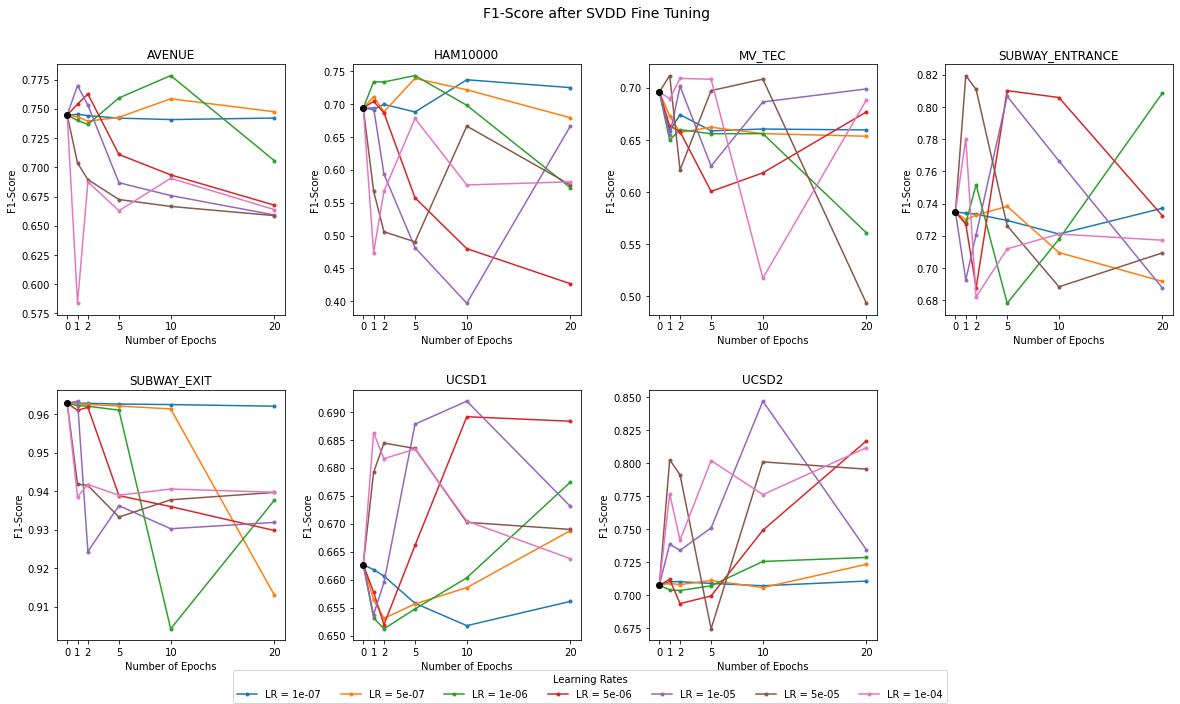

In [23]:
N = 4
for svdd_type, svdd_type_label in zip([svdd_auc_roc, svdd_f1_score], ["AUC ROC", "F1-Score"]):
    try:
        plt.clf()
        plt.clear()
    except:
        pass

    fig, ax = plt.subplots(2, N, figsize=(20,10))
    plt.subplots_adjust(bottom=0.08,wspace=0.3, hspace=0.3)
    IAD_DATASETS = ["IR_DISTRACTION"] # ["HAM10000", "IR_DISTRACTION", "MV-TEC", "MV_TEC"]
    count = 0

    line_labels = dict([(x, "LR = %s"%("1e-04" if x == "0.0001" else x)) for x in list(svdd_type.keys())])

    for idx, dataset in enumerate(svdd_type["1e-05"].keys()):
        if dataset in IAD_DATASETS: continue
        for lr in svdd_type.keys():
            ax[count//N][count%N].plot(list(svdd_type[lr][dataset].keys()), list(svdd_type[lr][dataset].values()), linestyle='-', marker='.', label = line_labels[lr])
        ax[count//N][count%N].plot([0], [svdd_type[lr][dataset][0]], "o", color='black')
        ax[count//N][count%N].set_title(dataset)
        ax[count//N][count%N].set_xticks(ticks = list(svdd_type["1e-07"]["AVENUE"].keys()))
        ax[count//N][count%N].set(xlabel='Number of Epochs', ylabel=svdd_type_label)
        count += 1
    ax[-1, -1].axis('off')
    # for axi in ax.flat: axi.label_outer()
    # plt.supxlabel("Number of Epochs - Fine Tuning")
    plt.ylabel("Anomaly Detection %s"%svdd_type_label)
    plt.suptitle("%s after SVDD Fine Tuning"%svdd_type_label, x = 0.5, y = 0.96, fontsize=14)

    # lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    # print(zip(*lines_labels))
    # lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    # fig.legend(lines, labels, loc = "lower right")

    fig.legend(labels=list(line_labels.values()),   # The labels for each line
               loc="lower center",   # Position of legend
               borderaxespad=0.1,    # Small spacing around legend box
               title="Learning Rates",  # Title for the legend
               ncol=7
               )

    plt.savefig("../../ATTN_PPR_RESULTS/Baseline_SVDD/SVDD_EpochsVs%s/SVDD_EpochsVs%s_VAD.png"%(svdd_type_label.replace(" ", "_").replace("-", "_"), svdd_type_label.replace(" ", "_").replace("-", "_")))

In [81]:
svdd_auc_best = dict()

for dataset in svdd_auc_roc["1e-05"].keys():
    best_per_lr = list()
    for lr in svdd_auc_roc.keys():
        ep = np.array(list(svdd_auc_roc[lr][dataset].items()))
        best_per_lr.append([lr] + ep[np.argmax(ep[:,1])].tolist())
    best_per_lr = np.array(best_per_lr)
    svdd_auc_best[dataset] = best_per_lr[np.argmax(best_per_lr[:,2])]


In [83]:
dump_pickle(svdd_auc_best, "../ATTN_PPR_RESULTS/SVDD_best_AUC_ROC_Baseline.pkl")

True

In [8]:
svdd_auc_best = load_pickle("../ATTN_PPR_RESULTS/Baseline_SVDD/SVDD_best_AUC_ROC_Baseline.pkl")

In [51]:
model = C2D_AE_128_3x3()
for dataset, params in svdd_auc_best.items():
    lr, e, auc = params
    e = int(e[:1])
    svdd_r = get_results_att_ppr(model, dataset, svdd_results[lr][dataset]['C2D_AE_128_3x3-'][e], "squared", "agg")
    items = list()
    for idx,(k,v) in enumerate(svdd_r.items()):
        if idx == 0: continue
        if idx == 1:
            v = replace_model_name(v) + " + SVDD"
            items.append(str(v))
        else:
            items.append(str(float(v) * 100)[:5])
    print(dataset)
    print("& " + " & ".join(items) + "\\\\")
    print()

AVENUE
& Baseline CAE + SVDD & 84.56 & 23.54 & 84.38 & 77.75 & 76.91 & 76.99\\

HAM10000
& Baseline CAE + SVDD & 68.35 & 36.08 & 61.44 & 71.91 & 68.83 & 69.96\\

IR_DISTRACTION
& Baseline CAE + SVDD & 89.19 & 20.83 & 88.41 & 81.27 & 81.0 & 80.96\\

MV_TEC
& Baseline CAE + SVDD & 66.05 & 38.12 & 62.64 & 70.28 & 68.06 & 68.95\\

SUBWAY_ENTRANCE
& Baseline CAE + SVDD & 79.03 & 26.20 & 99.3 & 96.65 & 71.55 & 81.08\\

SUBWAY_EXIT
& Baseline CAE + SVDD & 97.45 & 10.87 & 100.0 & 99.92 & 89.14 & 94.17\\

UCSD1
& Baseline CAE + SVDD & 69.92 & 35.5 & 65.39 & 67.66 & 67.32 & 65.95\\

UCSD2
& Baseline CAE + SVDD & 88.85 & 19.42 & 65.62 & 86.87 & 77.91 & 80.19\\

